In [20]:
import pandas as pd
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import seaborn as sns

In [21]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

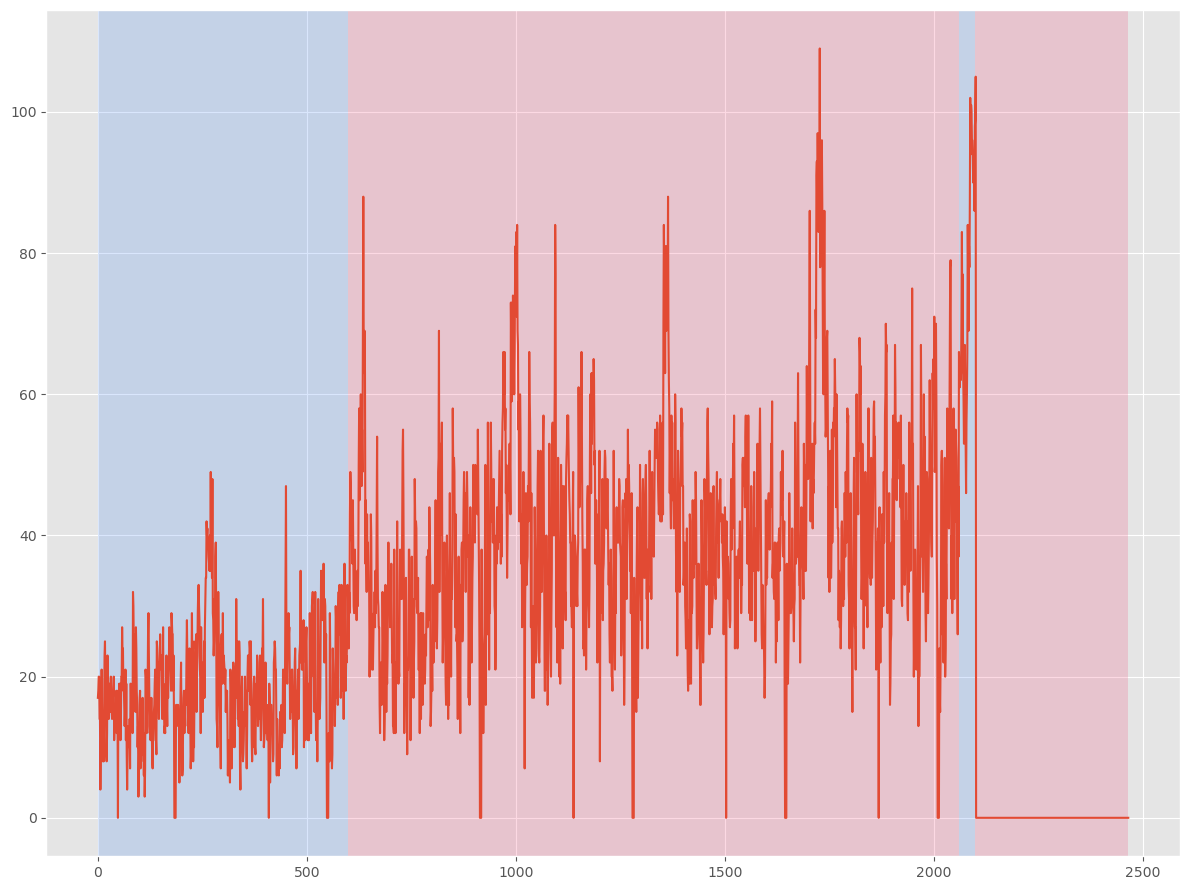

[600, 2060, 2100, 2466]


,y,client,close,price_am,price_pm,price,year,month,weekday,y_lag_365,price_am_lag_1,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365
datetime,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,0.134615,2010,7,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-02,18,0,0,0.692308,0.423077,0.557692,2010,7,4,NaN,0.192308,NaN,NaN,0.076923,NaN,NaN
2010-07-03,20,0,0,1.807692,1.192308,1.500000,2010,7,5,NaN,0.692308,NaN,NaN,0.423077,NaN,NaN
2010-07-04,20,0,0,1.407407,0.925926,1.166667,2010,7,6,NaN,1.807692,NaN,NaN,1.192308,NaN,NaN
2010-07-05,14,0,0,0.346154,0.192308,0.269231,2010,7,0,NaN,1.407407,NaN,NaN,0.925926,NaN,NaN


,client,close,price_am,price_pm,price,year,month,weekday,y_lag_365,price_am_lag_1,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365
datetime,,,,,,,,,,,,,,,
2016-04-01,1,0,3.0,2.0,2.5,2016,4,4,60.0,5.0,4.0,2.0,4.0,5.0,2.0
2016-04-02,0,0,5.0,5.0,5.0,2016,4,5,75.0,3.0,5.0,2.0,2.0,5.0,1.0
2016-04-03,1,0,2.0,2.0,2.0,2016,4,6,86.0,5.0,5.0,4.0,5.0,4.0,3.0
2016-04-04,1,0,1.0,1.0,1.0,2016,4,0,69.0,2.0,4.0,2.0,2.0,4.0,2.0
2016-04-05,0,0,1.0,1.0,1.0,2016,4,1,61.0,1.0,4.0,1.0,1.0,4.0,1.0


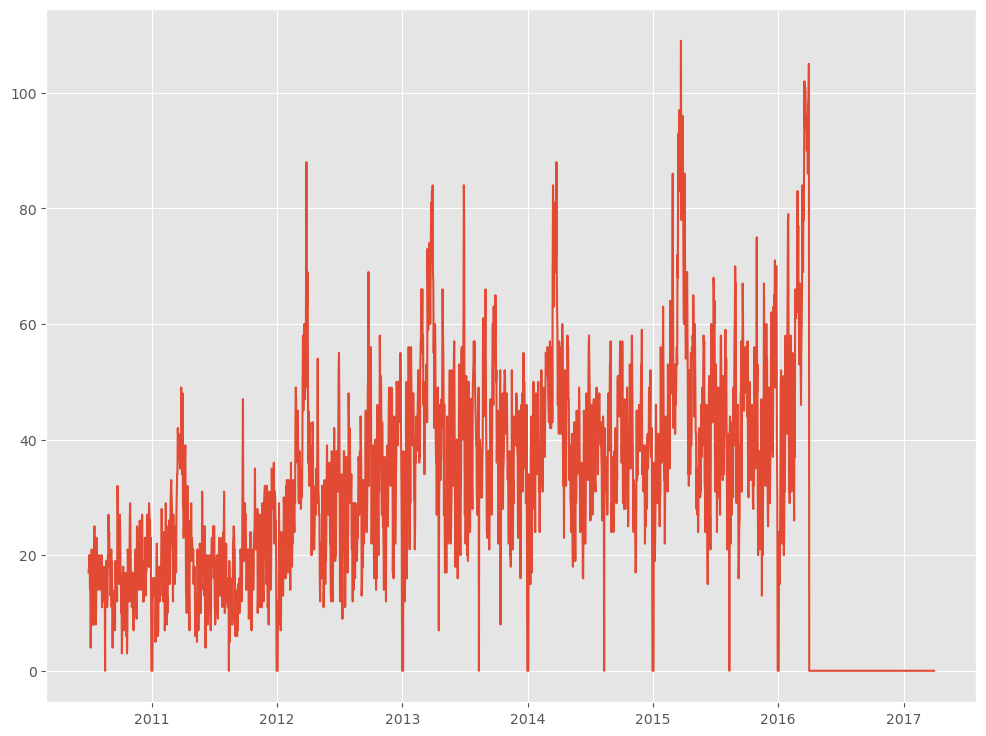

In [103]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

df.drop(['price_am_moving_avg_7', 'price_am_moving_avg_30', 'price_pm_moving_avg_7', 'price_pm_moving_avg_30', 'day'], axis=1, inplace=True)

################
### 変化点検知 ###
################

# コスト関数の設定
model = "l2"
# アルゴの設定と学習
algo = rpt.Dynp(model=model).fit(df[['y']])
# 変化点の検出
my_bkps = algo.predict(n_bkps=3)
# 結果のプロット
rpt.show.display(df[['y']], my_bkps, figsize=(12, 9))
plt.show()
# 検出された変化点
print(my_bkps)

# 訓練データをとる
train_data = df[df['is_train'] == 1].copy()

# テストデータをとる
test_data = df[df['is_train'] == 0].copy()

# 訓練データから不要な列（'is_train'）を削除
train_data.drop(['is_train'], axis=1, inplace=True)

# テストデータから不要な列を削除
test_data.drop(['y','is_train'], axis=1, inplace=True)

# テストデータからcloseを削除（このデータで予測する）
test_data_open = test_data.drop(['close'], axis=1, inplace=False)

display(train_data.head(), test_data.head())


plt.plot(df['y'])

In [104]:
# 訓練データから閉店時のデータを削除（これを学習させる）
train_data_open =  train_data[train_data['close']==0]
train_data_open_2 = train_data_open.drop(['close'], axis=1, inplace=False)

print(len(train_data_open_2))
print(len(train_data))

2074
2101


In [105]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

# 訓練データと検証データに分ける
N = 10
X_train = train_data_open_2.drop(['y'], axis=1)[:-N]
y_train = train_data_open_2['y'][:-N]

X_test = train_data_open_2.drop(['y'], axis=1)[-N:]
y_test = train_data_open_2['y'][-N:]

# LightGBM用のデータセット
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

# 評価基準 
params = {"objective" : "regression", 
              "metric" : "mse", 
              "num_leaves" : 7,
              "early_stopping_rounds" : 50,
              "verbosity": -1}

# 回帰モデル作成
model = lgb.train(params, lgb_train, valid_sets=lgb_test)

# 予測
test_pred = model.predict(X_test)
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_pred)], axis = 1)
pred_df.columns = ['true', 'pred']
pred_df

rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print('RMSE:',round(rmse,3))

RMSE: 8.395


([<matplotlib.axis.XTick at 0x30946bbf0>,
 [Text(0, 0, 'weekday'),
  Text(1, 0, 'price'),
  Text(2, 0, 'price_pm'),
  Text(3, 0, 'client'),
  Text(4, 0, 'year'),
  Text(5, 0, 'month'),
  Text(6, 0, 'price_am'),
  Text(7, 0, 'price_am_lag_7'),
  Text(8, 0, 'price_pm_lag_7'),
  Text(9, 0, 'price_am_lag_365'),
  Text(10, 0, 'price_am_lag_1'),
  Text(11, 0, 'price_pm_lag_1'),
  Text(12, 0, 'y'),
  Text(13, 0, 'y_lag_365')])

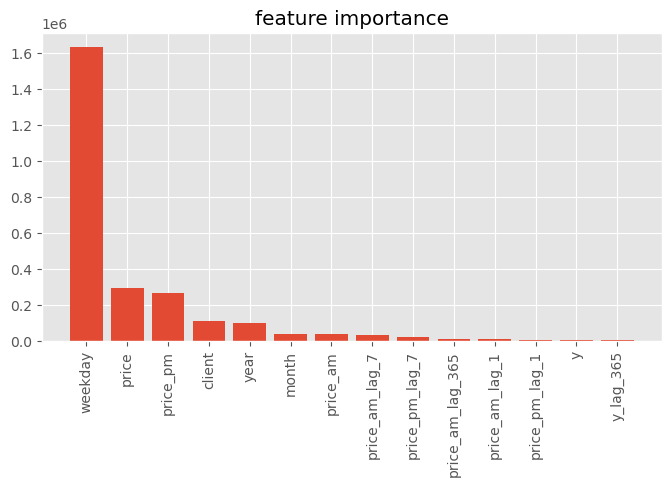

In [106]:
importances = model.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.title('feature importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), train_data_open_2.columns[indices], rotation=90)

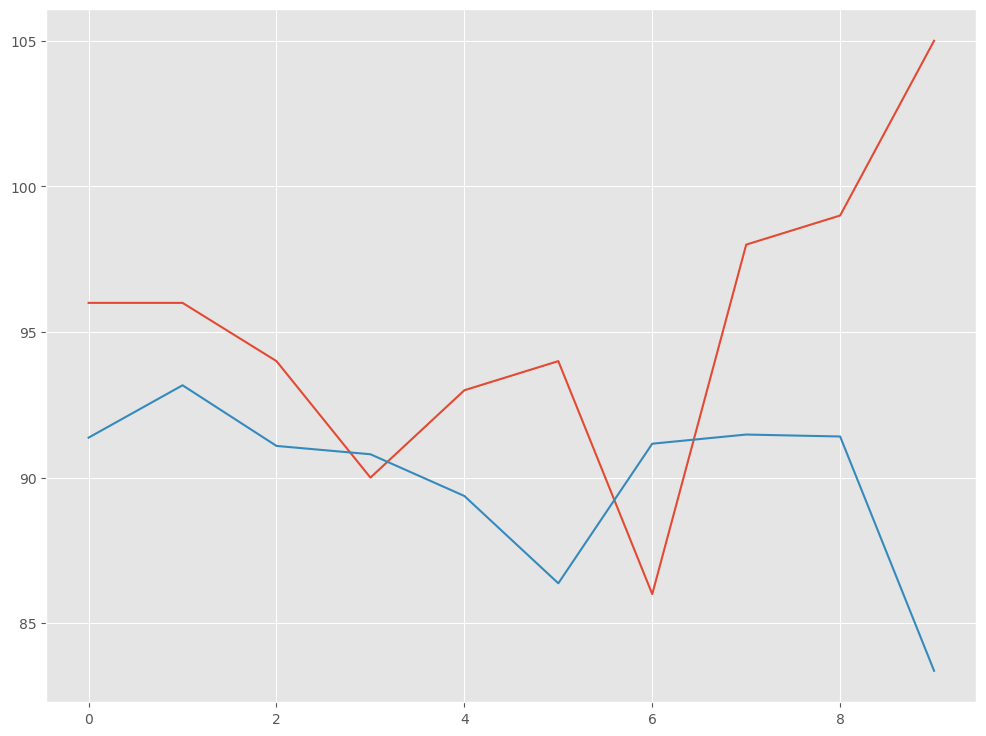

In [91]:
# 可視化
plt.plot(pred_df)

In [107]:
# oputunaによるハイパーパラメータのチューニング
import optuna

In [108]:
x_tr = X_train
x_va = X_test
y_tr = y_train
y_va = y_test

In [109]:
# 固定値のハイパーパラメータ
params_base = {
    'objective' : 'regression',    # 損失関数
    'random_seed' : 123,    
    'learnig_rate' : 0.1,  # １回のブースティングで加算する重みの比率
    'min_data_in_bin' : 3,  # ヒストグラムの１つのbinに含まれる最小のレコード数
    'bagging_freq' : 0,
    'verbose' : -1,
}


# ハイパーパラメータの探索範囲
def objective(trial):
    params_turning = {
        'num_leaves' : trial.suggest_int('num_leaves', 50, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 30),
        'max_bins' : trial.suggest_int('max_bin', 200, 400),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.8, 0.95),
        'feature_fraction' : trial.suggest_float('eature_fraction', 0.35, 0.65),
        'min_gain_to_split' : trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
        'lambda_11' : trial.suggest_float('lambda_11', 0.01, 1, log=True),
        'lambda_12' : trial.suggest_float('lambda_12', 0.01, 1, log=True),
    }
    
    # 探索用ハイパーパラメータの設定
    params_turning.update(params_base)
    lgb_train = lgb.Dataset(x_tr, y_tr)
    lgb_eval = lgb.Dataset(x_va, y_va)

    #探索用ハイパーパラメータで学習
    model = lgb.train(params_turning,
                      lgb_train,
                      num_boost_round=6000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(50),
                                 lgb.log_evaluation(500)])
    y_va_pred = model.predict(x_va,
                              num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    return score

In [110]:
# ハイパーパラメータの最適化の実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=1500)

[I 2024-09-02 11:49:25,598] A new study created in memory with name: no-name-9b02900e-9342-46c8-a1ec-394d4239c640
[I 2024-09-02 11:49:25,699] Trial 0 finished with value: 8.284920878174542 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'eature_fraction': 0.47709643980167143, 'min_gain_to_split': 0.19578897201212997, 'lambda_11': 0.07501954443620121, 'lambda_12': 0.6074996073425692}. Best is trial 0 with value: 8.284920878174542.
[I 2024-09-02 11:49:25,791] Trial 1 finished with value: 9.76927191007357 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'eature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_11': 0.013869861245357327, 'lambda_12': 0.014936835544198456}. Best is trial 0 with value: 8.284920878174542.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 25.3887	valid's l2: 95.0909

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 22.2705	valid's l2: 112.403

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:25,863] Trial 2 finished with value: 7.711966783568075 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'eature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.3965675081771009, 'lambda_11': 0.08374496868436809, 'lambda_12': 0.36396393567863894}. Best is trial 2 with value: 7.711966783568075.
[I 2024-09-02 11:49:25,979] Trial 3 finished with value: 9.225044911415498 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'eature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_11': 0.0338151426782029, 'lambda_12': 0.35356346291488117}. Best is trial 2 with value: 7.711966783568075.


Early stopping, best iteration is:
[55]	train's l2: 30.9278	valid's l2: 91.6214

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	train's l2: 20.8636	valid's l2: 104.276

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:26,091] Trial 4 finished with value: 8.69445397034046 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'eature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_11': 0.7717846862118064, 'lambda_12': 0.2310152225018237}. Best is trial 2 with value: 7.711966783568075.
[I 2024-09-02 11:49:26,186] Trial 5 finished with value: 7.516285920158877 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'eature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_11': 0.02634905974115613, 'lambda_12': 0.018107254066631072}. Best is trial 5 with value: 7.516285920158877.
[I 2024-09-02 11:49:26,287] Trial 6 finished with value: 6.938497582927378 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'eature_fraction': 0.6465121514177679

Early stopping, best iteration is:
[86]	train's l2: 21.7241	valid's l2: 103.367

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 21.6353	valid's l2: 83.4517

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 17.4192	valid's l2: 69.5581

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	train's l2: 10.5698	valid's l2: 81.3566


[I 2024-09-02 11:49:26,506] Trial 7 finished with value: 8.123864799773246 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'eature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_11': 0.2054277828628595, 'lambda_12': 0.018895826938026012}. Best is trial 6 with value: 6.938497582927378.
[I 2024-09-02 11:49:26,613] Trial 8 finished with value: 6.43151456536084 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'eature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_11': 0.8972612866432508, 'lambda_12': 0.08655704137361815}. Best is trial 8 with value: 6.43151456536084.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 17.5847	valid's l2: 68.4163

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:26,721] Trial 9 finished with value: 8.93158511017272 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'eature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_11': 0.0391093317225106, 'lambda_12': 0.0172764870082179}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:26,889] Trial 10 finished with value: 8.081310765947185 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 3, 'max_bin': 391, 'bagging_fraction': 0.8357161822219233, 'eature_fraction': 0.5842248758067577, 'min_gain_to_split': 0.05360980835049379, 'lambda_11': 0.5572928896695891, 'lambda_12': 0.06472055193755138}. Best is trial 8 with value: 6.43151456536084.


Early stopping, best iteration is:
[91]	train's l2: 23.3716	valid's l2: 102.123

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 11.8441	valid's l2: 86.6044

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:27,068] Trial 11 finished with value: 8.20932514566316 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 8, 'max_bin': 280, 'bagging_fraction': 0.8466942712542896, 'eature_fraction': 0.6497644585835788, 'min_gain_to_split': 0.011759570092455911, 'lambda_11': 0.2564308059083753, 'lambda_12': 0.05966060760625274}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:27,174] Trial 12 finished with value: 7.192440252809386 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 9, 'max_bin': 268, 'bagging_fraction': 0.8519257611126392, 'eature_fraction': 0.5980461884423712, 'min_gain_to_split': 0.03476707630905029, 'lambda_11': 0.010571312979796266, 'lambda_12': 0.043746926368901824}. Best is trial 8 with value: 6.43151456536084.


Early stopping, best iteration is:
[61]	train's l2: 15.1397	valid's l2: 87.8725

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.1731	valid's l2: 74.7524

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:27,440] Trial 13 finished with value: 9.846996157296818 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 2, 'max_bin': 397, 'bagging_fraction': 0.9125244731428174, 'eature_fraction': 0.6046567756717076, 'min_gain_to_split': 0.029747560698361656, 'lambda_11': 0.2100408407671935, 'lambda_12': 0.145107046563573}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:27,578] Trial 14 finished with value: 7.440361120288823 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 13, 'max_bin': 316, 'bagging_fraction': 0.862886007456836, 'eature_fraction': 0.5725939271183601, 'min_gain_to_split': 0.010687182916189086, 'lambda_11': 0.3294870521361328, 'lambda_12': 0.0322773768565268}. Best is trial 8 with value: 6.43151456536084.


Early stopping, best iteration is:
[90]	train's l2: 5.02197	valid's l2: 121.484

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	train's l2: 16.4409	valid's l2: 75.681

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:27,654] Trial 15 finished with value: 7.380000114036347 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 6, 'max_bin': 374, 'bagging_fraction': 0.8230668162788879, 'eature_fraction': 0.6227082335916473, 'min_gain_to_split': 0.02806019555119712, 'lambda_11': 0.12207900178230416, 'lambda_12': 0.10529261582221264}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:27,808] Trial 16 finished with value: 8.60362812898039 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 260, 'bagging_fraction': 0.8972607000576027, 'eature_fraction': 0.4642937700354983, 'min_gain_to_split': 0.10343272083950615, 'lambda_11': 0.9793529142759247, 'lambda_12': 0.028938908135898448}. Best is trial 8 with value: 6.43151456536084.


Early stopping, best iteration is:
[49]	train's l2: 23.7271	valid's l2: 85.8607

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	train's l2: 19.2953	valid's l2: 90.214

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:27,922] Trial 17 finished with value: 7.364691047381721 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 27, 'max_bin': 318, 'bagging_fraction': 0.8666322626534334, 'eature_fraction': 0.5704042920791986, 'min_gain_to_split': 0.019544505499500455, 'lambda_11': 0.01791223970045813, 'lambda_12': 0.11432479749625261}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:28,026] Trial 18 finished with value: 6.804565696133909 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 10, 'max_bin': 331, 'bagging_fraction': 0.8005062132941823, 'eature_fraction': 0.6208843709340933, 'min_gain_to_split': 0.05531464467460891, 'lambda_11': 0.06418347050363743, 'lambda_12': 0.010078831719246636}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:28,119] Trial 19 finished with value: 12.308849827168629 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 5, 'max_bin': 374, 'bagging_fraction': 0.8013347171732064, 'eature_fraction': 0.35059340056

Early stopping, best iteration is:
[78]	train's l2: 27.6076	valid's l2: 73.2044

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 19.4068	valid's l2: 70.2415

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 20.3949	valid's l2: 185.988



[I 2024-09-02 11:49:28,227] Trial 20 finished with value: 6.479489894879988 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 11, 'max_bin': 335, 'bagging_fraction': 0.8224479993619563, 'eature_fraction': 0.5514199761097852, 'min_gain_to_split': 0.08711840217980496, 'lambda_11': 0.1353240951782776, 'lambda_12': 0.901404961742367}. Best is trial 8 with value: 6.43151456536084.
[I 2024-09-02 11:49:28,308] Trial 21 finished with value: 6.247310100026989 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 11, 'max_bin': 336, 'bagging_fraction': 0.8229663055834622, 'eature_fraction': 0.5522485754117896, 'min_gain_to_split': 0.07643861944137226, 'lambda_11': 0.1326399961069974, 'lambda_12': 0.8950829693537737}. Best is trial 21 with value: 6.247310100026989.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 21.5829	valid's l2: 66.0049

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 21.3025	valid's l2: 59.2158

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:28,414] Trial 22 finished with value: 6.457081215339137 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 16, 'max_bin': 371, 'bagging_fraction': 0.8206752734949452, 'eature_fraction': 0.543674438967863, 'min_gain_to_split': 0.11136195030037165, 'lambda_11': 0.13403457590267054, 'lambda_12': 0.7825035883854335}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:28,573] Trial 23 finished with value: 8.267854085926647 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 17, 'max_bin': 376, 'bagging_fraction': 0.8196010743607853, 'eature_fraction': 0.48779658178792473, 'min_gain_to_split': 0.12265333012450295, 'lambda_11': 0.3811506134865517, 'lambda_12': 0.9046081137443838}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[64]	train's l2: 23.9607	valid's l2: 70.8059

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	train's l2: 21.0146	valid's l2: 83.4052

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:28,679] Trial 24 finished with value: 6.68853255541638 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 23, 'max_bin': 360, 'bagging_fraction': 0.8321270891545293, 'eature_fraction': 0.5519603924093369, 'min_gain_to_split': 0.32773005476603373, 'lambda_11': 0.5029950005328021, 'lambda_12': 0.5661217579771224}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:28,779] Trial 25 finished with value: 7.713476019150955 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 16, 'max_bin': 379, 'bagging_fraction': 0.8470598499808306, 'eature_fraction': 0.5163843081428159, 'min_gain_to_split': 0.710379517617919, 'lambda_11': 0.1533815173029309, 'lambda_12': 0.20223162286938512}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[64]	train's l2: 27.7651	valid's l2: 71.3135

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 27.2268	valid's l2: 80.4384

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:28,928] Trial 26 finished with value: 9.034295725514195 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 30, 'max_bin': 300, 'bagging_fraction': 0.8136597027148548, 'eature_fraction': 0.535646135054133, 'min_gain_to_split': 0.1307140677643476, 'lambda_11': 0.10329472050146962, 'lambda_12': 0.3591259526458398}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[143]	train's l2: 23.464	valid's l2: 100.249

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:29,175] Trial 27 finished with value: 8.032006234779345 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.830636215682958, 'eature_fraction': 0.5898146412922011, 'min_gain_to_split': 0.2779762995905841, 'lambda_11': 0.17731605053787347, 'lambda_12': 0.5703938712487284}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:29,288] Trial 28 finished with value: 9.367170092077124 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 16, 'max_bin': 347, 'bagging_fraction': 0.814689668468307, 'eature_fraction': 0.45194679000297555, 'min_gain_to_split': 0.03430767518841205, 'lambda_11': 0.307761840404087, 'lambda_12': 0.2314561059724904}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[62]	train's l2: 13.6566	valid's l2: 87.252

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 22.5327	valid's l2: 103.533

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:29,449] Trial 29 finished with value: 8.298809395763918 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 21, 'max_bin': 365, 'bagging_fraction': 0.8449888379656332, 'eature_fraction': 0.492354924133744, 'min_gain_to_split': 0.45687903902789617, 'lambda_11': 0.05120738145286452, 'lambda_12': 0.07303948399544793}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:29,554] Trial 30 finished with value: 7.412524576973924 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 24, 'max_bin': 328, 'bagging_fraction': 0.8279549699246134, 'eature_fraction': 0.5669213204977166, 'min_gain_to_split': 0.1658364244356794, 'lambda_11': 0.4769884754885804, 'lambda_12': 0.47083779502596385}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[67]	train's l2: 27.3492	valid's l2: 95.4565

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 29.9403	valid's l2: 86.3437

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:29,655] Trial 31 finished with value: 7.1388438689386735 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 11, 'max_bin': 339, 'bagging_fraction': 0.820268645760958, 'eature_fraction': 0.5486644833686638, 'min_gain_to_split': 0.08106065159217098, 'lambda_11': 0.14168504145429978, 'lambda_12': 0.9727806719582676}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[65]	train's l2: 19.6266	valid's l2: 76.1272

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:29,872] Trial 32 finished with value: 6.823727420770318 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 11, 'max_bin': 351, 'bagging_fraction': 0.8145403624065304, 'eature_fraction': 0.6169330893582943, 'min_gain_to_split': 0.0737261676706603, 'lambda_11': 0.09323261031845569, 'lambda_12': 0.7670253946819753}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:29,995] Trial 33 finished with value: 8.806715149566015 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 14, 'max_bin': 384, 'bagging_fraction': 0.8391470461517208, 'eature_fraction': 0.5232912217942888, 'min_gain_to_split': 0.0864676624314207, 'lambda_11': 0.1225938729768745, 'lambda_12': 0.6727809787365817}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[51]	train's l2: 17.7952	valid's l2: 68.943

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 22.6297	valid's l2: 99.0545

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.5465	valid's l2: 86.5094


[I 2024-09-02 11:49:30,071] Trial 34 finished with value: 7.972931606639072 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 364, 'bagging_fraction': 0.8571906585149839, 'eature_fraction': 0.5558263383372047, 'min_gain_to_split': 0.04228636459044042, 'lambda_11': 0.24482096659144284, 'lambda_12': 0.4029095581054362}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:30,181] Trial 35 finished with value: 7.448766598121717 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 11, 'max_bin': 332, 'bagging_fraction': 0.8244577997923188, 'eature_fraction': 0.508630287065461, 'min_gain_to_split': 0.9260271129377952, 'lambda_11': 0.07969290948830796, 'lambda_12': 0.7298310410665101}. Best is trial 21 with value: 6.247310100026989.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 19.195	valid's l2: 77.3033

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:30,331] Trial 36 finished with value: 8.408463181134065 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 19, 'max_bin': 304, 'bagging_fraction': 0.8798828971191749, 'eature_fraction': 0.5338604481904721, 'min_gain_to_split': 0.12455810449252663, 'lambda_11': 0.6539684144726685, 'lambda_12': 0.2798545533982234}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:30,481] Trial 37 finished with value: 6.553502072547799 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 15, 'max_bin': 340, 'bagging_fraction': 0.8103631175838238, 'eature_fraction': 0.5834216790783745, 'min_gain_to_split': 0.22563984267586817, 'lambda_11': 0.04769450055552303, 'lambda_12': 0.1507367181753288}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[76]	train's l2: 24.2032	valid's l2: 95.6481

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 21.0116	valid's l2: 69.3622

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:30,656] Trial 38 finished with value: 9.354880027790111 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 4, 'max_bin': 367, 'bagging_fraction': 0.9280056340695768, 'eature_fraction': 0.534498890514321, 'min_gain_to_split': 0.17051743794495217, 'lambda_11': 0.10795726096188107, 'lambda_12': 0.4956936195585691}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:30,795] Trial 39 finished with value: 7.43331210781861 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 9, 'max_bin': 387, 'bagging_fraction': 0.8415193478981554, 'eature_fraction': 0.5631337360500833, 'min_gain_to_split': 0.0643798407960957, 'lambda_11': 0.17178246727038862, 'lambda_12': 0.9150667743667824}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[65]	train's l2: 13.7022	valid's l2: 110.513

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 18.0371	valid's l2: 75.7741

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:30,923] Trial 40 finished with value: 7.547079202457544 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 325, 'bagging_fraction': 0.8715139300626481, 'eature_fraction': 0.6289789508428291, 'min_gain_to_split': 0.024796397535378177, 'lambda_11': 0.9930979751724455, 'lambda_12': 0.2899769074844162}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:31,035] Trial 41 finished with value: 6.394699865678227 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 15, 'max_bin': 344, 'bagging_fraction': 0.8086383752503682, 'eature_fraction': 0.5864904814838292, 'min_gain_to_split': 0.23706121446341827, 'lambda_11': 0.04080434998083255, 'lambda_12': 0.16376902581953953}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[54]	train's l2: 22.4574	valid's l2: 82.7378

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 22.4216	valid's l2: 70.4962

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:31,180] Trial 42 finished with value: 6.460301519235183 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 18, 'max_bin': 351, 'bagging_fraction': 0.8091280587107249, 'eature_fraction': 0.6087498689972684, 'min_gain_to_split': 0.3763713118095786, 'lambda_11': 0.021581974091694874, 'lambda_12': 0.07837530332975515}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:31,320] Trial 43 finished with value: 6.827201483507753 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 18, 'max_bin': 351, 'bagging_fraction': 0.8083757066845897, 'eature_fraction': 0.5997285116210697, 'min_gain_to_split': 0.4294637162409153, 'lambda_11': 0.019062438490099694, 'lambda_12': 0.08561015163121362}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[75]	train's l2: 20.793	valid's l2: 68.3273

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 23.4755	valid's l2: 74.075

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:31,458] Trial 44 finished with value: 6.378757698620238 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 21, 'max_bin': 358, 'bagging_fraction': 0.804902707417993, 'eature_fraction': 0.636801985910489, 'min_gain_to_split': 0.5480660722478834, 'lambda_11': 0.02904024385710183, 'lambda_12': 0.050811962400141505}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:31,546] Trial 45 finished with value: 7.1962988419653175 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 21, 'max_bin': 357, 'bagging_fraction': 0.8007867822718436, 'eature_fraction': 0.6369481856989747, 'min_gain_to_split': 0.5740601518528301, 'lambda_11': 0.03378855426771996, 'lambda_12': 0.04958308415350386}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[75]	train's l2: 23.3731	valid's l2: 68.0723

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 27.0025	valid's l2: 79.9615

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:31,714] Trial 46 finished with value: 7.752683345377706 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 14, 'max_bin': 369, 'bagging_fraction': 0.8162980122207496, 'eature_fraction': 0.6330672032951219, 'min_gain_to_split': 0.5417485122272395, 'lambda_11': 0.030849464877492225, 'lambda_12': 0.037668188235183406}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:31,810] Trial 47 finished with value: 7.70230996498155 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 25, 'max_bin': 307, 'bagging_fraction': 0.8301300172212345, 'eature_fraction': 0.5829059754470987, 'min_gain_to_split': 0.25538119508210083, 'lambda_11': 0.012236965658891796, 'lambda_12': 0.025353678249945513}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[65]	train's l2: 18.5123	valid's l2: 82.181

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 28.9605	valid's l2: 93.2939

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 27.4233	valid's l2: 84.941


[I 2024-09-02 11:49:31,912] Trial 48 finished with value: 7.424727793992763 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 20, 'max_bin': 203, 'bagging_fraction': 0.8072159982309861, 'eature_fraction': 0.6128722393543506, 'min_gain_to_split': 0.19372681515182671, 'lambda_11': 0.043451098791524236, 'lambda_12': 0.17130729763261798}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:32,025] Trial 49 finished with value: 6.419637514332486 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 13, 'max_bin': 342, 'bagging_fraction': 0.892383789564321, 'eature_fraction': 0.6453302957831877, 'min_gain_to_split': 0.013263257438318637, 'lambda_11': 0.014500779656899084, 'lambda_12': 0.09594668573646259}. Best is trial 21 with value: 6.247310100026989.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.8696	valid's l2: 63.9436

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:32,169] Trial 50 finished with value: 6.6115844992751365 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 13, 'max_bin': 291, 'bagging_fraction': 0.8912006813310771, 'eature_fraction': 0.6450769569955792, 'min_gain_to_split': 0.013577389567555387, 'lambda_11': 0.024028419813257863, 'lambda_12': 0.05019956314396379}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:32,365] Trial 51 finished with value: 7.345449010720539 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 15, 'max_bin': 344, 'bagging_fraction': 0.8876435545547725, 'eature_fraction': 0.5910367312787017, 'min_gain_to_split': 0.022059671337761304, 'lambda_11': 0.015188620074353832, 'lambda_12': 0.10613334650857711}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[62]	train's l2: 18.0973	valid's l2: 63.736

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.8529	valid's l2: 84.2219

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:32,591] Trial 52 finished with value: 6.817317193063454 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 8, 'max_bin': 216, 'bagging_fraction': 0.9003253470052636, 'eature_fraction': 0.6483972510007441, 'min_gain_to_split': 0.012543935758586486, 'lambda_11': 0.014419415947283841, 'lambda_12': 0.060066006058215965}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:32,717] Trial 53 finished with value: 6.460378927626607 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 14, 'max_bin': 357, 'bagging_fraction': 0.9150832603626042, 'eature_fraction': 0.5761933200215585, 'min_gain_to_split': 0.01613755434196379, 'lambda_11': 0.030944127918121588, 'lambda_12': 0.09031077862990665}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[57]	train's l2: 14.0914	valid's l2: 68.4426

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 20.711	valid's l2: 64.5727

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:32,830] Trial 54 finished with value: 7.281206300712991 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 17, 'max_bin': 324, 'bagging_fraction': 0.805117302741254, 'eature_fraction': 0.5985183626012401, 'min_gain_to_split': 0.010374623931170723, 'lambda_11': 0.010030785550916658, 'lambda_12': 0.1264891991104191}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:32,952] Trial 55 finished with value: 7.140536944900488 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 12, 'max_bin': 390, 'bagging_fraction': 0.8248568754585572, 'eature_fraction': 0.626572552353834, 'min_gain_to_split': 0.1503129470768966, 'lambda_11': 0.06138226166107995, 'lambda_12': 0.045119294228955664}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[76]	train's l2: 20.721	valid's l2: 71.7604

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 18.4147	valid's l2: 73.2198

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:33,053] Trial 56 finished with value: 6.773994781502277 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 16, 'max_bin': 253, 'bagging_fraction': 0.9030364320140442, 'eature_fraction': 0.60661461352818, 'min_gain_to_split': 0.10049723927119224, 'lambda_11': 0.038313766887426895, 'lambda_12': 0.06756367625700276}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:33,127] Trial 57 finished with value: 6.440106812983819 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 10, 'max_bin': 310, 'bagging_fraction': 0.9086182698500335, 'eature_fraction': 0.6370812918678606, 'min_gain_to_split': 0.9762352674384956, 'lambda_11': 0.02368819450484125, 'lambda_12': 0.13095519073282696}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:33,196] Trial 58 finished with value: 7.159014578444451 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 9, 'max_bin': 314, 'bagging_fraction': 0.916064752042953, 'eature_fraction': 0.63222060687090

Early stopping, best iteration is:
[51]	train's l2: 24.6483	valid's l2: 65.6749

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 20.2137	valid's l2: 65.7916

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 21.1639	valid's l2: 75.3178

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:33,299] Trial 59 finished with value: 8.120585412134806 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 10, 'max_bin': 310, 'bagging_fraction': 0.9097221407971156, 'eature_fraction': 0.61906967944514, 'min_gain_to_split': 0.7551082161881745, 'lambda_11': 0.021538477701067246, 'lambda_12': 0.17104642585778998}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:33,410] Trial 60 finished with value: 6.316486509436895 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 7, 'max_bin': 335, 'bagging_fraction': 0.9213843172373197, 'eature_fraction': 0.6394924841855788, 'min_gain_to_split': 0.5652521159474906, 'lambda_11': 0.02605113225983682, 'lambda_12': 0.09521169166436942}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[62]	train's l2: 15.5853	valid's l2: 84.9674

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 13.5108	valid's l2: 55.0919

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:33,518] Trial 61 finished with value: 6.969785357507635 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 6, 'max_bin': 340, 'bagging_fraction': 0.9307205404370651, 'eature_fraction': 0.6333460204562237, 'min_gain_to_split': 0.810200728408208, 'lambda_11': 0.02763501945023248, 'lambda_12': 0.09452016607851249}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:33,623] Trial 62 finished with value: 6.892534394236293 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 7, 'max_bin': 320, 'bagging_fraction': 0.9222336476518976, 'eature_fraction': 0.6405587765279428, 'min_gain_to_split': 0.5181091767060105, 'lambda_11': 0.012400042797870481, 'lambda_12': 0.11490984578041692}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[57]	train's l2: 11.9058	valid's l2: 70.2926

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 16.4736	valid's l2: 66.8175

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:33,811] Trial 63 finished with value: 8.057375939294236 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 10, 'max_bin': 335, 'bagging_fraction': 0.9066839181878739, 'eature_fraction': 0.6178256859406654, 'min_gain_to_split': 0.6292741211752951, 'lambda_11': 0.01878114354304768, 'lambda_12': 0.07900435202391973}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:33,951] Trial 64 finished with value: 7.611893163822158 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 12, 'max_bin': 291, 'bagging_fraction': 0.9407178719051902, 'eature_fraction': 0.6408706780062571, 'min_gain_to_split': 0.3274570845870732, 'lambda_11': 0.02243094094651466, 'lambda_12': 0.058142334665999613}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[59]	train's l2: 14.8615	valid's l2: 85.0538

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 12.8064	valid's l2: 75.5322

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:34,024] Trial 65 finished with value: 8.062277308095771 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 345, 'bagging_fraction': 0.8950279432832756, 'eature_fraction': 0.6498378532720712, 'min_gain_to_split': 0.6525626123549304, 'lambda_11': 0.03523955834330525, 'lambda_12': 0.03566984469137091}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:34,133] Trial 66 finished with value: 8.301416944287828 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 10, 'max_bin': 362, 'bagging_fraction': 0.8839205326256346, 'eature_fraction': 0.6245064910614359, 'min_gain_to_split': 0.8423071389485881, 'lambda_11': 0.026702426342405966, 'lambda_12': 0.20995709840965526}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[62]	train's l2: 21.2176	valid's l2: 89.6584

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 14.6833	valid's l2: 85.7996

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:34,274] Trial 67 finished with value: 8.5151064705282 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 6, 'max_bin': 327, 'bagging_fraction': 0.9288545757722342, 'eature_fraction': 0.5932025863656804, 'min_gain_to_split': 0.019210457714068253, 'lambda_11': 0.05352190170949739, 'lambda_12': 0.14857670411990032}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:34,384] Trial 68 finished with value: 7.4824798302821804 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 12, 'max_bin': 279, 'bagging_fraction': 0.9482472386358313, 'eature_fraction': 0.4087082224211217, 'min_gain_to_split': 0.01405480137084595, 'lambda_11': 0.011922072359250862, 'lambda_12': 0.17469057636944296}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[61]	train's l2: 11.4424	valid's l2: 96.5839

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 18.6762	valid's l2: 76.9469

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:34,493] Trial 69 finished with value: 8.569056219108 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 13, 'max_bin': 354, 'bagging_fraction': 0.9197723095533201, 'eature_fraction': 0.6085293993608857, 'min_gain_to_split': 0.3859546261489445, 'lambda_11': 0.7719885670668842, 'lambda_12': 0.1182679783919418}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:34,573] Trial 70 finished with value: 7.313853504953892 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 7, 'max_bin': 380, 'bagging_fraction': 0.8044752338231494, 'eature_fraction': 0.5773969885576814, 'min_gain_to_split': 0.3112518145115605, 'lambda_11': 0.0428572936390916, 'lambda_12': 0.09931688364863378}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:34,651] Trial 71 finished with value: 7.449892556891649 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 27, 'max_bin': 373, 'bagging_fraction': 0.8152359823824188, 'eature_fraction': 0.5463326721024871, 

Early stopping, best iteration is:
[66]	train's l2: 17.3239	valid's l2: 96.1971

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 19.0438	valid's l2: 78.2247

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.4229	valid's l2: 77.9079

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:34,721] Trial 72 finished with value: 7.275117401495136 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 17, 'max_bin': 332, 'bagging_fraction': 0.8192324472724715, 'eature_fraction': 0.6027138622265135, 'min_gain_to_split': 0.221308528570612, 'lambda_11': 0.06854466463265954, 'lambda_12': 0.2823212783047439}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:34,794] Trial 73 finished with value: 7.136232547988162 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 344, 'bagging_fraction': 0.875643681638926, 'eature_fraction': 0.625260245683085, 'min_gain_to_split': 0.038889814801431055, 'lambda_11': 0.017213774648997662, 'lambda_12': 0.0697342290617355}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:34,900] Trial 74 finished with value: 6.647098283704148 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 14, 'max_bin': 368, 'bagging_fraction': 0.8360809737095012, 'eature_fraction': 0.55901237479666

Early stopping, best iteration is:
[73]	train's l2: 24.0276	valid's l2: 79.8454

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 24.9802	valid's l2: 79.694

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	train's l2: 16.9935	valid's l2: 63.1702

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:35,015] Trial 75 finished with value: 7.553048237675505 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 11, 'max_bin': 360, 'bagging_fraction': 0.8119974459231063, 'eature_fraction': 0.5416832999641314, 'min_gain_to_split': 0.14456499883916324, 'lambda_11': 0.08611442660362938, 'lambda_12': 0.599107106275028}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,129] Trial 76 finished with value: 7.082347558976172 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 16, 'max_bin': 337, 'bagging_fraction': 0.8180372365759705, 'eature_fraction': 0.5175702917760808, 'min_gain_to_split': 0.27193074076366486, 'lambda_11': 0.29051117918517655, 'lambda_12': 0.13351964962574528}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[65]	train's l2: 17.7735	valid's l2: 81.9177

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 21.0648	valid's l2: 66.9964

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:35,248] Trial 77 finished with value: 7.098186312856631 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 19, 'max_bin': 349, 'bagging_fraction': 0.8248361471566491, 'eature_fraction': 0.6385426531116781, 'min_gain_to_split': 0.02639705032346766, 'lambda_11': 0.02482462873107694, 'lambda_12': 0.014615199788693115}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,351] Trial 78 finished with value: 8.525219832693825 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 4, 'max_bin': 380, 'bagging_fraction': 0.9339050245877866, 'eature_fraction': 0.6147941457584627, 'min_gain_to_split': 0.04700919375087109, 'lambda_11': 0.028480255364583946, 'lambda_12': 0.08492626094599445}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,422] Trial 79 finished with value: 7.231242123579053 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 14, 'max_bin': 316, 'bagging_fraction': 0.9235237270039446, 'eature_fraction': 0.56814852

Early stopping, best iteration is:
[97]	train's l2: 18.3022	valid's l2: 73.5533

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 13.675	valid's l2: 92.1614

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 23.5549	valid's l2: 74.3491

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:35,521] Trial 80 finished with value: 8.301522860402072 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 9, 'max_bin': 372, 'bagging_fraction': 0.8511401021751749, 'eature_fraction': 0.5861965029192032, 'min_gain_to_split': 0.03173533289731176, 'lambda_11': 0.01985818891968831, 'lambda_12': 0.5063010671237109}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,603] Trial 81 finished with value: 6.907502085999921 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 22, 'max_bin': 353, 'bagging_fraction': 0.8106039241890829, 'eature_fraction': 0.6099801080080866, 'min_gain_to_split': 0.37431054463259095, 'lambda_11': 0.02214112382966861, 'lambda_12': 0.07973719950190664}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,699] Trial 82 finished with value: 6.819474420514988 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 18, 'max_bin': 346, 'bagging_fraction': 0.8069958785695258, 'eature_fraction': 0.596174101559

Early stopping, best iteration is:
[65]	train's l2: 16.3448	valid's l2: 86.7869

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 25.9016	valid's l2: 77.5429

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 23.9164	valid's l2: 79.3664

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:35,771] Trial 83 finished with value: 7.575540261339055 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 20, 'max_bin': 361, 'bagging_fraction': 0.8001530289065559, 'eature_fraction': 0.6315647448734855, 'min_gain_to_split': 0.4748836316819338, 'lambda_11': 0.015867054298067826, 'lambda_12': 0.07294812591249071}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,853] Trial 84 finished with value: 7.3272197594456285 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 18, 'max_bin': 332, 'bagging_fraction': 0.8039705972285196, 'eature_fraction': 0.6201015219718977, 'min_gain_to_split': 0.40820345671625097, 'lambda_11': 0.0379023040459225, 'lambda_12': 0.05963394662684638}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:35,931] Trial 85 finished with value: 8.629059969298511 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 22, 'max_bin': 394, 'bagging_fraction': 0.8274119362395266, 'eature_fraction': 0.4770993038

Early stopping, best iteration is:
[54]	train's l2: 26.7654	valid's l2: 86.1159

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 25.3528	valid's l2: 86.1423

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 28.7202	valid's l2: 104.354

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:36,039] Trial 86 finished with value: 8.081403138348902 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 15, 'max_bin': 354, 'bagging_fraction': 0.8213826474725309, 'eature_fraction': 0.5036233450130626, 'min_gain_to_split': 0.5732856210307723, 'lambda_11': 0.024004142712329767, 'lambda_12': 0.04531850721945741}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:36,143] Trial 87 finished with value: 9.529133006327957 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 13, 'max_bin': 340, 'bagging_fraction': 0.8123883528766525, 'eature_fraction': 0.5235850692965628, 'min_gain_to_split': 0.19719159249539236, 'lambda_11': 0.013623048863680647, 'lambda_12': 0.038375566507489085}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[67]	train's l2: 22.5703	valid's l2: 86.5874

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 21.6472	valid's l2: 109.772

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:36,263] Trial 88 finished with value: 11.597982365898305 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 11, 'max_bin': 322, 'bagging_fraction': 0.9051980863266422, 'eature_fraction': 0.35401867688387934, 'min_gain_to_split': 0.714532562410656, 'lambda_11': 0.850249628692, 'lambda_12': 0.6929832394189236}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:36,362] Trial 89 finished with value: 6.9613750760745905 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 17, 'max_bin': 365, 'bagging_fraction': 0.816818520394264, 'eature_fraction': 0.6411591055136567, 'min_gain_to_split': 0.011600927601104769, 'lambda_11': 0.16051958988369852, 'lambda_12': 0.09336828012769785}. Best is trial 21 with value: 6.247310100026989.


Early stopping, best iteration is:
[89]	train's l2: 19.7299	valid's l2: 157.803

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 21.1696	valid's l2: 75.9606

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:36,500] Trial 90 finished with value: 6.564535546463157 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 12, 'max_bin': 296, 'bagging_fraction': 0.8320196093809659, 'eature_fraction': 0.6048345222022726, 'min_gain_to_split': 0.3027084191005467, 'lambda_11': 0.12853512239637843, 'lambda_12': 0.028726050204136887}. Best is trial 21 with value: 6.247310100026989.
[I 2024-09-02 11:49:36,582] Trial 91 finished with value: 6.0982598287261665 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 15, 'max_bin': 356, 'bagging_fraction': 0.9115003844109898, 'eature_fraction': 0.5740619662381263, 'min_gain_to_split': 0.021309158531913678, 'lambda_11': 0.02931607659580206, 'lambda_12': 0.08553805721480956}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:36,667] Trial 92 finished with value: 7.7434737209751265 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 13, 'max_bin': 357, 'bagging_fraction': 0.909761857422065, 'eature_fraction': 0.579565

Early stopping, best iteration is:
[62]	train's l2: 17.9908	valid's l2: 64.5839

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 22.8621	valid's l2: 59.0932

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.0931	valid's l2: 82.7728

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:36,743] Trial 93 finished with value: 6.8667097610530305 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 16, 'max_bin': 348, 'bagging_fraction': 0.8991818840684701, 'eature_fraction': 0.5719248302613386, 'min_gain_to_split': 0.01711862246125531, 'lambda_11': 0.04337153931827009, 'lambda_12': 0.07744206488795842}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:36,818] Trial 94 finished with value: 6.6055961806624826 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 15, 'max_bin': 342, 'bagging_fraction': 0.9184636160953605, 'eature_fraction': 0.5885834841561346, 'min_gain_to_split': 0.012383764746059506, 'lambda_11': 0.6022261950602886, 'lambda_12': 0.9952012891947577}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:36,911] Trial 95 finished with value: 7.219498219867903 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 19, 'max_bin': 370, 'bagging_fraction': 0.8899632866134862, 'eature_fraction': 0.5592750

Early stopping, best iteration is:
[61]	train's l2: 24.006	valid's l2: 70.4518

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 23.7913	valid's l2: 71.563

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 23.5541	valid's l2: 78.324

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:36,994] Trial 96 finished with value: 7.403638070753418 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 23, 'max_bin': 351, 'bagging_fraction': 0.9132814156656536, 'eature_fraction': 0.6128027590768086, 'min_gain_to_split': 0.5150463388664033, 'lambda_11': 0.034427136486272936, 'lambda_12': 0.1347849708799533}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:37,071] Trial 97 finished with value: 7.171046600264947 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 21, 'max_bin': 377, 'bagging_fraction': 0.8080794806381896, 'eature_fraction': 0.5634450517396118, 'min_gain_to_split': 0.023807487625625512, 'lambda_11': 0.01712034669316822, 'lambda_12': 0.24109714880479813}. Best is trial 91 with value: 6.0982598287261665.


Early stopping, best iteration is:
[64]	train's l2: 26.7528	valid's l2: 80.3388

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 26.9919	valid's l2: 77.8888

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:37,205] Trial 98 finished with value: 7.779822315067733 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 10, 'max_bin': 330, 'bagging_fraction': 0.8032129082859231, 'eature_fraction': 0.6448284397594831, 'min_gain_to_split': 0.24449744463129486, 'lambda_11': 0.19505839424836016, 'lambda_12': 0.15630486579934372}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:37,303] Trial 99 finished with value: 8.063651582017396 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 2, 'max_bin': 383, 'bagging_fraction': 0.9254929902836363, 'eature_fraction': 0.6267181868480991, 'min_gain_to_split': 0.8448258008609103, 'lambda_11': 0.029811799924795133, 'lambda_12': 0.09068229737485589}. Best is trial 91 with value: 6.0982598287261665.


Early stopping, best iteration is:
[55]	train's l2: 15.132	valid's l2: 82.2588

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.5209	valid's l2: 85.1722

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:37,409] Trial 100 finished with value: 9.037683823725748 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 14, 'max_bin': 358, 'bagging_fraction': 0.8612803391923545, 'eature_fraction': 0.5264612217615986, 'min_gain_to_split': 0.021419922630321615, 'lambda_11': 0.09262341124270493, 'lambda_12': 0.11363052633774273}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:37,519] Trial 101 finished with value: 7.744045574225552 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 17, 'max_bin': 335, 'bagging_fraction': 0.9149805795143237, 'eature_fraction': 0.57424637289366, 'min_gain_to_split': 0.015483380754219553, 'lambda_11': 0.025683178846581237, 'lambda_12': 0.08086016260078066}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:37,599] Trial 102 finished with value: 6.531710135480131 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 14, 'max_bin': 364, 'bagging_fraction': 0.9344752820700173, 'eature_fraction': 0.5815

Early stopping, best iteration is:
[65]	train's l2: 22.2652	valid's l2: 99.4479

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	train's l2: 15.9073	valid's l2: 79.9173

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.8044	valid's l2: 69.6176



[I 2024-09-02 11:49:37,674] Trial 103 finished with value: 7.959300407166845 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 15, 'max_bin': 355, 'bagging_fraction': 0.9074417851090977, 'eature_fraction': 0.5445163546636763, 'min_gain_to_split': 0.0739083338611451, 'lambda_11': 0.04896314567765906, 'lambda_12': 0.09778627761952148}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:37,748] Trial 104 finished with value: 7.644142726085903 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 346, 'bagging_fraction': 0.9019064042669269, 'eature_fraction': 0.55266252396107, 'min_gain_to_split': 0.021256860073184555, 'lambda_11': 0.055906655689268114, 'lambda_12': 0.0873277642708313}. Best is trial 91 with value: 6.0982598287261665.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.7435	valid's l2: 86.9133

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 22.6604	valid's l2: 85.7798

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:37,840] Trial 105 finished with value: 7.029908821317788 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 16, 'max_bin': 359, 'bagging_fraction': 0.9105140383627944, 'eature_fraction': 0.5943085762815895, 'min_gain_to_split': 0.01400407509465463, 'lambda_11': 0.03288637714673091, 'lambda_12': 0.1219207003572259}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:37,927] Trial 106 finished with value: 6.823035187494059 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 14, 'max_bin': 337, 'bagging_fraction': 0.8960990897521472, 'eature_fraction': 0.6370581601935936, 'min_gain_to_split': 0.19072747517021627, 'lambda_11': 0.14290449767730226, 'lambda_12': 0.07283422009975277}. Best is trial 91 with value: 6.0982598287261665.


Early stopping, best iteration is:
[56]	train's l2: 23.1	valid's l2: 72.7931

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 21.2335	valid's l2: 70.0131

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:38,045] Trial 107 finished with value: 7.5530080930211625 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 13, 'max_bin': 369, 'bagging_fraction': 0.9170601749646239, 'eature_fraction': 0.5996393962958829, 'min_gain_to_split': 0.016703774964969952, 'lambda_11': 0.02420660483862617, 'lambda_12': 0.06232456642906876}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:38,114] Trial 108 finished with value: 7.0206160135945765 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 11, 'max_bin': 350, 'bagging_fraction': 0.9203381938757991, 'eature_fraction': 0.56835523917361, 'min_gain_to_split': 0.013079188031803562, 'lambda_11': 0.013719203691787585, 'lambda_12': 0.1099171279610051}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:38,190] Trial 109 finished with value: 8.514474327746843 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 13, 'max_bin': 327, 'bagging_fraction': 0.8098322508695405, 'eature_fraction': 0.57

Early stopping, best iteration is:
[68]	train's l2: 17.5682	valid's l2: 81.3368

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 22.798	valid's l2: 75.8931

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.6951	valid's l2: 96.4728

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:38,291] Trial 110 finished with value: 7.531228201425799 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 8, 'max_bin': 242, 'bagging_fraction': 0.8839576333059344, 'eature_fraction': 0.6494595659534719, 'min_gain_to_split': 0.7802467690017746, 'lambda_11': 0.02043744846018088, 'lambda_12': 0.18792403012351688}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:38,376] Trial 111 finished with value: 6.574165173371883 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 11, 'max_bin': 309, 'bagging_fraction': 0.8225226587673151, 'eature_fraction': 0.5383608876321171, 'min_gain_to_split': 0.09098908063060024, 'lambda_11': 0.10726623713671102, 'lambda_12': 0.8787674352552636}. Best is trial 91 with value: 6.0982598287261665.


Early stopping, best iteration is:
[60]	train's l2: 13.9457	valid's l2: 75.074

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 21.3762	valid's l2: 70.2406

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:38,496] Trial 112 finished with value: 7.0817030962213305 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 12, 'max_bin': 341, 'bagging_fraction': 0.8142242394588587, 'eature_fraction': 0.5516024811330019, 'min_gain_to_split': 0.06290549809286962, 'lambda_11': 0.1393827396653212, 'lambda_12': 0.6523465174362435}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:38,621] Trial 113 finished with value: 8.42049158208724 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 10, 'max_bin': 335, 'bagging_fraction': 0.8196292090543565, 'eature_fraction': 0.5281549977212687, 'min_gain_to_split': 0.1119346099395264, 'lambda_11': 0.2440159735018702, 'lambda_12': 0.7529477830114927}. Best is trial 91 with value: 6.0982598287261665.


Early stopping, best iteration is:
[81]	train's l2: 16.5857	valid's l2: 81.1948

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 16.5454	valid's l2: 92.5506

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:38,712] Trial 114 finished with value: 7.650883920914147 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 16, 'max_bin': 363, 'bagging_fraction': 0.8262620043207799, 'eature_fraction': 0.5640843394863776, 'min_gain_to_split': 0.08950245489461015, 'lambda_11': 0.03130336281189957, 'lambda_12': 0.9011598052018883}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:38,799] Trial 115 finished with value: 7.392928201911428 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 281, 'bagging_fraction': 0.913386699425738, 'eature_fraction': 0.5575560576667901, 'min_gain_to_split': 0.078844200298099, 'lambda_11': 0.0183673432622517, 'lambda_12': 0.3267771035604497}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:38,877] Trial 116 finished with value: 6.408160620750847 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 15, 'max_bin': 344, 'bagging_fraction': 0.8716259295041001, 'eature_fraction': 0.62186364878

Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.207

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 21.0485	valid's l2: 79.012

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 22.6355	valid's l2: 68.7468

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:38,954] Trial 117 finished with value: 7.270191919739754 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 18, 'max_bin': 352, 'bagging_fraction': 0.8719853263338024, 'eature_fraction': 0.6218949693439504, 'min_gain_to_split': 0.43381616606693013, 'lambda_11': 0.023577202897375197, 'lambda_12': 0.09990121338292715}. Best is trial 91 with value: 6.0982598287261665.
[I 2024-09-02 11:49:39,055] Trial 118 finished with value: 5.876057048672382 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 15, 'max_bin': 343, 'bagging_fraction': 0.9047641293274636, 'eature_fraction': 0.6306319819484042, 'min_gain_to_split': 0.5899942186530541, 'lambda_11': 0.027500138225424325, 'lambda_12': 0.06795514698942128}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:39,145] Trial 119 finished with value: 6.562377810592723 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 15, 'max_bin': 346, 'bagging_fraction': 0.893149338072634, 'eature_fraction': 0.6331

Early stopping, best iteration is:
[56]	train's l2: 25.1841	valid's l2: 86.1246

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.7789	valid's l2: 55.4744

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.1466	valid's l2: 74.7



[I 2024-09-02 11:49:39,239] Trial 120 finished with value: 7.119782158112588 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 16, 'max_bin': 320, 'bagging_fraction': 0.9059989540664127, 'eature_fraction': 0.6159691715777076, 'min_gain_to_split': 0.3452306421917791, 'lambda_11': 0.02247512507173864, 'lambda_12': 0.06565037799479098}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:39,338] Trial 121 finished with value: 7.771088077122603 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 17, 'max_bin': 342, 'bagging_fraction': 0.902920270718565, 'eature_fraction': 0.6291402915366477, 'min_gain_to_split': 0.6752068598067701, 'lambda_11': 0.028981689005210705, 'lambda_12': 0.07130956048137284}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 22.5005	valid's l2: 68.3102

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	train's l2: 18.3751	valid's l2: 89.8613

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:39,434] Trial 122 finished with value: 7.197002155285934 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 14, 'max_bin': 357, 'bagging_fraction': 0.9108432550303821, 'eature_fraction': 0.6098175768849676, 'min_gain_to_split': 0.4808368893957629, 'lambda_11': 0.02577201608791679, 'lambda_12': 0.08691690265234697}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:39,537] Trial 123 finished with value: 6.978442826977667 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 13, 'max_bin': 375, 'bagging_fraction': 0.9252369704066932, 'eature_fraction': 0.6376246218687369, 'min_gain_to_split': 0.5039933708439134, 'lambda_11': 0.034024020482695885, 'lambda_12': 0.05716183793439559}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[64]	train's l2: 20.475	valid's l2: 75.4119

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	train's l2: 16.5065	valid's l2: 74.8905

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.7603	valid's l2: 59.57



[I 2024-09-02 11:49:39,631] Trial 124 finished with value: 6.016338546944989 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 15, 'max_bin': 348, 'bagging_fraction': 0.8979543914358069, 'eature_fraction': 0.604149852211149, 'min_gain_to_split': 0.4080813325725534, 'lambda_11': 0.01150518366310668, 'lambda_12': 0.09589379270161971}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:39,740] Trial 125 finished with value: 7.448331973695389 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 5, 'max_bin': 349, 'bagging_fraction': 0.8978190275186875, 'eature_fraction': 0.6231670381960306, 'min_gain_to_split': 0.407093547179911, 'lambda_11': 0.010293018065402596, 'lambda_12': 0.048565557884598175}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:39,837] Trial 126 finished with value: 6.890595534036171 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 15, 'max_bin': 343, 'bagging_fraction': 0.8880737195666204, 'eature_fraction': 0.6027481

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 13.326	valid's l2: 74.3631

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.3566	valid's l2: 75.0802



[I 2024-09-02 11:49:39,933] Trial 127 finished with value: 6.7374642909500695 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.8057814442986545, 'eature_fraction': 0.6436570111849859, 'min_gain_to_split': 0.5473046919895139, 'lambda_11': 0.014280085455207548, 'lambda_12': 0.12305125968361776}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:40,025] Trial 128 finished with value: 7.124317519152719 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 338, 'bagging_fraction': 0.813026182918376, 'eature_fraction': 0.586823845282231, 'min_gain_to_split': 0.44907862138911475, 'lambda_11': 0.015855827501044844, 'lambda_12': 0.07619050340653712}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.6459	valid's l2: 66.6924

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.8411	valid's l2: 81.2688

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:40,116] Trial 129 finished with value: 6.795140484917548 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 18, 'max_bin': 354, 'bagging_fraction': 0.9006803112276239, 'eature_fraction': 0.616692164913632, 'min_gain_to_split': 0.6242335959488614, 'lambda_11': 0.36327302859547916, 'lambda_12': 0.08556349738826727}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:40,203] Trial 130 finished with value: 7.896569321776662 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 14, 'max_bin': 366, 'bagging_fraction': 0.8412734822714865, 'eature_fraction': 0.6307157323748743, 'min_gain_to_split': 0.35242130130609645, 'lambda_11': 0.018127955589112416, 'lambda_12': 0.10548724997878439}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[49]	train's l2: 26.5398	valid's l2: 73.0684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.2289	valid's l2: 82.8251

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:40,354] Trial 131 finished with value: 6.860280172599761 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 17, 'max_bin': 360, 'bagging_fraction': 0.9155222170427747, 'eature_fraction': 0.6084069424913552, 'min_gain_to_split': 0.015265319225612613, 'lambda_11': 0.011567633168458729, 'lambda_12': 0.04199565723531097}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:40,463] Trial 132 finished with value: 6.801551087629415 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 15, 'max_bin': 348, 'bagging_fraction': 0.9078231702643627, 'eature_fraction': 0.5893987342036945, 'min_gain_to_split': 0.5453347798652032, 'lambda_11': 0.031648476562193766, 'lambda_12': 0.09015822222856126}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:40,549] Trial 133 finished with value: 7.29347311962154 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 13, 'max_bin': 334, 'bagging_fraction': 0.9029821842384381, 'eature_fraction': 0.5959

Early stopping, best iteration is:
[65]	train's l2: 21.2754	valid's l2: 71.6769

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 24.031	valid's l2: 63.5468

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2899	valid's l2: 78.0521



[I 2024-09-02 11:49:40,642] Trial 134 finished with value: 7.780943188355377 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 14, 'max_bin': 356, 'bagging_fraction': 0.921082075127071, 'eature_fraction': 0.6257684006821433, 'min_gain_to_split': 0.018402354858509672, 'lambda_11': 0.02906062789092001, 'lambda_12': 0.1167303136466426}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:40,730] Trial 135 finished with value: 6.111377637203004 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 16, 'max_bin': 344, 'bagging_fraction': 0.8941706699373413, 'eature_fraction': 0.6366724486216081, 'min_gain_to_split': 0.03931150789673219, 'lambda_11': 0.012734112445010659, 'lambda_12': 0.06477198983975932}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.7273	valid's l2: 84.5678

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 22.5484	valid's l2: 57.6879

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:40,807] Trial 136 finished with value: 7.5309703062655755 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8860485677807359, 'eature_fraction': 0.6359157282779782, 'min_gain_to_split': 0.03264824075238915, 'lambda_11': 0.01098257758345116, 'lambda_12': 0.06291028739088093}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:40,881] Trial 137 finished with value: 7.118571848257531 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 20, 'max_bin': 345, 'bagging_fraction': 0.8928603172281765, 'eature_fraction': 0.6492350736970969, 'min_gain_to_split': 0.03851562878906698, 'lambda_11': 0.012772998148622447, 'lambda_12': 0.05598143334725465}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[55]	train's l2: 25.3851	valid's l2: 77.897

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 26.6598	valid's l2: 77.7214

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:41,020] Trial 138 finished with value: 6.519168524671199 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 17, 'max_bin': 338, 'bagging_fraction': 0.8968475815792979, 'eature_fraction': 0.642080349613816, 'min_gain_to_split': 0.04686017517876931, 'lambda_11': 0.07397344298046762, 'lambda_12': 0.15846195371153454}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:41,124] Trial 139 finished with value: 6.247140907282419 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 15, 'max_bin': 351, 'bagging_fraction': 0.8772865542883428, 'eature_fraction': 0.6199739424739983, 'min_gain_to_split': 0.02868030148382032, 'lambda_11': 0.015451180233779737, 'lambda_12': 0.05172870479372272}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:41,212] Trial 140 finished with value: 7.515777508582192 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 16, 'max_bin': 342, 'bagging_fraction': 0.8569484947240043, 'eature_fraction': 0.6213

Early stopping, best iteration is:
[99]	train's l2: 16.0228	valid's l2: 71.0255

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.2728	valid's l2: 64.8256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.8741	valid's l2: 77.2323



[I 2024-09-02 11:49:41,325] Trial 141 finished with value: 6.6791167329618855 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 15, 'max_bin': 353, 'bagging_fraction': 0.868137937373704, 'eature_fraction': 0.6304267226852897, 'min_gain_to_split': 0.05449847899609762, 'lambda_11': 0.013079842627690939, 'lambda_12': 0.0657351828796662}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:41,425] Trial 142 finished with value: 6.85836870335463 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 15, 'max_bin': 350, 'bagging_fraction': 0.8818313906287897, 'eature_fraction': 0.6027922095466068, 'min_gain_to_split': 0.029171542889722398, 'lambda_11': 0.017566386697882283, 'lambda_12': 0.07929797006666195}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 19.9725	valid's l2: 75.0456

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 20.5258	valid's l2: 75.0265



[I 2024-09-02 11:49:41,515] Trial 143 finished with value: 7.424774668789328 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 19, 'max_bin': 362, 'bagging_fraction': 0.8945248084677498, 'eature_fraction': 0.6116669041265085, 'min_gain_to_split': 0.025152548227221103, 'lambda_11': 0.016271722352992964, 'lambda_12': 0.09710841966429022}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:41,609] Trial 144 finished with value: 7.038204195774474 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 16, 'max_bin': 348, 'bagging_fraction': 0.8786991196607824, 'eature_fraction': 0.6384345052489693, 'min_gain_to_split': 0.7073629898038298, 'lambda_11': 0.022032638580930124, 'lambda_12': 0.04498154335048205}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 23.43	valid's l2: 80.2631

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 21.338	valid's l2: 73.718

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:41,736] Trial 145 finished with value: 6.917372454529064 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 12, 'max_bin': 344, 'bagging_fraction': 0.8166141609378581, 'eature_fraction': 0.6182456613113608, 'min_gain_to_split': 0.02259452576164669, 'lambda_11': 0.02597069202134697, 'lambda_12': 0.03908967128776848}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:41,833] Trial 146 finished with value: 6.906830809349567 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 14, 'max_bin': 332, 'bagging_fraction': 0.8087246479795331, 'eature_fraction': 0.6453622512407062, 'min_gain_to_split': 0.13929283324826064, 'lambda_11': 0.014167465120058792, 'lambda_12': 0.03271193590511263}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:41,900] Trial 147 finished with value: 7.427007125012247 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 25, 'max_bin': 372, 'bagging_fraction': 0.8012852840656857, 'eature_fraction': 0.626

Early stopping, best iteration is:
[62]	train's l2: 16.5182	valid's l2: 72.5247

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.5699	valid's l2: 72.6467

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 30.1411	valid's l2: 80.2123

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:42,007] Trial 148 finished with value: 6.893789739743435 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 17, 'max_bin': 339, 'bagging_fraction': 0.8886760670822005, 'eature_fraction': 0.6346378784460767, 'min_gain_to_split': 0.5979253223315747, 'lambda_11': 0.01002760860378715, 'lambda_12': 0.07618316822909312}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:42,092] Trial 149 finished with value: 8.023082947050018 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 13, 'max_bin': 352, 'bagging_fraction': 0.9047834395391552, 'eature_fraction': 0.6122648353670888, 'min_gain_to_split': 0.0410164640003605, 'lambda_11': 0.012533861301942058, 'lambda_12': 0.06819704386869224}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:42,175] Trial 150 finished with value: 7.13902265043465 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 18, 'max_bin': 367, 'bagging_fraction': 0.8915930326486831, 'eature_fraction': 0.6065798

Early stopping, best iteration is:
[77]	train's l2: 19.6252	valid's l2: 75.4223

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 19.6358	valid's l2: 82.1195

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 22.8629	valid's l2: 83.8251

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:42,289] Trial 151 finished with value: 6.477346226894672 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 14, 'max_bin': 358, 'bagging_fraction': 0.8991350889892642, 'eature_fraction': 0.5839004349778555, 'min_gain_to_split': 0.014128128917817909, 'lambda_11': 0.03972138824700599, 'lambda_12': 0.09115484734822352}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:42,455] Trial 152 finished with value: 7.150780187698319 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 15, 'max_bin': 353, 'bagging_fraction': 0.9125869008176813, 'eature_fraction': 0.5939517796069833, 'min_gain_to_split': 0.1596652402548383, 'lambda_11': 0.02426033264138879, 'lambda_12': 0.0842273380054885}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[56]	train's l2: 22.8583	valid's l2: 72.0849

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.9328	valid's l2: 79.7062

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:42,617] Trial 153 finished with value: 7.165938734276212 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 14, 'max_bin': 302, 'bagging_fraction': 0.9087799458252626, 'eature_fraction': 0.6421030884912846, 'min_gain_to_split': 0.019420135430924485, 'lambda_11': 0.03098236557087901, 'lambda_12': 0.1106153342300135}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:42,769] Trial 154 finished with value: 6.5103434456587355 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 362, 'bagging_fraction': 0.8119699961187581, 'eature_fraction': 0.5770716299694219, 'min_gain_to_split': 0.017341771145131527, 'lambda_11': 0.027554096266149134, 'lambda_12': 0.05963146598459286}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[88]	train's l2: 15.3225	valid's l2: 68.0713

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 18.9045	valid's l2: 70.3591

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:42,880] Trial 155 finished with value: 6.6680046350856585 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 15, 'max_bin': 346, 'bagging_fraction': 0.8772754357368822, 'eature_fraction': 0.6219061339370282, 'min_gain_to_split': 0.0205181328260709, 'lambda_11': 0.1706352332822353, 'lambda_12': 0.10464722340848558}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:43,035] Trial 156 finished with value: 7.1553006440262195 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 13, 'max_bin': 358, 'bagging_fraction': 0.9175644541458202, 'eature_fraction': 0.5989852651933723, 'min_gain_to_split': 0.4357875682753735, 'lambda_11': 0.023450303680961192, 'lambda_12': 0.12923471157757646}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[52]	train's l2: 26.0517	valid's l2: 75.0095

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.3419	valid's l2: 73.3197

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:43,141] Trial 157 finished with value: 7.016611294005801 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 16, 'max_bin': 340, 'bagging_fraction': 0.8037687455700131, 'eature_fraction': 0.6287041963406315, 'min_gain_to_split': 0.9686046826705386, 'lambda_11': 0.026707798886989702, 'lambda_12': 0.09320016865777939}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:43,272] Trial 158 finished with value: 7.016529844609094 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 11, 'max_bin': 350, 'bagging_fraction': 0.8198772669412202, 'eature_fraction': 0.5702579165631159, 'min_gain_to_split': 0.015979970700382512, 'lambda_11': 0.03572460118292717, 'lambda_12': 0.07327443976357062}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[65]	train's l2: 21.0897	valid's l2: 66.6128

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.3503	valid's l2: 74.9183

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:43,395] Trial 159 finished with value: 9.100562213475914 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 14, 'max_bin': 335, 'bagging_fraction': 0.8634397644969248, 'eature_fraction': 0.49604330809891684, 'min_gain_to_split': 0.011288379900721797, 'lambda_11': 0.11524794255270186, 'lambda_12': 0.08124288414338542}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:43,539] Trial 160 finished with value: 8.53010693821941 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 12, 'max_bin': 356, 'bagging_fraction': 0.9047906778340321, 'eature_fraction': 0.4371914751088202, 'min_gain_to_split': 0.2614528601472423, 'lambda_11': 0.0212522906925167, 'lambda_12': 0.05053484954730555}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[67]	train's l2: 23.8234	valid's l2: 101.724

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 20.4878	valid's l2: 99.6074

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:43,625] Trial 161 finished with value: 6.9433191887000465 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 14, 'max_bin': 360, 'bagging_fraction': 0.899046420483955, 'eature_fraction': 0.5834568562472324, 'min_gain_to_split': 0.010059985571965255, 'lambda_11': 0.04847348016177942, 'lambda_12': 0.09091676904510385}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:43,730] Trial 162 finished with value: 7.829186557345073 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 15, 'max_bin': 366, 'bagging_fraction': 0.897823899293047, 'eature_fraction': 0.58684800786826, 'min_gain_to_split': 0.013168746183511342, 'lambda_11': 0.03631889462087817, 'lambda_12': 0.09671703364542107}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[49]	train's l2: 24.6395	valid's l2: 75.5183

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 23.8628	valid's l2: 88.6764

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:43,878] Trial 163 finished with value: 9.160348994960302 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 14, 'max_bin': 344, 'bagging_fraction': 0.901312801926282, 'eature_fraction': 0.5114834608158645, 'min_gain_to_split': 0.015091514672465027, 'lambda_11': 0.04440171563776304, 'lambda_12': 0.08620047851741974}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:43,993] Trial 164 finished with value: 6.7642665507039155 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 16, 'max_bin': 356, 'bagging_fraction': 0.9115402446108742, 'eature_fraction': 0.5814131440289976, 'min_gain_to_split': 0.36707483229035726, 'lambda_11': 0.038593325511467505, 'lambda_12': 0.06895037283544621}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[67]	train's l2: 21.6023	valid's l2: 102.698

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 23.4489	valid's l2: 72.3974

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:44,109] Trial 165 finished with value: 6.29712646490685 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 15, 'max_bin': 284, 'bagging_fraction': 0.8162215949351413, 'eature_fraction': 0.6337935013842221, 'min_gain_to_split': 0.014901544733847132, 'lambda_11': 0.029934436182391787, 'lambda_12': 0.11683913148685604}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:44,270] Trial 166 finished with value: 8.15297179428639 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 29, 'max_bin': 273, 'bagging_fraction': 0.8070670957759117, 'eature_fraction': 0.6349408205345204, 'min_gain_to_split': 0.01206487984261198, 'lambda_11': 0.03032349212082555, 'lambda_12': 0.14050795658137405}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[53]	train's l2: 22.6142	valid's l2: 65.2886

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	train's l2: 19.0461	valid's l2: 83.5506

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:44,375] Trial 167 finished with value: 7.041597382560289 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 3, 'max_bin': 294, 'bagging_fraction': 0.8157619576469695, 'eature_fraction': 0.6404084365257012, 'min_gain_to_split': 0.8726247385279876, 'lambda_11': 0.01122945765647876, 'lambda_12': 0.10080913622408054}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:44,478] Trial 168 finished with value: 6.254840167653472 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 15, 'max_bin': 270, 'bagging_fraction': 0.8124344314204921, 'eature_fraction': 0.649969083918905, 'min_gain_to_split': 0.32667473768702154, 'lambda_11': 0.018470409340741897, 'lambda_12': 0.1276311113218225}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[57]	train's l2: 13.2935	valid's l2: 70.8135

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 22.7356	valid's l2: 68.1481

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:44,592] Trial 169 finished with value: 6.822307441486207 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 17, 'max_bin': 272, 'bagging_fraction': 0.8106706256446894, 'eature_fraction': 0.6460273099582104, 'min_gain_to_split': 0.29204732087102114, 'lambda_11': 0.019405467034927563, 'lambda_12': 0.12281651429297806}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:44,710] Trial 170 finished with value: 7.059573081075589 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 8, 'max_bin': 282, 'bagging_fraction': 0.823250704457321, 'eature_fraction': 0.633101108169715, 'min_gain_to_split': 0.33731270032216515, 'lambda_11': 0.017298622437692347, 'lambda_12': 0.14831498579344063}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[65]	train's l2: 21.3788	valid's l2: 68.5062

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.9103	valid's l2: 71.2054

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:44,831] Trial 171 finished with value: 7.294537944937526 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 256, 'bagging_fraction': 0.8136835027786551, 'eature_fraction': 0.648033787868874, 'min_gain_to_split': 0.38765965661961477, 'lambda_11': 0.015104392630465136, 'lambda_12': 0.11032480063313994}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:44,986] Trial 172 finished with value: 7.274777801517648 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 16, 'max_bin': 276, 'bagging_fraction': 0.8189799950250639, 'eature_fraction': 0.6217704463800301, 'min_gain_to_split': 0.11877608400329946, 'lambda_11': 0.024802531194611756, 'lambda_12': 0.13333558623986405}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[63]	train's l2: 20.1493	valid's l2: 77.4633

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.5428	valid's l2: 75.4268

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:45,112] Trial 173 finished with value: 7.017966662896282 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 15, 'max_bin': 262, 'bagging_fraction': 0.82917345182305, 'eature_fraction': 0.6380088549210851, 'min_gain_to_split': 0.2366506734187697, 'lambda_11': 0.02166742556215676, 'lambda_12': 0.11770606898857587}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:45,201] Trial 174 finished with value: 7.161453042476614 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 23, 'max_bin': 289, 'bagging_fraction': 0.8103249130773287, 'eature_fraction': 0.627959221011525, 'min_gain_to_split': 0.3203716534737531, 'lambda_11': 0.02786605321271582, 'lambda_12': 0.07689853614550457}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[56]	train's l2: 21.5444	valid's l2: 76.9294

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 28.5822	valid's l2: 81.8238

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:45,329] Trial 175 finished with value: 6.980945427522276 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 13, 'max_bin': 269, 'bagging_fraction': 0.8068516348563995, 'eature_fraction': 0.6157794087982107, 'min_gain_to_split': 0.5140898617244087, 'lambda_11': 0.5212133309354978, 'lambda_12': 0.1676942230105239}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:45,451] Trial 176 finished with value: 6.548051321332656 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 16, 'max_bin': 287, 'bagging_fraction': 0.816667740124088, 'eature_fraction': 0.6427145847822828, 'min_gain_to_split': 0.43212668809975086, 'lambda_11': 0.032332161732030074, 'lambda_12': 0.06074954137713411}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[68]	train's l2: 18.0504	valid's l2: 73.7504

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 19.8802	valid's l2: 66.6925

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:45,558] Trial 177 finished with value: 6.582147467931852 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 15, 'max_bin': 285, 'bagging_fraction': 0.8494219027219732, 'eature_fraction': 0.6349975154765073, 'min_gain_to_split': 0.017063207617740786, 'lambda_11': 0.018611098760527404, 'lambda_12': 0.10171902225103376}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:45,658] Trial 178 finished with value: 6.351851619214725 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 7, 'max_bin': 348, 'bagging_fraction': 0.871624540191005, 'eature_fraction': 0.6493881618850099, 'min_gain_to_split': 0.5597997876491655, 'lambda_11': 0.02305200694901571, 'lambda_12': 0.8137999680268068}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[56]	train's l2: 21.7721	valid's l2: 70.5186

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 15.6739	valid's l2: 59.8721

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:45,766] Trial 179 finished with value: 7.289716619500129 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 9, 'max_bin': 348, 'bagging_fraction': 0.8692389476034155, 'eature_fraction': 0.649019624126137, 'min_gain_to_split': 0.5464525423819131, 'lambda_11': 0.022858448450440272, 'lambda_12': 0.8132905103097674}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:45,932] Trial 180 finished with value: 7.541953825201018 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 17, 'max_bin': 312, 'bagging_fraction': 0.8723956504279333, 'eature_fraction': 0.6412706714545219, 'min_gain_to_split': 0.7564766496096755, 'lambda_11': 0.015345989610622696, 'lambda_12': 0.6428362077381821}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[66]	train's l2: 16.5313	valid's l2: 74.4521

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 18.3548	valid's l2: 80.3327

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:46,106] Trial 181 finished with value: 7.153241122799587 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 7, 'max_bin': 298, 'bagging_fraction': 0.8647640411320123, 'eature_fraction': 0.6297045014540132, 'min_gain_to_split': 0.47052636001510945, 'lambda_11': 0.025844604290848828, 'lambda_12': 0.7439220553317485}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[57]	train's l2: 16.0099	valid's l2: 78.7448

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:46,380] Trial 182 finished with value: 9.313720208326256 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 5, 'max_bin': 341, 'bagging_fraction': 0.8586745693970828, 'eature_fraction': 0.6065502502716262, 'min_gain_to_split': 0.5838646422920999, 'lambda_11': 0.45073791764814397, 'lambda_12': 0.5783670831241066}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:46,545] Trial 183 finished with value: 8.257423269314994 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 6, 'max_bin': 264, 'bagging_fraction': 0.8735559874341001, 'eature_fraction': 0.6492882265525279, 'min_gain_to_split': 0.014472824810322707, 'lambda_11': 0.02006801399811628, 'lambda_12': 0.9755753246205082}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[68]	train's l2: 10.254	valid's l2: 108.159

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.8522	valid's l2: 94.5362

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:46,666] Trial 184 finished with value: 6.558088801151082 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 15, 'max_bin': 306, 'bagging_fraction': 0.9152620234821514, 'eature_fraction': 0.6250414458106387, 'min_gain_to_split': 0.689632787213531, 'lambda_11': 0.024698511714048264, 'lambda_12': 0.10625113344994096}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:46,832] Trial 185 finished with value: 7.075966294173531 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 14, 'max_bin': 347, 'bagging_fraction': 0.8041393898562603, 'eature_fraction': 0.6375289110080851, 'min_gain_to_split': 0.39444639668903936, 'lambda_11': 0.013391628247198965, 'lambda_12': 0.8750435870250843}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[49]	train's l2: 24.0046	valid's l2: 70.6889

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 18.7092	valid's l2: 71.5628

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:46,959] Trial 186 finished with value: 8.152721980925383 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 7, 'max_bin': 352, 'bagging_fraction': 0.8136128514094887, 'eature_fraction': 0.6163309025953109, 'min_gain_to_split': 0.6311989566160786, 'lambda_11': 0.028895668662536785, 'lambda_12': 0.08791673854570474}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:47,082] Trial 187 finished with value: 6.558300141553896 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 16, 'max_bin': 338, 'bagging_fraction': 0.8833978085557638, 'eature_fraction': 0.6419304647272243, 'min_gain_to_split': 0.07090893857066886, 'lambda_11': 0.09743532304264466, 'lambda_12': 0.4043253649639888}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[56]	train's l2: 17.7556	valid's l2: 93.7004

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 20.1862	valid's l2: 64.8725

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:47,180] Trial 188 finished with value: 8.197852091610828 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 6, 'max_bin': 246, 'bagging_fraction': 0.9077795344595614, 'eature_fraction': 0.6319027972869206, 'min_gain_to_split': 0.493952424488808, 'lambda_11': 0.022960394003908337, 'lambda_12': 0.08016091345017456}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:47,281] Trial 189 finished with value: 7.016915045318756 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 14, 'max_bin': 329, 'bagging_fraction': 0.9227249613898846, 'eature_fraction': 0.6006358889121295, 'min_gain_to_split': 0.023530645692348102, 'lambda_11': 0.02881880173645426, 'lambda_12': 0.11680476987597442}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:47,376] Trial 190 finished with value: 8.020248258258135 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 344, 'bagging_fraction': 0.8080599644888231, 'eature_fraction': 0.592274

Early stopping, best iteration is:
[52]	train's l2: 19.462	valid's l2: 92.8019

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.6862	valid's l2: 75.6386

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.7486	valid's l2: 92.5261



[I 2024-09-02 11:49:47,459] Trial 191 finished with value: 7.252605535820599 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 14, 'max_bin': 359, 'bagging_fraction': 0.8761348615663856, 'eature_fraction': 0.6440863537971363, 'min_gain_to_split': 0.016175889952761757, 'lambda_11': 0.0345858773049066, 'lambda_12': 0.09405519430089601}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:47,538] Trial 192 finished with value: 6.902061991507621 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 13, 'max_bin': 355, 'bagging_fraction': 0.9034293737520339, 'eature_fraction': 0.5743567825039777, 'min_gain_to_split': 0.014722113992720186, 'lambda_11': 0.056881642513210255, 'lambda_12': 0.08981040951231686}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 23.0611	valid's l2: 78.4905

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 22.725	valid's l2: 70.1302

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:47,734] Trial 193 finished with value: 6.762463919486827 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 15, 'max_bin': 349, 'bagging_fraction': 0.8961021665729452, 'eature_fraction': 0.6229827650735184, 'min_gain_to_split': 0.013066665688518579, 'lambda_11': 0.02671741399538564, 'lambda_12': 0.08254374278453837}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:47,815] Trial 194 finished with value: 6.357887534786573 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 15, 'max_bin': 372, 'bagging_fraction': 0.8924394442388451, 'eature_fraction': 0.5643224717989842, 'min_gain_to_split': 0.01781155148437264, 'lambda_11': 0.043087550404409744, 'lambda_12': 0.09963730724936787}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:47,885] Trial 195 finished with value: 6.733083686731699 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 16, 'max_bin': 363, 'bagging_fraction': 0.8906781834657378, 'eature_fraction': 0.560

Early stopping, best iteration is:
[88]	train's l2: 16.4026	valid's l2: 74.1203

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 24.1071	valid's l2: 68.8558

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 29.3346	valid's l2: 70.9645

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:47,969] Trial 196 finished with value: 7.05518186562693 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 15, 'max_bin': 370, 'bagging_fraction': 0.8947670019162041, 'eature_fraction': 0.5503103918831476, 'min_gain_to_split': 0.01844422422166644, 'lambda_11': 0.02154290243865356, 'lambda_12': 0.1267601661718603}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,058] Trial 197 finished with value: 7.113621126754262 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 16, 'max_bin': 373, 'bagging_fraction': 0.8119340939316467, 'eature_fraction': 0.5697127122518225, 'min_gain_to_split': 0.02085561010355766, 'lambda_11': 0.15310935755001737, 'lambda_12': 0.07480987756529563}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[51]	train's l2: 27.0276	valid's l2: 81.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 23.8638	valid's l2: 74.5484

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:48,185] Trial 198 finished with value: 6.593910206037272 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 11, 'max_bin': 386, 'bagging_fraction': 0.8213195467213709, 'eature_fraction': 0.5557265209725682, 'min_gain_to_split': 0.4421472700332837, 'lambda_11': 0.18720919907122296, 'lambda_12': 0.7012457675349294}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,277] Trial 199 finished with value: 6.8380118661573235 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 15, 'max_bin': 342, 'bagging_fraction': 0.833477441400684, 'eature_fraction': 0.5446431866076685, 'min_gain_to_split': 0.045252286782875434, 'lambda_11': 0.01414678096450137, 'lambda_12': 0.7867683371494888}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,343] Trial 200 finished with value: 6.331827145300926 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 14, 'max_bin': 380, 'bagging_fraction': 0.8872527918401013, 'eature_fraction': 0.564717

Early stopping, best iteration is:
[50]	train's l2: 25.0621	valid's l2: 68.0664

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 24.5136	valid's l2: 72.5996

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 27.1641	valid's l2: 63.2491

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:48,414] Trial 201 finished with value: 6.013187224444151 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 14, 'max_bin': 379, 'bagging_fraction': 0.8867776366066066, 'eature_fraction': 0.5717748263625401, 'min_gain_to_split': 0.5542679471459876, 'lambda_11': 0.01755215773358175, 'lambda_12': 0.17434237799617638}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,485] Trial 202 finished with value: 7.488351364607384 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 13, 'max_bin': 380, 'bagging_fraction': 0.8921916975750678, 'eature_fraction': 0.564108855564776, 'min_gain_to_split': 0.5670771525859075, 'lambda_11': 0.018135873675951784, 'lambda_12': 0.21394280032386234}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,557] Trial 203 finished with value: 6.708951560755066 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 14, 'max_bin': 390, 'bagging_fraction': 0.8875974155739264, 'eature_fraction': 0.5653101

Early stopping, best iteration is:
[57]	train's l2: 25.4311	valid's l2: 57.9088

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 24.3641	valid's l2: 78.2731

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 24.3312	valid's l2: 65.6418

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:48,644] Trial 204 finished with value: 8.120589007334223 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 15, 'max_bin': 375, 'bagging_fraction': 0.88089804818602, 'eature_fraction': 0.5715373537361631, 'min_gain_to_split': 0.5850761013650856, 'lambda_11': 0.01906936161322561, 'lambda_12': 0.25401046232355967}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,716] Trial 205 finished with value: 6.61937405524351 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 15, 'max_bin': 375, 'bagging_fraction': 0.885578041924554, 'eature_fraction': 0.5612048428759908, 'min_gain_to_split': 0.6570551267601037, 'lambda_11': 0.02069595862482861, 'lambda_12': 0.1693624205279128}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,804] Trial 206 finished with value: 6.60561216003628 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 16, 'max_bin': 382, 'bagging_fraction': 0.887843312880803, 'eature_fraction': 0.63615725220144

Early stopping, best iteration is:
[95]	train's l2: 20.0392	valid's l2: 90.7887

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 25.2125	valid's l2: 61.4923

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 22.5454	valid's l2: 66.3993

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:48,901] Trial 207 finished with value: 8.910753776779861 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 12, 'max_bin': 378, 'bagging_fraction': 0.8900204666833301, 'eature_fraction': 0.48289023840933615, 'min_gain_to_split': 0.45523290189387017, 'lambda_11': 0.01562620154270305, 'lambda_12': 0.15321328375961324}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:48,979] Trial 208 finished with value: 7.860767720499711 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 21, 'max_bin': 370, 'bagging_fraction': 0.8955294109217611, 'eature_fraction': 0.5539003767786674, 'min_gain_to_split': 0.41105025223196967, 'lambda_11': 0.06593190459876239, 'lambda_12': 0.14476536386239494}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,079] Trial 209 finished with value: 7.5675620455624095 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 13, 'max_bin': 378, 'bagging_fraction': 0.8813753713409099, 'eature_fraction': 0.576

Early stopping, best iteration is:
[71]	train's l2: 23.3168	valid's l2: 103.074

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 27.1119	valid's l2: 93.4513

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 20.2287	valid's l2: 73.7935

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:49,178] Trial 210 finished with value: 7.284407047592822 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8700500869622956, 'eature_fraction': 0.6290621014635498, 'min_gain_to_split': 0.6014424029487425, 'lambda_11': 0.02420511964320634, 'lambda_12': 0.22167052372614426}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,279] Trial 211 finished with value: 8.567954872833809 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 8, 'max_bin': 366, 'bagging_fraction': 0.8850486284983696, 'eature_fraction': 0.565560878684996, 'min_gain_to_split': 0.015769007294825967, 'lambda_11': 0.030812483276451582, 'lambda_12': 0.09972708471038358}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,356] Trial 212 finished with value: 6.496366555273428 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 14, 'max_bin': 353, 'bagging_fraction': 0.8907101802888125, 'eature_fraction': 0.579197

Early stopping, best iteration is:
[58]	train's l2: 20.2438	valid's l2: 72.7236

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 17.7505	valid's l2: 99.0957

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 23.9197	valid's l2: 70.4638

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:49,441] Trial 213 finished with value: 7.295089678558004 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 15, 'max_bin': 345, 'bagging_fraction': 0.9197721189184465, 'eature_fraction': 0.5698044782415681, 'min_gain_to_split': 0.5333231165464832, 'lambda_11': 0.02581832116144028, 'lambda_12': 0.12637472811338382}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,551] Trial 214 finished with value: 7.718252500863744 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 16, 'max_bin': 385, 'bagging_fraction': 0.8930173211317715, 'eature_fraction': 0.6446097976696133, 'min_gain_to_split': 0.017383566037937965, 'lambda_11': 0.2903812752261044, 'lambda_12': 0.0846665209407639}. Best is trial 118 with value: 5.876057048672382.


Early stopping, best iteration is:
[49]	train's l2: 25.0971	valid's l2: 81.5222

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.1427	valid's l2: 82.2164

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:49,649] Trial 215 finished with value: 6.668317408885744 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 14, 'max_bin': 350, 'bagging_fraction': 0.866696887834681, 'eature_fraction': 0.6123067641501109, 'min_gain_to_split': 0.026508779348725586, 'lambda_11': 0.01929899852896722, 'lambda_12': 0.45896855387212104}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,740] Trial 216 finished with value: 8.286202170031213 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 13, 'max_bin': 340, 'bagging_fraction': 0.8157329880243873, 'eature_fraction': 0.6362588947196349, 'min_gain_to_split': 0.06014165568452733, 'lambda_11': 0.014582745790281725, 'lambda_12': 0.11382172594289137}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,825] Trial 217 finished with value: 7.598679625003827 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 17, 'max_bin': 210, 'bagging_fraction': 0.8790871565883944, 'eature_fraction': 0.5895

Early stopping, best iteration is:
[49]	train's l2: 22.328	valid's l2: 71.4356

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 21.9094	valid's l2: 94.6198

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 24.5654	valid's l2: 84.1178

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:49,896] Trial 218 finished with value: 6.370269993557125 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 15, 'max_bin': 347, 'bagging_fraction': 0.8099245411522377, 'eature_fraction': 0.6498151104579755, 'min_gain_to_split': 0.6820827242104707, 'lambda_11': 0.08652411455036724, 'lambda_12': 0.34183298115275895}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:49,972] Trial 219 finished with value: 6.386514257230866 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 15, 'max_bin': 346, 'bagging_fraction': 0.8096770991228904, 'eature_fraction': 0.6490462405492907, 'min_gain_to_split': 0.09926542518976979, 'lambda_11': 0.016945127665004795, 'lambda_12': 0.25439338149694213}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,038] Trial 220 finished with value: 6.705305661917331 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 15, 'max_bin': 336, 'bagging_fraction': 0.8055241931934064, 'eature_fraction': 0.64651

Early stopping, best iteration is:
[56]	train's l2: 24.6619	valid's l2: 66.6948

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 22.7546	valid's l2: 67.7463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 25.7648	valid's l2: 75.4403

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:50,119] Trial 221 finished with value: 6.037230913811557 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 15, 'max_bin': 346, 'bagging_fraction': 0.8016055660634771, 'eature_fraction': 0.6480817757938628, 'min_gain_to_split': 0.09668264599358083, 'lambda_11': 0.08569227290059084, 'lambda_12': 0.23401777014405206}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,198] Trial 222 finished with value: 6.950539243619865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 16, 'max_bin': 346, 'bagging_fraction': 0.8095885558025838, 'eature_fraction': 0.6479004671399987, 'min_gain_to_split': 0.09266887834559023, 'lambda_11': 0.07951869422808389, 'lambda_12': 0.20031748707533148}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,280] Trial 223 finished with value: 6.386514257230866 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 15, 'max_bin': 341, 'bagging_fraction': 0.8024759590777627, 'eature_fraction': 0.64956

Early stopping, best iteration is:
[67]	train's l2: 22.6198	valid's l2: 59.3783

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 24.0708	valid's l2: 73.3758

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 22.7546	valid's l2: 67.7463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:50,361] Trial 224 finished with value: 6.572817091474766 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 15, 'max_bin': 342, 'bagging_fraction': 0.8032249119877319, 'eature_fraction': 0.6490405355759189, 'min_gain_to_split': 0.6419829095605597, 'lambda_11': 0.07347238035033393, 'lambda_12': 0.2680994690531859}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,440] Trial 225 finished with value: 6.608331208895113 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 15, 'max_bin': 339, 'bagging_fraction': 0.8028102051078143, 'eature_fraction': 0.6405975548587334, 'min_gain_to_split': 0.10383544390049922, 'lambda_11': 0.0805072826164139, 'lambda_12': 0.23269103528356014}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,505] Trial 226 finished with value: 7.217771220278541 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 14, 'max_bin': 347, 'bagging_fraction': 0.8013605004549001, 'eature_fraction': 0.64154840

Early stopping, best iteration is:
[69]	train's l2: 22.7396	valid's l2: 69.4794

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 24.318	valid's l2: 71.2337

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 26.5712	valid's l2: 79.1094

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:50,577] Trial 227 finished with value: 6.716811008283784 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 15, 'max_bin': 343, 'bagging_fraction': 0.8065393942909892, 'eature_fraction': 0.6489020042971022, 'min_gain_to_split': 0.07762086868641635, 'lambda_11': 0.09217929816298817, 'lambda_12': 0.35255002149764963}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,639] Trial 228 finished with value: 6.838409521471325 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 14, 'max_bin': 351, 'bagging_fraction': 0.8003925898651858, 'eature_fraction': 0.6411505711188009, 'min_gain_to_split': 0.7030262169141026, 'lambda_11': 0.08667777578762587, 'lambda_12': 0.21589402991714432}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,719] Trial 229 finished with value: 6.364190063440995 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 15, 'max_bin': 336, 'bagging_fraction': 0.8058305645604449, 'eature_fraction': 0.635161

Early stopping, best iteration is:
[51]	train's l2: 25.2735	valid's l2: 77.91

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 27.4878	valid's l2: 72.5809

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 22.1936	valid's l2: 68.6714

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:50,804] Trial 230 finished with value: 6.491954430161185 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 15, 'max_bin': 336, 'bagging_fraction': 0.8053769052697887, 'eature_fraction': 0.6343415931914196, 'min_gain_to_split': 0.1011757754035232, 'lambda_11': 0.1015380088040511, 'lambda_12': 0.25167921653078207}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,874] Trial 231 finished with value: 7.166813608582011 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 340, 'bagging_fraction': 0.8105278426628025, 'eature_fraction': 0.6497033897523313, 'min_gain_to_split': 0.11806535736575798, 'lambda_11': 0.1298363892908787, 'lambda_12': 0.21398474002873288}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:50,961] Trial 232 finished with value: 6.442503152325665 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 16, 'max_bin': 332, 'bagging_fraction': 0.8084764948063536, 'eature_fraction': 0.638939485

Early stopping, best iteration is:
[65]	train's l2: 22.8531	valid's l2: 68.8755

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 21.5235	valid's l2: 72.8052

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 23.0016	valid's l2: 62.225

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:51,032] Trial 233 finished with value: 7.217771220278541 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 14, 'max_bin': 346, 'bagging_fraction': 0.8003765398504972, 'eature_fraction': 0.6435537925702456, 'min_gain_to_split': 0.0983752809706055, 'lambda_11': 0.10287352408858774, 'lambda_12': 0.3013635462452356}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,107] Trial 234 finished with value: 6.601504689897932 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 15, 'max_bin': 343, 'bagging_fraction': 0.8125924573677141, 'eature_fraction': 0.6323823869375005, 'min_gain_to_split': 0.11451170652543749, 'lambda_11': 0.08856558341616502, 'lambda_12': 0.17939728059619423}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,184] Trial 235 finished with value: 6.372188086917417 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 15, 'max_bin': 337, 'bagging_fraction': 0.8086126691696685, 'eature_fraction': 0.6498709

Early stopping, best iteration is:
[49]	train's l2: 26.5712	valid's l2: 79.1094

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 23.5287	valid's l2: 73.5774

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 22.4873	valid's l2: 65.3868

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:51,264] Trial 236 finished with value: 6.372188086917417 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 15, 'max_bin': 338, 'bagging_fraction': 0.8042824884160547, 'eature_fraction': 0.6433701031064203, 'min_gain_to_split': 0.07616246341117838, 'lambda_11': 0.12095294483732318, 'lambda_12': 0.49879023850768206}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,344] Trial 237 finished with value: 7.01828953425956 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 16, 'max_bin': 337, 'bagging_fraction': 0.805565918353517, 'eature_fraction': 0.6495159730030546, 'min_gain_to_split': 0.08251304428695871, 'lambda_11': 0.10888698902848164, 'lambda_12': 0.42147833668492474}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,431] Trial 238 finished with value: 5.995294934537805 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8035432848088534, 'eature_fraction': 0.6432833

Early stopping, best iteration is:
[65]	train's l2: 22.4873	valid's l2: 65.3868

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 24.2993	valid's l2: 69.8685

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.4953	valid's l2: 60.5256

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:51,515] Trial 239 finished with value: 5.995294934537805 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8045836948567584, 'eature_fraction': 0.642957654401466, 'min_gain_to_split': 0.08923723076352051, 'lambda_11': 0.12035777265021995, 'lambda_12': 0.5261971174514061}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,599] Trial 240 finished with value: 5.995294934537805 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8032175909518353, 'eature_fraction': 0.6428657973972367, 'min_gain_to_split': 0.08867914716291514, 'lambda_11': 0.12462202817027221, 'lambda_12': 0.4488889618991288}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,680] Trial 241 finished with value: 5.995294934537805 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8032819369850757, 'eature_fraction': 0.64224052

Early stopping, best iteration is:
[63]	train's l2: 22.4953	valid's l2: 60.5256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.4953	valid's l2: 60.5256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.4953	valid's l2: 60.5256

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:51,763] Trial 242 finished with value: 6.214726131853276 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8035773820652945, 'eature_fraction': 0.6440743709478285, 'min_gain_to_split': 0.0815839633790715, 'lambda_11': 0.12591761612379346, 'lambda_12': 0.5124923681533885}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,857] Trial 243 finished with value: 6.404206684624803 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.805279454678565, 'eature_fraction': 0.6411815656443177, 'min_gain_to_split': 0.08198027039593611, 'lambda_11': 0.12534810573162966, 'lambda_12': 0.5147024840296421}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:51,946] Trial 244 finished with value: 5.916650670791097 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8038795036637996, 'eature_fraction': 0.637816480

Early stopping, best iteration is:
[62]	train's l2: 22.1307	valid's l2: 67.3097

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 18.6987	valid's l2: 62.2578

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 19.8816	valid's l2: 60.8114



[I 2024-09-02 11:49:52,038] Trial 245 finished with value: 6.588177137523604 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8027987448075784, 'eature_fraction': 0.6379493354810366, 'min_gain_to_split': 0.089485429261618, 'lambda_11': 0.1249184861030388, 'lambda_12': 0.5502809650823798}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:52,126] Trial 246 finished with value: 5.884452076944439 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8000731068406963, 'eature_fraction': 0.6334597240607228, 'min_gain_to_split': 0.07424573731800528, 'lambda_11': 0.14699024052713505, 'lambda_12': 0.4605747863585718}. Best is trial 118 with value: 5.876057048672382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 21.6803	valid's l2: 60.7045

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.5365	valid's l2: 61.7194

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:52,213] Trial 247 finished with value: 5.884452076944439 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.800751918594497, 'eature_fraction': 0.632185042008152, 'min_gain_to_split': 0.07439977463269126, 'lambda_11': 0.14064904259053285, 'lambda_12': 0.47125730783458564}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:52,314] Trial 248 finished with value: 6.404206684624803 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.8015314765082401, 'eature_fraction': 0.6306257849382717, 'min_gain_to_split': 0.08181332654692536, 'lambda_11': 0.14431583401462084, 'lambda_12': 0.4490157960385826}. Best is trial 118 with value: 5.876057048672382.
[I 2024-09-02 11:49:52,398] Trial 249 finished with value: 5.6904903800008 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8007760078638049, 'eature_fraction': 0.6340070967

Early stopping, best iteration is:
[63]	train's l2: 22.5365	valid's l2: 61.7194

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 18.6987	valid's l2: 62.2578

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 23.022	valid's l2: 57.3611



[I 2024-09-02 11:49:52,482] Trial 250 finished with value: 7.301567831203947 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 14, 'max_bin': 331, 'bagging_fraction': 0.8007859341676129, 'eature_fraction': 0.6337466727565997, 'min_gain_to_split': 0.08725069722669487, 'lambda_11': 0.15574489318847135, 'lambda_12': 0.3771768243705844}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:52,568] Trial 251 finished with value: 6.177618266192755 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8002048569725251, 'eature_fraction': 0.6277073615850469, 'min_gain_to_split': 0.06807189208607306, 'lambda_11': 0.13938092068638955, 'lambda_12': 0.5275258337245983}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 23.1006	valid's l2: 77.1554

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 23.1231	valid's l2: 64.3065

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:52,650] Trial 252 finished with value: 5.995294934537805 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8032935480055861, 'eature_fraction': 0.6272495015276093, 'min_gain_to_split': 0.0868247707787524, 'lambda_11': 0.13228724156484276, 'lambda_12': 0.5477189553271644}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:52,735] Trial 253 finished with value: 7.081587848472981 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8023559806321572, 'eature_fraction': 0.6264889427855432, 'min_gain_to_split': 0.06856704399252127, 'lambda_11': 0.1415411096254144, 'lambda_12': 0.5593877740159704}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:52,818] Trial 254 finished with value: 6.766548130632401 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 16, 'max_bin': 328, 'bagging_fraction': 0.8003707729155659, 'eature_fraction': 0.6279535553305

Early stopping, best iteration is:
[63]	train's l2: 22.4953	valid's l2: 60.5256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 21.5675	valid's l2: 72.4063

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 22.5456	valid's l2: 64.846

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:52,906] Trial 255 finished with value: 5.884452076944439 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8002927016464946, 'eature_fraction': 0.6335611159821126, 'min_gain_to_split': 0.07375490579032357, 'lambda_11': 0.171395190774892, 'lambda_12': 0.5848110519901956}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:52,981] Trial 256 finished with value: 7.206066146286131 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8036287030059399, 'eature_fraction': 0.6313165190019593, 'min_gain_to_split': 0.06685494714977092, 'lambda_11': 0.16040527145236883, 'lambda_12': 0.6064506358352257}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,063] Trial 257 finished with value: 6.459449136388305 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8001079219425544, 'eature_fraction': 0.6370688317851

Early stopping, best iteration is:
[63]	train's l2: 22.5365	valid's l2: 61.7194

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 23.8414	valid's l2: 72.9761

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 24.3123	valid's l2: 71.3197

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:53,148] Trial 258 finished with value: 6.652031591195273 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 16, 'max_bin': 317, 'bagging_fraction': 0.8040209536552179, 'eature_fraction': 0.624015247766165, 'min_gain_to_split': 0.08705621089489765, 'lambda_11': 0.14915165652876688, 'lambda_12': 0.4712491599298713}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,236] Trial 259 finished with value: 6.878693169949493 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 17, 'max_bin': 323, 'bagging_fraction': 0.8032894858064059, 'eature_fraction': 0.6308329187940888, 'min_gain_to_split': 0.06292770924464085, 'lambda_11': 0.13469242223409558, 'lambda_12': 0.6042353126600271}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,318] Trial 260 finished with value: 6.326111941879029 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8059158591510163, 'eature_fraction': 0.639436832422

Early stopping, best iteration is:
[56]	train's l2: 24.2258	valid's l2: 68.4816

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 23.1258	valid's l2: 75.5652

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 23.0706	valid's l2: 64.7884

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:53,408] Trial 261 finished with value: 6.451677572625217 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8051836576946065, 'eature_fraction': 0.6377512014252763, 'min_gain_to_split': 0.07501710047699328, 'lambda_11': 0.13359215606214542, 'lambda_12': 0.5035210111277708}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,491] Trial 262 finished with value: 6.652031591195273 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8004082895183411, 'eature_fraction': 0.627087899608497, 'min_gain_to_split': 0.09169892776356876, 'lambda_11': 0.1250675981828785, 'lambda_12': 0.3938391095023131}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,576] Trial 263 finished with value: 6.156216757140895 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8001161311821976, 'eature_fraction': 0.6346452232906

Early stopping, best iteration is:
[64]	train's l2: 21.3812	valid's l2: 66.6482

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 24.2258	valid's l2: 68.4816

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 22.2673	valid's l2: 63.499

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:53,664] Trial 264 finished with value: 6.2939932386494135 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.8001361442121186, 'eature_fraction': 0.6214749980357981, 'min_gain_to_split': 0.07139905474620457, 'lambda_11': 0.11694967070121812, 'lambda_12': 0.47840872332438744}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,748] Trial 265 finished with value: 6.57219919380819 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8009855824325882, 'eature_fraction': 0.6189281666753786, 'min_gain_to_split': 0.06586826631527665, 'lambda_11': 0.11865179733188108, 'lambda_12': 0.42886050800188746}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:53,833] Trial 266 finished with value: 7.528814154205084 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 17, 'max_bin': 311, 'bagging_fraction': 0.8028902565895004, 'eature_fraction': 0.623260759

Early stopping, best iteration is:
[56]	train's l2: 23.6645	valid's l2: 59.953

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 22.0407	valid's l2: 61.9616

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 23.4903	valid's l2: 78.1456

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:53,915] Trial 267 finished with value: 7.106059569346582 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8002529757530144, 'eature_fraction': 0.6319643990320236, 'min_gain_to_split': 0.05508200056551161, 'lambda_11': 0.17073138836230858, 'lambda_12': 0.4297404860912345}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,002] Trial 268 finished with value: 5.995294934537805 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8043898149216936, 'eature_fraction': 0.6267182793060468, 'min_gain_to_split': 0.08468560626605755, 'lambda_11': 0.11614297197041556, 'lambda_12': 0.6370139702979057}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,091] Trial 269 finished with value: 5.6904903800008 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.807545152203956, 'eature_fraction': 0.62034783939346

Early stopping, best iteration is:
[59]	train's l2: 22.7997	valid's l2: 73.5237

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.4953	valid's l2: 60.5256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 23.022	valid's l2: 57.3611

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:54,172] Trial 270 finished with value: 6.459449136388305 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8071407916584382, 'eature_fraction': 0.6170573256911642, 'min_gain_to_split': 0.08392877115363391, 'lambda_11': 0.21916409982717633, 'lambda_12': 0.6465236186508145}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,255] Trial 271 finished with value: 6.766548130632401 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8039585145016559, 'eature_fraction': 0.6209988461673136, 'min_gain_to_split': 0.07071889507255007, 'lambda_11': 0.1403601706555777, 'lambda_12': 0.5401028896128905}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,336] Trial 272 finished with value: 7.239178600943163 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 14, 'max_bin': 314, 'bagging_fraction': 0.8063921666640262, 'eature_fraction': 0.627256848554

Early stopping, best iteration is:
[54]	train's l2: 24.3123	valid's l2: 71.3197

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 22.5456	valid's l2: 64.846

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 21.6712	valid's l2: 76.8505

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:54,432] Trial 273 finished with value: 9.251508138966388 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.803262281570327, 'eature_fraction': 0.37776984677939945, 'min_gain_to_split': 0.08239517812001995, 'lambda_11': 0.1954043171439779, 'lambda_12': 0.4645726096317692}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,518] Trial 274 finished with value: 6.9387252611150405 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8000320912285493, 'eature_fraction': 0.6268300394309825, 'min_gain_to_split': 0.06041524434656818, 'lambda_11': 0.12065292332672183, 'lambda_12': 0.56263472087668}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,610] Trial 275 finished with value: 6.103890708774189 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8000330122371068, 'eature_fraction': 0.6198323402792

Early stopping, best iteration is:
[72]	train's l2: 26.9155	valid's l2: 116.957

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 22.5966	valid's l2: 69.2942

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 22.122	valid's l2: 64.9528

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:54,701] Trial 276 finished with value: 7.801179955075004 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8075454556418779, 'eature_fraction': 0.6343022982669169, 'min_gain_to_split': 0.09411776696477593, 'lambda_11': 0.22482026633835014, 'lambda_12': 0.6829901395417636}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,788] Trial 277 finished with value: 6.592013937120727 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.804581457395308, 'eature_fraction': 0.6143010681186309, 'min_gain_to_split': 0.08281495052615782, 'lambda_11': 0.15806670350166296, 'lambda_12': 0.6043349882241201}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:54,870] Trial 278 finished with value: 6.506764354544709 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8071928440972207, 'eature_fraction': 0.628010955813

Early stopping, best iteration is:
[65]	train's l2: 20.4774	valid's l2: 81.2082

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.1195	valid's l2: 74.6712

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 22.3263	valid's l2: 70.8576

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:54,971] Trial 279 finished with value: 7.283384910866121 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8034102379441015, 'eature_fraction': 0.6409139675156647, 'min_gain_to_split': 0.0770105614816766, 'lambda_11': 0.1383138122228772, 'lambda_12': 0.697706133958186}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,061] Trial 280 finished with value: 6.592013937120727 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 15, 'max_bin': 229, 'bagging_fraction': 0.802607147195106, 'eature_fraction': 0.6201703198678644, 'min_gain_to_split': 0.08805386319269155, 'lambda_11': 0.17115396009703182, 'lambda_12': 0.3866965238170353}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,143] Trial 281 finished with value: 7.439515245268699 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8077233219797024, 'eature_fraction': 0.634598031623315

Early stopping, best iteration is:
[58]	train's l2: 21.7529	valid's l2: 74.7637

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 22.1195	valid's l2: 74.6712

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 23.2195	valid's l2: 77.9841

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:55,226] Trial 282 finished with value: 6.370943721657364 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8000625486170782, 'eature_fraction': 0.6432776345495472, 'min_gain_to_split': 0.09511654436697461, 'lambda_11': 0.1484001675862033, 'lambda_12': 0.4932587004587999}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,328] Trial 283 finished with value: 9.077772417690046 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 17, 'max_bin': 325, 'bagging_fraction': 0.8051006663903691, 'eature_fraction': 0.4634454966520329, 'min_gain_to_split': 0.0764926221176682, 'lambda_11': 0.1816282458015172, 'lambda_12': 0.44542946464477856}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,412] Trial 284 finished with value: 7.072192336425639 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 14, 'max_bin': 319, 'bagging_fraction': 0.8030114556093229, 'eature_fraction': 0.6308101016169

Early stopping, best iteration is:
[51]	train's l2: 24.7909	valid's l2: 67.7556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 23.4926	valid's l2: 103.129

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 21.3639	valid's l2: 71.5612



[I 2024-09-02 11:49:55,501] Trial 285 finished with value: 7.0642902055693195 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 16, 'max_bin': 332, 'bagging_fraction': 0.8073173454690129, 'eature_fraction': 0.6385843930027537, 'min_gain_to_split': 0.08506853783483995, 'lambda_11': 0.12582030844445743, 'lambda_12': 0.5482430562006838}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,584] Trial 286 finished with value: 7.136232547988162 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8000112887171599, 'eature_fraction': 0.6244330103195498, 'min_gain_to_split': 0.03680073072328271, 'lambda_11': 0.1617726975810657, 'lambda_12': 0.5035382818447771}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 23.9669	valid's l2: 73.2196

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 24.9802	valid's l2: 79.694

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:55,664] Trial 287 finished with value: 6.442156835585005 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8047349509718117, 'eature_fraction': 0.6422202732305016, 'min_gain_to_split': 0.0726317301289823, 'lambda_11': 0.14123089914440773, 'lambda_12': 0.5776462076764077}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,759] Trial 288 finished with value: 7.283384910866121 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 14, 'max_bin': 328, 'bagging_fraction': 0.8033345545823539, 'eature_fraction': 0.6323972919983142, 'min_gain_to_split': 0.06272145613099905, 'lambda_11': 0.10900016403330542, 'lambda_12': 0.40514041516729915}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,837] Trial 289 finished with value: 7.0008253690792275 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.8089523073226832, 'eature_fraction': 0.6139462826

Early stopping, best iteration is:
[56]	train's l2: 24.0871	valid's l2: 73.0074

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 21.7529	valid's l2: 74.7637

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 24.2112	valid's l2: 69.6431

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:55,923] Trial 290 finished with value: 6.029606791692646 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8058912774952169, 'eature_fraction': 0.6373392816683363, 'min_gain_to_split': 0.08813618778619993, 'lambda_11': 0.19648157453937884, 'lambda_12': 0.47719072115054234}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:55,994] Trial 291 finished with value: 6.938766932263206 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 17, 'max_bin': 333, 'bagging_fraction': 0.8030820939553982, 'eature_fraction': 0.6263642862450822, 'min_gain_to_split': 0.09008544195709271, 'lambda_11': 0.2055806946018275, 'lambda_12': 0.4580297432840101}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 22.4656	valid's l2: 58.8974

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 26.8966	valid's l2: 68.5078

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:56,155] Trial 292 finished with value: 6.643091782410234 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8057973012097583, 'eature_fraction': 0.6363932780367474, 'min_gain_to_split': 0.0808080640988478, 'lambda_11': 0.18012053599962627, 'lambda_12': 0.5253400014594638}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:56,243] Trial 293 finished with value: 6.856612330752566 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 14, 'max_bin': 329, 'bagging_fraction': 0.8002661363763381, 'eature_fraction': 0.6200451657343593, 'min_gain_to_split': 0.10239308320144364, 'lambda_11': 0.2683619997300441, 'lambda_12': 0.3740955550328816}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:56,318] Trial 294 finished with value: 6.652031591195273 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8067619323875784, 'eature_fraction': 0.6303833810046

Early stopping, best iteration is:
[58]	train's l2: 22.6854	valid's l2: 71.9534

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 19.7395	valid's l2: 70.1294

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 24.2258	valid's l2: 68.4816

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:56,411] Trial 295 finished with value: 6.214726131853276 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8032362752673599, 'eature_fraction': 0.6379050183061935, 'min_gain_to_split': 0.08337522505601319, 'lambda_11': 0.19179405845617364, 'lambda_12': 0.6408911585488569}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:56,488] Trial 296 finished with value: 6.8414403696082555 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8029958637454694, 'eature_fraction': 0.6377425166228452, 'min_gain_to_split': 0.09540351847479511, 'lambda_11': 0.2018184824387425, 'lambda_12': 0.671700263499141}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:56,567] Trial 297 finished with value: 6.914425598270962 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 14, 'max_bin': 318, 'bagging_fraction': 0.8093668177032614, 'eature_fraction': 0.643083622323

Early stopping, best iteration is:
[62]	train's l2: 22.1307	valid's l2: 67.3097

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 22.9607	valid's l2: 75.6628

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 24.7981	valid's l2: 78.2669

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:56,676] Trial 298 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8001099488229612, 'eature_fraction': 0.6259392857847921, 'min_gain_to_split': 0.08183833001333124, 'lambda_11': 0.14370072319642846, 'lambda_12': 0.5255850777928286}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:56,781] Trial 299 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8031480853085049, 'eature_fraction': 0.6338704322306989, 'min_gain_to_split': 0.07973927654591376, 'lambda_11': 0.17803128896367826, 'lambda_12': 0.5204514819344974}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:56,893] Trial 300 finished with value: 7.000002484184778 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 312, 'bagging_fraction': 0.8001058957814173, 'eature_fraction': 0.6285134575765297, 'min_gain_to_split': 0.07905072039679584, 'lambda_11': 0.17595396067573404, 'lambda_12': 0.5055503858496625}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:57,007] Trial 301 finished with value: 7.529415702212138 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8049485419269767, 'eature_fraction': 0.632646183950111, 'min_gain_to_split': 0.06527761205917869, 'lambda_11': 0.1525787304727442, 'lambda_12': 0.5273596994912706}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0465	valid's l2: 74.8452

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:57,110] Trial 302 finished with value: 7.5760318329203855 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8000803476111248, 'eature_fraction': 0.6248096702382644, 'min_gain_to_split': 0.05160738656847311, 'lambda_11': 0.14253596976397154, 'lambda_12': 0.4775692064870805}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:57,209] Trial 303 finished with value: 6.397087081626038 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8067964919137289, 'eature_fraction': 0.634379297803866, 'min_gain_to_split': 0.09696402873713118, 'lambda_11': 0.2219978562769745, 'lambda_12': 0.5496731623878158}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.3086	valid's l2: 82.807

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:57,317] Trial 304 finished with value: 7.92884234655385 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8028469072558706, 'eature_fraction': 0.6435290448445391, 'min_gain_to_split': 0.07143679752845977, 'lambda_11': 0.11696619845874037, 'lambda_12': 0.4211372871555495}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:57,430] Trial 305 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8054071908349131, 'eature_fraction': 0.6256064062148008, 'min_gain_to_split': 0.08628316799844704, 'lambda_11': 0.1658605538088677, 'lambda_12': 0.5849563710837462}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3228	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:57,560] Trial 306 finished with value: 6.368340079437585 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 309, 'bagging_fraction': 0.8100333509822086, 'eature_fraction': 0.6178765135171959, 'min_gain_to_split': 0.11028323402656509, 'lambda_11': 0.18137924772901481, 'lambda_12': 0.6039773880979699}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:57,677] Trial 307 finished with value: 8.431454256658514 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 13, 'max_bin': 314, 'bagging_fraction': 0.8058906437623351, 'eature_fraction': 0.6246227158779227, 'min_gain_to_split': 0.12635835409447269, 'lambda_11': 0.16168279511533065, 'lambda_12': 0.5600526755169815}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6085	valid's l2: 71.465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.2383	valid's l2: 92.1055

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:57,787] Trial 308 finished with value: 6.609573672354168 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8001517097184669, 'eature_fraction': 0.6295059613929972, 'min_gain_to_split': 0.09025564704855647, 'lambda_11': 0.14822334875439094, 'lambda_12': 0.4708278743613099}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:57,894] Trial 309 finished with value: 7.335742551680217 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 14, 'max_bin': 303, 'bagging_fraction': 0.8076997885116022, 'eature_fraction': 0.611650711439717, 'min_gain_to_split': 0.07360304890077485, 'lambda_11': 0.1925907542133944, 'lambda_12': 0.41862733747016234}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8355	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:58,037] Trial 310 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8031084316956997, 'eature_fraction': 0.6249433079567238, 'min_gain_to_split': 0.08550772050475736, 'lambda_11': 0.16040427472361793, 'lambda_12': 0.5749481373529199}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:58,197] Trial 311 finished with value: 6.926455286709624 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 16, 'max_bin': 328, 'bagging_fraction': 0.804688127933353, 'eature_fraction': 0.6193645109515828, 'min_gain_to_split': 0.10137862781938874, 'lambda_11': 0.1554726943072917, 'lambda_12': 0.6594875073120807}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	train's l2: 15.6202	valid's l2: 74.6838

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:58,304] Trial 312 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8114423802129342, 'eature_fraction': 0.6355755910908459, 'min_gain_to_split': 0.08468228237182801, 'lambda_11': 0.17120383593352267, 'lambda_12': 0.7350092121832332}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:58,416] Trial 313 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 14, 'max_bin': 400, 'bagging_fraction': 0.8103892840857271, 'eature_fraction': 0.6235169339207138, 'min_gain_to_split': 0.09069223496835618, 'lambda_11': 0.1720247870530052, 'lambda_12': 0.7260417750972208}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:58,533] Trial 314 finished with value: 6.999641902429542 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 330, 'bagging_fraction': 0.8123174015912238, 'eature_fraction': 0.6376720328853226, 'min_gain_to_split': 0.08392999437630268, 'lambda_11': 0.20540118765223134, 'lambda_12': 0.5907423125381098}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:58,648] Trial 315 finished with value: 6.978750053502192 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 17, 'max_bin': 334, 'bagging_fraction': 0.8075357997827595, 'eature_fraction': 0.631369813073034, 'min_gain_to_split': 0.09761877109088253, 'lambda_11': 0.17415451389415487, 'lambda_12': 0.6991258149212535}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 19.2998	valid's l2: 74.9065

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:58,753] Trial 316 finished with value: 6.387369428335544 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 16, 'max_bin': 326, 'bagging_fraction': 0.805827263222824, 'eature_fraction': 0.6184198733770019, 'min_gain_to_split': 0.08308453347111354, 'lambda_11': 0.16339215333315585, 'lambda_12': 0.6230900951154436}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:58,860] Trial 317 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8093247329358968, 'eature_fraction': 0.6100029809285169, 'min_gain_to_split': 0.07768082990487507, 'lambda_11': 0.19194707949930495, 'lambda_12': 0.5772059824882156}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:58,979] Trial 318 finished with value: 7.016949385019926 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.810952932666496, 'eature_fraction': 0.6094293479201967, 'min_gain_to_split': 0.07839149569442333, 'lambda_11': 0.18729557083547432, 'lambda_12': 0.75743199827642}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:59,089] Trial 319 finished with value: 6.9854780823351135 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8092602950538185, 'eature_fraction': 0.6035774791560264, 'min_gain_to_split': 0.08577292189600877, 'lambda_11': 0.2356599658209296, 'lambda_12': 0.5819129735174648}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 19.2257	valid's l2: 71.245

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.5518	valid's l2: 72.3929

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:59,205] Trial 320 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.8040465791375253, 'eature_fraction': 0.613486272589401, 'min_gain_to_split': 0.09321743371220474, 'lambda_11': 0.18676275133418876, 'lambda_12': 0.6347041849026563}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:59,313] Trial 321 finished with value: 6.396091517611275 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8076886468988717, 'eature_fraction': 0.6075059470461596, 'min_gain_to_split': 0.07463180887939048, 'lambda_11': 0.20582865811442444, 'lambda_12': 0.5481030901036384}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:59,438] Trial 322 finished with value: 6.368340079437585 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8029589989180353, 'eature_fraction': 0.6211130722877758, 'min_gain_to_split': 0.10750869701911604, 'lambda_11': 0.14820278110957225, 'lambda_12': 0.3354385533930913}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:59,547] Trial 323 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 334, 'bagging_fraction': 0.8129347161628874, 'eature_fraction': 0.6159828106150931, 'min_gain_to_split': 0.07960293864969897, 'lambda_11': 0.1660204055843033, 'lambda_12': 0.661791686736873}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6085	valid's l2: 71.465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:59,664] Trial 324 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 336, 'bagging_fraction': 0.8125083726970403, 'eature_fraction': 0.6133306240307512, 'min_gain_to_split': 0.09099886060803512, 'lambda_11': 0.1357027913083064, 'lambda_12': 0.4468696116731311}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:59,772] Trial 325 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8096265129990726, 'eature_fraction': 0.6270743240410532, 'min_gain_to_split': 0.08035716034114444, 'lambda_11': 0.21758521456034557, 'lambda_12': 0.5008031555814583}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:49:59,876] Trial 326 finished with value: 6.999642138312604 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 14, 'max_bin': 333, 'bagging_fraction': 0.8124932985208406, 'eature_fraction': 0.6295051040914587, 'min_gain_to_split': 0.08000513547712086, 'lambda_11': 0.19999638784654059, 'lambda_12': 0.49649906574222596}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:49:59,990] Trial 327 finished with value: 6.142275116564527 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8095788119539311, 'eature_fraction': 0.6264572304686166, 'min_gain_to_split': 0.0871174413185534, 'lambda_11': 0.2190161372000612, 'lambda_12': 0.5670147096277175}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:00,106] Trial 328 finished with value: 7.048625603539866 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 16, 'max_bin': 334, 'bagging_fraction': 0.8135631646119096, 'eature_fraction': 0.6241054547719261, 'min_gain_to_split': 0.0775580735193309, 'lambda_11': 0.17287151748530777, 'lambda_12': 0.523754664527734}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:00,219] Trial 329 finished with value: 6.459631928603438 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8081570852339409, 'eature_fraction': 0.6339215526918955, 'min_gain_to_split': 0.0993449483584956, 'lambda_11': 0.23042964112591507, 'lambda_12': 0.38346014325299455}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2772	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:00,330] Trial 330 finished with value: 6.388232673394006 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 16, 'max_bin': 331, 'bagging_fraction': 0.8056165253534264, 'eature_fraction': 0.6415477990319264, 'min_gain_to_split': 0.08654240324677041, 'lambda_11': 0.24854858273566563, 'lambda_12': 0.4552590788492589}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:00,473] Trial 331 finished with value: 7.058267273072888 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8101973789146732, 'eature_fraction': 0.6141071279036661, 'min_gain_to_split': 0.0654965126653434, 'lambda_11': 0.1816788605359815, 'lambda_12': 0.6510837266508486}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4831	valid's l2: 74.7764

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:00,597] Trial 332 finished with value: 6.924164551458439 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 13, 'max_bin': 337, 'bagging_fraction': 0.8061942983128055, 'eature_fraction': 0.6258775210841659, 'min_gain_to_split': 0.07634968713540652, 'lambda_11': 0.263366382187969, 'lambda_12': 0.5794310422725097}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:00,698] Trial 333 finished with value: 6.203140367168077 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8036356430185986, 'eature_fraction': 0.6361057746087285, 'min_gain_to_split': 0.09485649362953756, 'lambda_11': 0.16416374160291772, 'lambda_12': 0.8097417986875464}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.2814	valid's l2: 68.423

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 22.2465	valid's l2: 66.2876

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:00,805] Trial 334 finished with value: 7.593631183571013 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8075482843358084, 'eature_fraction': 0.6309750241800527, 'min_gain_to_split': 0.10729859036449446, 'lambda_11': 0.20660645324701607, 'lambda_12': 0.5107333345213918}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:00,923] Trial 335 finished with value: 7.062768733236348 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 16, 'max_bin': 326, 'bagging_fraction': 0.8141829145669488, 'eature_fraction': 0.6409824266154472, 'min_gain_to_split': 0.08061534353683039, 'lambda_11': 0.141024528878775, 'lambda_12': 0.41582522856958976}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[47]	train's l2: 22.7865	valid's l2: 76.6979

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:01,033] Trial 336 finished with value: 6.142275116564527 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.804673452842569, 'eature_fraction': 0.6159527010546505, 'min_gain_to_split': 0.08745919195111124, 'lambda_11': 0.19171070958748437, 'lambda_12': 0.4644255383662245}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:01,153] Trial 337 finished with value: 7.05094825972855 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8103776260611385, 'eature_fraction': 0.6231956439723043, 'min_gain_to_split': 0.06881636029575892, 'lambda_11': 0.1299872645717458, 'lambda_12': 0.6113850154190953}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:01,263] Trial 338 finished with value: 5.833017624144818 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8036039887010397, 'eature_fraction': 0.6381990288554442, 'min_gain_to_split': 0.07595937757448087, 'lambda_11': 0.10617227410227593, 'lambda_12': 0.5503904985546094}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:01,365] Trial 339 finished with value: 6.396091517611275 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8074922334963606, 'eature_fraction': 0.6329121634618651, 'min_gain_to_split': 0.07465006218728892, 'lambda_11': 0.113259146626455, 'lambda_12': 0.5558708733721203}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:01,475] Trial 340 finished with value: 7.92604000584077 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8031004268453117, 'eature_fraction': 0.6078123921820245, 'min_gain_to_split': 0.06945110457170393, 'lambda_11': 0.10449043087387924, 'lambda_12': 0.7281028406287816}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:01,589] Trial 341 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8117047461089707, 'eature_fraction': 0.6280082552023502, 'min_gain_to_split': 0.08164446627157566, 'lambda_11': 0.10191306335293451, 'lambda_12': 0.5021138416242845}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.6589

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:01,708] Trial 342 finished with value: 7.203815600699036 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8151950427146488, 'eature_fraction': 0.6193326760511242, 'min_gain_to_split': 0.06258641215437064, 'lambda_11': 0.0956912621122958, 'lambda_12': 0.5377212674512469}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:01,827] Trial 343 finished with value: 7.016949385019926 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.8115419955456157, 'eature_fraction': 0.6288667057816184, 'min_gain_to_split': 0.07903052762594205, 'lambda_11': 0.1030386880208779, 'lambda_12': 0.6469567634047488}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.414	valid's l2: 75.3256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.2257	valid's l2: 71.245

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:01,938] Trial 344 finished with value: 7.048625603539866 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8160536265972145, 'eature_fraction': 0.6244243121146407, 'min_gain_to_split': 0.07434377549358283, 'lambda_11': 0.12396227219939354, 'lambda_12': 0.5709891258266498}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:02,052] Trial 345 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8092581903212902, 'eature_fraction': 0.629989822281946, 'min_gain_to_split': 0.08309223483818098, 'lambda_11': 0.10606395564040436, 'lambda_12': 0.4965481798958117}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:02,163] Trial 346 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 310, 'bagging_fraction': 0.8121218259450591, 'eature_fraction': 0.6300293992834033, 'min_gain_to_split': 0.08339696265515613, 'lambda_11': 0.10173219988794027, 'lambda_12': 0.5032338111143952}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:02,290] Trial 347 finished with value: 8.425756092067475 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.8173599749185891, 'eature_fraction': 0.4057192698867481, 'min_gain_to_split': 0.08503145647233806, 'lambda_11': 0.10199007377164139, 'lambda_12': 0.49480998326064346}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	train's l2: 21.6698	valid's l2: 86.952

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:02,401] Trial 348 finished with value: 7.210202651121312 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 17, 'max_bin': 313, 'bagging_fraction': 0.8128204974332015, 'eature_fraction': 0.6294612930529746, 'min_gain_to_split': 0.0806249121480824, 'lambda_11': 0.09678125323805992, 'lambda_12': 0.43520386700139896}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:02,504] Trial 349 finished with value: 6.39609705777436 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8111105186126696, 'eature_fraction': 0.6338812922601468, 'min_gain_to_split': 0.06924509863915504, 'lambda_11': 0.11094493816989226, 'lambda_12': 0.5129793396594954}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:02,624] Trial 350 finished with value: 7.062768733236348 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.8098490126310928, 'eature_fraction': 0.6250370102324123, 'min_gain_to_split': 0.08014806523684746, 'lambda_11': 0.09082845758015629, 'lambda_12': 0.5899755325845315}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:02,724] Trial 351 finished with value: 6.397087081626038 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8087216239575432, 'eature_fraction': 0.6411831153606211, 'min_gain_to_split': 0.09523375691241098, 'lambda_11': 0.10944922971618339, 'lambda_12': 0.4882374880580108}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:02,831] Trial 352 finished with value: 5.833017624144818 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.806925580918931, 'eature_fraction': 0.6300192866665569, 'min_gain_to_split': 0.07504792742129743, 'lambda_11': 0.12250515644844259, 'lambda_12': 0.5372352192315064}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:02,944] Trial 353 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8147649350667531, 'eature_fraction': 0.6340314958688028, 'min_gain_to_split': 0.06264004231955332, 'lambda_11': 0.13243156671289782, 'lambda_12': 0.530993409895143}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2816	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:03,058] Trial 354 finished with value: 7.928842192663486 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 16, 'max_bin': 305, 'bagging_fraction': 0.8081207591450483, 'eature_fraction': 0.6394637251491627, 'min_gain_to_split': 0.07173691761189206, 'lambda_11': 0.14921666994747876, 'lambda_12': 0.4443283245636972}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:03,166] Trial 355 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8119584631895264, 'eature_fraction': 0.6312625978937045, 'min_gain_to_split': 0.07693621100676545, 'lambda_11': 0.12452211665925746, 'lambda_12': 0.011515154098205757}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:03,317] Trial 356 finished with value: 7.056566303390058 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 314, 'bagging_fraction': 0.8178279963359388, 'eature_fraction': 0.6319200375851292, 'min_gain_to_split': 0.06716523392770876, 'lambda_11': 0.09613691098062738, 'lambda_12': 0.016993608686233633}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:03,431] Trial 357 finished with value: 7.048625603539866 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 310, 'bagging_fraction': 0.8143798845106393, 'eature_fraction': 0.6372917438239137, 'min_gain_to_split': 0.07525654363212188, 'lambda_11': 0.12386024976026948, 'lambda_12': 0.02918637878417172}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4132	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:03,540] Trial 358 finished with value: 7.335742551680217 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.9464413439445003, 'eature_fraction': 0.6430027936295644, 'min_gain_to_split': 0.07642212021115041, 'lambda_11': 0.10791919101898202, 'lambda_12': 0.40494094857824825}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:03,667] Trial 359 finished with value: 6.282718415105585 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8127164344206973, 'eature_fraction': 0.6194460932854603, 'min_gain_to_split': 0.05880251690773324, 'lambda_11': 0.15196866104571538, 'lambda_12': 0.48186930106634507}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:03,790] Trial 360 finished with value: 7.857499671275178 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8455480870661815, 'eature_fraction': 0.4319992837736857, 'min_gain_to_split': 0.06696588589075064, 'lambda_11': 0.11952477753130604, 'lambda_12': 0.5850520504881694}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:03,903] Trial 361 finished with value: 6.999642138312604 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8107826410207696, 'eature_fraction': 0.6316868896154552, 'min_gain_to_split': 0.08238002434824032, 'lambda_11': 0.1665655223613889, 'lambda_12': 0.37337608587922894}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[76]	train's l2: 23.1695	valid's l2: 79.4837

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:04,019] Trial 362 finished with value: 7.510980088890991 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 17, 'max_bin': 320, 'bagging_fraction': 0.8190623001614553, 'eature_fraction': 0.6384468738397195, 'min_gain_to_split': 0.0926503830908372, 'lambda_11': 0.13936317440372245, 'lambda_12': 0.014866705265441982}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:04,129] Trial 363 finished with value: 6.39609088188036 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.808255191878344, 'eature_fraction': 0.6238724344136085, 'min_gain_to_split': 0.07291209694671465, 'lambda_11': 0.10698129002642887, 'lambda_12': 0.012447254326858215}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 20.1804	valid's l2: 81.5826

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:04,244] Trial 364 finished with value: 6.459631928603438 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.805859120808857, 'eature_fraction': 0.6437857269984348, 'min_gain_to_split': 0.09976384003482172, 'lambda_11': 0.1483703494957763, 'lambda_12': 0.4472219191598156}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:04,365] Trial 365 finished with value: 7.062768733236348 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 16, 'max_bin': 335, 'bagging_fraction': 0.8137194974184394, 'eature_fraction': 0.6328889718291029, 'min_gain_to_split': 0.08060804865826587, 'lambda_11': 0.1252024463521448, 'lambda_12': 0.5070919405846156}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2772	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:04,473] Trial 366 finished with value: 6.311517261142937 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.811585298687856, 'eature_fraction': 0.6281906486718475, 'min_gain_to_split': 0.11888327020464988, 'lambda_11': 0.09713412279201333, 'lambda_12': 0.5553705046704628}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:04,604] Trial 367 finished with value: 7.086907284227813 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 17, 'max_bin': 330, 'bagging_fraction': 0.8066986375748278, 'eature_fraction': 0.6168459175862683, 'min_gain_to_split': 0.08936724102700516, 'lambda_11': 0.1715906954149245, 'lambda_12': 0.6826761337461223}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 21.6056	valid's l2: 68.6982

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:04,715] Trial 368 finished with value: 7.335742551680217 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8030983773907893, 'eature_fraction': 0.6373947214893814, 'min_gain_to_split': 0.07355381600907594, 'lambda_11': 0.13590551389714106, 'lambda_12': 0.47005663659412494}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:04,827] Trial 369 finished with value: 6.318708942713788 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8088682137605167, 'eature_fraction': 0.622740879702292, 'min_gain_to_split': 0.06491697626083154, 'lambda_11': 0.11514863438542579, 'lambda_12': 0.7708214100625748}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:04,970] Trial 370 finished with value: 6.926455286709624 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.8026719647974117, 'eature_fraction': 0.643294254538241, 'min_gain_to_split': 0.1028678394899955, 'lambda_11': 0.15811558148535618, 'lambda_12': 0.6203450263708394}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:05,112] Trial 371 finished with value: 6.999641902429542 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8051157293386995, 'eature_fraction': 0.6335924965034518, 'min_gain_to_split': 0.08377321536263038, 'lambda_11': 0.1807524211799023, 'lambda_12': 0.0248104663525403}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[96]	train's l2: 15.6202	valid's l2: 74.6838

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:05,301] Trial 372 finished with value: 6.248926132344633 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 15, 'max_bin': 301, 'bagging_fraction': 0.8096681924678123, 'eature_fraction': 0.628616280116959, 'min_gain_to_split': 0.09125594909882176, 'lambda_11': 0.13094626775125726, 'lambda_12': 0.41648565588498127}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:05,433] Trial 373 finished with value: 7.000003814135615 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 338, 'bagging_fraction': 0.8158911981459881, 'eature_fraction': 0.6377531539589013, 'min_gain_to_split': 0.07790454724840584, 'lambda_11': 0.10358095538508238, 'lambda_12': 0.01955352624832616}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:05,564] Trial 374 finished with value: 6.39609088188036 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8064683447135732, 'eature_fraction': 0.6204273343634067, 'min_gain_to_split': 0.07236078948616019, 'lambda_11': 0.14667087204749138, 'lambda_12': 0.5251518770836867}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:05,736] Trial 375 finished with value: 6.388232673394006 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8029378934310817, 'eature_fraction': 0.6297875222936745, 'min_gain_to_split': 0.08419860454970109, 'lambda_11': 0.1178550950518398, 'lambda_12': 0.4948298139232502}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:05,894] Trial 376 finished with value: 7.460607023229985 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'max_bin': 328, 'bagging_fraction': 0.8108678444450114, 'eature_fraction': 0.6428418784469501, 'min_gain_to_split': 0.06146779119672756, 'lambda_11': 0.16371997198902877, 'lambda_12': 0.5664523431055918}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:06,041] Trial 377 finished with value: 6.934071302407818 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 13, 'max_bin': 336, 'bagging_fraction': 0.8060966554993484, 'eature_fraction': 0.6240818411833586, 'min_gain_to_split': 0.09459011251328661, 'lambda_11': 0.135890263608621, 'lambda_12': 0.6262245588836229}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 21.3916	valid's l2: 72.3599

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 19.0923	valid's l2: 68.2498

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:06,201] Trial 378 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8388162874082603, 'eature_fraction': 0.6360112431360518, 'min_gain_to_split': 0.07819076233275828, 'lambda_11': 0.2163954827574392, 'lambda_12': 0.46018443401734394}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:06,337] Trial 379 finished with value: 6.39609705777436 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 15, 'max_bin': 312, 'bagging_fraction': 0.8196947528051595, 'eature_fraction': 0.6158382006317233, 'min_gain_to_split': 0.06825619379041489, 'lambda_11': 0.18918950308253318, 'lambda_12': 0.4020747142124748}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:06,534] Trial 380 finished with value: 7.048625603539866 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8397886701101378, 'eature_fraction': 0.6339096112643814, 'min_gain_to_split': 0.0766867990547119, 'lambda_11': 0.2140731334920373, 'lambda_12': 0.43859455263631325}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:06,697] Trial 381 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8356562011649606, 'eature_fraction': 0.6273002978440275, 'min_gain_to_split': 0.08058679784815309, 'lambda_11': 0.22752553257072208, 'lambda_12': 0.3652861837282523}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:06,861] Trial 382 finished with value: 7.926093576758426 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 16, 'max_bin': 317, 'bagging_fraction': 0.8475928248395616, 'eature_fraction': 0.6229163376910689, 'min_gain_to_split': 0.07042672379600885, 'lambda_11': 0.22297553329017064, 'lambda_12': 0.6944775287217375}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:07,030] Trial 383 finished with value: 7.210198682699689 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 17, 'max_bin': 320, 'bagging_fraction': 0.8265673447754305, 'eature_fraction': 0.6285341000280616, 'min_gain_to_split': 0.07841840960673954, 'lambda_11': 0.22824674433097922, 'lambda_12': 0.35715551286047603}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3273	valid's l2: 87.6606

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:07,221] Trial 384 finished with value: 6.318708942713788 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 312, 'bagging_fraction': 0.8579113583760912, 'eature_fraction': 0.6179450365554432, 'min_gain_to_split': 0.06385647656894615, 'lambda_11': 0.26901816204766, 'lambda_12': 0.37242887689493426}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:07,349] Trial 385 finished with value: 7.089955184856447 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 14, 'max_bin': 315, 'bagging_fraction': 0.8531926916293937, 'eature_fraction': 0.6267941679521772, 'min_gain_to_split': 0.058292993235691926, 'lambda_11': 0.24148678410170485, 'lambda_12': 0.5864625928501599}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.3427	valid's l2: 74.4165

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:07,525] Trial 386 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8314629232130697, 'eature_fraction': 0.6112309110934868, 'min_gain_to_split': 0.08084010787796984, 'lambda_11': 0.31633505591525446, 'lambda_12': 0.4792530060930078}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:07,693] Trial 387 finished with value: 7.373081253618041 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.8297794372589867, 'eature_fraction': 0.6105236372709051, 'min_gain_to_split': 0.07131214482800716, 'lambda_11': 0.28666078831179376, 'lambda_12': 0.4693263922281318}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:07,815] Trial 388 finished with value: 6.999642138312604 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 14, 'max_bin': 318, 'bagging_fraction': 0.8365050213147104, 'eature_fraction': 0.6147930864698231, 'min_gain_to_split': 0.07938284087477118, 'lambda_11': 0.36157869411486465, 'lambda_12': 0.3448499027914754}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:07,983] Trial 389 finished with value: 7.062768733236348 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8241389430421621, 'eature_fraction': 0.6086039637387437, 'min_gain_to_split': 0.08013266314595005, 'lambda_11': 0.20667089825020896, 'lambda_12': 0.31663465092324644}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:08,128] Trial 390 finished with value: 6.39609705777436 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8428879836168887, 'eature_fraction': 0.6209470040304174, 'min_gain_to_split': 0.0668682295321614, 'lambda_11': 0.42133134800989025, 'lambda_12': 0.010344515830824788}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:08,315] Trial 391 finished with value: 6.39609088188036 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8313437976763847, 'eature_fraction': 0.6155774447603721, 'min_gain_to_split': 0.07354879743448255, 'lambda_11': 0.2600133766506508, 'lambda_12': 0.8626147527828564}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209



[I 2024-09-02 11:50:08,470] Trial 392 finished with value: 6.999641902429542 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 14, 'max_bin': 316, 'bagging_fraction': 0.8402336467001554, 'eature_fraction': 0.6246208101646011, 'min_gain_to_split': 0.08437380506159092, 'lambda_11': 0.1831640322832381, 'lambda_12': 0.4009224557679795}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:08,645] Trial 393 finished with value: 7.048625603539866 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 16, 'max_bin': 307, 'bagging_fraction': 0.8375227601372744, 'eature_fraction': 0.6301820635495274, 'min_gain_to_split': 0.0744558375549705, 'lambda_11': 0.3111384251480303, 'lambda_12': 0.481039508140366}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:08,793] Trial 394 finished with value: 7.277185306447312 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.815829344209122, 'eature_fraction': 0.619781633073848, 'min_gain_to_split': 0.10432869461526922, 'lambda_11': 0.2075324050496805, 'lambda_12': 0.5443238264489076}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:08,921] Trial 395 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8136890676102715, 'eature_fraction': 0.6319154064213144, 'min_gain_to_split': 0.08501719973311046, 'lambda_11': 0.17205402594057595, 'lambda_12': 0.753327911944768}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:09,085] Trial 396 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8181557808228327, 'eature_fraction': 0.6101769314020341, 'min_gain_to_split': 0.07897028316455214, 'lambda_11': 0.1815760816455114, 'lambda_12': 0.7196205515723924}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:09,230] Trial 397 finished with value: 7.751875208061742 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.8172141952162314, 'eature_fraction': 0.6050302370566246, 'min_gain_to_split': 0.06463584458783911, 'lambda_11': 0.17523090854162374, 'lambda_12': 0.8207481928938265}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:09,403] Trial 398 finished with value: 6.39609705777436 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8218004364459442, 'eature_fraction': 0.610357094419804, 'min_gain_to_split': 0.06936868435076882, 'lambda_11': 0.18531416076118115, 'lambda_12': 0.7907338467549081}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 22.8975	valid's l2: 80.4729

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:09,589] Trial 399 finished with value: 7.176535359821132 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 13, 'max_bin': 320, 'bagging_fraction': 0.8133138494847234, 'eature_fraction': 0.5983540325529677, 'min_gain_to_split': 0.07910726682577984, 'lambda_11': 0.20111024004694858, 'lambda_12': 0.732517566715428}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:09,758] Trial 400 finished with value: 6.61088152529057 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 17, 'max_bin': 325, 'bagging_fraction': 0.8189736108183981, 'eature_fraction': 0.6142964938730197, 'min_gain_to_split': 0.058618511515999554, 'lambda_11': 0.17062264867134946, 'lambda_12': 0.7355527508587437}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.7985	valid's l2: 75.5803

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 16.4021	valid's l2: 73.2056

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:09,887] Trial 401 finished with value: 7.048625603539866 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8319487023563604, 'eature_fraction': 0.6221523871721376, 'min_gain_to_split': 0.0750925713196522, 'lambda_11': 0.21660783856515417, 'lambda_12': 0.8861357835674339}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:10,069] Trial 402 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8150176832932412, 'eature_fraction': 0.611832948028773, 'min_gain_to_split': 0.09230015227105622, 'lambda_11': 0.2407404682260601, 'lambda_12': 0.6433470988095129}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394



[I 2024-09-02 11:50:10,277] Trial 403 finished with value: 6.9259737921796685 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8356483665951423, 'eature_fraction': 0.6028243533266024, 'min_gain_to_split': 0.08102262263371783, 'lambda_11': 0.32084716423031445, 'lambda_12': 0.7305700951108532}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.8628	valid's l2: 72.2155



[I 2024-09-02 11:50:10,449] Trial 404 finished with value: 6.39609705777436 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8134144202400876, 'eature_fraction': 0.620070518596603, 'min_gain_to_split': 0.06958697331511135, 'lambda_11': 0.35884440461277345, 'lambda_12': 0.6897962842316744}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:10,591] Trial 405 finished with value: 6.868258658402735 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8329914655753073, 'eature_fraction': 0.6282066739435653, 'min_gain_to_split': 0.09637085959133801, 'lambda_11': 0.19183800723973518, 'lambda_12': 0.6498296961868872}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:10,772] Trial 406 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8207071166535471, 'eature_fraction': 0.6248901058793539, 'min_gain_to_split': 0.08219657567832439, 'lambda_11': 0.16047946102519461, 'lambda_12': 0.61100746451972}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.301	valid's l2: 70.1129

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351



[I 2024-09-02 11:50:10,933] Trial 407 finished with value: 6.999641902429542 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8225604815217205, 'eature_fraction': 0.6082939984896248, 'min_gain_to_split': 0.08382986248381849, 'lambda_11': 0.1614565668975661, 'lambda_12': 0.7593063908607395}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:11,071] Trial 408 finished with value: 6.282129214501777 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.828496931828451, 'eature_fraction': 0.6164688908683594, 'min_gain_to_split': 0.09802863266999046, 'lambda_11': 0.15284088354616895, 'lambda_12': 0.6756175571528894}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:11,179] Trial 409 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.8250187746896441, 'eature_fraction': 0.6239272540060046, 'min_gain_to_split': 0.0881104526741246, 'lambda_11': 0.19282661430539175, 'lambda_12': 0.012740972093656176}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:11,292] Trial 410 finished with value: 6.928746562163072 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.8204861395819574, 'eature_fraction': 0.6177061756375831, 'min_gain_to_split': 0.11033623025856051, 'lambda_11': 0.16362935406704812, 'lambda_12': 0.9532558687092795}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:11,406] Trial 411 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8180041635093803, 'eature_fraction': 0.6276203047328449, 'min_gain_to_split': 0.07885656407881972, 'lambda_11': 0.22192431192374643, 'lambda_12': 0.6043634490466984}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 22.4358	valid's l2: 70.549

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:11,600] Trial 412 finished with value: 7.062768733236348 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 308, 'bagging_fraction': 0.8189134678794501, 'eature_fraction': 0.6263508345883092, 'min_gain_to_split': 0.0810674062620273, 'lambda_11': 0.23349788982201322, 'lambda_12': 0.6454347416250726}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:11,785] Trial 413 finished with value: 6.934071302407818 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 13, 'max_bin': 305, 'bagging_fraction': 0.8184792847060127, 'eature_fraction': 0.6129388453557341, 'min_gain_to_split': 0.09317043182793677, 'lambda_11': 0.22312854515830102, 'lambda_12': 0.6044068384858584}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 19.0923	valid's l2: 68.2498



[I 2024-09-02 11:50:11,911] Trial 414 finished with value: 8.032546218688994 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 28, 'max_bin': 310, 'bagging_fraction': 0.815735933105891, 'eature_fraction': 0.6235925767593999, 'min_gain_to_split': 0.07870802928972302, 'lambda_11': 0.28590914261361466, 'lambda_12': 0.828302996868525}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 30.0035	valid's l2: 88.0758

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:12,119] Trial 415 finished with value: 7.086907284227813 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 17, 'max_bin': 303, 'bagging_fraction': 0.8228706280875148, 'eature_fraction': 0.6283698259952183, 'min_gain_to_split': 0.0865046580197101, 'lambda_11': 0.20574975618299976, 'lambda_12': 0.034579319033127276}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047


[I 2024-09-02 11:50:12,317] Trial 416 finished with value: 7.05094825972855 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 14, 'max_bin': 314, 'bagging_fraction': 0.8177280303195807, 'eature_fraction': 0.6196457049136669, 'min_gain_to_split': 0.0682097271192948, 'lambda_11': 0.2534914779020432, 'lambda_12': 0.5997214720987226}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:12,477] Trial 417 finished with value: 6.459631979131385 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.813563875799565, 'eature_fraction': 0.6312735747723722, 'min_gain_to_split': 0.10193906225105306, 'lambda_11': 0.17860797662812225, 'lambda_12': 0.6886527837014614}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:12,635] Trial 418 finished with value: 7.15102680840234 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 15, 'max_bin': 299, 'bagging_fraction': 0.8358274497657581, 'eature_fraction': 0.6038903822259707, 'min_gain_to_split': 0.07717316996936802, 'lambda_11': 0.21374003646270784, 'lambda_12': 0.783815639152637}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:12,807] Trial 419 finished with value: 6.388232673394006 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 305, 'bagging_fraction': 0.8163523966197069, 'eature_fraction': 0.6241333639000266, 'min_gain_to_split': 0.0877637392301586, 'lambda_11': 0.1942133222464634, 'lambda_12': 0.5582586438811407}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 21.2952	valid's l2: 80.3743

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:12,983] Trial 420 finished with value: 6.318708942713788 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8117593657350777, 'eature_fraction': 0.6141972326405379, 'min_gain_to_split': 0.06511537796288888, 'lambda_11': 0.1807683876045968, 'lambda_12': 0.6069334867544922}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:13,123] Trial 421 finished with value: 6.999642138312604 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 14, 'max_bin': 310, 'bagging_fraction': 0.8200277119027849, 'eature_fraction': 0.6328551165662234, 'min_gain_to_split': 0.0811915732943588, 'lambda_11': 0.23933278867910213, 'lambda_12': 0.672609505880878}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:13,298] Trial 422 finished with value: 7.197290884983455 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8130563663664835, 'eature_fraction': 0.6188917919984892, 'min_gain_to_split': 0.09353174024909153, 'lambda_11': 0.09066806847566725, 'lambda_12': 0.5379259543567247}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:13,442] Trial 423 finished with value: 6.39609088188036 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8272952169872207, 'eature_fraction': 0.6256544655247736, 'min_gain_to_split': 0.0717316671958082, 'lambda_11': 0.15812268192061757, 'lambda_12': 0.613154430010416}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[58]	train's l2: 21.7623	valid's l2: 74.8299

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:13,575] Trial 424 finished with value: 7.335742551680217 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'max_bin': 324, 'bagging_fraction': 0.8434352998290415, 'eature_fraction': 0.6081200005141029, 'min_gain_to_split': 0.07696038200719438, 'lambda_11': 0.08279841924375343, 'lambda_12': 0.01695546936745299}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:13,735] Trial 425 finished with value: 6.388232673394006 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8155149758723297, 'eature_fraction': 0.6340323995419176, 'min_gain_to_split': 0.08602740446803007, 'lambda_11': 0.16997491279899718, 'lambda_12': 0.5427109292598551}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:13,898] Trial 426 finished with value: 6.459631854072789 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8120154325416693, 'eature_fraction': 0.6295526128000495, 'min_gain_to_split': 0.11164081797673912, 'lambda_11': 0.19904985324360588, 'lambda_12': 0.6853024636230752}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:14,091] Trial 427 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 296, 'bagging_fraction': 0.8113956749976385, 'eature_fraction': 0.6219503344597204, 'min_gain_to_split': 0.06290942379267386, 'lambda_11': 0.21922627613610202, 'lambda_12': 0.5710562026174234}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2759	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439



[I 2024-09-02 11:50:14,243] Trial 428 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 14, 'max_bin': 318, 'bagging_fraction': 0.8223154727447473, 'eature_fraction': 0.6357625345122734, 'min_gain_to_split': 0.09373804424086857, 'lambda_11': 0.5713919723728221, 'lambda_12': 0.7503915893043409}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:14,392] Trial 429 finished with value: 8.34549074529126 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 337, 'bagging_fraction': 0.8099180870108607, 'eature_fraction': 0.4461911397750804, 'min_gain_to_split': 0.07229003971814685, 'lambda_11': 0.25550021903842185, 'lambda_12': 0.6108514713149373}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:14,548] Trial 430 finished with value: 6.387369428335544 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 16, 'max_bin': 326, 'bagging_fraction': 0.8168878862024055, 'eature_fraction': 0.6285990650525978, 'min_gain_to_split': 0.08243628514367922, 'lambda_11': 0.1546709963018095, 'lambda_12': 0.5154642668826892}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[77]	train's l2: 20.9722	valid's l2: 88.634

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:14,675] Trial 431 finished with value: 9.658429087396902 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8095927105787395, 'eature_fraction': 0.374691979331032, 'min_gain_to_split': 0.0998718668227035, 'lambda_11': 0.1855267015633646, 'lambda_12': 0.42523695573219156}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:14,790] Trial 432 finished with value: 7.210198682699689 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 17, 'max_bin': 315, 'bagging_fraction': 0.8152164485165847, 'eature_fraction': 0.6167589292175107, 'min_gain_to_split': 0.07571437360237428, 'lambda_11': 0.16784117335532092, 'lambda_12': 0.5021777898719952}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 25.9955	valid's l2: 125.17

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:14,955] Trial 433 finished with value: 6.142275116564527 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8119946667139184, 'eature_fraction': 0.6103544235092292, 'min_gain_to_split': 0.08695661275498769, 'lambda_11': 0.15031665043674128, 'lambda_12': 0.9078211120801964}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:15,140] Trial 434 finished with value: 10.227128079260314 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 332, 'bagging_fraction': 0.8181615772304863, 'eature_fraction': 0.470953539970202, 'min_gain_to_split': 0.06875912511804488, 'lambda_11': 0.2849245495736141, 'lambda_12': 0.6638304119824396}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.2401	valid's l2: 124.958



[I 2024-09-02 11:50:15,267] Trial 435 finished with value: 6.155916484005192 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.935238234190182, 'eature_fraction': 0.5995780352502804, 'min_gain_to_split': 0.08000927921555748, 'lambda_11': 0.20368880125852906, 'lambda_12': 0.023662076544089337}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 21.75	valid's l2: 60.1905

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:15,440] Trial 436 finished with value: 6.248926132344633 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 306, 'bagging_fraction': 0.8208789691402625, 'eature_fraction': 0.625272873613837, 'min_gain_to_split': 0.09065252629123056, 'lambda_11': 0.18082670272195223, 'lambda_12': 0.02918033081194118}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:15,594] Trial 437 finished with value: 7.272548364746659 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8142266822113522, 'eature_fraction': 0.634194545889809, 'min_gain_to_split': 0.055250535397344626, 'lambda_11': 0.2204880155224813, 'lambda_12': 0.5727558369183361}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.4399

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:15,813] Trial 438 finished with value: 7.373081253618041 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 13, 'max_bin': 335, 'bagging_fraction': 0.8250661165959297, 'eature_fraction': 0.6231069989364966, 'min_gain_to_split': 0.0732713914734484, 'lambda_11': 0.16566360913672346, 'lambda_12': 0.7230302356158664}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:15,945] Trial 439 finished with value: 6.459631979131385 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 309, 'bagging_fraction': 0.8082133949507602, 'eature_fraction': 0.6367509023800996, 'min_gain_to_split': 0.10201190643958628, 'lambda_11': 0.09825652757791456, 'lambda_12': 0.44612543662537646}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:16,130] Trial 440 finished with value: 6.387369428335544 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8101008291411727, 'eature_fraction': 0.6294792197073732, 'min_gain_to_split': 0.0828655489919227, 'lambda_11': 0.39409133107165906, 'lambda_12': 0.5362132928372093}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:16,359] Trial 441 finished with value: 6.998985276612494 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8133757804320889, 'eature_fraction': 0.6181576002898093, 'min_gain_to_split': 0.06472391489588233, 'lambda_11': 0.1953875395253002, 'lambda_12': 0.6197323347960999}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:16,537] Trial 442 finished with value: 5.833017624144818 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8080732760105106, 'eature_fraction': 0.6267369056699429, 'min_gain_to_split': 0.07584065811323916, 'lambda_11': 0.15033103668284295, 'lambda_12': 0.4947363575611002}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4618	valid's l2: 74.028

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351



[I 2024-09-02 11:50:16,709] Trial 443 finished with value: 8.013859287840992 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8341381834170793, 'eature_fraction': 0.5036725821217425, 'min_gain_to_split': 0.08927036540312812, 'lambda_11': 0.18200610513080073, 'lambda_12': 0.5667064558614978}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 22.5933	valid's l2: 88.0563

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:16,829] Trial 444 finished with value: 6.999642138312604 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.8104353043528966, 'eature_fraction': 0.6128156045234482, 'min_gain_to_split': 0.0823241775085618, 'lambda_11': 0.3438160570465876, 'lambda_12': 0.8108958825716198}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:17,021] Trial 445 finished with value: 6.868258926222194 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.839583027868685, 'eature_fraction': 0.6214283329287513, 'min_gain_to_split': 0.09560027659607326, 'lambda_11': 0.22935380471175135, 'lambda_12': 0.48952293549520487}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.301	valid's l2: 70.1129



[I 2024-09-02 11:50:17,172] Trial 446 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.8086452273372072, 'eature_fraction': 0.6279857554025219, 'min_gain_to_split': 0.07730230488254032, 'lambda_11': 0.15600629802113675, 'lambda_12': 0.6615564230283357}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:17,288] Trial 447 finished with value: 7.472204821590516 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 17, 'max_bin': 318, 'bagging_fraction': 0.8088572033724691, 'eature_fraction': 0.6268954834206436, 'min_gain_to_split': 0.07009999064671067, 'lambda_11': 0.15272518255858705, 'lambda_12': 0.6927256580903415}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:17,411] Trial 448 finished with value: 6.35153204570982 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8130779637306392, 'eature_fraction': 0.6187092706311778, 'min_gain_to_split': 0.060158661851918774, 'lambda_11': 0.16675291515313084, 'lambda_12': 0.6100336683573817}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:17,511] Trial 449 finished with value: 6.931636300242855 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 16, 'max_bin': 320, 'bagging_fraction': 0.8170630388726496, 'eature_fraction': 0.6047786480017477, 'min_gain_to_split': 0.07647042649968644, 'lambda_11': 0.1447042551885934, 'lambda_12': 0.7417914635847102}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:17,681] Trial 450 finished with value: 6.999642138312604 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8080541229656704, 'eature_fraction': 0.6148143595828198, 'min_gain_to_split': 0.08136283252680551, 'lambda_11': 0.16884136150847465, 'lambda_12': 0.5396094472562489}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1977	valid's l2: 70.1664

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:17,852] Trial 451 finished with value: 6.39609705777436 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.811840345993252, 'eature_fraction': 0.6270202251119998, 'min_gain_to_split': 0.06843856355687067, 'lambda_11': 0.15645326961968464, 'lambda_12': 0.6527689505492466}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:18,086] Trial 452 finished with value: 9.39673077110072 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 14, 'max_bin': 308, 'bagging_fraction': 0.81478984758595, 'eature_fraction': 0.5158715359492743, 'min_gain_to_split': 0.09099724633485091, 'lambda_11': 0.13832769333203387, 'lambda_12': 0.6429370654997795}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:18,230] Trial 453 finished with value: 7.048625603539866 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 16, 'max_bin': 329, 'bagging_fraction': 0.8087719284915795, 'eature_fraction': 0.6220282325915873, 'min_gain_to_split': 0.07784920783317642, 'lambda_11': 0.19442698813925863, 'lambda_12': 0.5068727187867788}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[93]	train's l2: 16.6168	valid's l2: 104.736

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:18,367] Trial 454 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8079485218017824, 'eature_fraction': 0.6364527751515137, 'min_gain_to_split': 0.08524113622911444, 'lambda_11': 0.17765379584963695, 'lambda_12': 0.844537191278817}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:18,532] Trial 455 finished with value: 6.459631979131385 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8114480412784779, 'eature_fraction': 0.6120451987838318, 'min_gain_to_split': 0.10339642692084794, 'lambda_11': 0.24613328775506935, 'lambda_12': 0.5797753574301642}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:18,676] Trial 456 finished with value: 7.210198682699689 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 17, 'max_bin': 302, 'bagging_fraction': 0.8181683488834826, 'eature_fraction': 0.631357062286986, 'min_gain_to_split': 0.07361654035525085, 'lambda_11': 0.21440189040862465, 'lambda_12': 0.7437866933250571}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:18,827] Trial 457 finished with value: 6.388232673394006 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8141355391260042, 'eature_fraction': 0.6256041845799198, 'min_gain_to_split': 0.08546107843418632, 'lambda_11': 0.15417054930806795, 'lambda_12': 0.6510485625403968}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:19,074] Trial 458 finished with value: 7.058267273072888 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 331, 'bagging_fraction': 0.8205381320625112, 'eature_fraction': 0.6373511421559617, 'min_gain_to_split': 0.06615913423854017, 'lambda_11': 0.13345485979999208, 'lambda_12': 0.3964917487125263}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:19,202] Trial 459 finished with value: 6.397087081626038 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8064548103220505, 'eature_fraction': 0.6179747246537772, 'min_gain_to_split': 0.0952383581841521, 'lambda_11': 0.18694944670297603, 'lambda_12': 0.4877164907948092}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4831	valid's l2: 74.7764

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:19,377] Trial 460 finished with value: 7.335742551680217 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8106023575469491, 'eature_fraction': 0.6291907150709184, 'min_gain_to_split': 0.07686260728500943, 'lambda_11': 0.16715491096686472, 'lambda_12': 0.5723031933069986}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:19,508] Trial 461 finished with value: 7.53874054805388 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 16, 'max_bin': 310, 'bagging_fraction': 0.8290133626498135, 'eature_fraction': 0.6066242323148873, 'min_gain_to_split': 0.07040778134515821, 'lambda_11': 0.27050170153463, 'lambda_12': 0.52680356352069}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 21.4942	valid's l2: 79.2604

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:19,601] Trial 462 finished with value: 8.22533097426707 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 30, 'max_bin': 316, 'bagging_fraction': 0.8070953727154293, 'eature_fraction': 0.6203889759683483, 'min_gain_to_split': 0.08156089781348996, 'lambda_11': 0.0893225780235185, 'lambda_12': 0.43506857245107944}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:19,773] Trial 463 finished with value: 8.269659920421187 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 13, 'max_bin': 334, 'bagging_fraction': 0.8157731033849523, 'eature_fraction': 0.6317417931049497, 'min_gain_to_split': 0.060537401811631274, 'lambda_11': 0.10687138469711058, 'lambda_12': 0.710866809571482}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 32.486	valid's l2: 95.4779

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 20.3576	valid's l2: 91.1899

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:19,915] Trial 464 finished with value: 6.196271210992563 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8112948321626139, 'eature_fraction': 0.6383053118375497, 'min_gain_to_split': 0.1134957307566626, 'lambda_11': 0.20706393462022823, 'lambda_12': 0.6084523945202079}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:20,043] Trial 465 finished with value: 6.248926132344633 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8080051783267848, 'eature_fraction': 0.6248349099628786, 'min_gain_to_split': 0.08977167111279448, 'lambda_11': 0.14622968682642898, 'lambda_12': 0.47140781856963204}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[69]	train's l2: 18.8179	valid's l2: 67.1281

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:20,169] Trial 466 finished with value: 7.335742551680217 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8141979826056004, 'eature_fraction': 0.6111795158143345, 'min_gain_to_split': 0.07661199714233446, 'lambda_11': 0.12899156356094893, 'lambda_12': 0.7988600982251303}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:20,314] Trial 467 finished with value: 6.985208890361986 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.8096819438400543, 'eature_fraction': 0.6317070891471755, 'min_gain_to_split': 0.0984818250867922, 'lambda_11': 0.18096411039562252, 'lambda_12': 0.5467765198953282}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	train's l2: 14.1016	valid's l2: 74.0589

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:20,482] Trial 468 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8224045548696872, 'eature_fraction': 0.6229317260805393, 'min_gain_to_split': 0.08473198467695711, 'lambda_11': 0.09825600932279462, 'lambda_12': 0.6459027699486268}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:20,599] Trial 469 finished with value: 7.926093576758426 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 16, 'max_bin': 317, 'bagging_fraction': 0.8379349336988065, 'eature_fraction': 0.6158769590866632, 'min_gain_to_split': 0.07073624909875682, 'lambda_11': 0.309748528899819, 'lambda_12': 0.5087054739128649}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3273	valid's l2: 87.6606

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:20,722] Trial 470 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8067268741766568, 'eature_fraction': 0.6373764622490963, 'min_gain_to_split': 0.07697917557647342, 'lambda_11': 0.23786462686664203, 'lambda_12': 0.35540523713607075}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:20,836] Trial 471 finished with value: 7.224197950774186 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 14, 'max_bin': 337, 'bagging_fraction': 0.80656970117726, 'eature_fraction': 0.6387510915242512, 'min_gain_to_split': 0.06404358226226904, 'lambda_11': 0.2304417666958412, 'lambda_12': 0.36435295422219094}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1385	valid's l2: 75.3523

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:20,961] Trial 472 finished with value: 6.39609088188036 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8071720973668205, 'eature_fraction': 0.6381880120547088, 'min_gain_to_split': 0.07192411434555038, 'lambda_11': 0.2414090638925048, 'lambda_12': 0.3738625510730766}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:21,102] Trial 473 finished with value: 6.732357749606882 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 18, 'max_bin': 333, 'bagging_fraction': 0.8059361296389365, 'eature_fraction': 0.633863502936475, 'min_gain_to_split': 0.07697303545009798, 'lambda_11': 0.21264211641605724, 'lambda_12': 0.3300146308737006}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 24.3307	valid's l2: 73.0074

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:21,267] Trial 474 finished with value: 6.388232673394006 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 339, 'bagging_fraction': 0.810157988600357, 'eature_fraction': 0.6448587313454835, 'min_gain_to_split': 0.0874259747703806, 'lambda_11': 0.2675754436891764, 'lambda_12': 0.39749726233504773}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:21,464] Trial 475 finished with value: 8.474396089299654 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 13, 'max_bin': 328, 'bagging_fraction': 0.8056310139425552, 'eature_fraction': 0.6307132308014386, 'min_gain_to_split': 0.06558379322262914, 'lambda_11': 0.19852415345930444, 'lambda_12': 0.4261259096766383}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.0761	valid's l2: 91.9976



[I 2024-09-02 11:50:21,628] Trial 476 finished with value: 6.628839351893286 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8103177481997169, 'eature_fraction': 0.597115698965704, 'min_gain_to_split': 0.09305116943217008, 'lambda_11': 0.25411547120441436, 'lambda_12': 0.2960601218378488}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 22.3517	valid's l2: 65.5313

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:21,747] Trial 477 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 232, 'bagging_fraction': 0.8125590550263021, 'eature_fraction': 0.6400648979489572, 'min_gain_to_split': 0.07715754579676759, 'lambda_11': 0.22195551754243498, 'lambda_12': 0.32493801462532473}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:21,901] Trial 478 finished with value: 6.39609088188036 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 216, 'bagging_fraction': 0.8082723562173777, 'eature_fraction': 0.6414775857374125, 'min_gain_to_split': 0.0737710264202531, 'lambda_11': 0.23245955876705424, 'lambda_12': 0.2971156020069472}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:22,076] Trial 479 finished with value: 6.988266221439728 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 201, 'bagging_fraction': 0.8051940860379388, 'eature_fraction': 0.6388009528131608, 'min_gain_to_split': 0.05605205623154961, 'lambda_11': 0.4729885946093502, 'lambda_12': 0.35236588457055884}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.3205	valid's l2: 72.6744

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:22,291] Trial 480 finished with value: 7.978723574049195 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 17, 'max_bin': 220, 'bagging_fraction': 0.8119922174758845, 'eature_fraction': 0.48703840768430773, 'min_gain_to_split': 0.06728045964012354, 'lambda_11': 0.29602935443538375, 'lambda_12': 0.3635338749122598}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:22,448] Trial 481 finished with value: 7.048625603539866 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 16, 'max_bin': 250, 'bagging_fraction': 0.8087530605629435, 'eature_fraction': 0.6440543735119535, 'min_gain_to_split': 0.0776275823515581, 'lambda_11': 0.2499744961735927, 'lambda_12': 0.309727276724058}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[122]	train's l2: 16.2279	valid's l2: 77.1786

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:22,611] Trial 482 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 306, 'bagging_fraction': 0.8056248384243203, 'eature_fraction': 0.6367999438158798, 'min_gain_to_split': 0.0788947280076179, 'lambda_11': 0.21946037079138586, 'lambda_12': 0.44428017493283695}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:22,786] Trial 483 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 229, 'bagging_fraction': 0.8046230570633194, 'eature_fraction': 0.6378769280640848, 'min_gain_to_split': 0.061764182070416944, 'lambda_11': 0.2234685726796128, 'lambda_12': 0.3414219823939805}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439



[I 2024-09-02 11:50:22,940] Trial 484 finished with value: 7.92884234655385 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 16, 'max_bin': 303, 'bagging_fraction': 0.8058915758728992, 'eature_fraction': 0.644242490041416, 'min_gain_to_split': 0.07109976828884297, 'lambda_11': 0.2152345689578993, 'lambda_12': 0.38368200886677895}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3228	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:23,057] Trial 485 finished with value: 7.335742551680217 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 300, 'bagging_fraction': 0.8032545107100507, 'eature_fraction': 0.6343276573898322, 'min_gain_to_split': 0.07692114177540582, 'lambda_11': 0.239526891275809, 'lambda_12': 0.4476321369539944}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:23,232] Trial 486 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'max_bin': 294, 'bagging_fraction': 0.8090480137108983, 'eature_fraction': 0.6385795670941541, 'min_gain_to_split': 0.09234769429449977, 'lambda_11': 0.20702859758705416, 'lambda_12': 0.40831565038328255}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394



[I 2024-09-02 11:50:23,405] Trial 487 finished with value: 6.459631979131385 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 241, 'bagging_fraction': 0.8116870579928832, 'eature_fraction': 0.6268749244256281, 'min_gain_to_split': 0.10328429964650279, 'lambda_11': 0.2264483524056343, 'lambda_12': 0.41803102274917564}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:23,572] Trial 488 finished with value: 7.926040542951091 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 16, 'max_bin': 305, 'bagging_fraction': 0.8507185100127692, 'eature_fraction': 0.6332752348067052, 'min_gain_to_split': 0.06814299991870688, 'lambda_11': 0.2652617081625453, 'lambda_12': 0.3307653909514764}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:23,721] Trial 489 finished with value: 7.091126889453259 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 17, 'max_bin': 311, 'bagging_fraction': 0.806339460142197, 'eature_fraction': 0.6469853657355932, 'min_gain_to_split': 0.08099316091920117, 'lambda_11': 0.2091786966604535, 'lambda_12': 0.4413664532389469}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.659

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 17.0598	valid's l2: 78.3512

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:23,869] Trial 490 finished with value: 7.373081253618041 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 13, 'max_bin': 235, 'bagging_fraction': 0.8123215106139642, 'eature_fraction': 0.6280406509970885, 'min_gain_to_split': 0.07387954076650018, 'lambda_11': 0.1083220466370792, 'lambda_12': 0.402486169792062}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:23,981] Trial 491 finished with value: 6.142275116564527 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8033403512194361, 'eature_fraction': 0.6360756511648789, 'min_gain_to_split': 0.08752800129257123, 'lambda_11': 0.1889953971932562, 'lambda_12': 0.36173577399433643}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:24,114] Trial 492 finished with value: 6.335163136131693 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 300, 'bagging_fraction': 0.8081064392422078, 'eature_fraction': 0.6398955707466616, 'min_gain_to_split': 0.06117017446663015, 'lambda_11': 0.22346436938251335, 'lambda_12': 0.4769838189738078}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:24,245] Trial 493 finished with value: 7.000003814135615 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 14, 'max_bin': 306, 'bagging_fraction': 0.8555729538368403, 'eature_fraction': 0.6297243099627172, 'min_gain_to_split': 0.0781908404445305, 'lambda_11': 0.19762819935657613, 'lambda_12': 0.5624866856423416}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.7302	valid's l2: 66.7154

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:24,433] Trial 494 finished with value: 6.868624623168114 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.8150467479744558, 'eature_fraction': 0.6447653510710807, 'min_gain_to_split': 0.12560443887427525, 'lambda_11': 0.23918143915578657, 'lambda_12': 0.5146029001881384}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:24,558] Trial 495 finished with value: 6.248926132344633 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8059250595915521, 'eature_fraction': 0.6222350753444796, 'min_gain_to_split': 0.09121706754387149, 'lambda_11': 0.11458740083578724, 'lambda_12': 0.452678850204193}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.2092	valid's l2: 68.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:24,701] Trial 496 finished with value: 7.719582023575209 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 335, 'bagging_fraction': 0.802396006291035, 'eature_fraction': 0.5290091736016993, 'min_gain_to_split': 0.06840120006030562, 'lambda_11': 0.08219192383073241, 'lambda_12': 0.3878430634245538}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:24,852] Trial 497 finished with value: 7.3685654608804665 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 15, 'max_bin': 310, 'bagging_fraction': 0.8101334801874769, 'eature_fraction': 0.4211373249449361, 'min_gain_to_split': 0.08222431513743693, 'lambda_11': 0.202646367529666, 'lambda_12': 0.5202624487824673}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[100]	train's l2: 17.5864	valid's l2: 76.9897

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 20.294	valid's l2: 72.1759

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:24,974] Trial 498 finished with value: 7.277185306447312 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 330, 'bagging_fraction': 0.8125113938034186, 'eature_fraction': 0.6332364245716494, 'min_gain_to_split': 0.09844667078881467, 'lambda_11': 0.25572007424099774, 'lambda_12': 0.318025656166673}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:25,131] Trial 499 finished with value: 7.335742551680217 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8080620263857827, 'eature_fraction': 0.6275972199880868, 'min_gain_to_split': 0.07359848396941085, 'lambda_11': 0.09307964931861482, 'lambda_12': 0.56891792017775}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:25,280] Trial 500 finished with value: 6.388232673394006 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 259, 'bagging_fraction': 0.8167195720376874, 'eature_fraction': 0.639579998805736, 'min_gain_to_split': 0.0868053783833121, 'lambda_11': 0.12848029287002102, 'lambda_12': 0.46955920520590566}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:25,436] Trial 501 finished with value: 6.459631854072789 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 339, 'bagging_fraction': 0.8044902901632409, 'eature_fraction': 0.6215205305385777, 'min_gain_to_split': 0.106735026264761, 'lambda_11': 0.18745892804094327, 'lambda_12': 0.42354505013146526}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2759	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:25,590] Trial 502 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8091607770948641, 'eature_fraction': 0.6339624444034853, 'min_gain_to_split': 0.07893001564202408, 'lambda_11': 0.10433619729474783, 'lambda_12': 0.5086135565188676}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:25,748] Trial 503 finished with value: 6.39609705777436 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8106965104043882, 'eature_fraction': 0.6499293783070346, 'min_gain_to_split': 0.06669644106484669, 'lambda_11': 0.10255701683514697, 'lambda_12': 0.5250878439487022}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:25,898] Trial 504 finished with value: 7.048625603539866 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 329, 'bagging_fraction': 0.8077628181717149, 'eature_fraction': 0.6357314056411411, 'min_gain_to_split': 0.07388296770602736, 'lambda_11': 0.11039023119722423, 'lambda_12': 0.5931227767967603}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:26,043] Trial 505 finished with value: 7.510980088890991 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 17, 'max_bin': 336, 'bagging_fraction': 0.803185581032987, 'eature_fraction': 0.6436136887686295, 'min_gain_to_split': 0.0945124932585985, 'lambda_11': 0.1005202390450675, 'lambda_12': 0.4850557573121979}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 20.1804	valid's l2: 81.5826

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:26,205] Trial 506 finished with value: 7.358506100064309 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.8134150213284298, 'eature_fraction': 0.631557591337532, 'min_gain_to_split': 0.08122408788624944, 'lambda_11': 0.09001761250971589, 'lambda_12': 0.5468995914498594}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:26,361] Trial 507 finished with value: 6.734801655609997 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.8060231836404904, 'eature_fraction': 0.6390556400230649, 'min_gain_to_split': 0.05921732916767975, 'lambda_11': 0.12190646828661487, 'lambda_12': 0.6745556809774191}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 21.5302	valid's l2: 72.188

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:26,521] Trial 508 finished with value: 6.39609705777436 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8095109290425069, 'eature_fraction': 0.6334810288926612, 'min_gain_to_split': 0.07027895187138553, 'lambda_11': 0.14205109955537368, 'lambda_12': 0.5027296099743943}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:26,684] Trial 509 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 210, 'bagging_fraction': 0.8023226839591892, 'eature_fraction': 0.6269533807221468, 'min_gain_to_split': 0.08671850667621807, 'lambda_11': 0.10379813785488252, 'lambda_12': 0.6004365277169003}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:26,844] Trial 510 finished with value: 7.048625603539866 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.8117407047382098, 'eature_fraction': 0.6414929437310563, 'min_gain_to_split': 0.0765819510583887, 'lambda_11': 0.11657515122238257, 'lambda_12': 0.44985985425664976}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:26,990] Trial 511 finished with value: 6.248926132344633 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 339, 'bagging_fraction': 0.8067090200280894, 'eature_fraction': 0.6189157518327225, 'min_gain_to_split': 0.08898465796141775, 'lambda_11': 0.13418178356739519, 'lambda_12': 0.5562976890656275}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:27,122] Trial 512 finished with value: 7.529415702212138 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8156077774180448, 'eature_fraction': 0.6367106625711032, 'min_gain_to_split': 0.06520319415680698, 'lambda_11': 0.0948463142097783, 'lambda_12': 0.6402693147166494}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:27,243] Trial 513 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 297, 'bagging_fraction': 0.8081539054334911, 'eature_fraction': 0.6296180145339925, 'min_gain_to_split': 0.07969905724578301, 'lambda_11': 0.08238954741131818, 'lambda_12': 0.489624382506844}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:27,351] Trial 514 finished with value: 6.39609088188036 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 292, 'bagging_fraction': 0.805158775752309, 'eature_fraction': 0.6246086654372407, 'min_gain_to_split': 0.07308014252267483, 'lambda_11': 0.07418555264518314, 'lambda_12': 0.48131180244998734}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:27,491] Trial 515 finished with value: 6.999642138312604 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 330, 'bagging_fraction': 0.8021938877474656, 'eature_fraction': 0.6441454628518887, 'min_gain_to_split': 0.07939971828807639, 'lambda_11': 0.1538100899751813, 'lambda_12': 0.5408806775744414}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:27,631] Trial 516 finished with value: 7.6621298744583815 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 25, 'max_bin': 323, 'bagging_fraction': 0.8611150656841736, 'eature_fraction': 0.6343944355664197, 'min_gain_to_split': 0.0977857366804984, 'lambda_11': 0.061377566946733714, 'lambda_12': 0.6862971999305578}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:27,792] Trial 517 finished with value: 7.224197950774186 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 276, 'bagging_fraction': 0.8090114870048242, 'eature_fraction': 0.6194610409827536, 'min_gain_to_split': 0.06361459640882959, 'lambda_11': 0.17633624589883393, 'lambda_12': 0.4385447080424276}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 28.2076	valid's l2: 90.5259

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1385	valid's l2: 75.3523

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:27,939] Trial 518 finished with value: 7.92884234655385 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 16, 'max_bin': 334, 'bagging_fraction': 0.8000568977532455, 'eature_fraction': 0.6298265057492001, 'min_gain_to_split': 0.07112741266973127, 'lambda_11': 0.08449715925911085, 'lambda_12': 0.6097965124724976}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:28,067] Trial 519 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.805335924576523, 'eature_fraction': 0.6381796493913415, 'min_gain_to_split': 0.07811155584138846, 'lambda_11': 0.08173325520805516, 'lambda_12': 0.5660184671165025}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3228	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:28,192] Trial 520 finished with value: 5.833017624144818 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 266, 'bagging_fraction': 0.8056034699912922, 'eature_fraction': 0.6432152748469502, 'min_gain_to_split': 0.07620468738983406, 'lambda_11': 0.08260267593751365, 'lambda_12': 0.5687910613167401}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:28,305] Trial 521 finished with value: 7.272543993426122 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 261, 'bagging_fraction': 0.8025901517017168, 'eature_fraction': 0.6491829432918306, 'min_gain_to_split': 0.05910055215238001, 'lambda_11': 0.07313848910059015, 'lambda_12': 0.6419106478649375}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:28,456] Trial 522 finished with value: 7.488190515684363 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 13, 'max_bin': 253, 'bagging_fraction': 0.8049993254877822, 'eature_fraction': 0.6455725921476948, 'min_gain_to_split': 0.06646438958427352, 'lambda_11': 0.06631963838964741, 'lambda_12': 0.04090370564181179}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:28,616] Trial 523 finished with value: 7.335742551680217 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 267, 'bagging_fraction': 0.8000669281502879, 'eature_fraction': 0.6439197078588814, 'min_gain_to_split': 0.07364163913723411, 'lambda_11': 0.08912334508970449, 'lambda_12': 0.7051166797922721}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.4535	valid's l2: 81.9341

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:28,739] Trial 524 finished with value: 5.833017624144818 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 246, 'bagging_fraction': 0.8051448821750095, 'eature_fraction': 0.640604483032444, 'min_gain_to_split': 0.075993688184956, 'lambda_11': 0.07840871437613188, 'lambda_12': 0.5920554112742961}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:28,853] Trial 525 finished with value: 6.39609705777436 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 286, 'bagging_fraction': 0.8046556508465078, 'eature_fraction': 0.6455006008548853, 'min_gain_to_split': 0.06883415004076796, 'lambda_11': 0.06964420974179801, 'lambda_12': 0.5882659245001667}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:29,023] Trial 526 finished with value: 6.6886965460810925 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 17, 'max_bin': 258, 'bagging_fraction': 0.8025802991942834, 'eature_fraction': 0.6400340004342243, 'min_gain_to_split': 0.05686125370273283, 'lambda_11': 0.07621042361214724, 'lambda_12': 0.646830644590519}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:29,205] Trial 527 finished with value: 7.048625603539866 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 16, 'max_bin': 226, 'bagging_fraction': 0.8053642046627912, 'eature_fraction': 0.6484515931235664, 'min_gain_to_split': 0.07553289075959008, 'lambda_11': 0.09203356493795212, 'lambda_12': 0.7116542155074072}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 21.0722	valid's l2: 72.9379

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296



[I 2024-09-02 11:50:29,424] Trial 528 finished with value: 8.491747588028431 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 2, 'max_bin': 235, 'bagging_fraction': 0.8063568784170547, 'eature_fraction': 0.6402707507808848, 'min_gain_to_split': 0.06309223378098941, 'lambda_11': 0.08039688440527393, 'lambda_12': 0.5904207895252854}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 5.55057	valid's l2: 88.204



[I 2024-09-02 11:50:29,578] Trial 529 finished with value: 7.335742551680217 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 248, 'bagging_fraction': 0.8026755417938509, 'eature_fraction': 0.6498306062540339, 'min_gain_to_split': 0.07606743187134112, 'lambda_11': 0.9071582714392055, 'lambda_12': 0.5774950446081882}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:29,713] Trial 530 finished with value: 6.142275116564527 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 243, 'bagging_fraction': 0.8070681803838642, 'eature_fraction': 0.6378451496988831, 'min_gain_to_split': 0.08710095324667856, 'lambda_11': 0.07927539386227811, 'lambda_12': 0.6558522198454877}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:29,870] Trial 531 finished with value: 6.21489044671829 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 235, 'bagging_fraction': 0.8000380852244328, 'eature_fraction': 0.6401726361451715, 'min_gain_to_split': 0.05252117031800968, 'lambda_11': 0.06373461359133145, 'lambda_12': 0.7736131767760703}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.098	valid's l2: 66.0676

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:30,055] Trial 532 finished with value: 7.926040542951091 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 16, 'max_bin': 267, 'bagging_fraction': 0.8044926673109799, 'eature_fraction': 0.6436262896334669, 'min_gain_to_split': 0.06856774809727238, 'lambda_11': 0.07163215021520021, 'lambda_12': 0.6149965684297604}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:30,208] Trial 533 finished with value: 6.248926132344633 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 223, 'bagging_fraction': 0.8072707106204589, 'eature_fraction': 0.6361987844955909, 'min_gain_to_split': 0.09211891405885192, 'lambda_11': 0.07801208855021462, 'lambda_12': 0.5520880990692698}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.659

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:30,339] Trial 534 finished with value: 7.335742551680217 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 290, 'bagging_fraction': 0.8024663532684502, 'eature_fraction': 0.6370360382032729, 'min_gain_to_split': 0.07683254629654125, 'lambda_11': 0.08375160745889002, 'lambda_12': 0.6695388141102273}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:30,506] Trial 535 finished with value: 6.39609705777436 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8046902803708607, 'eature_fraction': 0.64442889433488, 'min_gain_to_split': 0.07091925622727861, 'lambda_11': 0.07821868721960318, 'lambda_12': 0.8605779964639266}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:30,683] Trial 536 finished with value: 7.358506100064309 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 13, 'max_bin': 239, 'bagging_fraction': 0.8088886485982625, 'eature_fraction': 0.6354065921825877, 'min_gain_to_split': 0.083402425508029, 'lambda_11': 0.07042115893166642, 'lambda_12': 0.5529754317442808}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:30,866] Trial 537 finished with value: 7.529417648642983 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 239, 'bagging_fraction': 0.8069401165250593, 'eature_fraction': 0.634028687530828, 'min_gain_to_split': 0.06554165816958277, 'lambda_11': 0.0690328176749716, 'lambda_12': 0.7255717604710693}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3072



[I 2024-09-02 11:50:31,021] Trial 538 finished with value: 7.000003814135615 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 298, 'bagging_fraction': 0.8021169472255213, 'eature_fraction': 0.6404268230677524, 'min_gain_to_split': 0.07801399592898162, 'lambda_11': 0.08262574848089888, 'lambda_12': 0.612131385235155}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:31,165] Trial 539 finished with value: 6.248926132344633 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 253, 'bagging_fraction': 0.8000052035745557, 'eature_fraction': 0.6422217402014826, 'min_gain_to_split': 0.09261451715778772, 'lambda_11': 0.15792885533384854, 'lambda_12': 0.5520927663864811}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:31,352] Trial 540 finished with value: 6.388232673394006 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 16, 'max_bin': 216, 'bagging_fraction': 0.8050408305926822, 'eature_fraction': 0.6330491460408181, 'min_gain_to_split': 0.08431869008681199, 'lambda_11': 0.14292665663225557, 'lambda_12': 0.6923211503808885}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813



[I 2024-09-02 11:50:31,503] Trial 541 finished with value: 7.42180323486122 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 17, 'max_bin': 232, 'bagging_fraction': 0.8083409586213618, 'eature_fraction': 0.6318251810129177, 'min_gain_to_split': 0.10324915149777017, 'lambda_11': 0.16970114977399653, 'lambda_12': 0.2748954636355826}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	train's l2: 17.8194	valid's l2: 78.5395

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:31,677] Trial 542 finished with value: 7.335742551680217 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 14, 'max_bin': 249, 'bagging_fraction': 0.8095630051028, 'eature_fraction': 0.6447339663920136, 'min_gain_to_split': 0.07325830432977966, 'lambda_11': 0.1482771847437485, 'lambda_12': 0.6109430120846954}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:31,840] Trial 543 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8031858295686061, 'eature_fraction': 0.6385489705077253, 'min_gain_to_split': 0.0632482772140611, 'lambda_11': 0.08524125397227246, 'lambda_12': 0.7775726795345509}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:31,969] Trial 544 finished with value: 6.732357749606882 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 18, 'max_bin': 222, 'bagging_fraction': 0.80650128004032, 'eature_fraction': 0.6495954933999462, 'min_gain_to_split': 0.08010716759292938, 'lambda_11': 0.05461370846712444, 'lambda_12': 0.5567085846399178}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:32,166] Trial 545 finished with value: 8.43250467362791 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 16, 'max_bin': 246, 'bagging_fraction': 0.8108477072210201, 'eature_fraction': 0.458122498080878, 'min_gain_to_split': 0.09216467119437222, 'lambda_11': 0.06297604669177786, 'lambda_12': 0.5190337558982923}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 24.3307	valid's l2: 73.0074

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 22.8703	valid's l2: 90.0473



[I 2024-09-02 11:50:32,318] Trial 546 finished with value: 6.39609705777436 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 211, 'bagging_fraction': 0.8047622838512936, 'eature_fraction': 0.6246016591713812, 'min_gain_to_split': 0.06978175219387894, 'lambda_11': 0.18552156543365814, 'lambda_12': 0.6350497988662431}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:32,477] Trial 547 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 231, 'bagging_fraction': 0.8077315371710114, 'eature_fraction': 0.6328590192558157, 'min_gain_to_split': 0.0862837419814023, 'lambda_11': 0.1646372195392982, 'lambda_12': 0.5826276930733509}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:32,625] Trial 548 finished with value: 6.196271210992563 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 264, 'bagging_fraction': 0.813631965488468, 'eature_fraction': 0.6399193652373686, 'min_gain_to_split': 0.11394659545890976, 'lambda_11': 0.07855965655079536, 'lambda_12': 0.4705225527520939}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.8179	valid's l2: 67.1281

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:32,785] Trial 549 finished with value: 7.048625603539866 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 243, 'bagging_fraction': 0.8025358628335344, 'eature_fraction': 0.6284353645894538, 'min_gain_to_split': 0.07644787140736033, 'lambda_11': 0.19067568813561442, 'lambda_12': 0.6801588599966122}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:32,943] Trial 550 finished with value: 6.050652205897333 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 329, 'bagging_fraction': 0.8105260390034772, 'eature_fraction': 0.5392868230295677, 'min_gain_to_split': 0.07157533485037967, 'lambda_11': 0.13921771061900748, 'lambda_12': 0.5192279068469431}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:33,124] Trial 551 finished with value: 6.282129214501777 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 280, 'bagging_fraction': 0.8050195146051538, 'eature_fraction': 0.6189595937306689, 'min_gain_to_split': 0.09738043585306352, 'lambda_11': 0.17538797345965676, 'lambda_12': 0.4154528794474739}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:33,259] Trial 552 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 256, 'bagging_fraction': 0.8077876912095561, 'eature_fraction': 0.6363755002226059, 'min_gain_to_split': 0.08280118214681835, 'lambda_11': 0.05875622555487344, 'lambda_12': 0.585164154142332}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:33,391] Trial 553 finished with value: 7.272543993426122 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.8023861228769239, 'eature_fraction': 0.6248250039849953, 'min_gain_to_split': 0.06118831053947438, 'lambda_11': 0.19925491666907275, 'lambda_12': 0.5159755771726057}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:33,478] Trial 554 finished with value: 8.013229344472547 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 26, 'max_bin': 325, 'bagging_fraction': 0.8125705897731597, 'eature_fraction': 0.6446495443062423, 'min_gain_to_split': 0.07756198664836439, 'lambda_11': 0.15209664192842792, 'lambda_12': 0.638618623353242}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 30.6208	valid's l2: 96.5414

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:33,632] Trial 555 finished with value: 7.086907284227813 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 17, 'max_bin': 337, 'bagging_fraction': 0.8087646079222647, 'eature_fraction': 0.6317075247392531, 'min_gain_to_split': 0.08612138749768143, 'lambda_11': 0.12775662484635364, 'lambda_12': 0.7324573904435887}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:33,755] Trial 556 finished with value: 7.05094825972855 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 14, 'max_bin': 330, 'bagging_fraction': 0.8058388495959111, 'eature_fraction': 0.6149193873653879, 'min_gain_to_split': 0.06760247590430618, 'lambda_11': 0.0868608216365838, 'lambda_12': 0.46436142233704725}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:33,879] Trial 557 finished with value: 6.934071302407818 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 13, 'max_bin': 302, 'bagging_fraction': 0.8000270897252543, 'eature_fraction': 0.6389520226157172, 'min_gain_to_split': 0.09130882470381156, 'lambda_11': 0.16060734351662823, 'lambda_12': 0.5318624975114175}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 19.0923	valid's l2: 68.2498

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:34,131] Trial 558 finished with value: 5.833017624144818 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8168682388055805, 'eature_fraction': 0.6232344998992958, 'min_gain_to_split': 0.075991275816273, 'lambda_11': 0.07206154187605714, 'lambda_12': 0.9354806484466462}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:34,252] Trial 559 finished with value: 7.928842192663486 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 16, 'max_bin': 274, 'bagging_fraction': 0.8187415941517279, 'eature_fraction': 0.615238498960741, 'min_gain_to_split': 0.07218780247345014, 'lambda_11': 0.07227065356787579, 'lambda_12': 0.4410750222161737}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:34,370] Trial 560 finished with value: 7.14319742481373 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8168169408340071, 'eature_fraction': 0.6068513817662871, 'min_gain_to_split': 0.06345695456536644, 'lambda_11': 0.07445384399152509, 'lambda_12': 0.5529535852711476}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:34,489] Trial 561 finished with value: 7.5760318329203855 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8147746563752526, 'eature_fraction': 0.6222014919903786, 'min_gain_to_split': 0.053378116390714596, 'lambda_11': 0.08319165692287292, 'lambda_12': 0.9016831762058323}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.4092	valid's l2: 79.4987

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.3096	valid's l2: 82.807

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:34,597] Trial 562 finished with value: 6.39609088188036 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8035942463080806, 'eature_fraction': 0.6217549195107273, 'min_gain_to_split': 0.07409750074215657, 'lambda_11': 0.06914706793119497, 'lambda_12': 0.4806698327817289}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:34,726] Trial 563 finished with value: 10.606272312632056 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 14, 'max_bin': 319, 'bagging_fraction': 0.8056769884296037, 'eature_fraction': 0.3527576083032595, 'min_gain_to_split': 0.07909019539694095, 'lambda_11': 0.06362559160821084, 'lambda_12': 0.4053262263419592}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 24.9718	valid's l2: 135.138

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:34,845] Trial 564 finished with value: 8.703799856685707 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 16, 'max_bin': 297, 'bagging_fraction': 0.8179831216140894, 'eature_fraction': 0.38173838466669896, 'min_gain_to_split': 0.06650529418975386, 'lambda_11': 0.07581624128971048, 'lambda_12': 0.5889867708286377}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:34,956] Trial 565 finished with value: 6.310782632356468 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8097780856921694, 'eature_fraction': 0.6283462433068631, 'min_gain_to_split': 0.05710770338218428, 'lambda_11': 0.08467741881723356, 'lambda_12': 0.8759319800897045}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 26.8336	valid's l2: 102

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3026	valid's l2: 64.3742

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:35,067] Trial 566 finished with value: 7.000003814135615 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 14, 'max_bin': 313, 'bagging_fraction': 0.8140512360364912, 'eature_fraction': 0.6141854354480076, 'min_gain_to_split': 0.07799766129228163, 'lambda_11': 0.09407985477061959, 'lambda_12': 0.5175949860153023}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:35,210] Trial 567 finished with value: 7.222125827081702 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8020200789727816, 'eature_fraction': 0.49681033157435533, 'min_gain_to_split': 0.07014915812194618, 'lambda_11': 0.06444054720892936, 'lambda_12': 0.4883730171293108}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	train's l2: 18.877	valid's l2: 79.2144

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:35,349] Trial 568 finished with value: 7.086907284227813 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 17, 'max_bin': 326, 'bagging_fraction': 0.807859349334008, 'eature_fraction': 0.6255163548369019, 'min_gain_to_split': 0.08651858258067406, 'lambda_11': 0.07517636077764635, 'lambda_12': 0.5996665974458277}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:35,479] Trial 569 finished with value: 6.282129214501777 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8042439721445488, 'eature_fraction': 0.6186930854343539, 'min_gain_to_split': 0.09736460058807235, 'lambda_11': 0.21296021415266225, 'lambda_12': 0.993423019148506}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:35,609] Trial 570 finished with value: 7.016949385019926 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 13, 'max_bin': 325, 'bagging_fraction': 0.8103806557696527, 'eature_fraction': 0.6311539785402673, 'min_gain_to_split': 0.07910011751626891, 'lambda_11': 0.09093084861882701, 'lambda_12': 0.8134532381254385}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:35,724] Trial 571 finished with value: 7.272543993426122 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 16, 'max_bin': 305, 'bagging_fraction': 0.8001747555314935, 'eature_fraction': 0.6078598557125584, 'min_gain_to_split': 0.06158177317957506, 'lambda_11': 0.1388809861246612, 'lambda_12': 0.44732554580963957}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 19.2257	valid's l2: 71.245

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:35,838] Trial 572 finished with value: 6.39609088188036 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.8067977436393464, 'eature_fraction': 0.6238578769744886, 'min_gain_to_split': 0.0716914045708641, 'lambda_11': 0.2448153762102444, 'lambda_12': 0.9819741745733919}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:35,941] Trial 573 finished with value: 7.6508900452375 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.8151827662870408, 'eature_fraction': 0.6013689177976621, 'min_gain_to_split': 0.0838798557802137, 'lambda_11': 0.27916898564009085, 'lambda_12': 0.6541870888065313}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.2071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:36,052] Trial 574 finished with value: 7.593631183571013 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 205, 'bagging_fraction': 0.8121537620327585, 'eature_fraction': 0.6300640380449778, 'min_gain_to_split': 0.10743683234621654, 'lambda_11': 0.2073444248516978, 'lambda_12': 0.5470063620858653}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:36,164] Trial 575 finished with value: 7.929384706182274 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8028494966890402, 'eature_fraction': 0.6155277487106984, 'min_gain_to_split': 0.06630652621955843, 'lambda_11': 0.12971500660522883, 'lambda_12': 0.38765902048904755}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[47]	train's l2: 22.7865	valid's l2: 76.6979

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3147	valid's l2: 87.6761

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:36,286] Trial 576 finished with value: 6.2609366522113135 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8074310521087135, 'eature_fraction': 0.6336651932069579, 'min_gain_to_split': 0.047624422279030444, 'lambda_11': 0.06781181002649651, 'lambda_12': 0.5714877766463561}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:36,407] Trial 577 finished with value: 7.117152613329805 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 13, 'max_bin': 331, 'bagging_fraction': 0.805164459827933, 'eature_fraction': 0.6448137607121809, 'min_gain_to_split': 0.09030586717035602, 'lambda_11': 0.1858623831545311, 'lambda_12': 0.4988973415029181}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 19.9028	valid's l2: 67.544

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.2821	valid's l2: 74.9774

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:36,526] Trial 578 finished with value: 7.335742551680217 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.8095731872028981, 'eature_fraction': 0.6220672592426691, 'min_gain_to_split': 0.07621413083311811, 'lambda_11': 0.12001282100823157, 'lambda_12': 0.646181265573115}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:36,637] Trial 579 finished with value: 6.39609088188036 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8179723415378598, 'eature_fraction': 0.638073496465606, 'min_gain_to_split': 0.07348729228974824, 'lambda_11': 0.22852267902639697, 'lambda_12': 0.3469498679001893}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:36,757] Trial 580 finished with value: 6.387369428335544 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.8134298018504506, 'eature_fraction': 0.6290233899206613, 'min_gain_to_split': 0.08172072981719207, 'lambda_11': 0.14549992540066092, 'lambda_12': 0.4607070949818985}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:36,878] Trial 581 finished with value: 6.248926132344633 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.80289002997444, 'eature_fraction': 0.634627826176206, 'min_gain_to_split': 0.09406360915438107, 'lambda_11': 0.07943162625761968, 'lambda_12': 0.538823945728529}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:37,000] Trial 582 finished with value: 7.050948122328677 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 312, 'bagging_fraction': 0.8000029719504661, 'eature_fraction': 0.6410180079338341, 'min_gain_to_split': 0.06949469435692673, 'lambda_11': 0.19780544089953325, 'lambda_12': 0.42405343515157906}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:37,111] Trial 583 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 237, 'bagging_fraction': 0.807197210801835, 'eature_fraction': 0.6263860828986035, 'min_gain_to_split': 0.0792038363581408, 'lambda_11': 0.17004398274980298, 'lambda_12': 0.6048931993610591}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:37,233] Trial 584 finished with value: 7.272543993426122 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 16, 'max_bin': 233, 'bagging_fraction': 0.8101892419547849, 'eature_fraction': 0.6491936915631786, 'min_gain_to_split': 0.05992733116988322, 'lambda_11': 0.17954332420957428, 'lambda_12': 0.9231129880782707}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:37,345] Trial 585 finished with value: 7.335742551680217 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.8133768647088879, 'eature_fraction': 0.6276414697864686, 'min_gain_to_split': 0.07683019323691523, 'lambda_11': 0.0931886081227507, 'lambda_12': 0.6991096303850288}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:37,461] Trial 586 finished with value: 6.11751265500059 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 245, 'bagging_fraction': 0.8076481934671829, 'eature_fraction': 0.6197107010026603, 'min_gain_to_split': 0.06596594234056066, 'lambda_11': 0.21732448968948592, 'lambda_12': 0.6440034755569252}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:37,584] Trial 587 finished with value: 7.472204821590516 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 17, 'max_bin': 243, 'bagging_fraction': 0.8114062427396985, 'eature_fraction': 0.6358817787425287, 'min_gain_to_split': 0.07123305981179541, 'lambda_11': 0.17526699260763634, 'lambda_12': 0.60166447331456}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[54]	train's l2: 21.7143	valid's l2: 63.7388

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:37,679] Trial 588 finished with value: 7.377411824932774 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 22, 'max_bin': 230, 'bagging_fraction': 0.8169449063193512, 'eature_fraction': 0.6103573100703494, 'min_gain_to_split': 0.0810849755293069, 'lambda_11': 0.1953068305385487, 'lambda_12': 0.7630931228395262}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:37,792] Trial 589 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 239, 'bagging_fraction': 0.8203186965627549, 'eature_fraction': 0.6427246809658592, 'min_gain_to_split': 0.08684577159681904, 'lambda_11': 0.26089939496521153, 'lambda_12': 0.5185892649597591}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 27.6802	valid's l2: 85.0764

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:37,909] Trial 590 finished with value: 6.396091517611275 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 309, 'bagging_fraction': 0.8069324801410169, 'eature_fraction': 0.6306706023606704, 'min_gain_to_split': 0.07451536471951702, 'lambda_11': 0.16211442900297124, 'lambda_12': 0.5852431886300596}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:38,023] Trial 591 finished with value: 7.529417648642983 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 16, 'max_bin': 229, 'bagging_fraction': 0.8248491228540374, 'eature_fraction': 0.6259796921032484, 'min_gain_to_split': 0.06559926656794997, 'lambda_11': 0.0581353696282427, 'lambda_12': 0.4740843305674553}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3072

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:38,137] Trial 592 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 15, 'max_bin': 236, 'bagging_fraction': 0.8103244488547038, 'eature_fraction': 0.63724858545317, 'min_gain_to_split': 0.08039152165038621, 'lambda_11': 0.11304734278813484, 'lambda_12': 0.6930103993181084}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:38,281] Trial 593 finished with value: 6.991310597867091 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 238, 'bagging_fraction': 0.8048711401601101, 'eature_fraction': 0.6178931998674057, 'min_gain_to_split': 0.09994064824391573, 'lambda_11': 0.23206133026015469, 'lambda_12': 0.3792059945577082}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:38,461] Trial 594 finished with value: 6.589757054638525 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 4, 'max_bin': 317, 'bagging_fraction': 0.8148842765874562, 'eature_fraction': 0.6446131638423528, 'min_gain_to_split': 0.09016735341289948, 'lambda_11': 0.1292350522629413, 'lambda_12': 0.02111060204860737}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:38,570] Trial 595 finished with value: 6.39609088188036 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 228, 'bagging_fraction': 0.8083465971145101, 'eature_fraction': 0.6330048621490693, 'min_gain_to_split': 0.07212335068080816, 'lambda_11': 0.08352928471057482, 'lambda_12': 0.5351226690568076}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 7.274	valid's l2: 68.6115

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:38,690] Trial 596 finished with value: 7.089501304892198 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 14, 'max_bin': 302, 'bagging_fraction': 0.8055195162382726, 'eature_fraction': 0.6227884743237694, 'min_gain_to_split': 0.05849441519116832, 'lambda_11': 0.20575764007171304, 'lambda_12': 0.6075609858846922}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:38,811] Trial 597 finished with value: 7.048625603539866 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 16, 'max_bin': 234, 'bagging_fraction': 0.8111644234346982, 'eature_fraction': 0.6499525625388892, 'min_gain_to_split': 0.07855740200508425, 'lambda_11': 0.14993170490697352, 'lambda_12': 0.49088128816575705}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.3189	valid's l2: 74.4093

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4526	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:38,944] Trial 598 finished with value: 10.594981368983946 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 13, 'max_bin': 307, 'bagging_fraction': 0.8081059458463861, 'eature_fraction': 0.3605719062157972, 'min_gain_to_split': 0.08622602941457273, 'lambda_11': 0.17581015878416345, 'lambda_12': 0.8250641976144963}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:39,061] Trial 599 finished with value: 6.39609705777436 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 282, 'bagging_fraction': 0.8123604076040509, 'eature_fraction': 0.639253536585721, 'min_gain_to_split': 0.06753110338749274, 'lambda_11': 0.09693922156703264, 'lambda_12': 0.42144304213224343}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 23.8041	valid's l2: 134.787

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:39,172] Trial 600 finished with value: 7.335742551680217 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 239, 'bagging_fraction': 0.8045666892748967, 'eature_fraction': 0.6297678333928113, 'min_gain_to_split': 0.07611404464738715, 'lambda_11': 0.24500565350282644, 'lambda_12': 0.32489166319158386}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:39,293] Trial 601 finished with value: 7.510980088890991 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 17, 'max_bin': 321, 'bagging_fraction': 0.8149843554096121, 'eature_fraction': 0.6125373023202602, 'min_gain_to_split': 0.09419011397395882, 'lambda_11': 0.07658384441752025, 'lambda_12': 0.6348835502112751}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 20.1804	valid's l2: 81.5826

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:39,413] Trial 602 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 251, 'bagging_fraction': 0.8024544098732522, 'eature_fraction': 0.6259353411883558, 'min_gain_to_split': 0.08362837573993143, 'lambda_11': 0.06831310869992738, 'lambda_12': 0.5431223588987962}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:39,517] Trial 603 finished with value: 7.751875208061742 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 313, 'bagging_fraction': 0.8082096340733361, 'eature_fraction': 0.5948147802585697, 'min_gain_to_split': 0.06438072280622155, 'lambda_11': 0.1436439261101021, 'lambda_12': 0.7066685341402748}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.8975	valid's l2: 80.4729

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:39,632] Trial 604 finished with value: 7.224205340188513 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.80501576795152, 'eature_fraction': 0.6360449440600776, 'min_gain_to_split': 0.07156284789753821, 'lambda_11': 0.1917493213238817, 'lambda_12': 0.44295730558274327}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:39,746] Trial 605 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.8000139887135406, 'eature_fraction': 0.6186288625025342, 'min_gain_to_split': 0.07864896304938379, 'lambda_11': 0.10923933970828127, 'lambda_12': 0.5853308795521422}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1387	valid's l2: 75.3526

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:39,868] Trial 606 finished with value: 5.833017624144818 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 219, 'bagging_fraction': 0.800123981101554, 'eature_fraction': 0.6158436053060939, 'min_gain_to_split': 0.07611859976863948, 'lambda_11': 0.11447957352186337, 'lambda_12': 0.5041218266391924}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:39,982] Trial 607 finished with value: 6.378570323680222 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 14, 'max_bin': 231, 'bagging_fraction': 0.800287145463477, 'eature_fraction': 0.6051157430450177, 'min_gain_to_split': 0.06178426867506649, 'lambda_11': 0.11408218266127752, 'lambda_12': 0.4897219778835137}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.1312	valid's l2: 67.5123

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:40,097] Trial 608 finished with value: 7.53874054805388 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 215, 'bagging_fraction': 0.8023474751722479, 'eature_fraction': 0.602523564177215, 'min_gain_to_split': 0.0692231789240425, 'lambda_11': 0.09478581918863217, 'lambda_12': 0.013360559105731851}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:40,222] Trial 609 finished with value: 5.833017624144818 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 216, 'bagging_fraction': 0.8023605797182923, 'eature_fraction': 0.6147614740918466, 'min_gain_to_split': 0.07525712921403382, 'lambda_11': 0.10518857156892192, 'lambda_12': 0.010387893869383115}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 21.4942	valid's l2: 79.2604

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:40,378] Trial 610 finished with value: 6.0902804797001835 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 15, 'max_bin': 214, 'bagging_fraction': 0.8068686893736768, 'eature_fraction': 0.6093850531502446, 'min_gain_to_split': 0.06533878458733398, 'lambda_11': 0.10436344625419844, 'lambda_12': 0.011797626179160674}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:40,502] Trial 611 finished with value: 8.293164471171496 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 13, 'max_bin': 216, 'bagging_fraction': 0.8192672697104252, 'eature_fraction': 0.6106872629415143, 'min_gain_to_split': 0.05646172707324654, 'lambda_11': 0.09116774763011766, 'lambda_12': 0.015971436650651153}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[92]	train's l2: 15.194	valid's l2: 66.2277

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.164	valid's l2: 90.0319

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:40,646] Trial 612 finished with value: 7.033367329749099 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 12, 'max_bin': 218, 'bagging_fraction': 0.8108270188889544, 'eature_fraction': 0.6158726172807751, 'min_gain_to_split': 0.07408270857113342, 'lambda_11': 0.10775825207058211, 'lambda_12': 0.010516029976937707}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:40,763] Trial 613 finished with value: 7.53874054805388 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 16, 'max_bin': 209, 'bagging_fraction': 0.8035374026011338, 'eature_fraction': 0.5982579875833942, 'min_gain_to_split': 0.06950627415162552, 'lambda_11': 0.08834914247734169, 'lambda_12': 0.404391034268758}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 16.3601	valid's l2: 71.8711

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 21.4942	valid's l2: 79.2604

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:40,881] Trial 614 finished with value: 5.833017624144818 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 15, 'max_bin': 227, 'bagging_fraction': 0.8083967580438228, 'eature_fraction': 0.6076762985722015, 'min_gain_to_split': 0.07605390872029878, 'lambda_11': 0.09902625831306629, 'lambda_12': 0.3714699084412625}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:41,006] Trial 615 finished with value: 7.203815600699036 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 14, 'max_bin': 223, 'bagging_fraction': 0.8158911348920923, 'eature_fraction': 0.6088002535469516, 'min_gain_to_split': 0.06278677904776828, 'lambda_11': 0.10249036420839193, 'lambda_12': 0.011908047339484817}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.414	valid's l2: 75.3256

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:41,131] Trial 616 finished with value: 7.472204821590516 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 17, 'max_bin': 218, 'bagging_fraction': 0.8119096390126385, 'eature_fraction': 0.6126075667982832, 'min_gain_to_split': 0.07040938006678744, 'lambda_11': 0.10047934870051446, 'lambda_12': 0.01069272443589461}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:41,239] Trial 617 finished with value: 7.255908891484546 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 221, 'bagging_fraction': 0.8224864820319596, 'eature_fraction': 0.5986750824186898, 'min_gain_to_split': 0.07557477906053706, 'lambda_11': 0.0978367282187729, 'lambda_12': 0.34376005244958857}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.3053	valid's l2: 80.1132

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:41,340] Trial 618 finished with value: 7.053421536772113 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 226, 'bagging_fraction': 0.8094717996499416, 'eature_fraction': 0.605444632922357, 'min_gain_to_split': 0.05220115275045497, 'lambda_11': 0.11321891562503919, 'lambda_12': 0.011329321033800398}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:41,445] Trial 619 finished with value: 6.378570323680222 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.8129966379148835, 'eature_fraction': 0.603858308460523, 'min_gain_to_split': 0.06079450942965917, 'lambda_11': 0.08466998387438582, 'lambda_12': 0.01120825666364589}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1053	valid's l2: 72.2142

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.1312	valid's l2: 67.5123

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:41,564] Trial 620 finished with value: 6.39609088188036 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 212, 'bagging_fraction': 0.8047203315893762, 'eature_fraction': 0.610946107702758, 'min_gain_to_split': 0.07399388757627223, 'lambda_11': 0.1218292452803181, 'lambda_12': 0.36810101793660993}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:41,716] Trial 621 finished with value: 7.056603316519559 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 14, 'max_bin': 206, 'bagging_fraction': 0.8172262180382772, 'eature_fraction': 0.6167287775866002, 'min_gain_to_split': 0.06677316735408688, 'lambda_11': 0.09553722164270138, 'lambda_12': 0.30675563045129933}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4036	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:41,837] Trial 622 finished with value: 6.388232673394006 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 16, 'max_bin': 226, 'bagging_fraction': 0.8085406039507114, 'eature_fraction': 0.6166416749971115, 'min_gain_to_split': 0.08503352070732353, 'lambda_11': 0.10731114158663184, 'lambda_12': 0.41117456890685183}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:41,949] Trial 623 finished with value: 7.255908891484546 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 217, 'bagging_fraction': 0.8027324806424657, 'eature_fraction': 0.5926040720225577, 'min_gain_to_split': 0.07646856009272548, 'lambda_11': 0.11828206603577893, 'lambda_12': 0.27505447806142463}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.3053	valid's l2: 80.1132

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:42,053] Trial 624 finished with value: 7.033783164132953 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 18, 'max_bin': 220, 'bagging_fraction': 0.8132041575687959, 'eature_fraction': 0.6016321472643376, 'min_gain_to_split': 0.09005707472749688, 'lambda_11': 0.08779431538037921, 'lambda_12': 0.01098336321152878}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:42,167] Trial 625 finished with value: 7.010418398983594 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 223, 'bagging_fraction': 0.806233778129614, 'eature_fraction': 0.604870295866533, 'min_gain_to_split': 0.08125461009017478, 'lambda_11': 0.07601724887779869, 'lambda_12': 0.013638600918676644}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 23.4089	valid's l2: 75.5877

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.5765	valid's l2: 72.3514

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:42,273] Trial 626 finished with value: 7.926040542951091 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 16, 'max_bin': 213, 'bagging_fraction': 0.8094565759961434, 'eature_fraction': 0.6446310234593063, 'min_gain_to_split': 0.06885230090738735, 'lambda_11': 0.12364221338673906, 'lambda_12': 0.382748904973338}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:42,390] Trial 627 finished with value: 6.39609088188036 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 15, 'max_bin': 205, 'bagging_fraction': 0.8025727001523884, 'eature_fraction': 0.6119018667772372, 'min_gain_to_split': 0.07226175848208691, 'lambda_11': 0.08207178844359746, 'lambda_12': 0.35237298416607976}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.659

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:42,510] Trial 628 finished with value: 6.988266221439728 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 218, 'bagging_fraction': 0.8060824802665825, 'eature_fraction': 0.6175926813368573, 'min_gain_to_split': 0.057916954763606615, 'lambda_11': 0.10400821967924419, 'lambda_12': 0.3173994219980573}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:42,642] Trial 629 finished with value: 7.358506100064309 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 13, 'max_bin': 228, 'bagging_fraction': 0.8154628984620627, 'eature_fraction': 0.6414825566892932, 'min_gain_to_split': 0.08086697736349466, 'lambda_11': 0.11517513942347504, 'lambda_12': 0.01256157057099216}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.3205	valid's l2: 72.6744

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:42,840] Trial 630 finished with value: 8.821357863611553 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 3, 'max_bin': 340, 'bagging_fraction': 0.8107472713210031, 'eature_fraction': 0.6206407069808896, 'min_gain_to_split': 0.08941609467053088, 'lambda_11': 0.09886176522837285, 'lambda_12': 0.4359446649719468}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:42,964] Trial 631 finished with value: 7.048625603539866 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.819949713887254, 'eature_fraction': 0.639499264370298, 'min_gain_to_split': 0.07566221855524817, 'lambda_11': 0.08319503597662566, 'lambda_12': 0.3820915111282447}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[59]	train's l2: 7.08601	valid's l2: 104.711

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:43,073] Trial 632 finished with value: 6.39609705777436 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 220, 'bagging_fraction': 0.804829260414441, 'eature_fraction': 0.6333351802626705, 'min_gain_to_split': 0.0665984145476241, 'lambda_11': 0.0911335314304235, 'lambda_12': 0.4588035558055518}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:43,188] Trial 633 finished with value: 6.999641902429542 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 213, 'bagging_fraction': 0.8080828585967034, 'eature_fraction': 0.6073530329617753, 'min_gain_to_split': 0.08320984500849032, 'lambda_11': 0.07371312650517363, 'lambda_12': 0.01012807620724514}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:43,310] Trial 634 finished with value: 6.459631979131385 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 218, 'bagging_fraction': 0.8026675790004743, 'eature_fraction': 0.6214630505070275, 'min_gain_to_split': 0.10266748235411198, 'lambda_11': 0.12288350502002748, 'lambda_12': 0.35934400086382084}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:43,423] Trial 635 finished with value: 7.529411515219282 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 17, 'max_bin': 222, 'bagging_fraction': 0.8128800926542823, 'eature_fraction': 0.6340426720129816, 'min_gain_to_split': 0.06340677175315437, 'lambda_11': 0.11004263024179933, 'lambda_12': 0.01030802974721008}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 19.4156	valid's l2: 84.5936

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:43,542] Trial 636 finished with value: 7.048625603539866 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 16, 'max_bin': 293, 'bagging_fraction': 0.8088939107620003, 'eature_fraction': 0.6462727922180918, 'min_gain_to_split': 0.07379317085114029, 'lambda_11': 0.2666989514687098, 'lambda_12': 0.42965349713085355}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:43,662] Trial 637 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 209, 'bagging_fraction': 0.8054973275959116, 'eature_fraction': 0.6138225604982065, 'min_gain_to_split': 0.08768499080667898, 'lambda_11': 0.09250325111756293, 'lambda_12': 0.9963118454507564}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:43,777] Trial 638 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 15, 'max_bin': 227, 'bagging_fraction': 0.8000334555441936, 'eature_fraction': 0.6391464548724398, 'min_gain_to_split': 0.07944627888014308, 'lambda_11': 0.12815827252593615, 'lambda_12': 0.46445328688525434}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:43,905] Trial 639 finished with value: 7.050947854342884 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'max_bin': 336, 'bagging_fraction': 0.817626237332846, 'eature_fraction': 0.6311916930688352, 'min_gain_to_split': 0.07076760296656628, 'lambda_11': 0.22057763085340526, 'lambda_12': 0.4061819809300227}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:44,015] Trial 640 finished with value: 6.248926132344633 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8137725168605693, 'eature_fraction': 0.6498772550461948, 'min_gain_to_split': 0.09416097054903833, 'lambda_11': 0.07984881654135574, 'lambda_12': 0.33514533881195246}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:44,131] Trial 641 finished with value: 7.062768733236348 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.8103563051451412, 'eature_fraction': 0.6212874781680806, 'min_gain_to_split': 0.07896090378926901, 'lambda_11': 0.04993158713778294, 'lambda_12': 0.4961927163198597}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:44,254] Trial 642 finished with value: 7.529415702212138 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 16, 'max_bin': 271, 'bagging_fraction': 0.804162109022555, 'eature_fraction': 0.6434425660071943, 'min_gain_to_split': 0.0640465759863514, 'lambda_11': 0.10654820826382629, 'lambda_12': 0.8418130169303212}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:44,373] Trial 643 finished with value: 6.282129214501777 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8076275211018679, 'eature_fraction': 0.6307536764127367, 'min_gain_to_split': 0.09782455711485412, 'lambda_11': 0.2404605694764641, 'lambda_12': 0.455501886608526}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:44,487] Trial 644 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 278, 'bagging_fraction': 0.803672988868671, 'eature_fraction': 0.6239505626218161, 'min_gain_to_split': 0.08486131701294558, 'lambda_11': 0.09498561450148568, 'lambda_12': 0.010090443451490594}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:44,602] Trial 645 finished with value: 6.39609088188036 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 263, 'bagging_fraction': 0.8113003550205058, 'eature_fraction': 0.6370445048253962, 'min_gain_to_split': 0.07223923285629795, 'lambda_11': 0.06572523157873932, 'lambda_12': 0.5260154836061063}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:44,739] Trial 646 finished with value: 7.048625603539866 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 16, 'max_bin': 331, 'bagging_fraction': 0.8151031751793828, 'eature_fraction': 0.6137312540586586, 'min_gain_to_split': 0.07606375017013654, 'lambda_11': 0.11796324374021303, 'lambda_12': 0.7864815375564463}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:44,901] Trial 647 finished with value: 7.056566303390058 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 288, 'bagging_fraction': 0.8063928349988119, 'eature_fraction': 0.6079066735686933, 'min_gain_to_split': 0.0672813746319505, 'lambda_11': 0.07350051054579022, 'lambda_12': 0.38399005127203556}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4132	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:45,042] Trial 648 finished with value: 6.248926132344633 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8020939909871522, 'eature_fraction': 0.6281302060481069, 'min_gain_to_split': 0.08952189608014884, 'lambda_11': 0.2850473118227493, 'lambda_12': 0.49486359684085546}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:45,184] Trial 649 finished with value: 6.10421953896032 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 335, 'bagging_fraction': 0.8096550888981332, 'eature_fraction': 0.6356508515660844, 'min_gain_to_split': 0.055031731398408404, 'lambda_11': 0.08595854495073779, 'lambda_12': 0.031834770902346606}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:45,347] Trial 650 finished with value: 7.622772105071816 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 13, 'max_bin': 296, 'bagging_fraction': 0.8000098729934088, 'eature_fraction': 0.5959084859897867, 'min_gain_to_split': 0.08091113124828497, 'lambda_11': 0.13111017605118122, 'lambda_12': 0.41381287924312965}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:45,508] Trial 651 finished with value: 7.272543993426122 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 219, 'bagging_fraction': 0.8249160258837133, 'eature_fraction': 0.6429833761933557, 'min_gain_to_split': 0.06081342782613234, 'lambda_11': 0.215548374716127, 'lambda_12': 0.29027438877874273}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[54]	train's l2: 20.4044	valid's l2: 81.9912

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:45,657] Trial 652 finished with value: 7.335742551680217 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8065924857807488, 'eature_fraction': 0.6188808352521075, 'min_gain_to_split': 0.07243028276799461, 'lambda_11': 0.10264388428664392, 'lambda_12': 0.5398686849250532}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:45,819] Trial 653 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8130314034889159, 'eature_fraction': 0.6298156235076466, 'min_gain_to_split': 0.08571860287485991, 'lambda_11': 0.11067085870438258, 'lambda_12': 0.6526966144307296}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:45,967] Trial 654 finished with value: 7.510980088890991 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 17, 'max_bin': 327, 'bagging_fraction': 0.8206678394945198, 'eature_fraction': 0.64046457430086, 'min_gain_to_split': 0.09389736329818096, 'lambda_11': 0.24931489849090385, 'lambda_12': 0.48531566553198896}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:46,106] Trial 655 finished with value: 9.626902083168577 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 29, 'max_bin': 208, 'bagging_fraction': 0.8026257410213901, 'eature_fraction': 0.41720684319174745, 'min_gain_to_split': 0.07822664164621267, 'lambda_11': 0.08951321620231323, 'lambda_12': 0.5593179586199366}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 20.1804	valid's l2: 81.5826

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	train's l2: 27.3375	valid's l2: 111.816

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:46,239] Trial 656 finished with value: 7.05094825972855 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 14, 'max_bin': 232, 'bagging_fraction': 0.8087078218520367, 'eature_fraction': 0.6158400416355327, 'min_gain_to_split': 0.06808764448345811, 'lambda_11': 0.22334074897460546, 'lambda_12': 0.8978010677764396}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:46,367] Trial 657 finished with value: 6.459631979131385 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 15, 'max_bin': 215, 'bagging_fraction': 0.8055133353681647, 'eature_fraction': 0.6232762198730606, 'min_gain_to_split': 0.10333170527073819, 'lambda_11': 0.06800248895390132, 'lambda_12': 0.014192319125311173}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:46,503] Trial 658 finished with value: 7.5878793722602556 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 304, 'bagging_fraction': 0.8161050907729971, 'eature_fraction': 0.47662542387249984, 'min_gain_to_split': 0.07540791339738509, 'lambda_11': 0.07818429072145977, 'lambda_12': 0.4523289724079866}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:46,643] Trial 659 finished with value: 8.013859287840992 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8113245182931929, 'eature_fraction': 0.509716492704767, 'min_gain_to_split': 0.08565706590362679, 'lambda_11': 0.2017953345766678, 'lambda_12': 0.7499667940598226}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[69]	train's l2: 22.5086	valid's l2: 76.1019

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 22.5933	valid's l2: 88.0563

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:46,793] Trial 660 finished with value: 7.44235560956631 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 13, 'max_bin': 325, 'bagging_fraction': 0.8048649216840826, 'eature_fraction': 0.6351732998761421, 'min_gain_to_split': 0.06804516173797898, 'lambda_11': 0.1336236432192632, 'lambda_12': 0.01139290209236964}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:46,920] Trial 661 finished with value: 7.062768733236348 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8469613713953439, 'eature_fraction': 0.6498102919838458, 'min_gain_to_split': 0.08069564271517442, 'lambda_11': 0.09663246043728232, 'lambda_12': 0.3364412155156154}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0373	valid's l2: 80.5624

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:47,060] Trial 662 finished with value: 6.248926132344633 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 336, 'bagging_fraction': 0.8081762139994035, 'eature_fraction': 0.6264200936676628, 'min_gain_to_split': 0.0928123244501426, 'lambda_11': 0.05924284788676526, 'lambda_12': 0.6587988160312613}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:47,201] Trial 663 finished with value: 6.653128838669266 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 227, 'bagging_fraction': 0.8025215303262472, 'eature_fraction': 0.6339050648159393, 'min_gain_to_split': 0.06023071090728689, 'lambda_11': 0.11926557073481965, 'lambda_12': 0.5189334388447104}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 21.4922	valid's l2: 71.3349

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:47,343] Trial 664 finished with value: 7.048625636718147 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 16, 'max_bin': 308, 'bagging_fraction': 0.800019256134619, 'eature_fraction': 0.6101518450963752, 'min_gain_to_split': 0.0732458379470557, 'lambda_11': 0.2326544934207109, 'lambda_12': 0.3909367822317994}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:47,484] Trial 665 finished with value: 7.010418398983594 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8118771417729828, 'eature_fraction': 0.6014245995361467, 'min_gain_to_split': 0.08163558436493186, 'lambda_11': 0.10970650009744363, 'lambda_12': 0.43812678229599067}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.5765	valid's l2: 72.3514

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:47,666] Trial 666 finished with value: 7.056603316519559 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 313, 'bagging_fraction': 0.8178073871627506, 'eature_fraction': 0.6397311680465165, 'min_gain_to_split': 0.06687530040642763, 'lambda_11': 0.2039440564249419, 'lambda_12': 0.6128288429458248}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:47,824] Trial 667 finished with value: 5.833017624144818 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 299, 'bagging_fraction': 0.8077855463658398, 'eature_fraction': 0.621566336448847, 'min_gain_to_split': 0.07523339210999222, 'lambda_11': 0.08829968663782456, 'lambda_12': 0.5494788694523876}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4036	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:47,991] Trial 668 finished with value: 7.203815600699036 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 14, 'max_bin': 297, 'bagging_fraction': 0.814556477727018, 'eature_fraction': 0.6138187010908693, 'min_gain_to_split': 0.06269684968826199, 'lambda_11': 0.09826513105575459, 'lambda_12': 0.4611046479798724}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:48,127] Trial 669 finished with value: 7.928842192663486 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 16, 'max_bin': 295, 'bagging_fraction': 0.9392675298104614, 'eature_fraction': 0.6195304500969253, 'min_gain_to_split': 0.07176013336591548, 'lambda_11': 0.08927346185710026, 'lambda_12': 0.02631280452183028}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.414	valid's l2: 75.3256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:48,282] Trial 670 finished with value: 7.086907284227813 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 17, 'max_bin': 296, 'bagging_fraction': 0.8105048101556068, 'eature_fraction': 0.6217363677595366, 'min_gain_to_split': 0.08913042148571024, 'lambda_11': 0.10133144386643597, 'lambda_12': 0.49996948880613185}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:48,413] Trial 671 finished with value: 6.196271210992563 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 257, 'bagging_fraction': 0.8084345189365323, 'eature_fraction': 0.6078136097157599, 'min_gain_to_split': 0.1139310671911757, 'lambda_11': 0.13411815584879777, 'lambda_12': 0.7067642181450469}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.8179	valid's l2: 67.1281

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:48,529] Trial 672 finished with value: 7.048625603539866 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 16, 'max_bin': 301, 'bagging_fraction': 0.8138540547309037, 'eature_fraction': 0.6157433722397749, 'min_gain_to_split': 0.07525745913041218, 'lambda_11': 0.12167152388050508, 'lambda_12': 0.5477266808337511}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:48,671] Trial 673 finished with value: 7.585579967528394 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 301, 'bagging_fraction': 0.8536051086427818, 'eature_fraction': 0.44720771497529355, 'min_gain_to_split': 0.06872877831323534, 'lambda_11': 0.10910609841642696, 'lambda_12': 0.368381843053828}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 21.1066	valid's l2: 76.2758

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:48,787] Trial 674 finished with value: 6.999641902429542 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 299, 'bagging_fraction': 0.8067432915771486, 'eature_fraction': 0.6241688020308817, 'min_gain_to_split': 0.08347093048319157, 'lambda_11': 0.21610667089302457, 'lambda_12': 0.4253915342348538}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:48,910] Trial 675 finished with value: 7.454163832365353 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 13, 'max_bin': 302, 'bagging_fraction': 0.8123725586932279, 'eature_fraction': 0.6269980618999725, 'min_gain_to_split': 0.09569917594672216, 'lambda_11': 0.08612999406735973, 'lambda_12': 0.49133551974303064}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.2935	valid's l2: 77.7613

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:49,031] Trial 676 finished with value: 7.15102680840234 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 305, 'bagging_fraction': 0.8092549041657519, 'eature_fraction': 0.5893867021235817, 'min_gain_to_split': 0.07699278971706179, 'lambda_11': 0.18616546579046103, 'lambda_12': 0.5763671688749052}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:49,147] Trial 677 finished with value: 7.272543993426122 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.8176160666039316, 'eature_fraction': 0.6176922690205239, 'min_gain_to_split': 0.058229647048823115, 'lambda_11': 0.2593559284271156, 'lambda_12': 0.6299302187871193}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 21.2952	valid's l2: 80.3743

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:49,266] Trial 678 finished with value: 6.594010203409987 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 14, 'max_bin': 285, 'bagging_fraction': 0.8049333517111752, 'eature_fraction': 0.6048707721224728, 'min_gain_to_split': 0.08707803330335191, 'lambda_11': 0.09881692586624721, 'lambda_12': 0.541869046478753}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:49,384] Trial 679 finished with value: 6.39609705777436 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 290, 'bagging_fraction': 0.8227842849345863, 'eature_fraction': 0.6116578023820212, 'min_gain_to_split': 0.06991817981444944, 'lambda_11': 0.23476086116907732, 'lambda_12': 0.6940065228663039}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.0557	valid's l2: 64.8003

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:49,478] Trial 680 finished with value: 6.938385592976035 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 24, 'max_bin': 316, 'bagging_fraction': 0.8078890519794314, 'eature_fraction': 0.6230354677672932, 'min_gain_to_split': 0.10152836891067657, 'lambda_11': 0.11659048476914459, 'lambda_12': 0.40513510466328834}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:49,611] Trial 681 finished with value: 7.529411515219282 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 17, 'max_bin': 212, 'bagging_fraction': 0.8030011231068852, 'eature_fraction': 0.629740262421646, 'min_gain_to_split': 0.06390019802029803, 'lambda_11': 0.1383761917982541, 'lambda_12': 0.46619426466149044}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 28.9556	valid's l2: 74.7883

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 19.4156	valid's l2: 84.5936

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:49,735] Trial 682 finished with value: 9.566570790123384 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 291, 'bagging_fraction': 0.8116405788616815, 'eature_fraction': 0.3875556418341257, 'min_gain_to_split': 0.0816551278249428, 'lambda_11': 0.1850909467778645, 'lambda_12': 0.5105575990533819}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:49,859] Trial 683 finished with value: 7.048625603539866 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 16, 'max_bin': 221, 'bagging_fraction': 0.8061296918978461, 'eature_fraction': 0.6200752326669157, 'min_gain_to_split': 0.0745624108893968, 'lambda_11': 0.19552297679737277, 'lambda_12': 0.5902077709372998}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 25.8946	valid's l2: 123.172

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:49,972] Trial 684 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 14, 'max_bin': 309, 'bagging_fraction': 0.8165424688433944, 'eature_fraction': 0.6284041714087399, 'min_gain_to_split': 0.09077614320644518, 'lambda_11': 0.09437818898559097, 'lambda_12': 0.7575581464056991}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:50,083] Trial 685 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8092051525251813, 'eature_fraction': 0.6314438350433138, 'min_gain_to_split': 0.07916608030155596, 'lambda_11': 0.1287755817359415, 'lambda_12': 0.3537451117409443}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:50,191] Trial 686 finished with value: 7.913877114123595 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 16, 'max_bin': 299, 'bagging_fraction': 0.8034755532257468, 'eature_fraction': 0.6134315983618666, 'min_gain_to_split': 0.06626164363237466, 'lambda_11': 0.2762118068798609, 'lambda_12': 0.010015011619542515}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:50,308] Trial 687 finished with value: 6.39609088188036 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 224, 'bagging_fraction': 0.8138849551597532, 'eature_fraction': 0.6227103120168258, 'min_gain_to_split': 0.07196515225547818, 'lambda_11': 0.21211530990965569, 'lambda_12': 0.3040149082345937}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 24.2104	valid's l2: 87.8193

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:50,426] Trial 688 finished with value: 6.594010196998086 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 14, 'max_bin': 314, 'bagging_fraction': 0.8101901992010871, 'eature_fraction': 0.6002643375292546, 'min_gain_to_split': 0.08480054807818238, 'lambda_11': 0.07645305853151238, 'lambda_12': 0.03689343100612406}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:50,564] Trial 689 finished with value: 6.924164551458439 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 13, 'max_bin': 305, 'bagging_fraction': 0.8025189707048097, 'eature_fraction': 0.6324872661539919, 'min_gain_to_split': 0.07653302311310722, 'lambda_11': 0.15221781242219232, 'lambda_12': 0.6465674707404985}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.0557	valid's l2: 64.8003

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.2814	valid's l2: 68.423

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:50,683] Trial 690 finished with value: 6.10421953896032 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8068658717379873, 'eature_fraction': 0.6167370111704827, 'min_gain_to_split': 0.05495173665958961, 'lambda_11': 0.10948465271849482, 'lambda_12': 0.5329873191976183}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:50,816] Trial 691 finished with value: 6.991310597867091 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 16, 'max_bin': 396, 'bagging_fraction': 0.8214336262141301, 'eature_fraction': 0.6262042426553129, 'min_gain_to_split': 0.0990350649515386, 'lambda_11': 0.08719652516161672, 'lambda_12': 0.4661237283226168}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:50,930] Trial 692 finished with value: 7.39720859970425 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8051401207010248, 'eature_fraction': 0.6436131732666015, 'min_gain_to_split': 0.17511906180519923, 'lambda_11': 0.230056985447169, 'lambda_12': 0.8290009778781318}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:51,052] Trial 693 finished with value: 6.142275116564527 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 230, 'bagging_fraction': 0.8144145955306704, 'eature_fraction': 0.6089616371132415, 'min_gain_to_split': 0.08807891737961364, 'lambda_11': 0.11570943918015565, 'lambda_12': 0.41413844179698334}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 21.5174	valid's l2: 73.6667

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:51,177] Trial 694 finished with value: 7.529415702212138 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8108293862431293, 'eature_fraction': 0.6323592636182715, 'min_gain_to_split': 0.06428723684583229, 'lambda_11': 0.0690229807843768, 'lambda_12': 0.018321353410839597}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:51,303] Trial 695 finished with value: 7.050946262777616 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 14, 'max_bin': 329, 'bagging_fraction': 0.8617196036226322, 'eature_fraction': 0.621249474509812, 'min_gain_to_split': 0.0711896175286119, 'lambda_11': 0.2513793953988296, 'lambda_12': 0.5606847589074085}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.187	valid's l2: 73.4046

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:51,418] Trial 696 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8001126780886004, 'eature_fraction': 0.6378683034850979, 'min_gain_to_split': 0.08117890399382094, 'lambda_11': 0.09945698371486947, 'lambda_12': 0.5062480547810209}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:51,547] Trial 697 finished with value: 5.833017624144818 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 201, 'bagging_fraction': 0.8083001055155594, 'eature_fraction': 0.6291050880613336, 'min_gain_to_split': 0.0756171142413461, 'lambda_11': 0.20316934047777727, 'lambda_12': 0.6162376455345977}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:51,665] Trial 698 finished with value: 7.272543993426122 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 228, 'bagging_fraction': 0.818698636420756, 'eature_fraction': 0.6163566587080014, 'min_gain_to_split': 0.06023869129965411, 'lambda_11': 0.1980131366945421, 'lambda_12': 0.6928762420424311}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:51,781] Trial 699 finished with value: 7.472204821590516 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 17, 'max_bin': 201, 'bagging_fraction': 0.8046593545513689, 'eature_fraction': 0.625658347660811, 'min_gain_to_split': 0.06928334483216061, 'lambda_11': 0.209407966389877, 'lambda_12': 0.6398029600231595}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:51,902] Trial 700 finished with value: 6.98754540097727 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 14, 'max_bin': 246, 'bagging_fraction': 0.8118775261381734, 'eature_fraction': 0.6448880733537011, 'min_gain_to_split': 0.043851392583060214, 'lambda_11': 0.18700125904729561, 'lambda_12': 0.7569307235359839}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:52,034] Trial 701 finished with value: 7.309907953365782 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 207, 'bagging_fraction': 0.8076356786696433, 'eature_fraction': 0.5191595247110421, 'min_gain_to_split': 0.07534155671103662, 'lambda_11': 0.22500925509665728, 'lambda_12': 0.6143937499713351}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.03	valid's l2: 77.7732

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 22.5273	valid's l2: 79.4904

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:52,157] Trial 702 finished with value: 6.978072818435929 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 16, 'max_bin': 215, 'bagging_fraction': 0.8023688748312279, 'eature_fraction': 0.634105427049297, 'min_gain_to_split': 0.06348062389736837, 'lambda_11': 0.17953983292698125, 'lambda_12': 0.6965181595885426}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:52,285] Trial 703 finished with value: 7.036094408704045 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 13, 'max_bin': 200, 'bagging_fraction': 0.8099407646342297, 'eature_fraction': 0.6099355915483059, 'min_gain_to_split': 0.08541643987182333, 'lambda_11': 0.168311831704858, 'lambda_12': 0.01196948653953589}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.223	valid's l2: 73.258

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:52,408] Trial 704 finished with value: 6.21489044671829 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 205, 'bagging_fraction': 0.8157826374551009, 'eature_fraction': 0.6397029460553653, 'min_gain_to_split': 0.05113394786860701, 'lambda_11': 0.2048942969644014, 'lambda_12': 0.590392906253958}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:52,521] Trial 705 finished with value: 7.472204821590516 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 17, 'max_bin': 203, 'bagging_fraction': 0.8061624191294038, 'eature_fraction': 0.623378152724821, 'min_gain_to_split': 0.07121655813860253, 'lambda_11': 0.24398736131677407, 'lambda_12': 0.8769144254509652}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.098	valid's l2: 66.0676

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:52,650] Trial 706 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 14, 'max_bin': 209, 'bagging_fraction': 0.8123526446837697, 'eature_fraction': 0.6289064971754634, 'min_gain_to_split': 0.09159403704014304, 'lambda_11': 0.15778106650713455, 'lambda_12': 0.6294440084394157}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:52,774] Trial 707 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 202, 'bagging_fraction': 0.8023618519084303, 'eature_fraction': 0.6162898901483003, 'min_gain_to_split': 0.07676060689410212, 'lambda_11': 0.22022117280082512, 'lambda_12': 0.7465956850549461}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2838	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:52,905] Trial 708 finished with value: 6.592398715515403 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 15, 'max_bin': 235, 'bagging_fraction': 0.8076683138034323, 'eature_fraction': 0.6038095169635022, 'min_gain_to_split': 0.06856025269276914, 'lambda_11': 0.19410213650755823, 'lambda_12': 0.6835056603136769}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:53,014] Trial 709 finished with value: 7.593631183571013 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 200, 'bagging_fraction': 0.827450256729518, 'eature_fraction': 0.6357570025088537, 'min_gain_to_split': 0.10852840004216417, 'lambda_11': 0.13866350389122692, 'lambda_12': 0.5672650629284133}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.5378	valid's l2: 69.9451

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 22.7865	valid's l2: 76.6979

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:53,129] Trial 710 finished with value: 6.387369428335544 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 233, 'bagging_fraction': 0.8045978592953649, 'eature_fraction': 0.644506983748501, 'min_gain_to_split': 0.08181315235306671, 'lambda_11': 0.1732541888357877, 'lambda_12': 0.6254089653497137}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:53,238] Trial 711 finished with value: 6.396091517611275 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 15, 'max_bin': 220, 'bagging_fraction': 0.8142339697104202, 'eature_fraction': 0.6209422759970573, 'min_gain_to_split': 0.07490767753566974, 'lambda_11': 0.15700634550799514, 'lambda_12': 0.6687615325433489}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:53,356] Trial 712 finished with value: 7.277185306447312 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 339, 'bagging_fraction': 0.8099503258417095, 'eature_fraction': 0.6285043695259697, 'min_gain_to_split': 0.0963330098489718, 'lambda_11': 0.20930338182116223, 'lambda_12': 0.8073673885013888}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:53,472] Trial 713 finished with value: 7.529415702212138 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8195245228772065, 'eature_fraction': 0.6370612374018664, 'min_gain_to_split': 0.06490942325045472, 'lambda_11': 0.1241794332586848, 'lambda_12': 0.5571518307002897}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:53,597] Trial 714 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8028896309063591, 'eature_fraction': 0.6140050087803928, 'min_gain_to_split': 0.08609348976499577, 'lambda_11': 0.2301655846598958, 'lambda_12': 0.3187144848658905}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:53,720] Trial 715 finished with value: 7.272543993426122 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 16, 'max_bin': 255, 'bagging_fraction': 0.8000739839746382, 'eature_fraction': 0.6323629824648296, 'min_gain_to_split': 0.058288107086027184, 'lambda_11': 0.26595929872331014, 'lambda_12': 0.3782876490075867}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:53,843] Trial 716 finished with value: 7.335742551680217 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8070407689358708, 'eature_fraction': 0.623746904002809, 'min_gain_to_split': 0.07677850023447007, 'lambda_11': 0.19071087489435343, 'lambda_12': 0.5842496692912542}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:53,962] Trial 717 finished with value: 6.39609705777436 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8104021982453026, 'eature_fraction': 0.6384857736332278, 'min_gain_to_split': 0.06931788237250747, 'lambda_11': 0.6822536298030187, 'lambda_12': 0.9147778103360031}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:54,081] Trial 718 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 225, 'bagging_fraction': 0.8159163719395616, 'eature_fraction': 0.6496331902171327, 'min_gain_to_split': 0.0824023124186064, 'lambda_11': 0.1446956487402632, 'lambda_12': 0.505419734815355}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:54,232] Trial 719 finished with value: 8.387914913577024 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8053080226443308, 'eature_fraction': 0.5328786504800019, 'min_gain_to_split': 0.09227535281991608, 'lambda_11': 0.17752074310679092, 'lambda_12': 0.537414273901342}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	train's l2: 18.2127	valid's l2: 88.7589

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:54,349] Trial 720 finished with value: 6.050652120600672 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 212, 'bagging_fraction': 0.8000148236252475, 'eature_fraction': 0.5965491346661657, 'min_gain_to_split': 0.07340623025630329, 'lambda_11': 0.12215635040591241, 'lambda_12': 0.4417442341683163}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:54,485] Trial 721 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.808663617006956, 'eature_fraction': 0.6283946713973965, 'min_gain_to_split': 0.06271707887057276, 'lambda_11': 0.23880941958278576, 'lambda_12': 0.2541647824586957}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:54,623] Trial 722 finished with value: 7.358506100064309 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 13, 'max_bin': 315, 'bagging_fraction': 0.8121151123549921, 'eature_fraction': 0.6192515251408609, 'min_gain_to_split': 0.08104805432781273, 'lambda_11': 0.20925568149317905, 'lambda_12': 0.6195262656261277}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:54,762] Trial 723 finished with value: 7.086916052421094 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 17, 'max_bin': 268, 'bagging_fraction': 0.804233148394993, 'eature_fraction': 0.6080457345558301, 'min_gain_to_split': 0.08962725841969203, 'lambda_11': 0.10780785648364452, 'lambda_12': 0.7089025052469227}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8587	valid's l2: 78.3433

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:54,876] Trial 724 finished with value: 7.048625603539866 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 241, 'bagging_fraction': 0.8070870628741225, 'eature_fraction': 0.6424182742620225, 'min_gain_to_split': 0.07632506771214666, 'lambda_11': 0.1317041586567108, 'lambda_12': 0.3447984479398414}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:54,997] Trial 725 finished with value: 6.39609705777436 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.813442587252844, 'eature_fraction': 0.633166309234597, 'min_gain_to_split': 0.06782070890840161, 'lambda_11': 0.16340398976714993, 'lambda_12': 0.5742151059557402}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:55,116] Trial 726 finished with value: 7.277185306447312 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 332, 'bagging_fraction': 0.8030730387045023, 'eature_fraction': 0.6249132113227461, 'min_gain_to_split': 0.10346786081283536, 'lambda_11': 0.19869994636165092, 'lambda_12': 0.5139669791250102}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:55,231] Trial 727 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8094217852325488, 'eature_fraction': 0.6147456621305932, 'min_gain_to_split': 0.08285833901351072, 'lambda_11': 0.3020739263085704, 'lambda_12': 0.7730451273019935}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:55,340] Trial 728 finished with value: 7.928842192663486 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8175756676303001, 'eature_fraction': 0.6413140390017678, 'min_gain_to_split': 0.07177214716850075, 'lambda_11': 0.14601122212438147, 'lambda_12': 0.6524038395871224}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:55,452] Trial 729 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 336, 'bagging_fraction': 0.805500209675664, 'eature_fraction': 0.6341220611698812, 'min_gain_to_split': 0.09486171922809523, 'lambda_11': 0.24911840211028305, 'lambda_12': 0.44697806542670643}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:55,567] Trial 730 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.823264651857138, 'eature_fraction': 0.6201542565090777, 'min_gain_to_split': 0.07695642046355741, 'lambda_11': 0.1761757218609525, 'lambda_12': 0.3898238263396206}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:55,729] Trial 731 finished with value: 7.058267273072888 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.8103638134262796, 'eature_fraction': 0.6286068605952719, 'min_gain_to_split': 0.0651965445017009, 'lambda_11': 0.22353948652791358, 'lambda_12': 0.5893362168644503}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4831	valid's l2: 74.7764

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:55,868] Trial 732 finished with value: 8.422238679026371 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8027976842892041, 'eature_fraction': 0.4332770612574326, 'min_gain_to_split': 0.08638695024489362, 'lambda_11': 0.1049051479269827, 'lambda_12': 0.4759124778620798}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:55,991] Trial 733 finished with value: 6.310782632356468 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 341, 'bagging_fraction': 0.8072927198638459, 'eature_fraction': 0.6439607144178908, 'min_gain_to_split': 0.05732428083647949, 'lambda_11': 0.18749296019046433, 'lambda_12': 0.5259682468776874}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[86]	train's l2: 21.1965	valid's l2: 87.6337

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3026	valid's l2: 64.3742

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:56,111] Trial 734 finished with value: 6.39609088188036 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 15, 'max_bin': 226, 'bagging_fraction': 0.8141752994326906, 'eature_fraction': 0.6097486673331026, 'min_gain_to_split': 0.07166476517671165, 'lambda_11': 0.11417470673523474, 'lambda_12': 0.6967967613887244}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:56,231] Trial 735 finished with value: 6.999642138312604 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8116621629764554, 'eature_fraction': 0.6370365881854071, 'min_gain_to_split': 0.08161299748786587, 'lambda_11': 0.12699866375795069, 'lambda_12': 0.6247007425017728}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:56,322] Trial 736 finished with value: 7.446493715635252 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 20, 'max_bin': 331, 'bagging_fraction': 0.805368365531194, 'eature_fraction': 0.6254815046253561, 'min_gain_to_split': 0.09037868458136857, 'lambda_11': 0.16123857761671406, 'lambda_12': 0.5659976437630518}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:56,515] Trial 737 finished with value: 7.963347259529347 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 5, 'max_bin': 207, 'bagging_fraction': 0.8080266703879682, 'eature_fraction': 0.6019629658139206, 'min_gain_to_split': 0.07596561282201968, 'lambda_11': 0.21064021120774404, 'lambda_12': 0.012970017853379855}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 25.9645	valid's l2: 85.5605

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 8.40449	valid's l2: 85.6006



[I 2024-09-02 11:50:56,649] Trial 738 finished with value: 7.488190515684363 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.8682219199879231, 'eature_fraction': 0.6321215842771384, 'min_gain_to_split': 0.06767392167891946, 'lambda_11': 0.27280265545701626, 'lambda_12': 0.44145444560683195}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.4535	valid's l2: 81.9341

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:56,774] Trial 739 finished with value: 6.387369428335544 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 16, 'max_bin': 250, 'bagging_fraction': 0.8024684472570667, 'eature_fraction': 0.6179865353914066, 'min_gain_to_split': 0.08223044248941289, 'lambda_11': 0.14304013562956838, 'lambda_12': 0.27948233059679545}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:56,894] Trial 740 finished with value: 7.529403045962937 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 17, 'max_bin': 217, 'bagging_fraction': 0.8169555986272606, 'eature_fraction': 0.6246519270365791, 'min_gain_to_split': 0.06186524108708566, 'lambda_11': 0.10079340937671029, 'lambda_12': 0.5336119486465183}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 19.4157	valid's l2: 84.5935

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:57,025] Trial 741 finished with value: 6.282129214501777 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 310, 'bagging_fraction': 0.8122146289012769, 'eature_fraction': 0.6371693363548039, 'min_gain_to_split': 0.0979580969855424, 'lambda_11': 0.194188143430584, 'lambda_12': 0.04443445987751124}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:57,162] Trial 742 finished with value: 6.919575427243075 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 12, 'max_bin': 328, 'bagging_fraction': 0.8053447934774277, 'eature_fraction': 0.6442861119073864, 'min_gain_to_split': 0.12120290498929946, 'lambda_11': 0.1359124788946456, 'lambda_12': 0.6640068139314053}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 16.2685	valid's l2: 71.133

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:57,284] Trial 743 finished with value: 7.928842192663486 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 231, 'bagging_fraction': 0.8202130443341318, 'eature_fraction': 0.6114946200854763, 'min_gain_to_split': 0.0723909185719249, 'lambda_11': 0.24223842987901437, 'lambda_12': 0.9904847268441753}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:57,405] Trial 744 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.8091374225253272, 'eature_fraction': 0.6299469133118177, 'min_gain_to_split': 0.08619845615445558, 'lambda_11': 0.11581426232376672, 'lambda_12': 0.7457498489423975}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:57,518] Trial 745 finished with value: 7.335742551680217 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 211, 'bagging_fraction': 0.802530645790177, 'eature_fraction': 0.6190834018308567, 'min_gain_to_split': 0.07728048110327997, 'lambda_11': 0.09339153398386857, 'lambda_12': 0.40282318144875623}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:57,633] Trial 746 finished with value: 6.39609705777436 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 337, 'bagging_fraction': 0.8000853249138109, 'eature_fraction': 0.6341772034558522, 'min_gain_to_split': 0.06835057559328314, 'lambda_11': 0.15709350034507974, 'lambda_12': 0.47449979698504546}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:57,756] Trial 747 finished with value: 6.609573196714157 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8148021961357973, 'eature_fraction': 0.6393339473403219, 'min_gain_to_split': 0.08924713532991874, 'lambda_11': 0.18311119253916405, 'lambda_12': 0.011337441629455351}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:57,880] Trial 748 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.807494950555308, 'eature_fraction': 0.62466541886966, 'min_gain_to_split': 0.07762791358186974, 'lambda_11': 0.21609929703320327, 'lambda_12': 0.8239329919793598}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8335	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:58,005] Trial 749 finished with value: 7.277185306447312 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8111004477977145, 'eature_fraction': 0.6499954263870489, 'min_gain_to_split': 0.10460855331819324, 'lambda_11': 0.17125916255000576, 'lambda_12': 0.5920653446028585}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:58,117] Trial 750 finished with value: 7.751875506825327 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8053955651648168, 'eature_fraction': 0.6052043284381179, 'min_gain_to_split': 0.06254975213787704, 'lambda_11': 0.12215578009834786, 'lambda_12': 0.33978999425056367}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.8975	valid's l2: 80.4729

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:58,251] Trial 751 finished with value: 7.050946262777616 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 14, 'max_bin': 223, 'bagging_fraction': 0.8090322423112905, 'eature_fraction': 0.6289215319326179, 'min_gain_to_split': 0.07137340468406836, 'lambda_11': 0.10523386311066195, 'lambda_12': 0.5078428226377165}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:58,366] Trial 752 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8136440062134256, 'eature_fraction': 0.613046291178684, 'min_gain_to_split': 0.08301410722267447, 'lambda_11': 0.151358364518506, 'lambda_12': 0.6461432562496102}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.187	valid's l2: 73.4046

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:58,483] Trial 753 finished with value: 6.248926132344633 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.800057395250816, 'eature_fraction': 0.6200992287600753, 'min_gain_to_split': 0.09422026407722178, 'lambda_11': 0.22680836779416716, 'lambda_12': 0.5400171784986073}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:58,605] Trial 754 finished with value: 7.048625603539866 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 16, 'max_bin': 307, 'bagging_fraction': 0.8055376949169805, 'eature_fraction': 0.6403786861249169, 'min_gain_to_split': 0.07618038232821943, 'lambda_11': 0.2005987644847879, 'lambda_12': 0.4406499294836755}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:58,752] Trial 755 finished with value: 7.058267273072888 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8036882195626605, 'eature_fraction': 0.6337859190395128, 'min_gain_to_split': 0.06631135061266982, 'lambda_11': 0.0901524830690496, 'lambda_12': 0.5944987652352262}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:58,891] Trial 756 finished with value: 7.086907284227813 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 17, 'max_bin': 328, 'bagging_fraction': 0.8086762225793434, 'eature_fraction': 0.6275730059999188, 'min_gain_to_split': 0.08286862113695989, 'lambda_11': 0.24945750805625497, 'lambda_12': 0.48010391719675005}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4831	valid's l2: 74.7764

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:59,019] Trial 757 finished with value: 6.310782632356468 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 214, 'bagging_fraction': 0.8184991410786195, 'eature_fraction': 0.6439985684756511, 'min_gain_to_split': 0.05800521316428132, 'lambda_11': 0.12749765508066532, 'lambda_12': 0.7148490582933775}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:59,158] Trial 758 finished with value: 7.373081253618041 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 13, 'max_bin': 220, 'bagging_fraction': 0.8108260409997875, 'eature_fraction': 0.6216188823344557, 'min_gain_to_split': 0.07139590560088542, 'lambda_11': 0.11226907215287645, 'lambda_12': 0.3892279883415387}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3026	valid's l2: 64.3742

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:59,274] Trial 759 finished with value: 6.388232673394006 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8158599940174387, 'eature_fraction': 0.6151723019717534, 'min_gain_to_split': 0.08815183027117861, 'lambda_11': 0.18398318586457243, 'lambda_12': 0.5608510583969891}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:59,389] Trial 760 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 334, 'bagging_fraction': 0.8029642566574605, 'eature_fraction': 0.6341499490205181, 'min_gain_to_split': 0.07872659499008183, 'lambda_11': 0.13450459895549066, 'lambda_12': 0.5121803018453617}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:59,499] Trial 761 finished with value: 6.397087081626038 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.929030722980897, 'eature_fraction': 0.6265740306734428, 'min_gain_to_split': 0.09639469860679688, 'lambda_11': 0.20276427009558137, 'lambda_12': 0.3637413285006146}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:59,627] Trial 762 finished with value: 7.335742551680217 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 274, 'bagging_fraction': 0.8081464819530922, 'eature_fraction': 0.6388398995659941, 'min_gain_to_split': 0.07243520610544794, 'lambda_11': 0.1685791808696387, 'lambda_12': 0.6288420697376241}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:59,748] Trial 763 finished with value: 6.318708942713788 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8124591208822994, 'eature_fraction': 0.631350857602358, 'min_gain_to_split': 0.06507334351489075, 'lambda_11': 0.07851320307670769, 'lambda_12': 0.4172881864638841}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:50:59,868] Trial 764 finished with value: 6.999642138312604 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 230, 'bagging_fraction': 0.8429703300979995, 'eature_fraction': 0.6091357257254026, 'min_gain_to_split': 0.0814526026770593, 'lambda_11': 0.0958857068603634, 'lambda_12': 0.6696202262838096}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:50:59,997] Trial 765 finished with value: 6.609573196714157 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 16, 'max_bin': 261, 'bagging_fraction': 0.8059715595144651, 'eature_fraction': 0.6459633116716674, 'min_gain_to_split': 0.08953554705870825, 'lambda_11': 0.2834249191304779, 'lambda_12': 0.47192176519809265}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:00,116] Trial 766 finished with value: 7.272548364746659 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 338, 'bagging_fraction': 0.8030420012207172, 'eature_fraction': 0.6196819040615781, 'min_gain_to_split': 0.053432841495913166, 'lambda_11': 0.22392227609782875, 'lambda_12': 0.7948390470894356}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8335	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.4399

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:00,228] Trial 767 finished with value: 6.396091517611275 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 312, 'bagging_fraction': 0.8079271473387748, 'eature_fraction': 0.6365257377768653, 'min_gain_to_split': 0.07446340306821776, 'lambda_11': 0.15533713166472815, 'lambda_12': 0.5538310261117261}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:00,359] Trial 768 finished with value: 6.999642138312604 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8645526128359349, 'eature_fraction': 0.6241201270715283, 'min_gain_to_split': 0.08030324206051019, 'lambda_11': 0.10384743306990324, 'lambda_12': 0.6090223346210121}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:00,470] Trial 769 finished with value: 6.39609705777436 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8118602983349086, 'eature_fraction': 0.628969664217587, 'min_gain_to_split': 0.06832950713211186, 'lambda_11': 0.18297177327616718, 'lambda_12': 0.5230138806895478}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:00,604] Trial 770 finished with value: 7.467583973851345 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.8253876253980826, 'eature_fraction': 0.6020522698245966, 'min_gain_to_split': 0.06144019861375252, 'lambda_11': 0.0872084349980551, 'lambda_12': 0.8952355841764146}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.9378	valid's l2: 79.2212

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:00,705] Trial 771 finished with value: 7.650883920914147 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 16, 'max_bin': 237, 'bagging_fraction': 0.8053525968836248, 'eature_fraction': 0.5940210933863974, 'min_gain_to_split': 0.08570131655170207, 'lambda_11': 0.11781237808458217, 'lambda_12': 0.3206548554638449}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:00,847] Trial 772 finished with value: 10.201500128067465 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 17, 'max_bin': 204, 'bagging_fraction': 0.8158439741487283, 'eature_fraction': 0.399652241111192, 'min_gain_to_split': 0.10889649151787427, 'lambda_11': 0.14721365524190586, 'lambda_12': 0.7243915573338112}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.207

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	train's l2: 21.2214	valid's l2: 120.625

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:00,971] Trial 773 finished with value: 7.335742551680217 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.821189336167816, 'eature_fraction': 0.6162581457327655, 'min_gain_to_split': 0.07397733578314927, 'lambda_11': 0.2558363957603333, 'lambda_12': 0.4458360179358707}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:01,085] Trial 774 finished with value: 6.397087081626038 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8095743050490829, 'eature_fraction': 0.6325319828553818, 'min_gain_to_split': 0.09607151221434934, 'lambda_11': 0.20870884584766217, 'lambda_12': 0.613898265600244}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:01,206] Trial 775 finished with value: 6.39609705777436 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 335, 'bagging_fraction': 0.848990012142348, 'eature_fraction': 0.6409673996118181, 'min_gain_to_split': 0.06730235022884487, 'lambda_11': 0.13685450891479292, 'lambda_12': 0.4978944654186402}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:01,345] Trial 776 finished with value: 6.831974039879526 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 19, 'max_bin': 308, 'bagging_fraction': 0.8042650083420375, 'eature_fraction': 0.6224666734859154, 'min_gain_to_split': 0.07926933899578846, 'lambda_11': 0.1652643068009247, 'lambda_12': 0.015165465197439863}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 18.2768	valid's l2: 67.7297

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:01,477] Trial 777 finished with value: 6.609573196714157 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 342, 'bagging_fraction': 0.8134056741511199, 'eature_fraction': 0.6129203309074241, 'min_gain_to_split': 0.08922199696389711, 'lambda_11': 0.19322383103460786, 'lambda_12': 0.5706252795669398}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:01,610] Trial 778 finished with value: 7.373081253618041 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 13, 'max_bin': 243, 'bagging_fraction': 0.8021783622364483, 'eature_fraction': 0.6451441950874992, 'min_gain_to_split': 0.07175022698317013, 'lambda_11': 0.07146976357986591, 'lambda_12': 0.36528895128538247}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8335	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:01,733] Trial 779 finished with value: 6.999642138312604 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.8001062130237031, 'eature_fraction': 0.6362110045133501, 'min_gain_to_split': 0.07928208244250357, 'lambda_11': 0.1114586036337454, 'lambda_12': 0.6769804570046318}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:01,873] Trial 780 finished with value: 6.538999571601368 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 18, 'max_bin': 225, 'bagging_fraction': 0.8072754346846991, 'eature_fraction': 0.6292271785548001, 'min_gain_to_split': 0.06195043818652412, 'lambda_11': 0.2197538620481563, 'lambda_12': 0.4235579498582052}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	train's l2: 17.0746	valid's l2: 70.8612

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:01,988] Trial 781 finished with value: 7.013094194993302 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8106567794137615, 'eature_fraction': 0.5850830830215656, 'min_gain_to_split': 0.08660110667910054, 'lambda_11': 0.09648161482024577, 'lambda_12': 0.5384570935954671}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:02,099] Trial 782 finished with value: 7.335742551680217 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8067276512522888, 'eature_fraction': 0.6225954364151496, 'min_gain_to_split': 0.07442043768584111, 'lambda_11': 0.2387901542529481, 'lambda_12': 0.4908102194493785}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[59]	train's l2: 21.7327	valid's l2: 76.4183

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:02,213] Trial 783 finished with value: 6.573409521483453 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8175980964302562, 'eature_fraction': 0.6064000703981189, 'min_gain_to_split': 0.09772697868846963, 'lambda_11': 0.12304620870499304, 'lambda_12': 0.596219474033476}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:02,331] Trial 784 finished with value: 6.39609705777436 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.804714632072038, 'eature_fraction': 0.6399720893380735, 'min_gain_to_split': 0.06792781477164733, 'lambda_11': 0.05417866384826077, 'lambda_12': 0.7681781896492852}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 21.8819	valid's l2: 65.3958

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:02,449] Trial 785 finished with value: 6.387369428335544 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 247, 'bagging_fraction': 0.8124521173618968, 'eature_fraction': 0.6301647879921067, 'min_gain_to_split': 0.08201559385933739, 'lambda_11': 0.1757958677756557, 'lambda_12': 0.6766835869201514}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:02,562] Trial 786 finished with value: 5.833017624144818 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 220, 'bagging_fraction': 0.8092622919276868, 'eature_fraction': 0.6497755593006334, 'min_gain_to_split': 0.07578886221534233, 'lambda_11': 0.07935427919629426, 'lambda_12': 0.19073803267570955}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:02,688] Trial 787 finished with value: 6.310782632356468 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 220, 'bagging_fraction': 0.8028686835579952, 'eature_fraction': 0.6484406756689196, 'min_gain_to_split': 0.057550500725700386, 'lambda_11': 0.0710101022736253, 'lambda_12': 0.3306063605397961}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:02,847] Trial 788 finished with value: 7.058267273072888 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 213, 'bagging_fraction': 0.8146620752265692, 'eature_fraction': 0.6485591184422252, 'min_gain_to_split': 0.06505049269374309, 'lambda_11': 0.06148973559421266, 'lambda_12': 0.357329201400502}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3026	valid's l2: 64.3742

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4831	valid's l2: 74.7764

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:02,967] Trial 789 finished with value: 7.472204821590516 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 17, 'max_bin': 213, 'bagging_fraction': 0.8757443842073268, 'eature_fraction': 0.6490354790098545, 'min_gain_to_split': 0.07134746802964896, 'lambda_11': 0.07554181217067932, 'lambda_12': 0.2015451456119638}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:03,092] Trial 790 finished with value: 9.631690903038228 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 15, 'max_bin': 219, 'bagging_fraction': 0.8063750314692364, 'eature_fraction': 0.3628092586027968, 'min_gain_to_split': 0.07592789978278296, 'lambda_11': 0.08190653369613977, 'lambda_12': 0.2186534371093164}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 25.983	valid's l2: 123.666

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:03,207] Trial 791 finished with value: 6.388232673394006 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 16, 'max_bin': 222, 'bagging_fraction': 0.8094386621233578, 'eature_fraction': 0.6438093712696046, 'min_gain_to_split': 0.08814139923970025, 'lambda_11': 0.06473547346171671, 'lambda_12': 0.1724823860596137}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:03,329] Trial 792 finished with value: 7.050948122328677 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 14, 'max_bin': 219, 'bagging_fraction': 0.8032016757318744, 'eature_fraction': 0.6431521897481953, 'min_gain_to_split': 0.07050152968204045, 'lambda_11': 0.08206875938271867, 'lambda_12': 0.3051777945177564}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:03,456] Trial 793 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 228, 'bagging_fraction': 0.8106737077471332, 'eature_fraction': 0.645592381275232, 'min_gain_to_split': 0.06239345880329906, 'lambda_11': 0.07605622628857839, 'lambda_12': 0.19817635018359162}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:03,590] Trial 794 finished with value: 7.358506100064309 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 224, 'bagging_fraction': 0.8204001328766215, 'eature_fraction': 0.6498835562536973, 'min_gain_to_split': 0.08162663217699276, 'lambda_11': 0.08931166121149914, 'lambda_12': 0.4188261260113396}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:03,710] Trial 795 finished with value: 7.048625603539866 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 215, 'bagging_fraction': 0.807171830330334, 'eature_fraction': 0.6402938160055851, 'min_gain_to_split': 0.07428542889255633, 'lambda_11': 0.06792433185190061, 'lambda_12': 0.37593530375637796}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:03,832] Trial 796 finished with value: 6.459631979131385 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 15, 'max_bin': 227, 'bagging_fraction': 0.8001607451922115, 'eature_fraction': 0.6137470194970979, 'min_gain_to_split': 0.10208773817106104, 'lambda_11': 0.19946881784848383, 'lambda_12': 0.23356714263878003}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:03,956] Trial 797 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 14, 'max_bin': 233, 'bagging_fraction': 0.8148682902168162, 'eature_fraction': 0.6494395921826885, 'min_gain_to_split': 0.0884926410985286, 'lambda_11': 0.2616645455739359, 'lambda_12': 0.6454386776062625}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:04,075] Trial 798 finished with value: 6.39609705777436 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 225, 'bagging_fraction': 0.8062827807123438, 'eature_fraction': 0.6408585327884196, 'min_gain_to_split': 0.069121487323225, 'lambda_11': 0.08084982213160363, 'lambda_12': 0.011391499336892657}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:04,201] Trial 799 finished with value: 7.048625603539866 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 224, 'bagging_fraction': 0.8118601298246543, 'eature_fraction': 0.6369565833199164, 'min_gain_to_split': 0.07567068821557131, 'lambda_11': 0.15572563910342216, 'lambda_12': 0.2621959885187629}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:04,318] Trial 800 finished with value: 6.38254857037079 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 217, 'bagging_fraction': 0.8030390127393312, 'eature_fraction': 0.5996184731443723, 'min_gain_to_split': 0.08264348878911952, 'lambda_11': 0.2360505208819593, 'lambda_12': 0.14189660286813216}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 20.8499	valid's l2: 61.1585

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:04,430] Trial 801 finished with value: 6.397087081626038 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 304, 'bagging_fraction': 0.8097772794637942, 'eature_fraction': 0.6189947896625257, 'min_gain_to_split': 0.09560150730180848, 'lambda_11': 0.07252091845086753, 'lambda_12': 0.15013291386061484}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:04,533] Trial 802 finished with value: 7.752534503575889 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 16, 'max_bin': 230, 'bagging_fraction': 0.8050114388191504, 'eature_fraction': 0.6065017695224589, 'min_gain_to_split': 0.06513038425299893, 'lambda_11': 0.3308878325538269, 'lambda_12': 0.1641736691003689}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1662	valid's l2: 80.9406

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:04,646] Trial 803 finished with value: 7.210198682699689 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 17, 'max_bin': 211, 'bagging_fraction': 0.8170912551806656, 'eature_fraction': 0.634554711015833, 'min_gain_to_split': 0.07924496163479551, 'lambda_11': 0.1867084587348798, 'lambda_12': 0.7234794423931499}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:04,770] Trial 804 finished with value: 6.282718415105585 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 218, 'bagging_fraction': 0.8078566799872742, 'eature_fraction': 0.6257776592884045, 'min_gain_to_split': 0.05878844168891615, 'lambda_11': 0.21420420522459563, 'lambda_12': 0.18905232177790632}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:04,889] Trial 805 finished with value: 7.359904203121337 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 14, 'max_bin': 207, 'bagging_fraction': 0.800037710444363, 'eature_fraction': 0.6440102388371665, 'min_gain_to_split': 0.04885091318071503, 'lambda_11': 0.14320378531353056, 'lambda_12': 0.39006958544594994}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:05,003] Trial 806 finished with value: 6.248926132344633 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.812042391568563, 'eature_fraction': 0.6122906157124381, 'min_gain_to_split': 0.08894652984211239, 'lambda_11': 0.1715704124184591, 'lambda_12': 0.32757528374501116}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1633	valid's l2: 79.1409

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:05,128] Trial 807 finished with value: 7.335742551680217 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 309, 'bagging_fraction': 0.8047236004717526, 'eature_fraction': 0.6174308514200525, 'min_gain_to_split': 0.0737366452606211, 'lambda_11': 0.1995504578935168, 'lambda_12': 0.05571310901190889}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:05,240] Trial 808 finished with value: 7.926040542951091 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 223, 'bagging_fraction': 0.8145851574838804, 'eature_fraction': 0.6390640274833195, 'min_gain_to_split': 0.06729552460019822, 'lambda_11': 0.08847869836895239, 'lambda_12': 0.8516569409687785}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.659

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:05,359] Trial 809 finished with value: 6.999641902429542 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 14, 'max_bin': 253, 'bagging_fraction': 0.8084683338637505, 'eature_fraction': 0.6287083544511048, 'min_gain_to_split': 0.08418835984408354, 'lambda_11': 0.16063442703216146, 'lambda_12': 0.2761223332839846}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:05,472] Trial 810 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8237598837284482, 'eature_fraction': 0.6217483517867158, 'min_gain_to_split': 0.07710625668998865, 'lambda_11': 0.21424764611508534, 'lambda_12': 0.5753734200258095}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:05,589] Trial 811 finished with value: 6.928746323845028 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 16, 'max_bin': 235, 'bagging_fraction': 0.8030189243259431, 'eature_fraction': 0.6496972701715228, 'min_gain_to_split': 0.10739416744200354, 'lambda_11': 0.08213460853461631, 'lambda_12': 0.30281004998450906}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:05,702] Trial 812 finished with value: 6.39609705777436 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 15, 'max_bin': 221, 'bagging_fraction': 0.8097567285765487, 'eature_fraction': 0.63495158582747, 'min_gain_to_split': 0.07012315826641331, 'lambda_11': 0.2352648724356785, 'lambda_12': 0.6436733129434856}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 22.4358	valid's l2: 70.549

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:05,843] Trial 813 finished with value: 8.218750367597618 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8188331103671337, 'eature_fraction': 0.467972303374426, 'min_gain_to_split': 0.09427660709094894, 'lambda_11': 0.1790476727478988, 'lambda_12': 0.44427751716299446}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:05,947] Trial 814 finished with value: 7.6508900452375 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 16, 'max_bin': 216, 'bagging_fraction': 0.805905521113987, 'eature_fraction': 0.5454400107921242, 'min_gain_to_split': 0.08210359429330437, 'lambda_11': 0.2855899943494735, 'lambda_12': 0.7775841277714068}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[92]	train's l2: 17.7618	valid's l2: 89.9981

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.2071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:06,081] Trial 815 finished with value: 8.269659920421187 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 318, 'bagging_fraction': 0.8130744635529916, 'eature_fraction': 0.6258893213390323, 'min_gain_to_split': 0.06197528025429165, 'lambda_11': 0.06249294640306278, 'lambda_12': 0.5494553597670377}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:06,203] Trial 816 finished with value: 7.335742551680217 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 324, 'bagging_fraction': 0.8018208632111145, 'eature_fraction': 0.6410693427151257, 'min_gain_to_split': 0.0767490510086582, 'lambda_11': 0.07371181063272912, 'lambda_12': 0.6071738878657683}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 20.3576	valid's l2: 91.1899

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:06,325] Trial 817 finished with value: 6.10421953896032 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 306, 'bagging_fraction': 0.8075281433605013, 'eature_fraction': 0.6093913820327049, 'min_gain_to_split': 0.055503068611164545, 'lambda_11': 0.1327578753764712, 'lambda_12': 0.4864728289904901}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:06,441] Trial 818 finished with value: 6.388232673394006 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 16, 'max_bin': 210, 'bagging_fraction': 0.804689653306588, 'eature_fraction': 0.6325016363977479, 'min_gain_to_split': 0.0865441245359843, 'lambda_11': 0.1432750082675312, 'lambda_12': 0.01272457992466252}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:06,567] Trial 819 finished with value: 7.05094825972855 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.811535559769177, 'eature_fraction': 0.6171922128123856, 'min_gain_to_split': 0.06884339926354065, 'lambda_11': 0.19240547194311422, 'lambda_12': 0.6934620749375598}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:06,659] Trial 820 finished with value: 8.013229344472547 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 26, 'max_bin': 228, 'bagging_fraction': 0.8160251392356181, 'eature_fraction': 0.6306445775674643, 'min_gain_to_split': 0.07493544099991126, 'lambda_11': 0.09472537971789503, 'lambda_12': 0.5611136586432037}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 30.6208	valid's l2: 96.5414

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:06,806] Trial 821 finished with value: 7.2026889791176405 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 12, 'max_bin': 266, 'bagging_fraction': 0.8089203786238087, 'eature_fraction': 0.6241639041403662, 'min_gain_to_split': 0.09459098609029255, 'lambda_11': 0.2185338289750535, 'lambda_12': 0.38978456752879875}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:06,921] Trial 822 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8035496951709568, 'eature_fraction': 0.6378569387437156, 'min_gain_to_split': 0.08162975586478066, 'lambda_11': 0.16332086906352136, 'lambda_12': 0.010631518353659867}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[59]	train's l2: 16.936	valid's l2: 75.4252

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:07,041] Trial 823 finished with value: 7.529415702212138 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8001631671167879, 'eature_fraction': 0.6449524395724286, 'min_gain_to_split': 0.06487788615918996, 'lambda_11': 0.15087436867552056, 'lambda_12': 0.4643745173015936}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:07,181] Trial 824 finished with value: 7.357287519432077 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 17, 'max_bin': 311, 'bagging_fraction': 0.8070642115429781, 'eature_fraction': 0.6174131517891087, 'min_gain_to_split': 0.07183639103677879, 'lambda_11': 0.7894728108234045, 'lambda_12': 0.02006523982444758}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	train's l2: 18.2244	valid's l2: 81.9006

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:07,298] Trial 825 finished with value: 6.248926132344633 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8141964899745997, 'eature_fraction': 0.6345198387108403, 'min_gain_to_split': 0.08970522082865684, 'lambda_11': 0.24354973840631072, 'lambda_12': 0.6342617446415557}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:07,413] Trial 826 finished with value: 7.000003814135615 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 14, 'max_bin': 200, 'bagging_fraction': 0.8106421902784293, 'eature_fraction': 0.6259441007787307, 'min_gain_to_split': 0.07836336582149996, 'lambda_11': 0.08680456603528758, 'lambda_12': 0.4251169812954812}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:07,537] Trial 827 finished with value: 6.39609705777436 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 15, 'max_bin': 279, 'bagging_fraction': 0.8051454256518209, 'eature_fraction': 0.6115567793472791, 'min_gain_to_split': 0.06713062982695868, 'lambda_11': 0.1275849795290638, 'lambda_12': 0.9282027100442373}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:07,666] Trial 828 finished with value: 6.459631979131385 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 239, 'bagging_fraction': 0.8289951838593596, 'eature_fraction': 0.6414864029548565, 'min_gain_to_split': 0.1021461213011884, 'lambda_11': 0.2651442906322888, 'lambda_12': 0.3528061002284654}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1823	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:07,776] Trial 829 finished with value: 7.6508900452375 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 16, 'max_bin': 232, 'bagging_fraction': 0.8078547728035342, 'eature_fraction': 0.6034740097476001, 'min_gain_to_split': 0.0810867765668732, 'lambda_11': 0.1778125825860008, 'lambda_12': 0.516792039344985}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:07,891] Trial 830 finished with value: 7.210198682699689 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 17, 'max_bin': 221, 'bagging_fraction': 0.8019692087239386, 'eature_fraction': 0.6499484809736209, 'min_gain_to_split': 0.07280756840026964, 'lambda_11': 0.2026014794420774, 'lambda_12': 0.7351775141312231}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.2071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:08,020] Trial 831 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8188060255313055, 'eature_fraction': 0.6309397461721848, 'min_gain_to_split': 0.08753963055480939, 'lambda_11': 0.07583910412345488, 'lambda_12': 0.5911664262456015}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:08,159] Trial 832 finished with value: 6.282718415105585 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8000112485447767, 'eature_fraction': 0.6214237067772242, 'min_gain_to_split': 0.059169172420759815, 'lambda_11': 0.10366112443759115, 'lambda_12': 0.28567366830935115}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:08,311] Trial 833 finished with value: 9.595364469165135 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.8125714763811718, 'eature_fraction': 0.4813282884531794, 'min_gain_to_split': 0.07598643974631408, 'lambda_11': 0.18846833875576222, 'lambda_12': 0.6644614020704853}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:08,423] Trial 834 finished with value: 7.26134579922427 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 16, 'max_bin': 205, 'bagging_fraction': 0.805257172931051, 'eature_fraction': 0.5916167786630699, 'min_gain_to_split': 0.13130041575070192, 'lambda_11': 0.22829588462106276, 'lambda_12': 0.47544839142905476}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[69]	train's l2: 19.5748	valid's l2: 112.436

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 25.5181	valid's l2: 73.6061

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:08,572] Trial 835 finished with value: 7.056603316519559 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 215, 'bagging_fraction': 0.8095028202573811, 'eature_fraction': 0.6378360700644429, 'min_gain_to_split': 0.06644351703005326, 'lambda_11': 0.06927340456702279, 'lambda_12': 0.5636823612154902}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:08,699] Trial 836 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8030464717106913, 'eature_fraction': 0.6255489026072221, 'min_gain_to_split': 0.08421778883308702, 'lambda_11': 0.1679287559222243, 'lambda_12': 0.5216569041062046}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4036	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:08,825] Trial 837 finished with value: 6.248926132344633 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8148315865550138, 'eature_fraction': 0.6149069226030044, 'min_gain_to_split': 0.09147005776076268, 'lambda_11': 0.0904870908272002, 'lambda_12': 0.4086177727095786}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:08,943] Trial 838 finished with value: 6.90795141048917 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 16, 'max_bin': 272, 'bagging_fraction': 0.8070002726570358, 'eature_fraction': 0.6428600218577415, 'min_gain_to_split': 0.11254303344180676, 'lambda_11': 0.1328522575008644, 'lambda_12': 0.6365402964220133}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.5284	valid's l2: 68.6175

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:09,086] Trial 839 finished with value: 7.373081253618041 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 13, 'max_bin': 326, 'bagging_fraction': 0.8208851727346802, 'eature_fraction': 0.632094265896984, 'min_gain_to_split': 0.0724837687629143, 'lambda_11': 0.12194642652587356, 'lambda_12': 0.5393612830051459}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:09,201] Trial 840 finished with value: 7.000002484184778 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 337, 'bagging_fraction': 0.8107130005245012, 'eature_fraction': 0.620719478448139, 'min_gain_to_split': 0.07896953683171087, 'lambda_11': 0.07907156635553124, 'lambda_12': 0.8387610818946637}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0465	valid's l2: 74.8452

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:09,329] Trial 841 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 304, 'bagging_fraction': 0.8051522208163165, 'eature_fraction': 0.6303706746703149, 'min_gain_to_split': 0.06260077387470714, 'lambda_11': 0.11165478055335416, 'lambda_12': 0.010116021461461249}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:09,475] Trial 842 finished with value: 6.991310597867091 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8091280412709595, 'eature_fraction': 0.6365067247166475, 'min_gain_to_split': 0.09958060425953301, 'lambda_11': 0.21121507765864705, 'lambda_12': 0.7052232768881859}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:09,595] Trial 843 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8129889071612313, 'eature_fraction': 0.6106171902465294, 'min_gain_to_split': 0.08345781590304484, 'lambda_11': 0.14810283268361868, 'lambda_12': 0.6102768239508388}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:09,741] Trial 844 finished with value: 9.892487719712312 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 259, 'bagging_fraction': 0.8163452526231931, 'eature_fraction': 0.4891276117088248, 'min_gain_to_split': 0.07056524871712162, 'lambda_11': 0.09736821361139186, 'lambda_12': 0.45591213119249707}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 20.3524	valid's l2: 114.417

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:09,871] Trial 845 finished with value: 6.609572521835512 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.803756748657046, 'eature_fraction': 0.6428757866780451, 'min_gain_to_split': 0.09201315323045034, 'lambda_11': 0.18569329850004532, 'lambda_12': 0.5811885339902525}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:09,994] Trial 846 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 309, 'bagging_fraction': 0.9475078388797449, 'eature_fraction': 0.6251877729207101, 'min_gain_to_split': 0.07703010140064082, 'lambda_11': 0.167053070549885, 'lambda_12': 0.4965413557958178}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:10,115] Trial 847 finished with value: 6.050652205897333 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 228, 'bagging_fraction': 0.8081188195836887, 'eature_fraction': 0.5995521771776117, 'min_gain_to_split': 0.06735001935199222, 'lambda_11': 0.2569527926854164, 'lambda_12': 0.2436871333095652}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:10,256] Trial 848 finished with value: 8.425756092067475 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8023261519331396, 'eature_fraction': 0.42408298134562006, 'min_gain_to_split': 0.08426122549510272, 'lambda_11': 0.22561176668389762, 'lambda_12': 0.35756718270743254}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	train's l2: 21.6698	valid's l2: 86.952

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:10,375] Trial 849 finished with value: 6.39609088188036 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 342, 'bagging_fraction': 0.8111296230818965, 'eature_fraction': 0.6189708552241598, 'min_gain_to_split': 0.07389911334815344, 'lambda_11': 0.05879113672665468, 'lambda_12': 0.7547105539608084}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:10,492] Trial 850 finished with value: 6.378570323680222 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 14, 'max_bin': 221, 'bagging_fraction': 0.8065578096071733, 'eature_fraction': 0.6069597757359306, 'min_gain_to_split': 0.06195034631341229, 'lambda_11': 0.3009081169658971, 'lambda_12': 0.9963178356932935}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.1312	valid's l2: 67.5123

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:10,606] Trial 851 finished with value: 7.210202651121312 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 17, 'max_bin': 334, 'bagging_fraction': 0.8027432840108477, 'eature_fraction': 0.6382779646923494, 'min_gain_to_split': 0.0803826042174502, 'lambda_11': 0.08433207074664646, 'lambda_12': 0.4136433020403402}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:10,728] Trial 852 finished with value: 6.248926132344633 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8139181573729083, 'eature_fraction': 0.6285101469711684, 'min_gain_to_split': 0.09281716392593385, 'lambda_11': 0.20215128099763877, 'lambda_12': 0.6749597961263482}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:10,847] Trial 853 finished with value: 6.39609705777436 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 217, 'bagging_fraction': 0.8000259999627767, 'eature_fraction': 0.6342283017030892, 'min_gain_to_split': 0.07079720652107076, 'lambda_11': 0.11239843377747785, 'lambda_12': 0.5399156915984344}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:10,965] Trial 854 finished with value: 6.388232673394006 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 16, 'max_bin': 329, 'bagging_fraction': 0.817303314687724, 'eature_fraction': 0.6448298181751368, 'min_gain_to_split': 0.08522533850140443, 'lambda_11': 0.15338161015944785, 'lambda_12': 0.607475644525977}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:11,116] Trial 855 finished with value: 9.701367629465981 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 14, 'max_bin': 313, 'bagging_fraction': 0.8592391290490051, 'eature_fraction': 0.5002340398268987, 'min_gain_to_split': 0.07637401514589877, 'lambda_11': 0.06783160271569261, 'lambda_12': 0.48627024774915506}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:11,240] Trial 856 finished with value: 7.272548364746659 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.806349278396576, 'eature_fraction': 0.614624930564798, 'min_gain_to_split': 0.055347532973739934, 'lambda_11': 0.139314311088746, 'lambda_12': 0.44458311232897724}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[75]	train's l2: 19.52	valid's l2: 112.535

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.4399

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:11,365] Trial 857 finished with value: 6.318708942713788 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 210, 'bagging_fraction': 0.8102496999015676, 'eature_fraction': 0.6237581398060404, 'min_gain_to_split': 0.06515882222545033, 'lambda_11': 0.09619295824048149, 'lambda_12': 0.3807427162225785}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:11,488] Trial 858 finished with value: 7.000003814135615 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.825704602988237, 'eature_fraction': 0.6499551335161046, 'min_gain_to_split': 0.07779450957440952, 'lambda_11': 0.17814218788626998, 'lambda_12': 0.32352432877089565}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:11,636] Trial 859 finished with value: 7.329243869970408 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 12, 'max_bin': 331, 'bagging_fraction': 0.8051607874321014, 'eature_fraction': 0.6308676779445389, 'min_gain_to_split': 0.10151610919492618, 'lambda_11': 0.12542324483139103, 'lambda_12': 0.5637744937650134}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:11,773] Trial 860 finished with value: 7.031797860527436 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 13, 'max_bin': 226, 'bagging_fraction': 0.8084020951290178, 'eature_fraction': 0.6388846182843552, 'min_gain_to_split': 0.08847030861714257, 'lambda_11': 0.2333213506620854, 'lambda_12': 0.5165002812691486}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 15.8755	valid's l2: 74.1326

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.5194	valid's l2: 74.3746

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:11,889] Trial 861 finished with value: 6.39609705777436 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8112642852729999, 'eature_fraction': 0.6191865823195458, 'min_gain_to_split': 0.06914459729632048, 'lambda_11': 0.20344674295211562, 'lambda_12': 0.8051666986479722}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:12,012] Trial 862 finished with value: 6.387369428335544 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 338, 'bagging_fraction': 0.8228881253347141, 'eature_fraction': 0.6345988865111332, 'min_gain_to_split': 0.08298598649306706, 'lambda_11': 0.07916619979513762, 'lambda_12': 0.6397225980771262}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:12,128] Trial 863 finished with value: 7.210198682699689 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 17, 'max_bin': 320, 'bagging_fraction': 0.8028648756682645, 'eature_fraction': 0.6249396972553314, 'min_gain_to_split': 0.07315939200563645, 'lambda_11': 0.1641525139467456, 'lambda_12': 0.7026494975154002}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:12,248] Trial 864 finished with value: 6.203140367168077 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8142908851326561, 'eature_fraction': 0.6128155598327812, 'min_gain_to_split': 0.09472349696638907, 'lambda_11': 0.10234130419841204, 'lambda_12': 0.5912932381199745}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 22.2465	valid's l2: 66.2876

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:12,375] Trial 865 finished with value: 7.460607023229985 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 14, 'max_bin': 247, 'bagging_fraction': 0.8070284277319625, 'eature_fraction': 0.6424762509635095, 'min_gain_to_split': 0.06039109747666443, 'lambda_11': 0.19510225942075876, 'lambda_12': 0.4624867047809882}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:12,517] Trial 866 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 304, 'bagging_fraction': 0.8097784434265165, 'eature_fraction': 0.6291614194224923, 'min_gain_to_split': 0.07729548386173005, 'lambda_11': 0.1418651645713315, 'lambda_12': 0.5375850405378378}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 21.3916	valid's l2: 72.3599

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:12,638] Trial 867 finished with value: 7.537595744411208 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8191262010834933, 'eature_fraction': 0.6063220144966281, 'min_gain_to_split': 0.06855651689392134, 'lambda_11': 0.24803062242622786, 'lambda_12': 0.012276340493035413}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:12,810] Trial 868 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8053312395989675, 'eature_fraction': 0.6365668332524663, 'min_gain_to_split': 0.08596101739906249, 'lambda_11': 0.09246255123261238, 'lambda_12': 0.432293584846116}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 23.8479	valid's l2: 79.5372

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351



[I 2024-09-02 11:51:12,931] Trial 869 finished with value: 7.000003814135615 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 14, 'max_bin': 284, 'bagging_fraction': 0.8026924053736608, 'eature_fraction': 0.6219696058792762, 'min_gain_to_split': 0.07756754531029202, 'lambda_11': 0.11457471976865682, 'lambda_12': 0.6565258465634597}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:13,071] Trial 870 finished with value: 7.529415702212138 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 16, 'max_bin': 329, 'bagging_fraction': 0.8131847606412099, 'eature_fraction': 0.6282878681293357, 'min_gain_to_split': 0.064379669560495, 'lambda_11': 0.2212062760201569, 'lambda_12': 0.34396498756593163}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:13,202] Trial 871 finished with value: 7.5760318329203855 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 14, 'max_bin': 222, 'bagging_fraction': 0.8079027850722711, 'eature_fraction': 0.6439311070266313, 'min_gain_to_split': 0.051151905600894214, 'lambda_11': 0.08662468378840323, 'lambda_12': 0.38475566548570617}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.3086	valid's l2: 82.807

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:13,328] Trial 872 finished with value: 6.39609088188036 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 234, 'bagging_fraction': 0.8165048313722653, 'eature_fraction': 0.616061536239073, 'min_gain_to_split': 0.07227742568625088, 'lambda_11': 0.1850886636084754, 'lambda_12': 0.5108437241902527}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:13,462] Trial 873 finished with value: 6.609572521835512 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 16, 'max_bin': 243, 'bagging_fraction': 0.8056533610429288, 'eature_fraction': 0.6341183741742634, 'min_gain_to_split': 0.09111543976151507, 'lambda_11': 0.13095714330107594, 'lambda_12': 0.5830835161565319}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:13,603] Trial 874 finished with value: 6.999642138312604 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8113111213165592, 'eature_fraction': 0.6208852638449215, 'min_gain_to_split': 0.08155926528709288, 'lambda_11': 0.15292196978685474, 'lambda_12': 0.3046628072552558}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:13,731] Trial 875 finished with value: 6.459631979131385 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 208, 'bagging_fraction': 0.800241463720399, 'eature_fraction': 0.6394635275274774, 'min_gain_to_split': 0.10288112366996248, 'lambda_11': 0.10549828866777242, 'lambda_12': 0.7952750136780691}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:14,023] Trial 876 finished with value: 7.472204821590516 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 17, 'max_bin': 213, 'bagging_fraction': 0.8087385945896253, 'eature_fraction': 0.6298990624074834, 'min_gain_to_split': 0.07117839556890573, 'lambda_11': 0.16848601649298112, 'lambda_12': 0.7287830283280291}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:14,151] Trial 877 finished with value: 6.985929899771458 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8039902367545269, 'eature_fraction': 0.597144077139493, 'min_gain_to_split': 0.0846654634690273, 'lambda_11': 0.2129109734729913, 'lambda_12': 0.4767158840193414}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.5405	valid's l2: 72.3967

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:14,308] Trial 878 finished with value: 7.488190515684363 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.8124031747538965, 'eature_fraction': 0.6447267904998769, 'min_gain_to_split': 0.06652128904542132, 'lambda_11': 0.2671705381487435, 'lambda_12': 0.023637806245798632}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:14,450] Trial 879 finished with value: 6.487778807128883 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8071452871719436, 'eature_fraction': 0.6105039104023569, 'min_gain_to_split': 0.21251229641401392, 'lambda_11': 0.11856177070348206, 'lambda_12': 0.5550714387356389}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.4535	valid's l2: 81.9341

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 19.4482	valid's l2: 67.2869

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:14,572] Trial 880 finished with value: 7.610274721873711 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 14, 'max_bin': 315, 'bagging_fraction': 0.800027417351194, 'eature_fraction': 0.6261917541609063, 'min_gain_to_split': 0.11468026299179686, 'lambda_11': 0.06461576339022933, 'lambda_12': 0.6341769406781234}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:14,707] Trial 881 finished with value: 7.048625603539866 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 230, 'bagging_fraction': 0.8040627268276057, 'eature_fraction': 0.6334398970737377, 'min_gain_to_split': 0.07709546744352763, 'lambda_11': 0.07325544213409405, 'lambda_12': 0.8709762279675726}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0865	valid's l2: 76.6195

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:14,835] Trial 882 finished with value: 6.248926132344633 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 15, 'max_bin': 217, 'bagging_fraction': 0.8161290592611997, 'eature_fraction': 0.6171339255916275, 'min_gain_to_split': 0.09175467957292398, 'lambda_11': 0.19040194102909824, 'lambda_12': 0.4131551657937847}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:14,973] Trial 883 finished with value: 7.272548364746659 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8097795940062009, 'eature_fraction': 0.6398527033458465, 'min_gain_to_split': 0.056515803203624114, 'lambda_11': 0.08165875513846149, 'lambda_12': 0.5152806581294426}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.4399

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:15,111] Trial 884 finished with value: 6.999642138312604 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 14, 'max_bin': 390, 'bagging_fraction': 0.8131185271450474, 'eature_fraction': 0.6225421754526388, 'min_gain_to_split': 0.08173744675044445, 'lambda_11': 0.23612486979322642, 'lambda_12': 0.13195436264354096}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:15,262] Trial 885 finished with value: 6.39609088188036 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8027504644062917, 'eature_fraction': 0.6343519494102641, 'min_gain_to_split': 0.07306376584723845, 'lambda_11': 0.14179363734813666, 'lambda_12': 0.6089435948519932}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:15,398] Trial 886 finished with value: 7.14319742481373 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8204918223759302, 'eature_fraction': 0.6048182706716895, 'min_gain_to_split': 0.06367873694052677, 'lambda_11': 0.17252678034879265, 'lambda_12': 0.4622203049686865}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:15,520] Trial 887 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 14, 'max_bin': 301, 'bagging_fraction': 0.8064721004871317, 'eature_fraction': 0.6280175016919738, 'min_gain_to_split': 0.08700237304998712, 'lambda_11': 0.10185913877179759, 'lambda_12': 0.6863052392687088}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.4092	valid's l2: 79.4987

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:15,658] Trial 888 finished with value: 6.868258658402735 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.8088375904184271, 'eature_fraction': 0.6456818762017168, 'min_gain_to_split': 0.09765799733477966, 'lambda_11': 0.0901030940612585, 'lambda_12': 0.5554974140697101}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:15,793] Trial 889 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 310, 'bagging_fraction': 0.8050415204643788, 'eature_fraction': 0.613445448120627, 'min_gain_to_split': 0.07683155740717931, 'lambda_11': 0.2012432365101355, 'lambda_12': 0.6145104921668629}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.301	valid's l2: 70.1129

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2838	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:15,958] Trial 890 finished with value: 7.3730812544367454 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 13, 'max_bin': 225, 'bagging_fraction': 0.8115382084409378, 'eature_fraction': 0.6362695362176428, 'min_gain_to_split': 0.06944261949546254, 'lambda_11': 0.1269105065903026, 'lambda_12': 0.3805638250743987}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:16,102] Trial 891 finished with value: 7.091126889453259 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 17, 'max_bin': 328, 'bagging_fraction': 0.8025752827327166, 'eature_fraction': 0.6202612262726976, 'min_gain_to_split': 0.08103706272524684, 'lambda_11': 0.15819889378163426, 'lambda_12': 0.011376312798393556}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0416	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 17.0598	valid's l2: 78.3512

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:16,247] Trial 892 finished with value: 8.473612497150565 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 16, 'max_bin': 251, 'bagging_fraction': 0.8155314361783638, 'eature_fraction': 0.4405571947312933, 'min_gain_to_split': 0.15452878648151108, 'lambda_11': 0.21399850514821134, 'lambda_12': 0.4908188186847428}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:16,382] Trial 893 finished with value: 7.050948122328677 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8089018005992067, 'eature_fraction': 0.6279192498572733, 'min_gain_to_split': 0.06997731198001966, 'lambda_11': 0.18029230564111398, 'lambda_12': 0.3386325504450366}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[77]	train's l2: 22.9496	valid's l2: 88.2658

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:16,528] Trial 894 finished with value: 8.013859287840992 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 336, 'bagging_fraction': 0.845605461575583, 'eature_fraction': 0.5236855424251898, 'min_gain_to_split': 0.08736451053401924, 'lambda_11': 0.11098751987947554, 'lambda_12': 0.41615957777471346}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:16,669] Trial 895 finished with value: 6.35153204570982 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8061201199212689, 'eature_fraction': 0.6386367035820599, 'min_gain_to_split': 0.06075113676695311, 'lambda_11': 0.24123939545100376, 'lambda_12': 0.7061917849165671}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 22.5933	valid's l2: 88.0563

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855



[I 2024-09-02 11:51:16,875] Trial 896 finished with value: 7.048625603539866 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 16, 'max_bin': 219, 'bagging_fraction': 0.8113653304422147, 'eature_fraction': 0.6494310169080864, 'min_gain_to_split': 0.07555680431946794, 'lambda_11': 0.2827922437540202, 'lambda_12': 0.5351358292488483}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:17,000] Trial 897 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 14, 'max_bin': 238, 'bagging_fraction': 0.817395057559647, 'eature_fraction': 0.6323400098565642, 'min_gain_to_split': 0.09387679018865032, 'lambda_11': 0.15181790156630862, 'lambda_12': 0.010050424969624565}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:17,121] Trial 898 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 340, 'bagging_fraction': 0.8030461436508118, 'eature_fraction': 0.6242693901790096, 'min_gain_to_split': 0.0801294849922347, 'lambda_11': 0.07612475858853782, 'lambda_12': 0.2670760292977291}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:17,300] Trial 899 finished with value: 6.39609705777436 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 263, 'bagging_fraction': 0.855611939048933, 'eature_fraction': 0.6093273358273342, 'min_gain_to_split': 0.0661996712595601, 'lambda_11': 0.13803660844626534, 'lambda_12': 0.5889431668076168}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:17,422] Trial 900 finished with value: 7.650522119034252 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 21, 'max_bin': 323, 'bagging_fraction': 0.8065769472432506, 'eature_fraction': 0.6162325653590857, 'min_gain_to_split': 0.07291688723264583, 'lambda_11': 0.09585696603424927, 'lambda_12': 0.7533639656149191}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 27.7359	valid's l2: 92.2574

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:17,568] Trial 901 finished with value: 6.388232673394006 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.8140184804835369, 'eature_fraction': 0.6423433189720167, 'min_gain_to_split': 0.08566065488804203, 'lambda_11': 0.1194838606542024, 'lambda_12': 0.45177722217928434}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:17,723] Trial 902 finished with value: 6.9043843065607415 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 13, 'max_bin': 312, 'bagging_fraction': 0.8323667356715079, 'eature_fraction': 0.6297516770877811, 'min_gain_to_split': 0.07783959804762149, 'lambda_11': 0.21947236270875553, 'lambda_12': 0.6425177193748611}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 16.9147	valid's l2: 67.2287

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:17,882] Trial 903 finished with value: 7.277185306447312 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 307, 'bagging_fraction': 0.8090493496868684, 'eature_fraction': 0.6388638690129551, 'min_gain_to_split': 0.10004868531845465, 'lambda_11': 0.17281143536496288, 'lambda_12': 0.02749592766136007}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:18,016] Trial 904 finished with value: 6.39609705777436 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 205, 'bagging_fraction': 0.8019366908787564, 'eature_fraction': 0.6199887589108611, 'min_gain_to_split': 0.06898674637890015, 'lambda_11': 0.19705557978849828, 'lambda_12': 0.500113022329637}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:18,132] Trial 905 finished with value: 7.751875506825327 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 16, 'max_bin': 334, 'bagging_fraction': 0.8001328095043457, 'eature_fraction': 0.6040538944833739, 'min_gain_to_split': 0.0622792536592345, 'lambda_11': 0.08353924691624642, 'lambda_12': 0.562534614307206}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:18,258] Trial 906 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 14, 'max_bin': 318, 'bagging_fraction': 0.8046915764332649, 'eature_fraction': 0.6450300359850273, 'min_gain_to_split': 0.08969454896683154, 'lambda_11': 0.6208328220828617, 'lambda_12': 0.44806098101211955}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 22.8975	valid's l2: 80.4729

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:18,392] Trial 907 finished with value: 6.732357749606882 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 18, 'max_bin': 325, 'bagging_fraction': 0.810790283363192, 'eature_fraction': 0.6259095557257577, 'min_gain_to_split': 0.07639252348053786, 'lambda_11': 0.13257611507492398, 'lambda_12': 0.049385639528662664}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:18,482] Trial 908 finished with value: 8.216864640399475 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 28, 'max_bin': 233, 'bagging_fraction': 0.8083230283045775, 'eature_fraction': 0.634369820943543, 'min_gain_to_split': 0.08312083220114722, 'lambda_11': 0.24387695350954028, 'lambda_12': 0.6670280140782529}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 24.3307	valid's l2: 73.0074

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 31.5718	valid's l2: 92.2283

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:18,612] Trial 909 finished with value: 6.39609088188036 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 214, 'bagging_fraction': 0.8211836852669091, 'eature_fraction': 0.6134739899786377, 'min_gain_to_split': 0.07194176576241226, 'lambda_11': 0.10842569022255981, 'lambda_12': 0.29527537528061726}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:18,743] Trial 910 finished with value: 7.529411515219282 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 17, 'max_bin': 256, 'bagging_fraction': 0.8052992260501629, 'eature_fraction': 0.6308151147190415, 'min_gain_to_split': 0.06473351989490378, 'lambda_11': 0.06895104458004794, 'lambda_12': 0.5349912278091687}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 19.4156	valid's l2: 84.5936

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:18,882] Trial 911 finished with value: 6.988266221439728 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 14, 'max_bin': 222, 'bagging_fraction': 0.8131238483165482, 'eature_fraction': 0.6206475477693513, 'min_gain_to_split': 0.057057434555709365, 'lambda_11': 0.19154412429950035, 'lambda_12': 0.395714469422764}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:19,013] Trial 912 finished with value: 7.062768733236348 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 329, 'bagging_fraction': 0.8076826834549088, 'eature_fraction': 0.649823635160767, 'min_gain_to_split': 0.08142121251836482, 'lambda_11': 0.1574462462952957, 'lambda_12': 0.15470856023555837}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.3205	valid's l2: 72.6744

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:19,151] Trial 913 finished with value: 6.248926132344633 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8186504788698497, 'eature_fraction': 0.6385230266018087, 'min_gain_to_split': 0.09434403125890303, 'lambda_11': 0.0899369700232907, 'lambda_12': 0.6172680662972466}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:19,278] Trial 914 finished with value: 6.39609088188036 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.9428514958260842, 'eature_fraction': 0.6249232514038765, 'min_gain_to_split': 0.07302491855262488, 'lambda_11': 0.09784003576331932, 'lambda_12': 0.014327985165822815}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:19,455] Trial 915 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.803454453692069, 'eature_fraction': 0.6356978059480657, 'min_gain_to_split': 0.08765944277839512, 'lambda_11': 0.21648698363325614, 'lambda_12': 0.4834322493485347}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:19,579] Trial 916 finished with value: 7.048625603539866 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.8144876538710486, 'eature_fraction': 0.6086825220097106, 'min_gain_to_split': 0.07811065209412736, 'lambda_11': 0.11977782775756553, 'lambda_12': 0.031761377826002773}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:19,734] Trial 917 finished with value: 6.459631979131385 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 227, 'bagging_fraction': 0.8108439680848212, 'eature_fraction': 0.6420833424918894, 'min_gain_to_split': 0.10393216079630269, 'lambda_11': 0.26497846219441584, 'lambda_12': 0.35914296039121246}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:19,861] Trial 918 finished with value: 6.982443311438049 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8066741233897108, 'eature_fraction': 0.5998343916658824, 'min_gain_to_split': 0.06748176314222054, 'lambda_11': 0.17454159365529145, 'lambda_12': 0.7570878359037457}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 23.72	valid's l2: 76.9592

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:20,035] Trial 919 finished with value: 7.036094408704045 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 13, 'max_bin': 300, 'bagging_fraction': 0.8001695808092688, 'eature_fraction': 0.6161408933527248, 'min_gain_to_split': 0.08564112744963531, 'lambda_11': 0.14465343301781747, 'lambda_12': 0.21276749936431252}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:20,156] Trial 920 finished with value: 7.048625603539866 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.8096549814175079, 'eature_fraction': 0.6296208421785116, 'min_gain_to_split': 0.07476917780601966, 'lambda_11': 0.07479151451932063, 'lambda_12': 0.8738792704965905}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:20,293] Trial 921 finished with value: 7.203815600699036 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 14, 'max_bin': 310, 'bagging_fraction': 0.8048212634012888, 'eature_fraction': 0.6229623332443984, 'min_gain_to_split': 0.06254168369488, 'lambda_11': 0.2031276152279232, 'lambda_12': 0.5899224726700711}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:20,438] Trial 922 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8401117137850533, 'eature_fraction': 0.6327224198723236, 'min_gain_to_split': 0.08116420856550445, 'lambda_11': 0.23203905609719877, 'lambda_12': 0.5117912825354541}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.414	valid's l2: 75.3256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:20,588] Trial 923 finished with value: 7.926093576758426 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.8126486188224974, 'eature_fraction': 0.6431786617259907, 'min_gain_to_split': 0.07051258130753836, 'lambda_11': 0.10128159967290341, 'lambda_12': 0.18471793161507594}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:20,732] Trial 924 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 276, 'bagging_fraction': 0.8164093624682824, 'eature_fraction': 0.6267709148454561, 'min_gain_to_split': 0.09427005764060488, 'lambda_11': 0.1624517458586943, 'lambda_12': 0.4272980098912951}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3273	valid's l2: 87.6606

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:20,904] Trial 925 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 270, 'bagging_fraction': 0.8236074867673362, 'eature_fraction': 0.617546476185479, 'min_gain_to_split': 0.0778555369589478, 'lambda_11': 0.08430113634892682, 'lambda_12': 0.5605904314327863}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:21,031] Trial 926 finished with value: 6.928746562163072 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 210, 'bagging_fraction': 0.8071970322008772, 'eature_fraction': 0.6368197808827154, 'min_gain_to_split': 0.10967506462384685, 'lambda_11': 0.18518741234492483, 'lambda_12': 0.642679392928614}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 22.4358	valid's l2: 70.549

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:21,182] Trial 927 finished with value: 6.39609705777436 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 218, 'bagging_fraction': 0.802767431401381, 'eature_fraction': 0.6104488200983763, 'min_gain_to_split': 0.06716099276592978, 'lambda_11': 0.10924038323323901, 'lambda_12': 0.6789267292120126}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:21,356] Trial 928 finished with value: 6.594010196998086 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.809999225001445, 'eature_fraction': 0.5906070635415838, 'min_gain_to_split': 0.08576751259919523, 'lambda_11': 0.12502346257949995, 'lambda_12': 0.4703693013907732}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.0557	valid's l2: 64.8003



[I 2024-09-02 11:51:21,531] Trial 929 finished with value: 6.353478303745462 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 17, 'max_bin': 337, 'bagging_fraction': 0.804846081665334, 'eature_fraction': 0.6450175572247401, 'min_gain_to_split': 0.05953930273518493, 'lambda_11': 0.13802770919828833, 'lambda_12': 0.7984404211918544}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 21.1333	valid's l2: 70.5107

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:21,783] Trial 930 finished with value: 6.362524813780746 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 15, 'max_bin': 241, 'bagging_fraction': 0.8131055405781867, 'eature_fraction': 0.6303645894361866, 'min_gain_to_split': 0.07425579747923232, 'lambda_11': 0.06272656238527201, 'lambda_12': 0.550269550870116}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:21,944] Trial 931 finished with value: 6.609572521835512 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.80821540528068, 'eature_fraction': 0.6223148540186042, 'min_gain_to_split': 0.09197990694549187, 'lambda_11': 0.20842252796339833, 'lambda_12': 0.41341653780559884}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[94]	train's l2: 14.8082	valid's l2: 69.2466

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778



[I 2024-09-02 11:51:22,130] Trial 932 finished with value: 6.735376644279211 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 14, 'max_bin': 305, 'bagging_fraction': 0.8024432761405874, 'eature_fraction': 0.6499649241572948, 'min_gain_to_split': 0.08118086247594851, 'lambda_11': 0.09096393405567336, 'lambda_12': 0.7064982532025682}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 21.1734	valid's l2: 68.3575

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:22,321] Trial 933 finished with value: 6.39609705777436 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 15, 'max_bin': 293, 'bagging_fraction': 0.8000310692594853, 'eature_fraction': 0.6389333014446649, 'min_gain_to_split': 0.06962527660190929, 'lambda_11': 0.26089146319758355, 'lambda_12': 0.3313640126665004}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:22,473] Trial 934 finished with value: 7.5760318329203855 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.8062085415941239, 'eature_fraction': 0.6331436553164148, 'min_gain_to_split': 0.05243730688697412, 'lambda_11': 0.07693167238997405, 'lambda_12': 0.600503328924014}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.3086	valid's l2: 82.807

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:22,657] Trial 935 finished with value: 7.048625603539866 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 342, 'bagging_fraction': 0.8281077235976883, 'eature_fraction': 0.6177264521240705, 'min_gain_to_split': 0.07590028410958402, 'lambda_11': 0.1884955713690283, 'lambda_12': 0.5118121384892927}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:22,852] Trial 936 finished with value: 7.052666751646321 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8178372233122315, 'eature_fraction': 0.5565773032191232, 'min_gain_to_split': 0.09843300657973349, 'lambda_11': 0.15370488724785752, 'lambda_12': 0.3694491838135646}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 19.6518	valid's l2: 73.0337



[I 2024-09-02 11:51:23,010] Trial 937 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8115472019631405, 'eature_fraction': 0.6265413625815076, 'min_gain_to_split': 0.08501340532447235, 'lambda_11': 0.22656255355413185, 'lambda_12': 0.4526515212006136}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:23,210] Trial 938 finished with value: 7.529415702212138 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 16, 'max_bin': 331, 'bagging_fraction': 0.8155634003706901, 'eature_fraction': 0.6385169559442873, 'min_gain_to_split': 0.06501198338573203, 'lambda_11': 0.9760730845262089, 'lambda_12': 0.5795486731704248}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:23,369] Trial 939 finished with value: 7.357287519432077 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 17, 'max_bin': 229, 'bagging_fraction': 0.8043774213310457, 'eature_fraction': 0.6078761709637513, 'min_gain_to_split': 0.07163189685683788, 'lambda_11': 0.11399475569159205, 'lambda_12': 0.6575178534247964}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	train's l2: 18.2244	valid's l2: 81.9006

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:23,570] Trial 940 finished with value: 7.358506100064309 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 13, 'max_bin': 319, 'bagging_fraction': 0.809349830158396, 'eature_fraction': 0.6320487552250903, 'min_gain_to_split': 0.08056015854440601, 'lambda_11': 0.17394502431862224, 'lambda_12': 0.5155078017321295}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:23,733] Trial 941 finished with value: 6.001287952335429 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8069277953177793, 'eature_fraction': 0.613448145936129, 'min_gain_to_split': 0.27029081398319565, 'lambda_11': 0.13013189677170825, 'lambda_12': 0.8967548279659121}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 19.5521	valid's l2: 61.9407



[I 2024-09-02 11:51:23,947] Trial 942 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 203, 'bagging_fraction': 0.8000074288358415, 'eature_fraction': 0.6233730615662971, 'min_gain_to_split': 0.09217119199854368, 'lambda_11': 0.10176742599809961, 'lambda_12': 0.03980001817446394}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394



[I 2024-09-02 11:51:24,116] Trial 943 finished with value: 7.335742551680217 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.9244100790996691, 'eature_fraction': 0.6429083120741117, 'min_gain_to_split': 0.07534736208702142, 'lambda_11': 0.08244758625280386, 'lambda_12': 0.4810718152403069}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:24,509] Trial 944 finished with value: 9.812467415024317 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 2, 'max_bin': 334, 'bagging_fraction': 0.8118563915820032, 'eature_fraction': 0.46031261685721075, 'min_gain_to_split': 0.05914024281410739, 'lambda_11': 0.2022234189636953, 'lambda_12': 0.010936710222493554}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[143]	train's l2: 4.33319	valid's l2: 118.014

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:24,782] Trial 945 finished with value: 8.009886210754395 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 9, 'max_bin': 236, 'bagging_fraction': 0.8027155214050236, 'eature_fraction': 0.6035910942354662, 'min_gain_to_split': 0.06615104387090684, 'lambda_11': 0.0711576017087652, 'lambda_12': 0.7290994738290825}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:24,943] Trial 946 finished with value: 6.388232673394006 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8085268902374718, 'eature_fraction': 0.627883019627732, 'min_gain_to_split': 0.08838788636024786, 'lambda_11': 0.055999446493346, 'lambda_12': 0.6164243894057096}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 13.0499	valid's l2: 87.8797

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813



[I 2024-09-02 11:51:25,128] Trial 947 finished with value: 7.569689805895773 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 214, 'bagging_fraction': 0.8145216257261068, 'eature_fraction': 0.5128082926971993, 'min_gain_to_split': 0.08071424225546132, 'lambda_11': 0.24873775020894814, 'lambda_12': 0.24589101090833113}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 20.1254	valid's l2: 79.685

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:25,329] Trial 948 finished with value: 6.868720774131445 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 220, 'bagging_fraction': 0.8054002500834097, 'eature_fraction': 0.6367404996072876, 'min_gain_to_split': 0.12059301957724475, 'lambda_11': 0.14752530782020948, 'lambda_12': 0.5421979214570268}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:25,519] Trial 949 finished with value: 6.39609088188036 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8199683526181306, 'eature_fraction': 0.6192915705047903, 'min_gain_to_split': 0.07243529211589464, 'lambda_11': 0.16688542000321058, 'lambda_12': 0.12101354807199337}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.2128	valid's l2: 68.3077

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209



[I 2024-09-02 11:51:25,724] Trial 950 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 14, 'max_bin': 200, 'bagging_fraction': 0.810070135882376, 'eature_fraction': 0.6439665161420661, 'min_gain_to_split': 0.08499115338684347, 'lambda_11': 0.22194471195905646, 'lambda_12': 0.4357308281464984}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394



[I 2024-09-02 11:51:25,957] Trial 951 finished with value: 8.353108330899596 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 325, 'bagging_fraction': 0.8030914655236902, 'eature_fraction': 0.6326936210649178, 'min_gain_to_split': 0.1011135367621565, 'lambda_11': 0.09290335391333884, 'lambda_12': 0.38760836309180324}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 13.6074	valid's l2: 92.1443



[I 2024-09-02 11:51:26,136] Trial 952 finished with value: 6.39609705777436 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 306, 'bagging_fraction': 0.8521747637784631, 'eature_fraction': 0.6250356755299447, 'min_gain_to_split': 0.0680246882294734, 'lambda_11': 0.1159681877390131, 'lambda_12': 0.5719178023150614}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:26,306] Trial 953 finished with value: 7.048625603539866 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 16, 'max_bin': 339, 'bagging_fraction': 0.8063495814638771, 'eature_fraction': 0.6127733696927345, 'min_gain_to_split': 0.07732034695503352, 'lambda_11': 0.3177747609187701, 'lambda_12': 0.4836052337119939}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:26,448] Trial 954 finished with value: 7.203815600699036 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 14, 'max_bin': 310, 'bagging_fraction': 0.8127776380878299, 'eature_fraction': 0.6384292455714679, 'min_gain_to_split': 0.06283098515351083, 'lambda_11': 0.18833755655314555, 'lambda_12': 0.6411310805903998}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.414	valid's l2: 75.3256

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:26,659] Trial 955 finished with value: 7.086916052421094 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 17, 'max_bin': 321, 'bagging_fraction': 0.8083495074660888, 'eature_fraction': 0.6182427411953725, 'min_gain_to_split': 0.09163680536929895, 'lambda_11': 0.13396961260430787, 'lambda_12': 0.32596827184256644}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:26,826] Trial 956 finished with value: 6.982415760917805 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 15, 'max_bin': 231, 'bagging_fraction': 0.8041380904890547, 'eature_fraction': 0.5960310555745656, 'min_gain_to_split': 0.07345969439884324, 'lambda_11': 0.10377356805121346, 'lambda_12': 0.8342574420471839}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8555	valid's l2: 78.3433

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.1904	valid's l2: 78.6387



[I 2024-09-02 11:51:26,991] Trial 957 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8816942029365191, 'eature_fraction': 0.630487438560727, 'min_gain_to_split': 0.08352208265796332, 'lambda_11': 0.21354555808768266, 'lambda_12': 0.6769779433971794}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:27,147] Trial 958 finished with value: 7.062768733236348 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.8171635250388726, 'eature_fraction': 0.6236166704157454, 'min_gain_to_split': 0.07902870364710698, 'lambda_11': 0.29090950661522746, 'lambda_12': 0.5407603454408093}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:27,288] Trial 959 finished with value: 6.39609705777436 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 225, 'bagging_fraction': 0.8101384570682477, 'eature_fraction': 0.645202959545999, 'min_gain_to_split': 0.06914620818628696, 'lambda_11': 0.15870859415233624, 'lambda_12': 0.3595261640782282}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:27,425] Trial 960 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8727876747464747, 'eature_fraction': 0.6370037101469544, 'min_gain_to_split': 0.08995279765594581, 'lambda_11': 0.12139270841951341, 'lambda_12': 0.4133563357356295}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:27,555] Trial 961 finished with value: 7.048625603539866 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.8025862539139246, 'eature_fraction': 0.6293942538435915, 'min_gain_to_split': 0.074496980333213, 'lambda_11': 0.18049154673612938, 'lambda_12': 0.29007666826567685}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:27,713] Trial 962 finished with value: 7.958053034899216 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 209, 'bagging_fraction': 0.8069378604494639, 'eature_fraction': 0.4091743753695934, 'min_gain_to_split': 0.05562107464594971, 'lambda_11': 0.07993609872091507, 'lambda_12': 0.7513986172405801}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:27,840] Trial 963 finished with value: 7.2469187123609995 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8125154663189023, 'eature_fraction': 0.5794339806922049, 'min_gain_to_split': 0.06402293088684495, 'lambda_11': 0.08648384891740904, 'lambda_12': 0.9361822974129946}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[82]	train's l2: 20.6941	valid's l2: 82.8455

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.2047	valid's l2: 79.6284

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:27,975] Trial 964 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 216, 'bagging_fraction': 0.814361013479313, 'eature_fraction': 0.6122553039370328, 'min_gain_to_split': 0.08075992150461238, 'lambda_11': 0.19875439345531312, 'lambda_12': 0.5850977568046355}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:28,109] Trial 965 finished with value: 6.884542603326916 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8000192690533336, 'eature_fraction': 0.6496397135300692, 'min_gain_to_split': 0.10618730435940131, 'lambda_11': 0.10980221839187303, 'lambda_12': 0.5055192618177318}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7201	valid's l2: 69.0928

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:28,237] Trial 966 finished with value: 7.050948122328677 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.805563279618068, 'eature_fraction': 0.6197927663989186, 'min_gain_to_split': 0.06944028508299838, 'lambda_11': 0.23408316487194925, 'lambda_12': 0.45575851407293416}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:28,452] Trial 967 finished with value: 7.290621807632517 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 13, 'max_bin': 299, 'bagging_fraction': 0.8091278305865773, 'eature_fraction': 0.6412985209259983, 'min_gain_to_split': 0.09745192068701627, 'lambda_11': 0.14555068643054447, 'lambda_12': 0.6140598529798336}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:28,597] Trial 968 finished with value: 7.2136304443765535 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 24, 'max_bin': 336, 'bagging_fraction': 0.8046491717560074, 'eature_fraction': 0.6047495976823486, 'min_gain_to_split': 0.0876948606616834, 'lambda_11': 0.06821689730701994, 'lambda_12': 0.5371280667637964}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 19.0737	valid's l2: 72.2542

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 30.137	valid's l2: 80.1155

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:28,767] Trial 969 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.811084537554515, 'eature_fraction': 0.6330076573266832, 'min_gain_to_split': 0.07951241884995419, 'lambda_11': 0.09729221975792421, 'lambda_12': 0.6535577208044874}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:28,926] Trial 970 finished with value: 7.048625636718147 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 16, 'max_bin': 221, 'bagging_fraction': 0.8023421518988212, 'eature_fraction': 0.6270410740190152, 'min_gain_to_split': 0.07289228858909037, 'lambda_11': 0.2485180718558285, 'lambda_12': 0.011895946351841059}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:29,095] Trial 971 finished with value: 6.353478303745462 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 17, 'max_bin': 316, 'bagging_fraction': 0.8160517816677085, 'eature_fraction': 0.6349687013859839, 'min_gain_to_split': 0.059734692481943234, 'lambda_11': 0.1677421465771832, 'lambda_12': 0.712422464326603}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 21.1333	valid's l2: 70.5107

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:29,305] Trial 972 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'max_bin': 309, 'bagging_fraction': 0.8217318767578939, 'eature_fraction': 0.6224688992181534, 'min_gain_to_split': 0.08374998164826172, 'lambda_11': 0.12414082088867556, 'lambda_12': 0.4787565552851766}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:29,503] Trial 973 finished with value: 8.553092368651843 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 14, 'max_bin': 302, 'bagging_fraction': 0.8078268409143824, 'eature_fraction': 0.45415243189774124, 'min_gain_to_split': 0.06650029881592943, 'lambda_11': 0.21033186258035294, 'lambda_12': 0.4086396331146559}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 20.8209	valid's l2: 91.6614



[I 2024-09-02 11:51:29,696] Trial 974 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 249, 'bagging_fraction': 0.8066524043694755, 'eature_fraction': 0.6405347321481952, 'min_gain_to_split': 0.07653919695153046, 'lambda_11': 0.18421298189213092, 'lambda_12': 0.5800483767845903}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2838	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:29,859] Trial 975 finished with value: 7.197290884983455 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 16, 'max_bin': 282, 'bagging_fraction': 0.8099289880351501, 'eature_fraction': 0.6168906824187271, 'min_gain_to_split': 0.09506150300525965, 'lambda_11': 0.13795066083963348, 'lambda_12': 0.8021134038253427}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:30,035] Trial 976 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 330, 'bagging_fraction': 0.8188810646126522, 'eature_fraction': 0.628494054350601, 'min_gain_to_split': 0.08655156691350582, 'lambda_11': 0.0902470119300303, 'lambda_12': 0.5340032740931289}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[58]	train's l2: 21.7623	valid's l2: 74.8299

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.811	valid's l2: 69.7231



[I 2024-09-02 11:51:30,275] Trial 977 finished with value: 6.363571902273465 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8045445038162677, 'eature_fraction': 0.6443603718777513, 'min_gain_to_split': 0.07131635045443613, 'lambda_11': 0.07591593538396964, 'lambda_12': 0.44302778693757694}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296


[I 2024-09-02 11:51:30,516] Trial 978 finished with value: 7.048625603539866 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8139670816330403, 'eature_fraction': 0.6346932774064714, 'min_gain_to_split': 0.0776240575468945, 'lambda_11': 0.22876577259702893, 'lambda_12': 0.013399011317517476}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:30,687] Trial 979 finished with value: 6.318708942713788 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8025443989577391, 'eature_fraction': 0.6086449850311015, 'min_gain_to_split': 0.06438046381308973, 'lambda_11': 0.15425345668264334, 'lambda_12': 0.3808446935871413}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749



[I 2024-09-02 11:51:30,832] Trial 980 finished with value: 6.999642138312604 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 227, 'bagging_fraction': 0.8113783143231881, 'eature_fraction': 0.622911120964559, 'min_gain_to_split': 0.08163193120873298, 'lambda_11': 0.20246369163470515, 'lambda_12': 0.6094481825034188}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:30,965] Trial 981 finished with value: 7.050948122328677 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 333, 'bagging_fraction': 0.8071821902790766, 'eature_fraction': 0.6144590752720817, 'min_gain_to_split': 0.07057094635469853, 'lambda_11': 0.5255049938102757, 'lambda_12': 0.063100372714212}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:31,105] Trial 982 finished with value: 6.248926132344633 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 312, 'bagging_fraction': 0.825730300485807, 'eature_fraction': 0.639716677839455, 'min_gain_to_split': 0.09108086346397481, 'lambda_11': 0.2698898732472636, 'lambda_12': 0.49894441848144305}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:31,220] Trial 983 finished with value: 8.511649955046051 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 13, 'max_bin': 245, 'bagging_fraction': 0.8023832464853348, 'eature_fraction': 0.6497074484309735, 'min_gain_to_split': 0.07296323347635521, 'lambda_11': 0.1049935479187127, 'lambda_12': 0.6923796609042454}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:31,353] Trial 984 finished with value: 6.388232673394006 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8001164890167437, 'eature_fraction': 0.6293141328240791, 'min_gain_to_split': 0.08456161318003905, 'lambda_11': 0.18056889619199468, 'lambda_12': 0.5664478749056481}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.0463	valid's l2: 89.7779

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:31,480] Trial 985 finished with value: 7.255908891484546 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 236, 'bagging_fraction': 0.8088624003897358, 'eature_fraction': 0.6005774891907993, 'min_gain_to_split': 0.07641233865381973, 'lambda_11': 0.1296720884669783, 'lambda_12': 0.6284616645695807}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:31,633] Trial 986 finished with value: 6.335163136131693 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 15, 'max_bin': 212, 'bagging_fraction': 0.814530716032386, 'eature_fraction': 0.6346570931593712, 'min_gain_to_split': 0.06096434202509118, 'lambda_11': 0.11669269148358485, 'lambda_12': 0.31478391333042055}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 22.3053	valid's l2: 80.1132

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.7302	valid's l2: 66.7154

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:31,805] Trial 987 finished with value: 8.086309748026725 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 17, 'max_bin': 329, 'bagging_fraction': 0.805700980391247, 'eature_fraction': 0.5349721420972804, 'min_gain_to_split': 0.09758620064435217, 'lambda_11': 0.08119455236805823, 'lambda_12': 0.3515444796965257}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:31,940] Trial 988 finished with value: 7.05094825972855 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 14, 'max_bin': 218, 'bagging_fraction': 0.811519993888508, 'eature_fraction': 0.6205631375887418, 'min_gain_to_split': 0.06762444576003013, 'lambda_11': 0.06128563311451832, 'lambda_12': 0.5201003579845787}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[100]	train's l2: 18.3032	valid's l2: 80.3454

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:32,057] Trial 989 finished with value: 6.928746562163072 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 16, 'max_bin': 287, 'bagging_fraction': 0.8047532450379118, 'eature_fraction': 0.6254801644132654, 'min_gain_to_split': 0.11178160625019905, 'lambda_11': 0.16595386897322825, 'lambda_12': 0.4403904629779968}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:32,179] Trial 990 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 337, 'bagging_fraction': 0.8180549391981644, 'eature_fraction': 0.6406382787681495, 'min_gain_to_split': 0.08047902972767979, 'lambda_11': 0.09294816306364123, 'lambda_12': 0.016029566121769742}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 22.4358	valid's l2: 70.549

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:32,300] Trial 991 finished with value: 6.388232673394006 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8087854511349641, 'eature_fraction': 0.6145435981402639, 'min_gain_to_split': 0.08856391792943405, 'lambda_11': 0.22923992927780232, 'lambda_12': 0.7554399221907395}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:32,439] Trial 992 finished with value: 6.024339292794937 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8126508156464878, 'eature_fraction': 0.6300039688746889, 'min_gain_to_split': 0.03323605771632432, 'lambda_11': 0.19623181987372057, 'lambda_12': 0.5002568710170827}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 19.9505	valid's l2: 60.8424

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:32,568] Trial 993 finished with value: 7.134741756161553 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 14, 'max_bin': 223, 'bagging_fraction': 0.802269666074537, 'eature_fraction': 0.6450950908951845, 'min_gain_to_split': 0.074470394988119, 'lambda_11': 0.10043422989203693, 'lambda_12': 0.6765823035548757}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:32,700] Trial 994 finished with value: 8.474396089299654 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 13, 'max_bin': 322, 'bagging_fraction': 0.8073980783038446, 'eature_fraction': 0.6374907266177549, 'min_gain_to_split': 0.06566168300813376, 'lambda_11': 0.14651291721666257, 'lambda_12': 0.6032414269979083}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 18.3711	valid's l2: 68.2313

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.0761	valid's l2: 91.9976

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:32,831] Trial 995 finished with value: 6.387369428335544 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 16, 'max_bin': 232, 'bagging_fraction': 0.804850453622896, 'eature_fraction': 0.6254025397066301, 'min_gain_to_split': 0.08260325669873712, 'lambda_11': 0.17216590392106432, 'lambda_12': 0.9930664569653043}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:32,952] Trial 996 finished with value: 7.472204821590516 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 17, 'max_bin': 332, 'bagging_fraction': 0.8160861759671747, 'eature_fraction': 0.6074535418499387, 'min_gain_to_split': 0.07151042580115083, 'lambda_11': 0.0723744281744622, 'lambda_12': 0.3943683141478021}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:33,105] Trial 997 finished with value: 6.10421953896032 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8089970482894278, 'eature_fraction': 0.6320226372028283, 'min_gain_to_split': 0.05495895704455297, 'lambda_11': 0.2560771508280746, 'lambda_12': 0.46660729116679994}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:33,193] Trial 998 finished with value: 6.879767797772418 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 14, 'max_bin': 319, 'bagging_fraction': 0.8121573868546347, 'eature_fraction': 0.6164037814310873, 'min_gain_to_split': 0.0897118875043843, 'lambda_11': 0.21289415732413092, 'lambda_12': 0.5549616680974714}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 24.4252	valid's l2: 73.5176

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:33,327] Trial 999 finished with value: 6.459631979131385 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 15, 'max_bin': 204, 'bagging_fraction': 0.8225259771455031, 'eature_fraction': 0.6218204830538618, 'min_gain_to_split': 0.10353854085971068, 'lambda_11': 0.08497930175963647, 'lambda_12': 0.6520119299727293}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:33,447] Trial 1000 finished with value: 7.048625603539866 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 342, 'bagging_fraction': 0.8028039305479384, 'eature_fraction': 0.6343932406458647, 'min_gain_to_split': 0.07720142140657398, 'lambda_11': 0.11243397091795836, 'lambda_12': 0.5289924533870826}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:33,581] Trial 1001 finished with value: 6.35153204570982 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8062057181235743, 'eature_fraction': 0.626738665755341, 'min_gain_to_split': 0.06011618866573116, 'lambda_11': 0.12871631308143985, 'lambda_12': 0.43158487752909935}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:33,708] Trial 1002 finished with value: 6.905972721576326 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 18, 'max_bin': 315, 'bagging_fraction': 0.8108581612877971, 'eature_fraction': 0.6433119990716736, 'min_gain_to_split': 0.06938937147651562, 'lambda_11': 0.18856465232085873, 'lambda_12': 0.8295979385690595}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 22.2933	valid's l2: 75.3012

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:33,835] Trial 1003 finished with value: 6.999642138312604 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.8350225146464171, 'eature_fraction': 0.6094245125660875, 'min_gain_to_split': 0.081431289334165, 'lambda_11': 0.16212958771347574, 'lambda_12': 0.5816025429365952}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:33,961] Trial 1004 finished with value: 6.248926132344633 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8151125266489239, 'eature_fraction': 0.6389738555082721, 'min_gain_to_split': 0.09178016709810771, 'lambda_11': 0.2212698917976884, 'lambda_12': 0.22760142033006356}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:34,090] Trial 1005 finished with value: 7.048625603539866 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 16, 'max_bin': 322, 'bagging_fraction': 0.8001566448346555, 'eature_fraction': 0.6184313881020534, 'min_gain_to_split': 0.0755938286250336, 'lambda_11': 0.06683511023489717, 'lambda_12': 0.7151785270209479}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:34,214] Trial 1006 finished with value: 6.050640075547696 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 214, 'bagging_fraction': 0.8072735601610374, 'eature_fraction': 0.5491978276243065, 'min_gain_to_split': 0.06585666483628469, 'lambda_11': 0.09702820540167852, 'lambda_12': 0.47672434716599177}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3224	valid's l2: 60.866

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:34,341] Trial 1007 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 208, 'bagging_fraction': 0.803567466648443, 'eature_fraction': 0.6319399001181594, 'min_gain_to_split': 0.08369171629180613, 'lambda_11': 0.14835797626914973, 'lambda_12': 0.35242724458003305}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:34,459] Trial 1008 finished with value: 6.39609088188036 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 228, 'bagging_fraction': 0.8193760930927437, 'eature_fraction': 0.6258706912008436, 'min_gain_to_split': 0.07329905135599533, 'lambda_11': 0.24021853422551168, 'lambda_12': 0.011028491191511695}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:34,649] Trial 1009 finished with value: 6.926455286709624 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8104397855076396, 'eature_fraction': 0.6439376931784726, 'min_gain_to_split': 0.10115655193865639, 'lambda_11': 0.04581279578143732, 'lambda_12': 0.6221130976828128}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:34,779] Trial 1010 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 14, 'max_bin': 318, 'bagging_fraction': 0.8062971855541933, 'eature_fraction': 0.6362115051710716, 'min_gain_to_split': 0.08635349508703259, 'lambda_11': 0.1374172799496752, 'lambda_12': 0.5464845969652202}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[96]	train's l2: 15.6202	valid's l2: 74.6838

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:34,956] Trial 1011 finished with value: 7.529415702212138 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 240, 'bagging_fraction': 0.8000365691996557, 'eature_fraction': 0.6209257354506735, 'min_gain_to_split': 0.0637796457757926, 'lambda_11': 0.1959963462071107, 'lambda_12': 0.4958292651149511}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:35,136] Trial 1012 finished with value: 7.004702799654768 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 13, 'max_bin': 326, 'bagging_fraction': 0.8094303641866915, 'eature_fraction': 0.5997239692988887, 'min_gain_to_split': 0.07782014317533786, 'lambda_11': 0.11887181752527709, 'lambda_12': 0.5855060072581107}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.141	valid's l2: 75.7816



[I 2024-09-02 11:51:35,293] Trial 1013 finished with value: 6.860658049520576 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 23, 'max_bin': 338, 'bagging_fraction': 0.814578358762875, 'eature_fraction': 0.6310725296845893, 'min_gain_to_split': 0.09082598134289024, 'lambda_11': 0.08950755413415183, 'lambda_12': 0.39311564889453365}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 28.3861	valid's l2: 71.9316

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:35,476] Trial 1014 finished with value: 6.39609705777436 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 302, 'bagging_fraction': 0.8045287227633353, 'eature_fraction': 0.613597743261412, 'min_gain_to_split': 0.06844870959084728, 'lambda_11': 0.10736387704428316, 'lambda_12': 0.7631456495988136}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:35,639] Trial 1015 finished with value: 7.000003814135615 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 220, 'bagging_fraction': 0.8076267306188626, 'eature_fraction': 0.6391965600804249, 'min_gain_to_split': 0.0788784742831794, 'lambda_11': 0.17735814873164324, 'lambda_12': 0.17996044860622346}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453



[I 2024-09-02 11:51:35,818] Trial 1016 finished with value: 9.637510765988248 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8114134785856695, 'eature_fraction': 0.38789430014000253, 'min_gain_to_split': 0.09632950490396018, 'lambda_11': 0.21306668486134034, 'lambda_12': 0.6562258339222831}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 25.9733	valid's l2: 124.953

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:35,995] Trial 1017 finished with value: 7.048625636718147 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 16, 'max_bin': 266, 'bagging_fraction': 0.8051552196382908, 'eature_fraction': 0.6457605131911482, 'min_gain_to_split': 0.07315550886622432, 'lambda_11': 0.07692510145832816, 'lambda_12': 0.4546973124939236}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:36,208] Trial 1018 finished with value: 7.086907284227813 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 17, 'max_bin': 260, 'bagging_fraction': 0.8134339543509065, 'eature_fraction': 0.6274619328604055, 'min_gain_to_split': 0.08355053153541177, 'lambda_11': 0.15762932718546752, 'lambda_12': 0.29050856437340733}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:36,324] Trial 1019 finished with value: 7.757277533874882 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 30, 'max_bin': 329, 'bagging_fraction': 0.8029879337656495, 'eature_fraction': 0.6055461956592298, 'min_gain_to_split': 0.06006252173823746, 'lambda_11': 0.19395491017128894, 'lambda_12': 0.520893102646691}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 31.8789	valid's l2: 80.9301

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:36,503] Trial 1020 finished with value: 7.050948122328677 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.8077307146451654, 'eature_fraction': 0.6498047603589802, 'min_gain_to_split': 0.06983895756524214, 'lambda_11': 0.12620215575948956, 'lambda_12': 0.5635345783037443}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:36,713] Trial 1021 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 15, 'max_bin': 334, 'bagging_fraction': 0.8174024609632476, 'eature_fraction': 0.6201619928079312, 'min_gain_to_split': 0.07940319577036725, 'lambda_11': 0.28000749664953467, 'lambda_12': 0.4271279627007434}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:36,883] Trial 1022 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8024791055847618, 'eature_fraction': 0.6359808778638951, 'min_gain_to_split': 0.08937561188289483, 'lambda_11': 0.2524453477741415, 'lambda_12': 0.6951314354064975}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:37,131] Trial 1023 finished with value: 7.033367329749099 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 12, 'max_bin': 345, 'bagging_fraction': 0.8103643430462224, 'eature_fraction': 0.6110152323563157, 'min_gain_to_split': 0.07361852485809355, 'lambda_11': 0.0821700316319514, 'lambda_12': 0.2616104416456267}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:37,310] Trial 1024 finished with value: 7.529415702212138 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8050850295281758, 'eature_fraction': 0.6330434427441541, 'min_gain_to_split': 0.0642719576870743, 'lambda_11': 0.10170425959086045, 'lambda_12': 0.32269345518367964}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 16.3601	valid's l2: 71.8711

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071



[I 2024-09-02 11:51:37,456] Trial 1025 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 225, 'bagging_fraction': 0.8097080149692321, 'eature_fraction': 0.6243648035241098, 'min_gain_to_split': 0.0808144802714471, 'lambda_11': 0.14158492150467947, 'lambda_12': 0.6311758484257091}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:37,618] Trial 1026 finished with value: 6.397087081626038 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 15, 'max_bin': 217, 'bagging_fraction': 0.8138259492057504, 'eature_fraction': 0.6166242540593391, 'min_gain_to_split': 0.09626975075138107, 'lambda_11': 0.17502500498383627, 'lambda_12': 0.49978266326428017}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:37,790] Trial 1027 finished with value: 7.050948122328677 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 14, 'max_bin': 311, 'bagging_fraction': 0.8074078356803797, 'eature_fraction': 0.64077017361013, 'min_gain_to_split': 0.06952748663646498, 'lambda_11': 0.20745873732718276, 'lambda_12': 0.365241421552504}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047



[I 2024-09-02 11:51:37,978] Trial 1028 finished with value: 7.036094408704045 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 13, 'max_bin': 329, 'bagging_fraction': 0.8022901913876196, 'eature_fraction': 0.6499319544233833, 'min_gain_to_split': 0.08540802641694772, 'lambda_11': 0.2313306041063926, 'lambda_12': 0.01007287741095627}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:38,115] Trial 1029 finished with value: 7.048625603539866 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 320, 'bagging_fraction': 0.8207085674331325, 'eature_fraction': 0.6283083381628813, 'min_gain_to_split': 0.07607888965684483, 'lambda_11': 0.11163469474526957, 'lambda_12': 0.6043181180908507}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:38,249] Trial 1030 finished with value: 7.146116053749783 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8165590062327491, 'eature_fraction': 0.5941110884975931, 'min_gain_to_split': 0.05440256285778316, 'lambda_11': 0.09337986578869488, 'lambda_12': 0.017981310306238917}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.5773	valid's l2: 79.0013

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:38,481] Trial 1031 finished with value: 6.0902804797001835 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 296, 'bagging_fraction': 0.8047910778407209, 'eature_fraction': 0.6350704972606717, 'min_gain_to_split': 0.06554587328586946, 'lambda_11': 0.1579576596757117, 'lambda_12': 0.4004661150449586}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:38,611] Trial 1032 finished with value: 6.928746562163072 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.800065413350853, 'eature_fraction': 0.6218705524841425, 'min_gain_to_split': 0.10962854271760784, 'lambda_11': 0.0727573688928834, 'lambda_12': 0.46964553315992685}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[92]	train's l2: 15.194	valid's l2: 66.2277

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 22.4358	valid's l2: 70.549

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:38,747] Trial 1033 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 231, 'bagging_fraction': 0.8104676115269785, 'eature_fraction': 0.6440162141786093, 'min_gain_to_split': 0.08612474695196505, 'lambda_11': 0.18988301990924825, 'lambda_12': 0.9054198483664448}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:38,880] Trial 1034 finished with value: 7.335742551680217 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8127378196666653, 'eature_fraction': 0.6289720194384505, 'min_gain_to_split': 0.07482284799399941, 'lambda_11': 0.11974205202066956, 'lambda_12': 0.5454380025703496}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:39,031] Trial 1035 finished with value: 7.062768733236348 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8066367690615442, 'eature_fraction': 0.6147946046287255, 'min_gain_to_split': 0.08027807717096892, 'lambda_11': 0.08713364805602698, 'lambda_12': 0.7335895543363471}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:39,256] Trial 1036 finished with value: 6.282129214501777 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.8081990831012201, 'eature_fraction': 0.6390868301460617, 'min_gain_to_split': 0.09736014178781734, 'lambda_11': 0.13559778720637994, 'lambda_12': 0.8100260357149829}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:39,423] Trial 1037 finished with value: 6.06450719109737 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 222, 'bagging_fraction': 0.804178985521101, 'eature_fraction': 0.6045321288330137, 'min_gain_to_split': 0.04586477955476237, 'lambda_11': 0.22262358668958862, 'lambda_12': 0.6517933957118422}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.0653	valid's l2: 67.0054



[I 2024-09-02 11:51:39,562] Trial 1038 finished with value: 7.472204821590516 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 17, 'max_bin': 304, 'bagging_fraction': 0.8126674594311253, 'eature_fraction': 0.6336224084733598, 'min_gain_to_split': 0.06807202271254006, 'lambda_11': 0.18224155771758102, 'lambda_12': 0.5853100544569572}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:39,732] Trial 1039 finished with value: 6.35153204570982 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 15, 'max_bin': 337, 'bagging_fraction': 0.8028901746141639, 'eature_fraction': 0.6241293753183229, 'min_gain_to_split': 0.060172182336067, 'lambda_11': 0.06525000659425075, 'lambda_12': 0.4989847359803882}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:39,860] Trial 1040 finished with value: 6.609573196714157 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.8653750221338687, 'eature_fraction': 0.6183873717724544, 'min_gain_to_split': 0.08952536356091853, 'lambda_11': 0.10535783267358355, 'lambda_12': 0.43305241908376424}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.8335	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:39,998] Trial 1041 finished with value: 6.39609088188036 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 211, 'bagging_fraction': 0.8301084440571957, 'eature_fraction': 0.6414155888779012, 'min_gain_to_split': 0.07345953917559449, 'lambda_11': 0.16588289241056106, 'lambda_12': 0.5358291442473488}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:40,118] Trial 1042 finished with value: 6.999642138312604 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 14, 'max_bin': 324, 'bagging_fraction': 0.8159078083969362, 'eature_fraction': 0.6103506280663393, 'min_gain_to_split': 0.08024527706494405, 'lambda_11': 0.07822771568416205, 'lambda_12': 0.6954894709937011}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:40,233] Trial 1043 finished with value: 7.085099163329391 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8086575778556478, 'eature_fraction': 0.6307708356186493, 'min_gain_to_split': 0.07053709951383684, 'lambda_11': 0.20503269463063994, 'lambda_12': 0.5980880610693046}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:40,387] Trial 1044 finished with value: 7.036094408704045 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.8063077260961944, 'eature_fraction': 0.6266732755807225, 'min_gain_to_split': 0.08498111048538592, 'lambda_11': 0.24848094502858378, 'lambda_12': 0.4611406584074148}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.7193	valid's l2: 71.1584

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:40,548] Trial 1045 finished with value: 7.15102680840234 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8432657673571466, 'eature_fraction': 0.5856713939914445, 'min_gain_to_split': 0.07774337057283522, 'lambda_11': 0.09522125899094198, 'lambda_12': 0.37479955623877104}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:40,656] Trial 1046 finished with value: 6.629507723871432 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.8228609546705834, 'eature_fraction': 0.6367557812431842, 'min_gain_to_split': 0.06367673660034824, 'lambda_11': 0.3043359152560304, 'lambda_12': 0.012505323068023013}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 21.2952	valid's l2: 80.3743

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 24.1539	valid's l2: 67.5967

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:40,818] Trial 1047 finished with value: 6.929428164803343 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 206, 'bagging_fraction': 0.8108656796467489, 'eature_fraction': 0.6191430919150305, 'min_gain_to_split': 0.010901046320002352, 'lambda_11': 0.052196921394688914, 'lambda_12': 0.15918222534109155}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:40,944] Trial 1048 finished with value: 7.197290884983455 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 235, 'bagging_fraction': 0.8023847352035663, 'eature_fraction': 0.643006097103556, 'min_gain_to_split': 0.09442377871243054, 'lambda_11': 0.1555139857260907, 'lambda_12': 0.5458033807434368}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1493	valid's l2: 76.9546

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 21.7623	valid's l2: 74.8299

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:41,071] Trial 1049 finished with value: 6.39609088188036 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.819138714398009, 'eature_fraction': 0.6314610800025744, 'min_gain_to_split': 0.07190513480747812, 'lambda_11': 0.12616373207392304, 'lambda_12': 0.10964697096094313}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:41,378] Trial 1050 finished with value: 8.606148877330067 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 4, 'max_bin': 226, 'bagging_fraction': 0.8052633735819787, 'eature_fraction': 0.6234980921333766, 'min_gain_to_split': 0.08526556600615792, 'lambda_11': 0.14172364504142534, 'lambda_12': 0.3409572384186077}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 5.68705	valid's l2: 89.3821

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:41,580] Trial 1051 finished with value: 7.210198682699689 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 17, 'max_bin': 252, 'bagging_fraction': 0.9329417007429208, 'eature_fraction': 0.6126700395616017, 'min_gain_to_split': 0.07649768884496104, 'lambda_11': 0.2274178612005456, 'lambda_12': 0.6571302395737515}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:41,752] Trial 1052 finished with value: 7.056566303390058 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 335, 'bagging_fraction': 0.8137684151637762, 'eature_fraction': 0.6498378810113635, 'min_gain_to_split': 0.06729832218528121, 'lambda_11': 0.08595780796683347, 'lambda_12': 0.41399641727433967}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3617

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4132	valid's l2: 74.7563



[I 2024-09-02 11:51:41,884] Trial 1053 finished with value: 6.310782632356468 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 219, 'bagging_fraction': 0.808789198319466, 'eature_fraction': 0.6377301021993688, 'min_gain_to_split': 0.05815386393793011, 'lambda_11': 0.11564568530676778, 'lambda_12': 0.501882396536664}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3026	valid's l2: 64.3742

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:42,040] Trial 1054 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 14, 'max_bin': 313, 'bagging_fraction': 0.8000276121401123, 'eature_fraction': 0.6290184934926027, 'min_gain_to_split': 0.09124516312373915, 'lambda_11': 0.1985064966594794, 'lambda_12': 0.6221018491036097}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:42,215] Trial 1055 finished with value: 7.6508900452375 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 243, 'bagging_fraction': 0.8066662704892589, 'eature_fraction': 0.6019938344546645, 'min_gain_to_split': 0.08032214960643543, 'lambda_11': 0.2722914686177996, 'lambda_12': 0.7374900619202593}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.2071



[I 2024-09-02 11:51:42,393] Trial 1056 finished with value: 6.459631979131385 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 290, 'bagging_fraction': 0.8109646197581782, 'eature_fraction': 0.6439456932191443, 'min_gain_to_split': 0.10259989496033682, 'lambda_11': 0.06983243267137161, 'lambda_12': 0.5641993825749861}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:42,557] Trial 1057 finished with value: 7.928842192663486 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 332, 'bagging_fraction': 0.803922768835363, 'eature_fraction': 0.63459589740928, 'min_gain_to_split': 0.0721096478762975, 'lambda_11': 0.17618965651533275, 'lambda_12': 0.46676157763510917}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:42,772] Trial 1058 finished with value: 7.036094408704045 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 13, 'max_bin': 320, 'bagging_fraction': 0.815829536690582, 'eature_fraction': 0.6190131504931474, 'min_gain_to_split': 0.08507481629358782, 'lambda_11': 0.10677315910334345, 'lambda_12': 0.5184813576284374}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:42,934] Trial 1059 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 340, 'bagging_fraction': 0.8000122799104638, 'eature_fraction': 0.625821305893593, 'min_gain_to_split': 0.06317995327730429, 'lambda_11': 0.1495252397600301, 'lambda_12': 0.598356606902337}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439



[I 2024-09-02 11:51:43,119] Trial 1060 finished with value: 7.335742551680217 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 14, 'max_bin': 215, 'bagging_fraction': 0.8083861787865614, 'eature_fraction': 0.6090609024594974, 'min_gain_to_split': 0.076093090709298, 'lambda_11': 0.20785098357769383, 'lambda_12': 0.8031654442465724}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:43,258] Trial 1061 finished with value: 7.926040542951091 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 327, 'bagging_fraction': 0.8127663099214912, 'eature_fraction': 0.6385355102226957, 'min_gain_to_split': 0.06816035879836292, 'lambda_11': 0.13237441593929425, 'lambda_12': 0.6819946613827045}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:43,429] Trial 1062 finished with value: 9.417273895202385 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 309, 'bagging_fraction': 0.8271961726433252, 'eature_fraction': 0.4752851938891075, 'min_gain_to_split': 0.09412178479834393, 'lambda_11': 0.09859175974570233, 'lambda_12': 0.3083035974128293}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.659

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	train's l2: 16.6252	valid's l2: 105.241



[I 2024-09-02 11:51:43,551] Trial 1063 finished with value: 6.497464026433133 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8782315789007669, 'eature_fraction': 0.6146654521138081, 'min_gain_to_split': 0.9109194991782522, 'lambda_11': 0.23937828555289112, 'lambda_12': 0.43200365833925725}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 19.603	valid's l2: 69.2269

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:43,687] Trial 1064 finished with value: 7.210202651121312 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 17, 'max_bin': 317, 'bagging_fraction': 0.8033051657491327, 'eature_fraction': 0.6320667254722685, 'min_gain_to_split': 0.0805395030629274, 'lambda_11': 0.1712867354155822, 'lambda_12': 0.5649058446253049}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:43,808] Trial 1065 finished with value: 6.39609088188036 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 230, 'bagging_fraction': 0.8069561864549138, 'eature_fraction': 0.6222103779729233, 'min_gain_to_split': 0.07189881461002164, 'lambda_11': 0.07849285576181578, 'lambda_12': 0.37788646010892074}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:43,944] Trial 1066 finished with value: 6.388232673394006 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 16, 'max_bin': 303, 'bagging_fraction': 0.8103148271316462, 'eature_fraction': 0.643428852110428, 'min_gain_to_split': 0.08592950889774638, 'lambda_11': 0.19079506762777773, 'lambda_12': 0.034912671230713}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:44,047] Trial 1067 finished with value: 6.643091782410234 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 15, 'max_bin': 277, 'bagging_fraction': 0.804943929050799, 'eature_fraction': 0.6291263761450574, 'min_gain_to_split': 0.07744370767620694, 'lambda_11': 0.21572738083809126, 'lambda_12': 0.48363942909807267}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 22.6854	valid's l2: 71.9534

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:44,228] Trial 1068 finished with value: 7.5760318329203855 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 223, 'bagging_fraction': 0.8184086413410786, 'eature_fraction': 0.6368125693605133, 'min_gain_to_split': 0.0518678226296149, 'lambda_11': 0.12059182242500394, 'lambda_12': 0.6696238096009552}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:44,379] Trial 1069 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8128466857140212, 'eature_fraction': 0.6244749816365074, 'min_gain_to_split': 0.06177565132540732, 'lambda_11': 0.0929197518957209, 'lambda_12': 0.5232424014857755}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.3086	valid's l2: 82.807

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:44,532] Trial 1070 finished with value: 6.833778608764042 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 16, 'max_bin': 333, 'bagging_fraction': 0.8492633943043241, 'eature_fraction': 0.6172368349142868, 'min_gain_to_split': 0.12208216569247698, 'lambda_11': 0.1583561564981402, 'lambda_12': 0.997866775505583}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:44,676] Trial 1071 finished with value: 7.277185306447312 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 14, 'max_bin': 330, 'bagging_fraction': 0.8091188799723672, 'eature_fraction': 0.6441663542790258, 'min_gain_to_split': 0.10559277278397734, 'lambda_11': 0.10944218042118059, 'lambda_12': 0.8647591544472277}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.2048	valid's l2: 68.1967

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:44,865] Trial 1072 finished with value: 7.418295454610852 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 13, 'max_bin': 315, 'bagging_fraction': 0.802378301044639, 'eature_fraction': 0.6331032496356627, 'min_gain_to_split': 0.06784541034761057, 'lambda_11': 0.18186949957618323, 'lambda_12': 0.0224822603589619}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:45,004] Trial 1073 finished with value: 6.248926132344633 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8375751181982433, 'eature_fraction': 0.6084378498583908, 'min_gain_to_split': 0.09016842810183047, 'lambda_11': 0.08608344128742898, 'lambda_12': 0.6150744273597665}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0373	valid's l2: 79.6546

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:45,146] Trial 1074 finished with value: 8.548106201639749 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 16, 'max_bin': 299, 'bagging_fraction': 0.8057402666451575, 'eature_fraction': 0.37025621748347237, 'min_gain_to_split': 0.0756857920263376, 'lambda_11': 0.06128329424188997, 'lambda_12': 0.39781058059997043}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:45,296] Trial 1075 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8150489681075144, 'eature_fraction': 0.6288572711330119, 'min_gain_to_split': 0.0818528072977217, 'lambda_11': 0.14397433519090322, 'lambda_12': 0.4708228485121634}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 26.7411	valid's l2: 100.781

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:45,443] Trial 1076 finished with value: 7.050946262777616 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 312, 'bagging_fraction': 0.8084795984955628, 'eature_fraction': 0.6391270203114687, 'min_gain_to_split': 0.07090320511041352, 'lambda_11': 0.26032844856207815, 'lambda_12': 0.7287666531324548}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:45,572] Trial 1077 finished with value: 6.388232673394006 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8029579119758294, 'eature_fraction': 0.6199811326871453, 'min_gain_to_split': 0.08768650756618016, 'lambda_11': 0.12825548025980657, 'lambda_12': 0.5643572926169024}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.187	valid's l2: 73.4046

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:45,769] Trial 1078 finished with value: 6.282129214501777 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 15, 'max_bin': 238, 'bagging_fraction': 0.8112295847445539, 'eature_fraction': 0.6457865745484717, 'min_gain_to_split': 0.09787397722719295, 'lambda_11': 0.22930809309036146, 'lambda_12': 0.42713663082846376}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 18.5202	valid's l2: 66.2152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749


[I 2024-09-02 11:51:45,967] Trial 1079 finished with value: 6.318708942713788 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 213, 'bagging_fraction': 0.8063939844231177, 'eature_fraction': 0.6135819495535352, 'min_gain_to_split': 0.06419141353678992, 'lambda_11': 0.07212685846370014, 'lambda_12': 0.01098100694934425}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:46,145] Trial 1080 finished with value: 9.56167283775537 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 200, 'bagging_fraction': 0.8159911945432836, 'eature_fraction': 0.4929786679091037, 'min_gain_to_split': 0.07709386185213281, 'lambda_11': 0.19278747245728217, 'lambda_12': 0.20314649133465512}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 18.8726	valid's l2: 108.587



[I 2024-09-02 11:51:46,312] Trial 1081 finished with value: 7.1392375526026886 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8026884715855808, 'eature_fraction': 0.5966511231415024, 'min_gain_to_split': 0.05799695790922413, 'lambda_11': 0.16603523919597898, 'lambda_12': 0.353363483861964}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 23.6244	valid's l2: 74.2004

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:46,487] Trial 1082 finished with value: 6.999641902429542 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 270, 'bagging_fraction': 0.8100050456078342, 'eature_fraction': 0.6251828071239987, 'min_gain_to_split': 0.08410903926291734, 'lambda_11': 0.09980388331905288, 'lambda_12': 0.639509745295003}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:46,673] Trial 1083 finished with value: 6.39609705777436 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 15, 'max_bin': 218, 'bagging_fraction': 0.8245648891835706, 'eature_fraction': 0.634539563304715, 'min_gain_to_split': 0.07112000113450011, 'lambda_11': 0.2110706047217076, 'lambda_12': 0.5245434049108593}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211



[I 2024-09-02 11:51:46,828] Trial 1084 finished with value: 7.415586446732523 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 17, 'max_bin': 329, 'bagging_fraction': 0.806915950446389, 'eature_fraction': 0.604472938686008, 'min_gain_to_split': 0.0773274056735219, 'lambda_11': 0.08194601261880977, 'lambda_12': 0.5798621090135444}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 21.2137	valid's l2: 81.9666

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:46,959] Trial 1085 finished with value: 6.609572536999961 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 335, 'bagging_fraction': 0.8131480891003419, 'eature_fraction': 0.6302160614121088, 'min_gain_to_split': 0.09217612605028304, 'lambda_11': 0.11083869330262955, 'lambda_12': 0.7787136406579772}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:47,089] Trial 1086 finished with value: 6.39609705777436 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 306, 'bagging_fraction': 0.8694361441901833, 'eature_fraction': 0.6498417776575971, 'min_gain_to_split': 0.06789549624437091, 'lambda_11': 0.14862933841565676, 'lambda_12': 0.49655382549845767}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:47,229] Trial 1087 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8049372300589309, 'eature_fraction': 0.6216434206394799, 'min_gain_to_split': 0.08298192759205468, 'lambda_11': 0.1370416506407832, 'lambda_12': 0.6356840839686262}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:47,443] Trial 1088 finished with value: 6.924164551458439 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 13, 'max_bin': 247, 'bagging_fraction': 0.8088165737103397, 'eature_fraction': 0.6380441384312036, 'min_gain_to_split': 0.07596610250456759, 'lambda_11': 0.24144198617465798, 'lambda_12': 0.4501722120943782}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:47,616] Trial 1089 finished with value: 7.223703856943358 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 221, 'bagging_fraction': 0.8200877701354709, 'eature_fraction': 0.6403167748640455, 'min_gain_to_split': 0.06321603179313978, 'lambda_11': 0.1795240182244919, 'lambda_12': 0.548362754185101}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.2814	valid's l2: 68.423

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1432	valid's l2: 75.3439



[I 2024-09-02 11:51:47,816] Trial 1090 finished with value: 7.086907284227813 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 17, 'max_bin': 228, 'bagging_fraction': 0.8020209421076153, 'eature_fraction': 0.6153602638617652, 'min_gain_to_split': 0.08742526677118387, 'lambda_11': 0.11884258952013757, 'lambda_12': 0.32674001162633676}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:48,004] Trial 1091 finished with value: 7.224205340188513 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 294, 'bagging_fraction': 0.8111994674592157, 'eature_fraction': 0.6264705617176446, 'min_gain_to_split': 0.07170948135067969, 'lambda_11': 0.20270635041158908, 'lambda_12': 0.6699256853797243}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:48,166] Trial 1092 finished with value: 6.991310597867091 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 208, 'bagging_fraction': 0.8057585348797747, 'eature_fraction': 0.6317399284261166, 'min_gain_to_split': 0.09900335859503484, 'lambda_11': 0.09030886233446951, 'lambda_12': 0.39514035798528474}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1387	valid's l2: 75.3526

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081



[I 2024-09-02 11:51:48,331] Trial 1093 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 15, 'max_bin': 338, 'bagging_fraction': 0.8178972873341537, 'eature_fraction': 0.6445863874851366, 'min_gain_to_split': 0.08120065455435801, 'lambda_11': 0.16291745418116524, 'lambda_12': 0.28471212631423176}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:48,467] Trial 1094 finished with value: 6.396091517611275 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8140177163436364, 'eature_fraction': 0.6116609290036543, 'min_gain_to_split': 0.07444794279547655, 'lambda_11': 0.22192590465514983, 'lambda_12': 0.5948873544827391}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:48,568] Trial 1095 finished with value: 6.304541886216816 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 15, 'max_bin': 344, 'bagging_fraction': 0.8084691650505502, 'eature_fraction': 0.6211838740381203, 'min_gain_to_split': 0.06691603228861787, 'lambda_11': 0.28395379855006164, 'lambda_12': 0.5043705516537768}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 24.376	valid's l2: 65.0768

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:48,713] Trial 1096 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 14, 'max_bin': 331, 'bagging_fraction': 0.8023537499800445, 'eature_fraction': 0.6363023714976702, 'min_gain_to_split': 0.09051840100470207, 'lambda_11': 0.09973858600416767, 'lambda_12': 0.7266568928872391}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:48,873] Trial 1097 finished with value: 7.062768733236348 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.8002441469286259, 'eature_fraction': 0.6288546584602759, 'min_gain_to_split': 0.08017777938598421, 'lambda_11': 0.08105772233711393, 'lambda_12': 0.0717840036654032}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 20.1262	valid's l2: 70.4343



[I 2024-09-02 11:51:49,011] Trial 1098 finished with value: 6.77635059314809 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 19, 'max_bin': 321, 'bagging_fraction': 0.8051761358972412, 'eature_fraction': 0.6335780744740647, 'min_gain_to_split': 0.071343251184058, 'lambda_11': 0.18483279548101927, 'lambda_12': 0.13290947874059872}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	train's l2: 21.5278	valid's l2: 68.4814

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:49,229] Trial 1099 finished with value: 7.051675649819586 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 16, 'max_bin': 233, 'bagging_fraction': 0.8110400658453523, 'eature_fraction': 0.6172271776573196, 'min_gain_to_split': 0.06215490345040828, 'lambda_11': 0.06727316813639933, 'lambda_12': 0.4298106689151037}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:49,417] Trial 1100 finished with value: 6.27292007040293 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8072605170635794, 'eature_fraction': 0.6399313094590664, 'min_gain_to_split': 0.024506948333062717, 'lambda_11': 0.12892578936245033, 'lambda_12': 0.4714981590770758}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[73]	train's l2: 18.7642	valid's l2: 73.2606

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 20.2896	valid's l2: 63.1362



[I 2024-09-02 11:51:49,580] Trial 1101 finished with value: 6.999641902429542 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 14, 'max_bin': 314, 'bagging_fraction': 0.8143992122825875, 'eature_fraction': 0.6243500358316134, 'min_gain_to_split': 0.08326430953453887, 'lambda_11': 0.25700454983579557, 'lambda_12': 0.565116774663774}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:49,726] Trial 1102 finished with value: 6.459631854072789 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8045239587187475, 'eature_fraction': 0.6456019389746055, 'min_gain_to_split': 0.11101694074646254, 'lambda_11': 0.07523879707548958, 'lambda_12': 0.5280051321685141}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:49,861] Trial 1103 finished with value: 6.988266221439728 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 14, 'max_bin': 225, 'bagging_fraction': 0.8096221657160302, 'eature_fraction': 0.6072016842869741, 'min_gain_to_split': 0.05634730209323799, 'lambda_11': 0.15041358739108107, 'lambda_12': 0.6250629445537643}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2759	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.3205	valid's l2: 72.6744

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:49,989] Trial 1104 finished with value: 6.868258926222194 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 328, 'bagging_fraction': 0.8170590367368187, 'eature_fraction': 0.6499496196038874, 'min_gain_to_split': 0.095832100783437, 'lambda_11': 0.19847042867421022, 'lambda_12': 0.8785146180339731}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:50,123] Trial 1105 finished with value: 7.004702799654768 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 13, 'max_bin': 324, 'bagging_fraction': 0.821627143147591, 'eature_fraction': 0.6006001626817818, 'min_gain_to_split': 0.07628404895757412, 'lambda_11': 0.10759047750506238, 'lambda_12': 0.690157612160097}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.301	valid's l2: 70.1129

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.141	valid's l2: 75.7816

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:50,266] Trial 1106 finished with value: 6.39609705777436 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8122948774213556, 'eature_fraction': 0.6329806076079161, 'min_gain_to_split': 0.06721951991598552, 'lambda_11': 0.16932845208865313, 'lambda_12': 0.35438672441791574}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:50,404] Trial 1107 finished with value: 6.388232673394006 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 16, 'max_bin': 311, 'bagging_fraction': 0.807074739634961, 'eature_fraction': 0.6251956503148549, 'min_gain_to_split': 0.08641591758704356, 'lambda_11': 0.11889113078971797, 'lambda_12': 0.7721643610806429}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:50,545] Trial 1108 finished with value: 5.833017624144818 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8032345889390801, 'eature_fraction': 0.6180417266399013, 'min_gain_to_split': 0.07573882354219293, 'lambda_11': 0.22645160140716206, 'lambda_12': 0.012220351885673195}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:50,704] Trial 1109 finished with value: 7.056603316519559 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8000121478536599, 'eature_fraction': 0.610775508497011, 'min_gain_to_split': 0.0666124110981977, 'lambda_11': 0.23790471007386468, 'lambda_12': 0.010192028244366394}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4036	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:50,901] Trial 1110 finished with value: 8.208924127755386 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 6, 'max_bin': 319, 'bagging_fraction': 0.8042194473898301, 'eature_fraction': 0.615451719985805, 'min_gain_to_split': 0.0716629808068834, 'lambda_11': 0.09221300007903187, 'lambda_12': 0.011214652589714984}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:51,033] Trial 1111 finished with value: 6.982859779217425 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8023887937938593, 'eature_fraction': 0.6045891687452909, 'min_gain_to_split': 0.029123809290100663, 'lambda_11': 0.21796953828024837, 'lambda_12': 0.012901193239759901}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 9.47678	valid's l2: 88.8333

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 23.6179	valid's l2: 76.1382

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:51,187] Trial 1112 finished with value: 7.272543993426122 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8024842396695773, 'eature_fraction': 0.6116584307234317, 'min_gain_to_split': 0.06154716106838277, 'lambda_11': 0.057740093521890676, 'lambda_12': 0.2456248858624804}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:51,295] Trial 1113 finished with value: 8.310651495043471 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 27, 'max_bin': 316, 'bagging_fraction': 0.8023555936681503, 'eature_fraction': 0.6170482241713461, 'min_gain_to_split': 0.07532587001240125, 'lambda_11': 0.27475039200700924, 'lambda_12': 0.010391723183497813}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 26.6927	valid's l2: 95.6736

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:51,418] Trial 1114 finished with value: 7.210202651121312 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 17, 'max_bin': 326, 'bagging_fraction': 0.8052979269416884, 'eature_fraction': 0.6177967566752158, 'min_gain_to_split': 0.08083420743586311, 'lambda_11': 0.13582257684610174, 'lambda_12': 0.011949498922774221}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:51,550] Trial 1115 finished with value: 6.39609705777436 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 329, 'bagging_fraction': 0.8085382692232955, 'eature_fraction': 0.6191697982314036, 'min_gain_to_split': 0.06866056597527452, 'lambda_11': 0.08542076472965561, 'lambda_12': 0.013041688459740913}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4417	valid's l2: 82.3618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:51,650] Trial 1116 finished with value: 7.8293037174280276 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.8041533786337033, 'eature_fraction': 0.6103139794530051, 'min_gain_to_split': 0.09090008764516465, 'lambda_11': 0.103509782799533, 'lambda_12': 0.010801749073007195}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:51,776] Trial 1117 finished with value: 7.752744573465281 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 317, 'bagging_fraction': 0.8002700425623112, 'eature_fraction': 0.6025429142701182, 'min_gain_to_split': 0.059064919051003126, 'lambda_11': 0.18901019079041123, 'lambda_12': 0.011848038545254758}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.5731	valid's l2: 84.067

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.8969	valid's l2: 80.4874

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:51,899] Trial 1118 finished with value: 7.335742551680217 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 14, 'max_bin': 216, 'bagging_fraction': 0.8117957079317418, 'eature_fraction': 0.6220065970450939, 'min_gain_to_split': 0.07549488529348614, 'lambda_11': 0.24179637844377175, 'lambda_12': 0.010357144537145698}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:52,068] Trial 1119 finished with value: 7.423760260845579 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 13, 'max_bin': 325, 'bagging_fraction': 0.8069576710868311, 'eature_fraction': 0.6078621112599879, 'min_gain_to_split': 0.08360832089085664, 'lambda_11': 0.0755183795142188, 'lambda_12': 0.013014108761093667}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 15.8392	valid's l2: 77.7877



[I 2024-09-02 11:51:52,209] Trial 1120 finished with value: 6.39609088188036 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 15, 'max_bin': 264, 'bagging_fraction': 0.8154725432163817, 'eature_fraction': 0.6131074363858299, 'min_gain_to_split': 0.07139198825051842, 'lambda_11': 0.1569265432718538, 'lambda_12': 0.016504315953228366}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:52,348] Trial 1121 finished with value: 6.21489044671829 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8093677478537723, 'eature_fraction': 0.619417646866489, 'min_gain_to_split': 0.05043208970294447, 'lambda_11': 0.11791924001785421, 'lambda_12': 0.013453423838359114}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:52,469] Trial 1122 finished with value: 7.533378454826396 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8047238814844151, 'eature_fraction': 0.5937419241556391, 'min_gain_to_split': 0.06577031881728918, 'lambda_11': 0.20540084445094056, 'lambda_12': 0.014059833982665202}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.098	valid's l2: 66.0676

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 23.2616	valid's l2: 78.723

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:52,608] Trial 1123 finished with value: 6.459632577724395 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.81191482954913, 'eature_fraction': 0.6237822209870476, 'min_gain_to_split': 0.1014768564234645, 'lambda_11': 0.13877124671445845, 'lambda_12': 0.014417443283188943}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:52,741] Trial 1124 finished with value: 7.335742551680217 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 336, 'bagging_fraction': 0.8002304736092793, 'eature_fraction': 0.6142377761708541, 'min_gain_to_split': 0.07683550790332402, 'lambda_11': 0.09633513398153155, 'lambda_12': 0.010523696584516172}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:52,918] Trial 1125 finished with value: 7.086907284227813 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 17, 'max_bin': 328, 'bagging_fraction': 0.8073324075649538, 'eature_fraction': 0.6264607964243385, 'min_gain_to_split': 0.08810464821396191, 'lambda_11': 0.1672161064197809, 'lambda_12': 0.0116567258622062}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:53,043] Trial 1126 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8183271176706424, 'eature_fraction': 0.622144189734298, 'min_gain_to_split': 0.08012271535023748, 'lambda_11': 0.22782140569393022, 'lambda_12': 0.01146296661459913}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:53,213] Trial 1127 finished with value: 7.909827245527135 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 212, 'bagging_fraction': 0.8000818664010623, 'eature_fraction': 0.5061372813859779, 'min_gain_to_split': 0.07238081287075956, 'lambda_11': 0.3320970106263573, 'lambda_12': 0.015404687731282573}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:53,355] Trial 1128 finished with value: 6.318708942713788 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 15, 'max_bin': 222, 'bagging_fraction': 0.8044135445353078, 'eature_fraction': 0.61577109001251, 'min_gain_to_split': 0.06397616848317451, 'lambda_11': 0.12883900384652944, 'lambda_12': 0.011697932057985153}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[77]	train's l2: 20.9958	valid's l2: 79.5319

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:53,503] Trial 1129 finished with value: 6.316658797571722 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 316, 'bagging_fraction': 0.8604559857226637, 'eature_fraction': 0.6063377700727238, 'min_gain_to_split': 0.09392977270202416, 'lambda_11': 0.25865424221671496, 'lambda_12': 0.012871072522928571}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:53,642] Trial 1130 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8094997007230805, 'eature_fraction': 0.6279613895941601, 'min_gain_to_split': 0.08281292529778685, 'lambda_11': 0.10907091877690214, 'lambda_12': 0.6211435420973416}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 20.8221	valid's l2: 59.4017

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:53,786] Trial 1131 finished with value: 7.201264539088529 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 13, 'max_bin': 327, 'bagging_fraction': 0.8134197161840669, 'eature_fraction': 0.599527964172429, 'min_gain_to_split': 0.05708567084238825, 'lambda_11': 0.18184866186745313, 'lambda_12': 0.01007376607077253}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:53,923] Trial 1132 finished with value: 7.928842192663486 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 320, 'bagging_fraction': 0.80716982753791, 'eature_fraction': 0.6215953312212472, 'min_gain_to_split': 0.07231596923623626, 'lambda_11': 0.06653837453739361, 'lambda_12': 0.011679809120793597}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.1659	valid's l2: 78.2146

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3148	valid's l2: 87.6717

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:54,066] Trial 1133 finished with value: 7.397188539720766 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 14, 'max_bin': 230, 'bagging_fraction': 0.8038075532491459, 'eature_fraction': 0.6288735682888176, 'min_gain_to_split': 0.1774417466289093, 'lambda_11': 0.08566194005256218, 'lambda_12': 0.6914344246691184}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:54,206] Trial 1134 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 340, 'bagging_fraction': 0.8238309229792788, 'eature_fraction': 0.6120764401155075, 'min_gain_to_split': 0.07868116966203349, 'lambda_11': 0.2998580389016828, 'lambda_12': 0.01190704324791513}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 21.5174	valid's l2: 73.6665

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:54,343] Trial 1135 finished with value: 6.388232673394006 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 241, 'bagging_fraction': 0.8000202737322207, 'eature_fraction': 0.6198154024006777, 'min_gain_to_split': 0.0873993677041746, 'lambda_11': 0.20591130314006129, 'lambda_12': 0.012356984558562028}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:54,469] Trial 1136 finished with value: 7.05094825972855 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 14, 'max_bin': 257, 'bagging_fraction': 0.815399984208659, 'eature_fraction': 0.6289686964312209, 'min_gain_to_split': 0.06766171129318513, 'lambda_11': 0.1439221588283293, 'lambda_12': 0.5897466826901642}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:54,605] Trial 1137 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8100267938991169, 'eature_fraction': 0.6079021593597635, 'min_gain_to_split': 0.07670483301531877, 'lambda_11': 0.07838414781616893, 'lambda_12': 0.8043624673371615}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:54,757] Trial 1138 finished with value: 6.991310597867091 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8060972702340446, 'eature_fraction': 0.6338304602079756, 'min_gain_to_split': 0.09930881405096853, 'lambda_11': 0.17608886743597219, 'lambda_12': 0.6536338523750276}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2838	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:54,926] Trial 1139 finished with value: 8.147541714380228 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 10, 'max_bin': 226, 'bagging_fraction': 0.8199636883774646, 'eature_fraction': 0.6235944179424778, 'min_gain_to_split': 0.08455543323910134, 'lambda_11': 0.09687624655238979, 'lambda_12': 0.5787746984835649}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:55,089] Trial 1140 finished with value: 8.553092368651843 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 14, 'max_bin': 206, 'bagging_fraction': 0.8030978939596202, 'eature_fraction': 0.4267851280976487, 'min_gain_to_split': 0.06748422980763796, 'lambda_11': 0.12123524942659056, 'lambda_12': 0.04268149189170237}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 14.8062	valid's l2: 90.4983

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 20.8209	valid's l2: 91.6614



[I 2024-09-02 11:51:55,195] Trial 1141 finished with value: 6.311895168108987 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8098099155225672, 'eature_fraction': 0.6167368645434893, 'min_gain_to_split': 0.07334680406423433, 'lambda_11': 0.2266566306786735, 'lambda_12': 0.7072458174522903}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.0297	valid's l2: 64.6123

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:55,341] Trial 1142 finished with value: 6.35153204570982 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 218, 'bagging_fraction': 0.8130887516246, 'eature_fraction': 0.6294426923255515, 'min_gain_to_split': 0.06083314122889621, 'lambda_11': 0.15516590594873478, 'lambda_12': 0.6161408463726228}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:55,490] Trial 1143 finished with value: 7.086907284227813 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 17, 'max_bin': 324, 'bagging_fraction': 0.8080142061856915, 'eature_fraction': 0.6382743194728395, 'min_gain_to_split': 0.08880729823905212, 'lambda_11': 0.1919436116820321, 'lambda_12': 0.5424447729070608}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:55,631] Trial 1144 finished with value: 7.335742551680217 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 14, 'max_bin': 318, 'bagging_fraction': 0.8027494763078539, 'eature_fraction': 0.6234858625449324, 'min_gain_to_split': 0.07724380355796229, 'lambda_11': 0.11136247256513866, 'lambda_12': 0.7476981726346853}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:55,761] Trial 1145 finished with value: 6.387369428335544 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 336, 'bagging_fraction': 0.8058087761777335, 'eature_fraction': 0.6148309695867514, 'min_gain_to_split': 0.08222805142969264, 'lambda_11': 0.2143632405318807, 'lambda_12': 0.011070629382677881}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:55,923] Trial 1146 finished with value: 6.248926132344633 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 234, 'bagging_fraction': 0.8163420604488227, 'eature_fraction': 0.6348297384893226, 'min_gain_to_split': 0.09395536175530877, 'lambda_11': 0.09050391197583038, 'lambda_12': 0.2739585064109892}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:56,087] Trial 1147 finished with value: 6.39609705777436 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.832491972114812, 'eature_fraction': 0.6407208811675069, 'min_gain_to_split': 0.0693900371446035, 'lambda_11': 0.07194316054446419, 'lambda_12': 0.56524262761751}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211



[I 2024-09-02 11:51:56,244] Trial 1148 finished with value: 6.538998800251124 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 18, 'max_bin': 313, 'bagging_fraction': 0.8119906780996413, 'eature_fraction': 0.6270710939544705, 'min_gain_to_split': 0.06311285926807893, 'lambda_11': 0.1307059358145741, 'lambda_12': 0.14059527792321794}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	train's l2: 17.0774	valid's l2: 70.8612

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:56,356] Trial 1149 finished with value: 6.931636300242855 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8074591123471406, 'eature_fraction': 0.6038638380999458, 'min_gain_to_split': 0.07823002273078306, 'lambda_11': 0.25543075649344715, 'lambda_12': 0.6547263050116368}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:56,495] Trial 1150 finished with value: 7.373081253618041 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 13, 'max_bin': 332, 'bagging_fraction': 0.8563387003015901, 'eature_fraction': 0.6196835593576145, 'min_gain_to_split': 0.07115769727571193, 'lambda_11': 0.1638873053195122, 'lambda_12': 0.013805712236497165}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1977	valid's l2: 70.1664

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:56,635] Trial 1151 finished with value: 7.277185306447312 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8000428550887284, 'eature_fraction': 0.6320937587728842, 'min_gain_to_split': 0.10446702458347921, 'lambda_11': 0.19682944784510545, 'lambda_12': 0.9339920081583075}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:56,766] Trial 1152 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 15, 'max_bin': 222, 'bagging_fraction': 0.8043759380700503, 'eature_fraction': 0.6454220479236641, 'min_gain_to_split': 0.08637475475156219, 'lambda_11': 0.14613802750230281, 'lambda_12': 0.5231850621314917}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:56,905] Trial 1153 finished with value: 7.048625603539866 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8103002700752013, 'eature_fraction': 0.6107534216926667, 'min_gain_to_split': 0.07480940609243635, 'lambda_11': 0.10144685356821212, 'lambda_12': 0.6075387252089969}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:57,029] Trial 1154 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 214, 'bagging_fraction': 0.8146620791783765, 'eature_fraction': 0.6246371957317023, 'min_gain_to_split': 0.09154151782161586, 'lambda_11': 0.08266860129076906, 'lambda_12': 0.3073227290414333}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:57,163] Trial 1155 finished with value: 6.415340519222075 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.806944904755594, 'eature_fraction': 0.6412177883229188, 'min_gain_to_split': 0.04078257762397406, 'lambda_11': 0.1773916108359271, 'lambda_12': 0.6537183925405243}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:57,310] Trial 1156 finished with value: 7.821891636575846 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8027232353165451, 'eature_fraction': 0.41294120443616733, 'min_gain_to_split': 0.06641634611416565, 'lambda_11': 0.23834081708090132, 'lambda_12': 0.5649263372800424}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[59]	train's l2: 20.6498	valid's l2: 66.1886

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 21.4595	valid's l2: 78.6407

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:57,442] Trial 1157 finished with value: 6.387369428335544 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 16, 'max_bin': 204, 'bagging_fraction': 0.8183426626772009, 'eature_fraction': 0.63392721200486, 'min_gain_to_split': 0.08180870439725291, 'lambda_11': 0.12596439332069434, 'lambda_12': 0.8664845906025052}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:57,533] Trial 1158 finished with value: 8.335002760866507 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 29, 'max_bin': 322, 'bagging_fraction': 0.8116272283299857, 'eature_fraction': 0.6175632323132215, 'min_gain_to_split': 0.07193735046085964, 'lambda_11': 0.1130718550433224, 'lambda_12': 0.7157580270648659}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 30.3825	valid's l2: 93.3681

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:57,689] Trial 1159 finished with value: 8.007577753097312 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 280, 'bagging_fraction': 0.8047642635262721, 'eature_fraction': 0.39777616415997963, 'min_gain_to_split': 0.055394836325290756, 'lambda_11': 0.21101827293932113, 'lambda_12': 0.5384703644289841}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:57,827] Trial 1160 finished with value: 7.181363027387448 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 12, 'max_bin': 335, 'bagging_fraction': 0.8089145438159416, 'eature_fraction': 0.6279924054644654, 'min_gain_to_split': 0.0790686487772265, 'lambda_11': 0.08874404944998678, 'lambda_12': 0.6104171298588489}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[77]	train's l2: 20.8466	valid's l2: 82.4672

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 19.4852	valid's l2: 78.5646

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:57,986] Trial 1161 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 341, 'bagging_fraction': 0.8028608098878923, 'eature_fraction': 0.6498642151857654, 'min_gain_to_split': 0.06286605874490467, 'lambda_11': 0.15193854402885745, 'lambda_12': 0.5063103959497062}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:58,107] Trial 1162 finished with value: 6.5734094258326525 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 16, 'max_bin': 210, 'bagging_fraction': 0.8077349933794835, 'eature_fraction': 0.5967407496772899, 'min_gain_to_split': 0.0945211037633423, 'lambda_11': 0.1951918610642351, 'lambda_12': 0.7715708192061186}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 21.8819	valid's l2: 65.3958

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:58,249] Trial 1163 finished with value: 7.086907284227813 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 17, 'max_bin': 318, 'bagging_fraction': 0.8219225314048795, 'eature_fraction': 0.6110997102531978, 'min_gain_to_split': 0.08513578338521151, 'lambda_11': 0.0997880756035138, 'lambda_12': 0.6640620929963283}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:58,378] Trial 1164 finished with value: 6.050652120600672 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 14, 'max_bin': 329, 'bagging_fraction': 0.8144803980403954, 'eature_fraction': 0.5902483538628605, 'min_gain_to_split': 0.07373793102596436, 'lambda_11': 0.17347515737335714, 'lambda_12': 0.5766725544910254}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:58,502] Trial 1165 finished with value: 6.39609705777436 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8112086767602614, 'eature_fraction': 0.637401479974721, 'min_gain_to_split': 0.06746859361062985, 'lambda_11': 0.06368943781678345, 'lambda_12': 0.4933956138983887}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:58,595] Trial 1166 finished with value: 6.36828561593325 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 15, 'max_bin': 230, 'bagging_fraction': 0.8052851392902481, 'eature_fraction': 0.6205662726288823, 'min_gain_to_split': 0.11576484885862415, 'lambda_11': 0.07920210902683934, 'lambda_12': 0.32224801275898807}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 24.4394	valid's l2: 65.7146

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:58,740] Trial 1167 finished with value: 7.358506100064309 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 13, 'max_bin': 217, 'bagging_fraction': 0.8023968897149992, 'eature_fraction': 0.6288007887104763, 'min_gain_to_split': 0.08100027277271706, 'lambda_11': 0.2364355223022927, 'lambda_12': 0.09719282645197692}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:58,877] Trial 1168 finished with value: 6.609573196714157 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.80923986135315, 'eature_fraction': 0.6426993842014983, 'min_gain_to_split': 0.08861648645673378, 'lambda_11': 0.07182071243334458, 'lambda_12': 0.5400748109913558}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.8335	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:59,011] Trial 1169 finished with value: 7.335742551680217 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 249, 'bagging_fraction': 0.8000132951495603, 'eature_fraction': 0.6323102070119966, 'min_gain_to_split': 0.07404661286176173, 'lambda_11': 0.14075609588082863, 'lambda_12': 0.1660972731320626}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:59,144] Trial 1170 finished with value: 6.35153204570982 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8175826956306436, 'eature_fraction': 0.6155001023923066, 'min_gain_to_split': 0.060640789100034224, 'lambda_11': 0.21752303543464038, 'lambda_12': 0.012573197527270968}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:59,293] Trial 1171 finished with value: 6.955762985629159 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 17, 'max_bin': 223, 'bagging_fraction': 0.8058509811989364, 'eature_fraction': 0.623935881205536, 'min_gain_to_split': 0.10237544398051378, 'lambda_11': 0.27155083450159534, 'lambda_12': 0.6040452656668147}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:59,404] Trial 1172 finished with value: 7.098555884255992 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8114728192612604, 'eature_fraction': 0.6053734152554869, 'min_gain_to_split': 0.0795526744736357, 'lambda_11': 0.16376426842304842, 'lambda_12': 0.21390392386998255}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 17.2905	valid's l2: 76.3943

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 24.9393	valid's l2: 73.8668

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:59,524] Trial 1173 finished with value: 6.352675275067297 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 15, 'max_bin': 236, 'bagging_fraction': 0.8132531730198549, 'eature_fraction': 0.6358562965220321, 'min_gain_to_split': 0.13682273310958737, 'lambda_11': 0.10717561025978825, 'lambda_12': 0.011138379792567602}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:59,669] Trial 1174 finished with value: 7.05094825972855 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8074857470026098, 'eature_fraction': 0.6395324310920754, 'min_gain_to_split': 0.06856526057665621, 'lambda_11': 0.12314811039418032, 'lambda_12': 0.7044901120856412}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 21.5724	valid's l2: 70.5188

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:51:59,796] Trial 1175 finished with value: 6.248926132344633 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.8046430185944379, 'eature_fraction': 0.6212148522643326, 'min_gain_to_split': 0.09285021698223501, 'lambda_11': 0.18963779734454694, 'lambda_12': 0.029843754443118133}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:51:59,921] Trial 1176 finished with value: 6.387369428335544 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8096161211570385, 'eature_fraction': 0.6294044150409719, 'min_gain_to_split': 0.08248638971982487, 'lambda_11': 0.09208251224200899, 'lambda_12': 0.47210690789396936}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:00,059] Trial 1177 finished with value: 7.335742551680217 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 338, 'bagging_fraction': 0.8151013359063711, 'eature_fraction': 0.6145135026445816, 'min_gain_to_split': 0.07501896340806637, 'lambda_11': 0.2453016630806374, 'lambda_12': 0.7951113123459066}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:00,189] Trial 1178 finished with value: 6.11751265500059 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8465674241558013, 'eature_fraction': 0.6447483678415106, 'min_gain_to_split': 0.06586415303623683, 'lambda_11': 0.21003893250393743, 'lambda_12': 0.6347582409707863}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 21.7143	valid's l2: 63.7388

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:00,351] Trial 1179 finished with value: 8.128437045814383 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.8026248966594628, 'eature_fraction': 0.6250480528582786, 'min_gain_to_split': 0.24774531397797003, 'lambda_11': 0.13210165202661422, 'lambda_12': 0.010063155511373382}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:00,484] Trial 1180 finished with value: 6.388232673394006 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 16, 'max_bin': 226, 'bagging_fraction': 0.8067922135972326, 'eature_fraction': 0.6331215264285185, 'min_gain_to_split': 0.08332759744667337, 'lambda_11': 0.1535215078068429, 'lambda_12': 0.5232522080324231}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 17.2532	valid's l2: 87.4549

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:00,629] Trial 1181 finished with value: 7.332751589635073 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 253, 'bagging_fraction': 0.8116097074747188, 'eature_fraction': 0.5256961262454263, 'min_gain_to_split': 0.07281614454520782, 'lambda_11': 0.17468714363337967, 'lambda_12': 0.5671184927886382}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:00,730] Trial 1182 finished with value: 6.861196223619666 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8024634632135124, 'eature_fraction': 0.6080916046898469, 'min_gain_to_split': 0.0905379031255889, 'lambda_11': 0.11763374368346827, 'lambda_12': 0.019361347958952533}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 22.5452	valid's l2: 79.7496

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 24.2634	valid's l2: 72.1202

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:00,877] Trial 1183 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 274, 'bagging_fraction': 0.8081046482034207, 'eature_fraction': 0.641156019961083, 'min_gain_to_split': 0.07758189962498042, 'lambda_11': 0.4435447612404244, 'lambda_12': 0.08215237174091908}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:01,016] Trial 1184 finished with value: 7.272543993426122 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 200, 'bagging_fraction': 0.8049975252164053, 'eature_fraction': 0.6186314072899024, 'min_gain_to_split': 0.05901195958714095, 'lambda_11': 0.08363275145590011, 'lambda_12': 0.6814362593772441}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:01,144] Trial 1185 finished with value: 6.39609705777436 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 245, 'bagging_fraction': 0.8195666208127173, 'eature_fraction': 0.6310012216919227, 'min_gain_to_split': 0.06763834251807924, 'lambda_11': 0.10207640647412398, 'lambda_12': 0.5972221279752556}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:01,284] Trial 1186 finished with value: 7.277185306447312 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8134643723783863, 'eature_fraction': 0.6498633430628167, 'min_gain_to_split': 0.09915691689310836, 'lambda_11': 0.19155411396559976, 'lambda_12': 0.5152802888892501}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:01,462] Trial 1187 finished with value: 7.484164020813729 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 8, 'max_bin': 329, 'bagging_fraction': 0.808545172356418, 'eature_fraction': 0.6261294257291974, 'min_gain_to_split': 0.08505875757978199, 'lambda_11': 0.13902814384414489, 'lambda_12': 0.35991843617278385}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:01,641] Trial 1188 finished with value: 6.9221348376087235 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 11, 'max_bin': 218, 'bagging_fraction': 0.8000746058631003, 'eature_fraction': 0.6362959403273912, 'min_gain_to_split': 0.07173423463956703, 'lambda_11': 0.09330844096000963, 'lambda_12': 0.8337384412505067}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[54]	train's l2: 13.0205	valid's l2: 76.4763

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.3254	valid's l2: 69.8667



[I 2024-09-02 11:52:01,781] Trial 1189 finished with value: 7.048625603539866 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 261, 'bagging_fraction': 0.8172797373805671, 'eature_fraction': 0.612532276360908, 'min_gain_to_split': 0.07806903629117068, 'lambda_11': 0.07097490522725305, 'lambda_12': 0.48876058789521704}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:01,924] Trial 1190 finished with value: 7.14319742481373 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 335, 'bagging_fraction': 0.8060237817761488, 'eature_fraction': 0.5998840456912221, 'min_gain_to_split': 0.0642354440601569, 'lambda_11': 0.22212257542405517, 'lambda_12': 0.024918377531422415}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:02,085] Trial 1191 finished with value: 7.086907284227813 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 17, 'max_bin': 322, 'bagging_fraction': 0.8099626861578525, 'eature_fraction': 0.6226296616840332, 'min_gain_to_split': 0.0845012078564873, 'lambda_11': 0.16340837544515327, 'lambda_12': 0.05317581743124707}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.4092	valid's l2: 79.4987

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446



[I 2024-09-02 11:52:02,194] Trial 1192 finished with value: 7.073708720606336 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 22, 'max_bin': 328, 'bagging_fraction': 0.802860045691369, 'eature_fraction': 0.6397527860114072, 'min_gain_to_split': 0.05310876260063146, 'lambda_11': 0.2950231168834157, 'lambda_12': 0.2894148298215476}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 28.8132	valid's l2: 79.8984

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1387	valid's l2: 75.3526



[I 2024-09-02 11:52:02,329] Trial 1193 finished with value: 7.224205340188513 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 228, 'bagging_fraction': 0.8136087803194335, 'eature_fraction': 0.6328115992689031, 'min_gain_to_split': 0.07168571374886579, 'lambda_11': 0.07833770223926254, 'lambda_12': 0.6634118591401972}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:02,560] Trial 1194 finished with value: 6.459631854072789 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8109753603958163, 'eature_fraction': 0.6439079846594107, 'min_gain_to_split': 0.10637453908636217, 'lambda_11': 0.11008679834180421, 'lambda_12': 0.5931826431735143}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2759	valid's l2: 72.4192



[I 2024-09-02 11:52:02,655] Trial 1195 finished with value: 7.065295309389104 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 16, 'max_bin': 312, 'bagging_fraction': 0.8841554264038523, 'eature_fraction': 0.6188520087381532, 'min_gain_to_split': 0.09342515047580013, 'lambda_11': 0.2045966532316054, 'lambda_12': 0.7240742059426042}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 27.0996	valid's l2: 72.2307

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 21.2462	valid's l2: 75.0678


[I 2024-09-02 11:52:02,807] Trial 1196 finished with value: 7.546523580074921 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8273921131842357, 'eature_fraction': 0.44293961570417417, 'min_gain_to_split': 0.07892922069007252, 'lambda_11': 0.2605852413377409, 'lambda_12': 0.3301429408068812}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:02,964] Trial 1197 finished with value: 7.489138048960902 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 3, 'max_bin': 284, 'bagging_fraction': 0.8051150550483478, 'eature_fraction': 0.6275754426430941, 'min_gain_to_split': 0.3095177863286038, 'lambda_11': 0.1792620093237686, 'lambda_12': 0.4740868507955371}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 6.95317	valid's l2: 73.2635

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:03,090] Trial 1198 finished with value: 7.05094825972855 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 14, 'max_bin': 315, 'bagging_fraction': 0.8073427258155143, 'eature_fraction': 0.6095977746521377, 'min_gain_to_split': 0.06829286816022254, 'lambda_11': 0.23174173937037895, 'lambda_12': 0.42110056160366377}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:03,217] Trial 1199 finished with value: 6.388232673394006 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 332, 'bagging_fraction': 0.8159140124840727, 'eature_fraction': 0.6355443810088758, 'min_gain_to_split': 0.08744493073481, 'lambda_11': 0.15464098235400006, 'lambda_12': 0.5468937948701538}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:03,355] Trial 1200 finished with value: 7.335742551680217 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.8029548200615452, 'eature_fraction': 0.6170997053143285, 'min_gain_to_split': 0.07685535204734537, 'lambda_11': 0.12877954673489408, 'lambda_12': 0.014195321589078212}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:03,503] Trial 1201 finished with value: 8.269659920421187 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 13, 'max_bin': 211, 'bagging_fraction': 0.8089838512673325, 'eature_fraction': 0.6255850580859394, 'min_gain_to_split': 0.061689046432563746, 'lambda_11': 0.08723454989151828, 'lambda_12': 0.06042953981379973}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 20.3576	valid's l2: 91.1899

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:03,643] Trial 1202 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 220, 'bagging_fraction': 0.8420786444816857, 'eature_fraction': 0.6311616481822604, 'min_gain_to_split': 0.07748810277869461, 'lambda_11': 0.10038875590948888, 'lambda_12': 0.6202617738485253}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:03,779] Trial 1203 finished with value: 6.39609705777436 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8212767337899617, 'eature_fraction': 0.6453697842593438, 'min_gain_to_split': 0.06986648515935392, 'lambda_11': 0.1193132091067936, 'lambda_12': 0.5513461449108584}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:03,968] Trial 1204 finished with value: 8.922826207712234 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 5, 'max_bin': 318, 'bagging_fraction': 0.8051805072385003, 'eature_fraction': 0.6052063537602063, 'min_gain_to_split': 0.09534282286155443, 'lambda_11': 0.19663023747462077, 'lambda_12': 0.3871063376918778}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:04,095] Trial 1205 finished with value: 7.650883920914147 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 16, 'max_bin': 232, 'bagging_fraction': 0.8023817547114025, 'eature_fraction': 0.5613148728619433, 'min_gain_to_split': 0.08640010421231431, 'lambda_11': 0.14024789535695906, 'lambda_12': 0.4585821427220297}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 9.66073	valid's l2: 104.31

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.207

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:04,238] Trial 1206 finished with value: 7.335742551680217 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.8529061046654772, 'eature_fraction': 0.6373203541124234, 'min_gain_to_split': 0.07366661220145175, 'lambda_11': 0.05904592052813366, 'lambda_12': 0.9399663174642732}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:04,395] Trial 1207 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 338, 'bagging_fraction': 0.8122428448875444, 'eature_fraction': 0.6212630774036682, 'min_gain_to_split': 0.06306368363362846, 'lambda_11': 0.18488850109731728, 'lambda_12': 0.7107998943743518}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:04,540] Trial 1208 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 238, 'bagging_fraction': 0.8000226302159106, 'eature_fraction': 0.613893563866865, 'min_gain_to_split': 0.08085539996543356, 'lambda_11': 0.22895031662049725, 'lambda_12': 0.633226328332082}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:04,677] Trial 1209 finished with value: 7.272543992502824 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 16, 'max_bin': 214, 'bagging_fraction': 0.8074096210031608, 'eature_fraction': 0.6257901226075236, 'min_gain_to_split': 0.05752424410716198, 'lambda_11': 0.0655896814272718, 'lambda_12': 0.5379847155796895}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:04,789] Trial 1210 finished with value: 7.446493715635252 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 20, 'max_bin': 345, 'bagging_fraction': 0.8108687333707851, 'eature_fraction': 0.6398653275709015, 'min_gain_to_split': 0.08815248229790411, 'lambda_11': 0.07759976639184718, 'lambda_12': 0.7598315342221613}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:04,932] Trial 1211 finished with value: 7.05094825972855 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 332, 'bagging_fraction': 0.8161807174001235, 'eature_fraction': 0.6314402004914825, 'min_gain_to_split': 0.06922559689660722, 'lambda_11': 0.166889971002255, 'lambda_12': 0.2640958539549216}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 25.9645	valid's l2: 85.5605

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:05,103] Trial 1212 finished with value: 7.210174083533002 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 17, 'max_bin': 311, 'bagging_fraction': 0.8047735597000161, 'eature_fraction': 0.6453994087605572, 'min_gain_to_split': 0.07573767628629645, 'lambda_11': 0.2066512876765615, 'lambda_12': 0.48746123068039476}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:05,234] Trial 1213 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8098715734277999, 'eature_fraction': 0.620322323764051, 'min_gain_to_split': 0.08326895192971914, 'lambda_11': 0.11187365190639899, 'lambda_12': 0.6559486700418057}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 21.4418	valid's l2: 82.361

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:05,358] Trial 1214 finished with value: 6.276968013634952 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.8245791465733742, 'eature_fraction': 0.5416793310400166, 'min_gain_to_split': 0.09851993056242055, 'lambda_11': 0.09439279149025526, 'lambda_12': 0.01109415322161144}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:05,484] Trial 1215 finished with value: 6.39609705777436 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 15, 'max_bin': 208, 'bagging_fraction': 0.813804338984593, 'eature_fraction': 0.610523232203131, 'min_gain_to_split': 0.06641888706252431, 'lambda_11': 0.150107350963466, 'lambda_12': 0.576114571734944}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 23.0552	valid's l2: 62.8997

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:05,654] Trial 1216 finished with value: 7.048625636718147 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 16, 'max_bin': 317, 'bagging_fraction': 0.8066195736749991, 'eature_fraction': 0.6353581209805782, 'min_gain_to_split': 0.07334079036376277, 'lambda_11': 0.1052994853257876, 'lambda_12': 0.4456735261489313}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:05,791] Trial 1217 finished with value: 6.999642138312604 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.803101041086353, 'eature_fraction': 0.6283335426934974, 'min_gain_to_split': 0.08077825679449563, 'lambda_11': 0.2513251172504195, 'lambda_12': 0.012393838006089094}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:05,926] Trial 1218 finished with value: 6.609572521835512 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 16, 'max_bin': 320, 'bagging_fraction': 0.8077828284792921, 'eature_fraction': 0.6150492757545969, 'min_gain_to_split': 0.09061107781587689, 'lambda_11': 0.0858734172359248, 'lambda_12': 0.22717425120262602}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:06,121] Trial 1219 finished with value: 7.467396645999472 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.8120248318365915, 'eature_fraction': 0.6017336215596455, 'min_gain_to_split': 0.06532766959346172, 'lambda_11': 0.12562056076525766, 'lambda_12': 0.4010817977040344}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 19.9189	valid's l2: 79.219



[I 2024-09-02 11:52:06,260] Trial 1220 finished with value: 6.39609088188036 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 267, 'bagging_fraction': 0.8039895387853965, 'eature_fraction': 0.6405262561024454, 'min_gain_to_split': 0.07389435553881103, 'lambda_11': 0.17602494788375456, 'lambda_12': 0.3433948877308249}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:06,399] Trial 1221 finished with value: 6.459631854072789 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8174814485764017, 'eature_fraction': 0.6242261437891561, 'min_gain_to_split': 0.11176411005989807, 'lambda_11': 0.2240775443842516, 'lambda_12': 0.1811838856239529}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:06,542] Trial 1222 finished with value: 7.091126889453259 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 17, 'max_bin': 334, 'bagging_fraction': 0.8097380293550973, 'eature_fraction': 0.6312294875476917, 'min_gain_to_split': 0.08143760203579008, 'lambda_11': 0.1968936077052556, 'lambda_12': 0.5254761747471354}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2759	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 17.0598	valid's l2: 78.3512

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:06,660] Trial 1223 finished with value: 6.601565124093232 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 16, 'max_bin': 242, 'bagging_fraction': 0.8000444348310525, 'eature_fraction': 0.6447844871706537, 'min_gain_to_split': 0.09077389210939, 'lambda_11': 0.37033353501181254, 'lambda_12': 0.5916983572889642}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:06,814] Trial 1224 finished with value: 6.050652205897333 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8055885875487723, 'eature_fraction': 0.5687672332038775, 'min_gain_to_split': 0.0705298166927394, 'lambda_11': 0.28361784881227475, 'lambda_12': 0.5048774477093095}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 21.7566	valid's l2: 64.0147

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:07,032] Trial 1225 finished with value: 6.282718415105585 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 15, 'max_bin': 219, 'bagging_fraction': 0.8079186348557656, 'eature_fraction': 0.6498245308013753, 'min_gain_to_split': 0.05967226889906065, 'lambda_11': 0.13418312601501672, 'lambda_12': 0.9996417805684487}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:07,162] Trial 1226 finished with value: 6.732357749606882 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 18, 'max_bin': 204, 'bagging_fraction': 0.8146524289274923, 'eature_fraction': 0.6367664609585333, 'min_gain_to_split': 0.08005652558226213, 'lambda_11': 0.07411890883199634, 'lambda_12': 0.6844220896494384}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 24.3307	valid's l2: 73.0074

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:07,336] Trial 1227 finished with value: 6.991310597867091 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 16, 'max_bin': 308, 'bagging_fraction': 0.800004019957173, 'eature_fraction': 0.6202074069299292, 'min_gain_to_split': 0.09946788261837042, 'lambda_11': 0.09613460064835817, 'lambda_12': 0.8650457509319389}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:07,514] Trial 1228 finished with value: 6.726472519852827 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 13, 'max_bin': 329, 'bagging_fraction': 0.8029948994356909, 'eature_fraction': 0.6300781479896485, 'min_gain_to_split': 0.07436303361332545, 'lambda_11': 0.1158926885145419, 'lambda_12': 0.6280917710086783}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 18.2908	valid's l2: 64.9525



[I 2024-09-02 11:52:07,664] Trial 1229 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 341, 'bagging_fraction': 0.8195121753939699, 'eature_fraction': 0.61367691885807, 'min_gain_to_split': 0.0867142688171842, 'lambda_11': 0.16414415659746762, 'lambda_12': 0.7731026235733299}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:07,852] Trial 1230 finished with value: 6.998985276612494 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 14, 'max_bin': 223, 'bagging_fraction': 0.8119251835303287, 'eature_fraction': 0.6239717212738826, 'min_gain_to_split': 0.06494397285244745, 'lambda_11': 0.21223567527402584, 'lambda_12': 0.04604735350574291}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4618	valid's l2: 74.028

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:08,140] Trial 1231 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 15, 'max_bin': 227, 'bagging_fraction': 0.8058176380434995, 'eature_fraction': 0.6406325777467825, 'min_gain_to_split': 0.07982887624692733, 'lambda_11': 0.24412704214191147, 'lambda_12': 0.568206608545339}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:08,257] Trial 1232 finished with value: 6.759753201542837 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.808524819648469, 'eature_fraction': 0.605721848395552, 'min_gain_to_split': 0.07052767591050359, 'lambda_11': 0.14716749011960384, 'lambda_12': 0.11275529619960413}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 22.6425	valid's l2: 69.3005

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:08,396] Trial 1233 finished with value: 6.248926132344633 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 15, 'max_bin': 215, 'bagging_fraction': 0.8029746396471624, 'eature_fraction': 0.6353902263661402, 'min_gain_to_split': 0.09109055075163965, 'lambda_11': 0.18504920557936208, 'lambda_12': 0.44595321076825134}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:08,530] Trial 1234 finished with value: 7.335742551680217 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 325, 'bagging_fraction': 0.9115334905308332, 'eature_fraction': 0.6267840350516791, 'min_gain_to_split': 0.07698721058358952, 'lambda_11': 0.20372427973450682, 'lambda_12': 0.5273990085068778}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:08,725] Trial 1235 finished with value: 6.10421953896032 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.814314482124337, 'eature_fraction': 0.6193004742581663, 'min_gain_to_split': 0.055102408687444614, 'lambda_11': 0.06870612663084463, 'lambda_12': 0.48723818089983095}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:08,936] Trial 1236 finished with value: 6.388232673394006 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 234, 'bagging_fraction': 0.8103958169499936, 'eature_fraction': 0.634402634650842, 'min_gain_to_split': 0.08519470262930436, 'lambda_11': 0.08575402154920582, 'lambda_12': 0.3102956379227464}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:09,469] Trial 1237 finished with value: 7.05094825972855 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 335, 'bagging_fraction': 0.8056502097337337, 'eature_fraction': 0.6094598213823074, 'min_gain_to_split': 0.06803677846099837, 'lambda_11': 0.10798865498983932, 'lambda_12': 0.6073394362069563}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:09,908] Trial 1238 finished with value: 7.117479208383484 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 12, 'max_bin': 328, 'bagging_fraction': 0.8084364382022586, 'eature_fraction': 0.6159713532988348, 'min_gain_to_split': 0.07712956311247263, 'lambda_11': 0.13862932687102728, 'lambda_12': 0.36442177270328}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:10,074] Trial 1239 finished with value: 7.143195225374031 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 312, 'bagging_fraction': 0.8382807245311683, 'eature_fraction': 0.5746180014751111, 'min_gain_to_split': 0.06214873362828864, 'lambda_11': 0.1226961036423392, 'lambda_12': 0.7028409570131059}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[61]	train's l2: 16.6464	valid's l2: 72.1538

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.4092	valid's l2: 79.4986



[I 2024-09-02 11:52:10,251] Trial 1240 finished with value: 7.086907284227813 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 17, 'max_bin': 321, 'bagging_fraction': 0.802771876216397, 'eature_fraction': 0.6413405751574921, 'min_gain_to_split': 0.08521619252696543, 'lambda_11': 0.16106401729447448, 'lambda_12': 0.41050033549712156}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:10,390] Trial 1241 finished with value: 6.868258658402735 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 16, 'max_bin': 323, 'bagging_fraction': 0.8114857042816233, 'eature_fraction': 0.6297816094849463, 'min_gain_to_split': 0.09706361673752313, 'lambda_11': 0.07832025343845228, 'lambda_12': 0.5687183475096779}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:10,526] Trial 1242 finished with value: 6.982415760917805 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8216270716336015, 'eature_fraction': 0.5967942034215158, 'min_gain_to_split': 0.07288784104023799, 'lambda_11': 0.18326221365803125, 'lambda_12': 0.4700262782235766}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.301	valid's l2: 70.1129

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.1904	valid's l2: 78.6387

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:10,692] Trial 1243 finished with value: 7.277185306447312 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 14, 'max_bin': 315, 'bagging_fraction': 0.805391874652147, 'eature_fraction': 0.6220350345293584, 'min_gain_to_split': 0.10532163166447725, 'lambda_11': 0.22771197936635434, 'lambda_12': 0.6502016108039154}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:10,868] Trial 1244 finished with value: 7.92604000584077 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.8170408471300767, 'eature_fraction': 0.6270795432055614, 'min_gain_to_split': 0.06964838651163321, 'lambda_11': 0.09866832610295957, 'lambda_12': 0.5101971248810477}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 20.8684	valid's l2: 70.2257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.6589



[I 2024-09-02 11:52:11,077] Trial 1245 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 15, 'max_bin': 337, 'bagging_fraction': 0.8127698870950968, 'eature_fraction': 0.6453552868155203, 'min_gain_to_split': 0.08097178643511627, 'lambda_11': 0.2598190994520111, 'lambda_12': 0.014969553536026477}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351



[I 2024-09-02 11:52:11,255] Trial 1246 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 221, 'bagging_fraction': 0.8000120258790019, 'eature_fraction': 0.6339314154413115, 'min_gain_to_split': 0.09090328705962848, 'lambda_11': 0.09015634881967645, 'lambda_12': 0.1243191269369542}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:11,485] Trial 1247 finished with value: 6.0902804797001835 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.807597493662839, 'eature_fraction': 0.6128764735695985, 'min_gain_to_split': 0.06540643690512041, 'lambda_11': 0.1492209347545305, 'lambda_12': 0.7447176850064781}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:11,666] Trial 1248 finished with value: 6.999642138312604 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 230, 'bagging_fraction': 0.8099370728357822, 'eature_fraction': 0.6379044024332867, 'min_gain_to_split': 0.07939091246873352, 'lambda_11': 0.21399591321389272, 'lambda_12': 0.5648470544289802}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[92]	train's l2: 15.194	valid's l2: 66.2277

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394



[I 2024-09-02 11:52:11,801] Trial 1249 finished with value: 7.04862569142999 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8053463750217414, 'eature_fraction': 0.6225187262125764, 'min_gain_to_split': 0.07241758510193873, 'lambda_11': 0.17161876421356526, 'lambda_12': 0.1485416344223524}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:11,955] Trial 1250 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.803028416047092, 'eature_fraction': 0.6178092103962202, 'min_gain_to_split': 0.08607489793833549, 'lambda_11': 0.11285851538018254, 'lambda_12': 0.011137222056447273}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:12,112] Trial 1251 finished with value: 8.269659920421187 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 13, 'max_bin': 210, 'bagging_fraction': 0.8145048798063845, 'eature_fraction': 0.6498317363814926, 'min_gain_to_split': 0.06033589251183316, 'lambda_11': 0.13144222402912217, 'lambda_12': 0.6259308475389076}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 20.3576	valid's l2: 91.1899



[I 2024-09-02 11:52:12,264] Trial 1252 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.808344711365865, 'eature_fraction': 0.6305941131556864, 'min_gain_to_split': 0.07687031664462607, 'lambda_11': 0.19315687444733207, 'lambda_12': 0.4593936165227396}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:12,456] Trial 1253 finished with value: 7.510980088890991 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 17, 'max_bin': 326, 'bagging_fraction': 0.8026217594466344, 'eature_fraction': 0.6405992874991785, 'min_gain_to_split': 0.09638930840344588, 'lambda_11': 0.04134625843145616, 'lambda_12': 0.010023945623459951}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:12,571] Trial 1254 finished with value: 6.491429980564128 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 14, 'max_bin': 288, 'bagging_fraction': 0.8065368212076368, 'eature_fraction': 0.6068396919401698, 'min_gain_to_split': 0.06834150920666997, 'lambda_11': 0.07991180454381794, 'lambda_12': 0.5347970434683529}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 20.1804	valid's l2: 81.5826

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 24.0945	valid's l2: 63.3279

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:12,767] Trial 1255 finished with value: 6.387369428335544 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 16, 'max_bin': 215, 'bagging_fraction': 0.8114057982328694, 'eature_fraction': 0.6261991266247777, 'min_gain_to_split': 0.08260146616468735, 'lambda_11': 0.1027175760977313, 'lambda_12': 0.385527724026039}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:12,932] Trial 1256 finished with value: 6.231383119377687 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8183995504668539, 'eature_fraction': 0.6338375413843884, 'min_gain_to_split': 0.07422439282090057, 'lambda_11': 0.2206381822578218, 'lambda_12': 0.7982235959206553}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.0123	valid's l2: 65.7277



[I 2024-09-02 11:52:13,067] Trial 1257 finished with value: 7.650883920914147 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8053959213572092, 'eature_fraction': 0.5870786677454983, 'min_gain_to_split': 0.08934252033267547, 'lambda_11': 0.24686052463841013, 'lambda_12': 0.6532750180174561}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.207

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:13,275] Trial 1258 finished with value: 6.21489044671829 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 15, 'max_bin': 226, 'bagging_fraction': 0.8293439065649607, 'eature_fraction': 0.617462858253192, 'min_gain_to_split': 0.050101252042604766, 'lambda_11': 0.15453252172088264, 'lambda_12': 0.012366188682684574}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:13,424] Trial 1259 finished with value: 9.735647283299173 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8156913207229337, 'eature_fraction': 0.5178380543519205, 'min_gain_to_split': 0.06581200159184561, 'lambda_11': 0.07176997488935596, 'lambda_12': 0.3362017373147352}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.098	valid's l2: 66.0676

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 19.2172	valid's l2: 110.653

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:13,541] Trial 1260 finished with value: 6.931636300242855 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 16, 'max_bin': 329, 'bagging_fraction': 0.809733432207028, 'eature_fraction': 0.6020888383457307, 'min_gain_to_split': 0.0768286772928382, 'lambda_11': 0.18953670241532514, 'lambda_12': 0.5926567418319465}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1977	valid's l2: 70.1664

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:13,794] Trial 1261 finished with value: 6.999642138312604 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 239, 'bagging_fraction': 0.8028790244160295, 'eature_fraction': 0.6451230689719166, 'min_gain_to_split': 0.08261890709396053, 'lambda_11': 0.1701783813565351, 'lambda_12': 0.4370063344964709}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:13,962] Trial 1262 finished with value: 6.39609705777436 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 257, 'bagging_fraction': 0.8126572178505718, 'eature_fraction': 0.6268787229945626, 'min_gain_to_split': 0.06968821798652419, 'lambda_11': 0.11939434364874028, 'lambda_12': 0.698541379115583}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211



[I 2024-09-02 11:52:14,108] Trial 1263 finished with value: 6.35153204570982 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 335, 'bagging_fraction': 0.8069177139248516, 'eature_fraction': 0.6378731863608006, 'min_gain_to_split': 0.060166732846135974, 'lambda_11': 0.08943796689528416, 'lambda_12': 0.49052798923437163}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:14,237] Trial 1264 finished with value: 7.352480430770987 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 13, 'max_bin': 311, 'bagging_fraction': 0.8023743232856975, 'eature_fraction': 0.6225164347211007, 'min_gain_to_split': 0.10660702848720766, 'lambda_11': 0.13640534379141384, 'lambda_12': 0.5430988602532935}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:14,422] Trial 1265 finished with value: 6.248926132344633 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.9020074054377741, 'eature_fraction': 0.611190546465856, 'min_gain_to_split': 0.09426819834672855, 'lambda_11': 0.20490678540218252, 'lambda_12': 0.29668800639140736}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[75]	train's l2: 17.6262	valid's l2: 76.0218

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882



[I 2024-09-02 11:52:14,656] Trial 1266 finished with value: 7.048625603539866 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 326, 'bagging_fraction': 0.8095722458013208, 'eature_fraction': 0.630784879452028, 'min_gain_to_split': 0.07424929159898394, 'lambda_11': 0.23733052461388154, 'lambda_12': 0.5980728581978608}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296



[I 2024-09-02 11:52:14,850] Trial 1267 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 14, 'max_bin': 316, 'bagging_fraction': 0.8254485286212876, 'eature_fraction': 0.6389015127970248, 'min_gain_to_split': 0.08469737240630053, 'lambda_11': 0.10601531794765826, 'lambda_12': 0.41295485922822484}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:15,022] Trial 1268 finished with value: 7.529415702212138 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 16, 'max_bin': 220, 'bagging_fraction': 0.8051273353368844, 'eature_fraction': 0.6158381042835688, 'min_gain_to_split': 0.06479453284940151, 'lambda_11': 0.0625361347424467, 'lambda_12': 0.37491597054887615}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:15,131] Trial 1269 finished with value: 7.869570072095598 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8138564424037673, 'eature_fraction': 0.48446798341490555, 'min_gain_to_split': 0.07693667836979509, 'lambda_11': 0.18015055173395925, 'lambda_12': 0.6841418949314422}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	train's l2: 21.6278	valid's l2: 83.4733

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:15,274] Trial 1270 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 14, 'max_bin': 399, 'bagging_fraction': 0.8076744041936249, 'eature_fraction': 0.6324751884750883, 'min_gain_to_split': 0.08999048951807742, 'lambda_11': 0.09454873916364104, 'lambda_12': 0.822876375642747}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:15,459] Trial 1271 finished with value: 7.472204821590516 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 17, 'max_bin': 342, 'bagging_fraction': 0.8106100202994169, 'eature_fraction': 0.6444456448166495, 'min_gain_to_split': 0.07071508309855966, 'lambda_11': 0.2800659771268154, 'lambda_12': 0.5136341496668604}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463



[I 2024-09-02 11:52:15,625] Trial 1272 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 15, 'max_bin': 249, 'bagging_fraction': 0.80000726042253, 'eature_fraction': 0.622279355104687, 'min_gain_to_split': 0.08050572165418157, 'lambda_11': 0.05429673508866662, 'lambda_12': 0.5671848915325625}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:15,800] Trial 1273 finished with value: 6.10421953896032 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8188682972226702, 'eature_fraction': 0.626354237307378, 'min_gain_to_split': 0.055218146455164444, 'lambda_11': 0.08330003610735551, 'lambda_12': 0.6301360473612656}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:15,961] Trial 1274 finished with value: 7.048625636718147 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 16, 'max_bin': 334, 'bagging_fraction': 0.8056696931535207, 'eature_fraction': 0.607507288189643, 'min_gain_to_split': 0.0731361090617562, 'lambda_11': 0.12652282870414475, 'lambda_12': 0.8914575674460756}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296



[I 2024-09-02 11:52:16,109] Trial 1275 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 14, 'max_bin': 272, 'bagging_fraction': 0.8024076680030214, 'eature_fraction': 0.6344380302493595, 'min_gain_to_split': 0.0844864516887159, 'lambda_11': 0.15348494810752253, 'lambda_12': 0.4455389784242854}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:16,246] Trial 1276 finished with value: 6.459631928603438 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.8147203710748097, 'eature_fraction': 0.6167255119305779, 'min_gain_to_split': 0.09940097347191056, 'lambda_11': 0.21204736513243688, 'lambda_12': 0.49283096677533866}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:16,396] Trial 1277 finished with value: 7.529415702212138 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 16, 'max_bin': 217, 'bagging_fraction': 0.8087636656586217, 'eature_fraction': 0.6403707283231955, 'min_gain_to_split': 0.06429306740388577, 'lambda_11': 0.113123657906055, 'lambda_12': 0.7398389764195393}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2772	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:16,544] Trial 1278 finished with value: 7.000003814135615 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 14, 'max_bin': 232, 'bagging_fraction': 0.8216765985460359, 'eature_fraction': 0.6281900607748896, 'min_gain_to_split': 0.07758584021244708, 'lambda_11': 0.1437016222241967, 'lambda_12': 0.5571679876462455}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:16,684] Trial 1279 finished with value: 6.39609705777436 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 308, 'bagging_fraction': 0.8046018024570446, 'eature_fraction': 0.6441207673912025, 'min_gain_to_split': 0.06960524600587628, 'lambda_11': 0.19837071029439696, 'lambda_12': 0.6410407503128744}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:16,869] Trial 1280 finished with value: 6.868720774131445 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 16, 'max_bin': 225, 'bagging_fraction': 0.812262923070531, 'eature_fraction': 0.6204070610054851, 'min_gain_to_split': 0.11866915495432483, 'lambda_11': 0.16687773767960173, 'lambda_12': 0.2504398956929764}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.2127	valid's l2: 68.3077

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:17,136] Trial 1281 finished with value: 6.628839683095977 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8630835897590523, 'eature_fraction': 0.5527245784834476, 'min_gain_to_split': 0.0899876549545819, 'lambda_11': 0.2673093086632292, 'lambda_12': 0.49664629118532966}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 22.3517	valid's l2: 65.5313

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:17,356] Trial 1282 finished with value: 7.358506100064309 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 13, 'max_bin': 212, 'bagging_fraction': 0.808656569874032, 'eature_fraction': 0.6499515975216889, 'min_gain_to_split': 0.081048271225584, 'lambda_11': 0.2305057558340152, 'lambda_12': 0.3440015401864833}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:17,522] Trial 1283 finished with value: 6.39609088188036 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 204, 'bagging_fraction': 0.8048941324257626, 'eature_fraction': 0.6120161780130905, 'min_gain_to_split': 0.07271691271566398, 'lambda_11': 0.10131468742067502, 'lambda_12': 0.41984794143816273}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209



[I 2024-09-02 11:52:17,679] Trial 1284 finished with value: 7.272543993426122 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 16, 'max_bin': 314, 'bagging_fraction': 0.8024094021268423, 'eature_fraction': 0.6350313863681237, 'min_gain_to_split': 0.0591993140394849, 'lambda_11': 0.0725332692857505, 'lambda_12': 0.010006657816231381}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:17,821] Trial 1285 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8157192743113931, 'eature_fraction': 0.6294028520722571, 'min_gain_to_split': 0.08653320593538782, 'lambda_11': 0.18182095984761248, 'lambda_12': 0.5963906840719586}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:17,945] Trial 1286 finished with value: 7.1135733092813735 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 17, 'max_bin': 337, 'bagging_fraction': 0.8744719309422359, 'eature_fraction': 0.6223417752745375, 'min_gain_to_split': 0.78943026711163, 'lambda_11': 0.12292215062982208, 'lambda_12': 0.52477846324567}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 22.2415	valid's l2: 76.7105

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:18,385] Trial 1287 finished with value: 6.11751265500059 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8000227001214896, 'eature_fraction': 0.6403541536119607, 'min_gain_to_split': 0.06586683883569018, 'lambda_11': 0.08334593113853227, 'lambda_12': 0.6826852928925722}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[54]	train's l2: 21.7143	valid's l2: 63.7388

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:18,777] Trial 1288 finished with value: 6.999642138312604 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 14, 'max_bin': 331, 'bagging_fraction': 0.8117595648925251, 'eature_fraction': 0.6327158289664182, 'min_gain_to_split': 0.07960252452924353, 'lambda_11': 0.3168860825803648, 'lambda_12': 0.5907646233371465}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:19,196] Trial 1289 finished with value: 6.987655027429919 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8080889030269625, 'eature_fraction': 0.5988871010344872, 'min_gain_to_split': 0.0940588356277393, 'lambda_11': 0.09259320349544813, 'lambda_12': 0.011240540492134377}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.5698	valid's l2: 72.4236

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:19,582] Trial 1290 finished with value: 7.048625636718147 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 16, 'max_bin': 347, 'bagging_fraction': 0.8063089429593928, 'eature_fraction': 0.6166351179590671, 'min_gain_to_split': 0.07294077058705664, 'lambda_11': 0.13594189420881145, 'lambda_12': 0.19953998423957775}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:19,977] Trial 1291 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 229, 'bagging_fraction': 0.8105651739173438, 'eature_fraction': 0.625810321877722, 'min_gain_to_split': 0.07813667702656849, 'lambda_11': 0.15772094787138213, 'lambda_12': 0.46617796357657854}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:20,255] Trial 1292 finished with value: 7.05094825972855 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 322, 'bagging_fraction': 0.816406698600151, 'eature_fraction': 0.6374936353299149, 'min_gain_to_split': 0.06750798613720453, 'lambda_11': 0.21858512454342557, 'lambda_12': 0.013395908558339279}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:20,456] Trial 1293 finished with value: 7.456245081013053 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 16, 'max_bin': 208, 'bagging_fraction': 0.8041335774061142, 'eature_fraction': 0.6091605233223037, 'min_gain_to_split': 0.10063425202369095, 'lambda_11': 0.07799764650470055, 'lambda_12': 0.7586713040512882}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 24.4347	valid's l2: 77.495

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:20,697] Trial 1294 finished with value: 7.036094408704045 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 13, 'max_bin': 326, 'bagging_fraction': 0.8129737992682533, 'eature_fraction': 0.6222755550455902, 'min_gain_to_split': 0.08454939619295347, 'lambda_11': 0.24895218208636402, 'lambda_12': 0.5388030752343598}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:20,885] Trial 1295 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 200, 'bagging_fraction': 0.8072622084962838, 'eature_fraction': 0.63095858286851, 'min_gain_to_split': 0.06250474082410067, 'lambda_11': 0.19238334050367015, 'lambda_12': 0.3749803275655775}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439



[I 2024-09-02 11:52:21,024] Trial 1296 finished with value: 6.050652120600672 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 14, 'max_bin': 311, 'bagging_fraction': 0.8021060564374327, 'eature_fraction': 0.6045123216273587, 'min_gain_to_split': 0.07379888391648434, 'lambda_11': 0.1136822255561738, 'lambda_12': 0.03797321213296969}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:21,199] Trial 1297 finished with value: 6.388232673394006 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 16, 'max_bin': 319, 'bagging_fraction': 0.8000128013638177, 'eature_fraction': 0.6448158075021769, 'min_gain_to_split': 0.0880782683992625, 'lambda_11': 0.1690673975450935, 'lambda_12': 0.625362771580255}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:21,427] Trial 1298 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 15, 'max_bin': 333, 'bagging_fraction': 0.8100967207999835, 'eature_fraction': 0.6147054556506969, 'min_gain_to_split': 0.07974097058580894, 'lambda_11': 0.10145448546190206, 'lambda_12': 0.6671656929055122}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:21,636] Trial 1299 finished with value: 7.472204821590516 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 17, 'max_bin': 221, 'bagging_fraction': 0.8045957127321244, 'eature_fraction': 0.6499885764665876, 'min_gain_to_split': 0.06957766246082218, 'lambda_11': 0.14804021993812388, 'lambda_12': 0.06861422150535058}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:21,758] Trial 1300 finished with value: 7.975520874328012 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 25, 'max_bin': 243, 'bagging_fraction': 0.8196769622904025, 'eature_fraction': 0.6365129511003836, 'min_gain_to_split': 0.09360200041924978, 'lambda_11': 0.06747567741608612, 'lambda_12': 0.44940273088433047}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 29.5358	valid's l2: 93.9209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:21,916] Trial 1301 finished with value: 7.335742551680217 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 235, 'bagging_fraction': 0.8079418913552124, 'eature_fraction': 0.6268069448447907, 'min_gain_to_split': 0.07562192238883775, 'lambda_11': 0.19969846871225516, 'lambda_12': 0.5566940032127976}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:22,218] Trial 1302 finished with value: 6.282718415105585 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.919790401590135, 'eature_fraction': 0.6200637727030176, 'min_gain_to_split': 0.0584093180381616, 'lambda_11': 0.23365063102862887, 'lambda_12': 0.8284566632029082}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:22,390] Trial 1303 finished with value: 6.388232673394006 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 16, 'max_bin': 328, 'bagging_fraction': 0.8129747292630165, 'eature_fraction': 0.6410526938180408, 'min_gain_to_split': 0.08430680564890679, 'lambda_11': 0.13223255384193944, 'lambda_12': 0.31071605737859614}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813



[I 2024-09-02 11:52:22,505] Trial 1304 finished with value: 7.405776939462132 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8047690736106666, 'eature_fraction': 0.631467069838041, 'min_gain_to_split': 0.06626121140752089, 'lambda_11': 0.08904566617889347, 'lambda_12': 0.08936930161478644}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 21.5905	valid's l2: 79.4676

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:22,714] Trial 1305 finished with value: 6.928746562163072 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 16, 'max_bin': 223, 'bagging_fraction': 0.8232840569903754, 'eature_fraction': 0.6251782413999493, 'min_gain_to_split': 0.11005228872123433, 'lambda_11': 0.18345689221656875, 'lambda_12': 0.4102626592636799}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 22.4358	valid's l2: 70.549

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209


[I 2024-09-02 11:52:22,914] Trial 1306 finished with value: 6.39609088188036 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 15, 'max_bin': 252, 'bagging_fraction': 0.9263001365383865, 'eature_fraction': 0.6134030963493124, 'min_gain_to_split': 0.07378642323920584, 'lambda_11': 0.12208279989855672, 'lambda_12': 0.5000733905889259}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:23,072] Trial 1307 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8165417695304333, 'eature_fraction': 0.6360373071851376, 'min_gain_to_split': 0.08172398391336565, 'lambda_11': 0.21045147941230008, 'lambda_12': 0.7069339122605379}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351



[I 2024-09-02 11:52:23,307] Trial 1308 finished with value: 6.934071302407818 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 13, 'max_bin': 307, 'bagging_fraction': 0.8071164353809235, 'eature_fraction': 0.6417110500488981, 'min_gain_to_split': 0.09221006952210875, 'lambda_11': 0.1043222860809575, 'lambda_12': 0.6003724762569772}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 19.0923	valid's l2: 68.2498



[I 2024-09-02 11:52:23,493] Trial 1309 finished with value: 7.050948122328677 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 14, 'max_bin': 383, 'bagging_fraction': 0.8097752731018885, 'eature_fraction': 0.6195465661853443, 'min_gain_to_split': 0.07025840910869612, 'lambda_11': 0.17368646634660784, 'lambda_12': 0.011899294577699357}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:23,642] Trial 1310 finished with value: 7.529411515219282 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 17, 'max_bin': 313, 'bagging_fraction': 0.8031332422597316, 'eature_fraction': 0.6312581339843698, 'min_gain_to_split': 0.06415108619594403, 'lambda_11': 0.0784031666868154, 'lambda_12': 0.5393814392026046}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:23,782] Trial 1311 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8132654257583705, 'eature_fraction': 0.6093379824333819, 'min_gain_to_split': 0.07814977206789366, 'lambda_11': 0.1577710976260355, 'lambda_12': 0.27579147541065147}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[74]	train's l2: 19.4156	valid's l2: 84.5936

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:23,921] Trial 1312 finished with value: 6.388232673394006 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 16, 'max_bin': 279, 'bagging_fraction': 0.8064255170948685, 'eature_fraction': 0.6261378853400263, 'min_gain_to_split': 0.08810805191896179, 'lambda_11': 0.09466555833815725, 'lambda_12': 0.10366824047302318}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:24,073] Trial 1313 finished with value: 6.938385592976035 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 24, 'max_bin': 216, 'bagging_fraction': 0.8109444802146866, 'eature_fraction': 0.6444461588030609, 'min_gain_to_split': 0.10024326214129127, 'lambda_11': 0.1418086344295808, 'lambda_12': 0.9230955062800346}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 28.9556	valid's l2: 74.7883



[I 2024-09-02 11:52:24,260] Trial 1314 finished with value: 8.22083371210326 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 262, 'bagging_fraction': 0.8025549810913463, 'eature_fraction': 0.5318341486578106, 'min_gain_to_split': 0.021829154666772158, 'lambda_11': 0.2596637099634992, 'lambda_12': 0.47334405027545595}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 22.1228	valid's l2: 88.8563

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:24,409] Trial 1315 finished with value: 6.1559168467340255 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.800058377352695, 'eature_fraction': 0.5956523188065505, 'min_gain_to_split': 0.07521332117560862, 'lambda_11': 0.1127816753872443, 'lambda_12': 0.6442691940967097}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[54]	train's l2: 21.7499	valid's l2: 60.1905

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813


[I 2024-09-02 11:52:24,610] Trial 1316 finished with value: 6.388232673394006 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 328, 'bagging_fraction': 0.8071933259507066, 'eature_fraction': 0.6351966011343168, 'min_gain_to_split': 0.08375166640954036, 'lambda_11': 0.21420250675786526, 'lambda_12': 0.5793360217746534}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.5378	valid's l2: 69.9451


[I 2024-09-02 11:52:24,814] Trial 1317 finished with value: 6.592398715515403 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 340, 'bagging_fraction': 0.8096946308778773, 'eature_fraction': 0.6025505621450896, 'min_gain_to_split': 0.0687428507530746, 'lambda_11': 0.19437515858235127, 'lambda_12': 0.35982686733549374}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:24,959] Trial 1318 finished with value: 7.460607023229985 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 336, 'bagging_fraction': 0.816615659667301, 'eature_fraction': 0.6176166312526268, 'min_gain_to_split': 0.0615734878893826, 'lambda_11': 0.23264030008060776, 'lambda_12': 0.5185474251365995}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 21.3916	valid's l2: 72.3599

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:25,188] Trial 1319 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 15, 'max_bin': 227, 'bagging_fraction': 0.804596692284741, 'eature_fraction': 0.6294105416486744, 'min_gain_to_split': 0.07829439910778137, 'lambda_11': 0.07118597276848558, 'lambda_12': 0.7324344554748328}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:25,404] Trial 1320 finished with value: 6.609573196714157 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 16, 'max_bin': 316, 'bagging_fraction': 0.8135735108134574, 'eature_fraction': 0.6220477351746282, 'min_gain_to_split': 0.08930762940374617, 'lambda_11': 0.12477031729733254, 'lambda_12': 0.4181393991401583}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:25,596] Trial 1321 finished with value: 6.10421953896032 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8985791884176704, 'eature_fraction': 0.639052190682498, 'min_gain_to_split': 0.05475548665247298, 'lambda_11': 0.08309930422421838, 'lambda_12': 0.6438341774496168}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8335	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077



[I 2024-09-02 11:52:25,770] Trial 1322 finished with value: 7.335742551680217 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 304, 'bagging_fraction': 0.8101095614638133, 'eature_fraction': 0.610952915005733, 'min_gain_to_split': 0.07305636578047843, 'lambda_11': 0.17617028204332982, 'lambda_12': 0.5650599999663607}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:25,951] Trial 1323 finished with value: 6.323959406536491 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.8027779131312972, 'eature_fraction': 0.6343243844972524, 'min_gain_to_split': 0.08199422464937507, 'lambda_11': 0.0966879279563512, 'lambda_12': 0.489134412336963}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:26,136] Trial 1324 finished with value: 6.39609705777436 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 319, 'bagging_fraction': 0.806362858153943, 'eature_fraction': 0.6454687172519566, 'min_gain_to_split': 0.06761759888474049, 'lambda_11': 0.06147668355154597, 'lambda_12': 0.38884712079951467}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 21.7946	valid's l2: 63.766

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:26,416] Trial 1325 finished with value: 7.290621807632517 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 13, 'max_bin': 311, 'bagging_fraction': 0.9409309075319077, 'eature_fraction': 0.6261372426628448, 'min_gain_to_split': 0.09715654425958856, 'lambda_11': 0.15726525845339356, 'lambda_12': 0.4499380135007369}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[57]	train's l2: 19.0737	valid's l2: 72.2542

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:26,635] Trial 1326 finished with value: 7.335742551680217 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 14, 'max_bin': 213, 'bagging_fraction': 0.8318484760700142, 'eature_fraction': 0.6195993860702277, 'min_gain_to_split': 0.07506793370507371, 'lambda_11': 0.20241365772372655, 'lambda_12': 0.6119545350176092}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:26,852] Trial 1327 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8188433584020738, 'eature_fraction': 0.6390287844344043, 'min_gain_to_split': 0.0851501969018554, 'lambda_11': 0.29834488738180553, 'lambda_12': 0.3318462749417974}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:27,104] Trial 1328 finished with value: 7.529411515219282 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 17, 'max_bin': 220, 'bagging_fraction': 0.807560450907888, 'eature_fraction': 0.6143296743689801, 'min_gain_to_split': 0.06339231625202278, 'lambda_11': 0.10749586267071372, 'lambda_12': 0.7507141835272482}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:27,245] Trial 1329 finished with value: 6.925606773009491 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 18, 'max_bin': 321, 'bagging_fraction': 0.8136481557354592, 'eature_fraction': 0.6281789655610917, 'min_gain_to_split': 0.07172669559436526, 'lambda_11': 0.14288862345008113, 'lambda_12': 0.5125999111430162}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[74]	train's l2: 19.4156	valid's l2: 84.5936

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 23.4617	valid's l2: 76.5241

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:27,401] Trial 1330 finished with value: 8.448419378460233 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 238, 'bagging_fraction': 0.850622435590296, 'eature_fraction': 0.45225698125769304, 'min_gain_to_split': 0.07970849092425285, 'lambda_11': 0.24257800195390936, 'lambda_12': 0.6907029451724122}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:27,546] Trial 1331 finished with value: 6.248926132344633 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 15, 'max_bin': 332, 'bagging_fraction': 0.8045877017920249, 'eature_fraction': 0.6322279137520036, 'min_gain_to_split': 0.09196261054798069, 'lambda_11': 0.1881513617603809, 'lambda_12': 0.010838729340449431}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[77]	train's l2: 22.7952	valid's l2: 89.6978

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:27,815] Trial 1332 finished with value: 7.222125827081702 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8103234298080823, 'eature_fraction': 0.4979010540717537, 'min_gain_to_split': 0.06897603943535353, 'lambda_11': 0.7684739967508336, 'lambda_12': 0.570194059307316}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:27,953] Trial 1333 finished with value: 7.700889726940487 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 339, 'bagging_fraction': 0.8021850721220806, 'eature_fraction': 0.6499551695082618, 'min_gain_to_split': 0.9875379015143764, 'lambda_11': 0.2184014825965009, 'lambda_12': 0.8387720013813347}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[83]	train's l2: 18.8758	valid's l2: 79.2144

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.6362	valid's l2: 80.405

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:28,216] Trial 1334 finished with value: 6.931636300242855 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 16, 'max_bin': 231, 'bagging_fraction': 0.807543780475675, 'eature_fraction': 0.6069930661792302, 'min_gain_to_split': 0.07876740923245647, 'lambda_11': 0.08455070979322513, 'lambda_12': 0.46377305936289176}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:28,367] Trial 1335 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.8120557982584049, 'eature_fraction': 0.6236329412523286, 'min_gain_to_split': 0.08593166168463803, 'lambda_11': 0.16600846633040078, 'lambda_12': 0.6160096862188903}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 25.1977	valid's l2: 70.1664

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:28,520] Trial 1336 finished with value: 6.459631979131385 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8672077409359883, 'eature_fraction': 0.6415019135148912, 'min_gain_to_split': 0.10248105950969756, 'lambda_11': 0.0744620626283039, 'lambda_12': 0.5342462119269583}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:28,744] Trial 1337 finished with value: 7.272543993426122 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 16, 'max_bin': 224, 'bagging_fraction': 0.8000168660327641, 'eature_fraction': 0.6155585640943515, 'min_gain_to_split': 0.05832068874630663, 'lambda_11': 0.1327683537372995, 'lambda_12': 0.012489332296458641}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:28,937] Trial 1338 finished with value: 7.373081253618041 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 13, 'max_bin': 208, 'bagging_fraction': 0.8158057722791943, 'eature_fraction': 0.6337652294636904, 'min_gain_to_split': 0.0738537427002428, 'lambda_11': 0.11550039218736433, 'lambda_12': 0.6460233847964145}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:29,269] Trial 1339 finished with value: 7.056603316519559 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.8043911972669275, 'eature_fraction': 0.62290015237293, 'min_gain_to_split': 0.06681145866759769, 'lambda_11': 0.27192055956055244, 'lambda_12': 0.38980957506772973}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:29,447] Trial 1340 finished with value: 6.929428316686872 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8077899100924043, 'eature_fraction': 0.6447494420693586, 'min_gain_to_split': 0.012024480182473388, 'lambda_11': 0.09026072205495675, 'lambda_12': 0.5680500820813675}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[89]	train's l2: 14.4036	valid's l2: 74.7563

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1494	valid's l2: 76.9546



[I 2024-09-02 11:52:29,684] Trial 1341 finished with value: 6.609572536999961 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.8100217680435878, 'eature_fraction': 0.6301169156154593, 'min_gain_to_split': 0.09264998506958798, 'lambda_11': 0.22670608686879481, 'lambda_12': 0.686056468829468}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778



[I 2024-09-02 11:52:29,890] Trial 1342 finished with value: 6.184220302498048 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 15, 'max_bin': 269, 'bagging_fraction': 0.8205245118576866, 'eature_fraction': 0.6373960649619133, 'min_gain_to_split': 0.21395219857110084, 'lambda_11': 0.18615661997016483, 'lambda_12': 0.4963822956556442}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.0788	valid's l2: 62.9494



[I 2024-09-02 11:52:30,069] Trial 1343 finished with value: 7.5957061302676605 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 17, 'max_bin': 217, 'bagging_fraction': 0.8047593678132682, 'eature_fraction': 0.5921044403505833, 'min_gain_to_split': 0.08176548737119559, 'lambda_11': 0.10248372045197793, 'lambda_12': 0.017400939862203802}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 24.5329	valid's l2: 84.9291

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:30,286] Trial 1344 finished with value: 6.39609088188036 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 15, 'max_bin': 335, 'bagging_fraction': 0.8135195710478654, 'eature_fraction': 0.6182476391813927, 'min_gain_to_split': 0.07323064287236096, 'lambda_11': 0.14860489133760602, 'lambda_12': 0.43410692622424035}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:30,490] Trial 1345 finished with value: 6.378570323680222 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 315, 'bagging_fraction': 0.8024959026886969, 'eature_fraction': 0.6047150690622504, 'min_gain_to_split': 0.06279788977825294, 'lambda_11': 0.1221632885206705, 'lambda_12': 0.07682415955901932}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[50]	train's l2: 23.1312	valid's l2: 67.5123

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:30,714] Trial 1346 finished with value: 6.645870982675627 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 7, 'max_bin': 246, 'bagging_fraction': 0.8064756508596915, 'eature_fraction': 0.6267536940392067, 'min_gain_to_split': 0.0863066359080073, 'lambda_11': 0.1725811554764119, 'lambda_12': 0.7357251801325868}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:30,852] Trial 1347 finished with value: 7.386466675682773 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 16, 'max_bin': 292, 'bagging_fraction': 0.8338287615536975, 'eature_fraction': 0.6118963653697169, 'min_gain_to_split': 0.048852521419294345, 'lambda_11': 0.19974332377149034, 'lambda_12': 0.5992923173685789}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[47]	train's l2: 13.146	valid's l2: 62.7072

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 24.1116	valid's l2: 77.6397

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:30,996] Trial 1348 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8114418467659412, 'eature_fraction': 0.6355914316435882, 'min_gain_to_split': 0.07867222660773378, 'lambda_11': 0.010760263140871336, 'lambda_12': 0.5312185668465581}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:31,134] Trial 1349 finished with value: 7.050948122328677 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 14, 'max_bin': 319, 'bagging_fraction': 0.8166062897770991, 'eature_fraction': 0.6218066991128253, 'min_gain_to_split': 0.06958424700908884, 'lambda_11': 0.2511433427763489, 'lambda_12': 0.3391758615428893}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:31,254] Trial 1350 finished with value: 6.024800109815223 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8091478126713167, 'eature_fraction': 0.6443611323973024, 'min_gain_to_split': 0.1059249235866799, 'lambda_11': 0.06730961516893863, 'lambda_12': 0.469815389554139}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:31,359] Trial 1351 finished with value: 7.272629440989425 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 16, 'max_bin': 306, 'bagging_fraction': 0.8026389967468172, 'eature_fraction': 0.6294421352731561, 'min_gain_to_split': 0.09460495860121214, 'lambda_11': 0.13455499443160218, 'lambda_12': 0.6617241068576737}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[61]	train's l2: 23.0229	valid's l2: 62.8532

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 23.7045	valid's l2: 76.0602

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:31,510] Trial 1352 finished with value: 7.335742551680217 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'max_bin': 333, 'bagging_fraction': 0.8072416633764806, 'eature_fraction': 0.6381276304622674, 'min_gain_to_split': 0.07574706130747993, 'lambda_11': 0.092550540941343, 'lambda_12': 0.5567173411312956}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:31,671] Trial 1353 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8258433071921903, 'eature_fraction': 0.616755894691559, 'min_gain_to_split': 0.08244507590828307, 'lambda_11': 0.07744756582751287, 'lambda_12': 0.7885091194389708}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351



[I 2024-09-02 11:52:31,855] Trial 1354 finished with value: 7.529415702212138 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 16, 'max_bin': 344, 'bagging_fraction': 0.8045380034319564, 'eature_fraction': 0.6243100317344945, 'min_gain_to_split': 0.06404463240670473, 'lambda_11': 0.22113174917479575, 'lambda_12': 0.36553169540652003}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:32,120] Trial 1355 finished with value: 7.373081253618041 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 13, 'max_bin': 212, 'bagging_fraction': 0.8140012040626846, 'eature_fraction': 0.6319204569452571, 'min_gain_to_split': 0.07121420069950621, 'lambda_11': 0.10878985332697609, 'lambda_12': 0.6121732572295323}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:32,263] Trial 1356 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8098654017193587, 'eature_fraction': 0.6397567324833371, 'min_gain_to_split': 0.08569071690704065, 'lambda_11': 0.16207378775588935, 'lambda_12': 0.5022508869681517}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0418	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:32,403] Trial 1357 finished with value: 7.335742551680217 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 14, 'max_bin': 228, 'bagging_fraction': 0.8055785160235476, 'eature_fraction': 0.6094295211584829, 'min_gain_to_split': 0.07744583885279727, 'lambda_11': 0.18404208629711885, 'lambda_12': 0.4045495844521522}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:32,598] Trial 1358 finished with value: 7.752744573465281 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 204, 'bagging_fraction': 0.8407751979669775, 'eature_fraction': 0.6020672444666173, 'min_gain_to_split': 0.05907910107271563, 'lambda_11': 0.2091130685155734, 'lambda_12': 0.17049224197916016}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 22.8969	valid's l2: 80.4874



[I 2024-09-02 11:52:32,749] Trial 1359 finished with value: 6.767083690439586 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 15, 'max_bin': 324, 'bagging_fraction': 0.8186781275484107, 'eature_fraction': 0.6456145297980681, 'min_gain_to_split': 0.09062207939901538, 'lambda_11': 0.14644783513942264, 'lambda_12': 0.020660496730697166}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.2681	valid's l2: 76.2172

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:32,936] Trial 1360 finished with value: 7.472204821590516 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 17, 'max_bin': 234, 'bagging_fraction': 0.812149004481465, 'eature_fraction': 0.6297814966527885, 'min_gain_to_split': 0.06826729893263549, 'lambda_11': 0.11837135819108209, 'lambda_12': 0.22892533029710238}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:33,183] Trial 1361 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 15, 'max_bin': 222, 'bagging_fraction': 0.8030810292427375, 'eature_fraction': 0.618866191790848, 'min_gain_to_split': 0.07713060458236898, 'lambda_11': 0.08653572893949077, 'lambda_12': 0.3075016487147005}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:33,341] Trial 1362 finished with value: 7.035095106958184 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 12, 'max_bin': 319, 'bagging_fraction': 0.9066353552075217, 'eature_fraction': 0.5813923325317907, 'min_gain_to_split': 0.09525158576450586, 'lambda_11': 0.23995676642957658, 'lambda_12': 0.9995211712800384}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 16.9365	valid's l2: 75.1482



[I 2024-09-02 11:52:33,480] Trial 1363 finished with value: 6.999642138312604 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 300, 'bagging_fraction': 0.8079404474215013, 'eature_fraction': 0.635803414604298, 'min_gain_to_split': 0.08155664984412628, 'lambda_11': 0.09611773187771275, 'lambda_12': 0.45310129719852393}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:33,685] Trial 1364 finished with value: 7.224205340188513 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 14, 'max_bin': 339, 'bagging_fraction': 0.800182253591671, 'eature_fraction': 0.6250366691111391, 'min_gain_to_split': 0.07160517994515558, 'lambda_11': 0.20430812077462762, 'lambda_12': 0.01360791958883221}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:33,847] Trial 1365 finished with value: 7.410498975200122 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.8226917828252687, 'eature_fraction': 0.64137683087967, 'min_gain_to_split': 0.010104649776899493, 'lambda_11': 0.1266988930896236, 'lambda_12': 0.543872249126265}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1387	valid's l2: 75.3526

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4395	valid's l2: 77.7809



[I 2024-09-02 11:52:34,003] Trial 1366 finished with value: 6.318708942713788 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 15, 'max_bin': 310, 'bagging_fraction': 0.9498997621675086, 'eature_fraction': 0.6133900572839914, 'min_gain_to_split': 0.06407961359861611, 'lambda_11': 0.16504707143815453, 'lambda_12': 0.6685126742067266}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:34,184] Trial 1367 finished with value: 7.50549977714247 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 21, 'max_bin': 321, 'bagging_fraction': 0.8156162631984588, 'eature_fraction': 0.6219441788353438, 'min_gain_to_split': 0.08598307391655231, 'lambda_11': 0.10623277031213399, 'lambda_12': 0.011789474607426943}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 25.7335	valid's l2: 82.5116

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:34,485] Trial 1368 finished with value: 7.048625603539866 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 16, 'max_bin': 217, 'bagging_fraction': 0.8000371072120055, 'eature_fraction': 0.631927992555532, 'min_gain_to_split': 0.0741524300001392, 'lambda_11': 0.18090693698354463, 'lambda_12': 0.010821275651936753}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:34,701] Trial 1369 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8105524710592591, 'eature_fraction': 0.6261492937767635, 'min_gain_to_split': 0.07991319262117104, 'lambda_11': 0.07931476967034044, 'lambda_12': 0.8950557713080601}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:34,935] Trial 1370 finished with value: 7.44235560956631 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 13, 'max_bin': 317, 'bagging_fraction': 0.8055369468770774, 'eature_fraction': 0.608223518501042, 'min_gain_to_split': 0.06811759166556798, 'lambda_11': 0.2728515458796919, 'lambda_12': 0.5863173801386397}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:35,130] Trial 1371 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.9158714338774301, 'eature_fraction': 0.6353343800957124, 'min_gain_to_split': 0.08882507234556004, 'lambda_11': 0.13692483699361704, 'lambda_12': 0.7216655040295105}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0373	valid's l2: 80.5624

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394



[I 2024-09-02 11:52:35,275] Trial 1372 finished with value: 6.459631979131385 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8084554428692686, 'eature_fraction': 0.6190272034139576, 'min_gain_to_split': 0.10426288519922113, 'lambda_11': 0.15297607685461595, 'lambda_12': 0.514621988787567}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2758	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:35,432] Trial 1373 finished with value: 7.272548364746659 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8896640431652523, 'eature_fraction': 0.6442385806032934, 'min_gain_to_split': 0.055113550453484685, 'lambda_11': 0.20154495225277563, 'lambda_12': 0.43115229851025444}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:35,599] Trial 1374 finished with value: 5.833017624144818 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 254, 'bagging_fraction': 0.8040459857422041, 'eature_fraction': 0.6499521961848698, 'min_gain_to_split': 0.07601851659932493, 'lambda_11': 0.2254729081960981, 'lambda_12': 0.6195868504151013}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.4399

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351



[I 2024-09-02 11:52:35,803] Trial 1375 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 15, 'max_bin': 252, 'bagging_fraction': 0.8024232400769182, 'eature_fraction': 0.6483262928117604, 'min_gain_to_split': 0.06148491690972727, 'lambda_11': 0.24559493768102392, 'lambda_12': 0.6369455449888842}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439



[I 2024-09-02 11:52:36,003] Trial 1376 finished with value: 7.909827245527135 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 16, 'max_bin': 207, 'bagging_fraction': 0.803072163668338, 'eature_fraction': 0.4715853941163346, 'min_gain_to_split': 0.0714428613940047, 'lambda_11': 0.06787036114946018, 'lambda_12': 0.8111558086819632}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 20.9958	valid's l2: 79.5319

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:36,157] Trial 1377 finished with value: 7.000003814135615 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 257, 'bagging_fraction': 0.8000771224956089, 'eature_fraction': 0.6427847403094312, 'min_gain_to_split': 0.07770430278000275, 'lambda_11': 0.08615090663185254, 'lambda_12': 0.6884942798475431}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:36,319] Trial 1378 finished with value: 6.39609705777436 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 251, 'bagging_fraction': 0.8043445811228197, 'eature_fraction': 0.6469112099973771, 'min_gain_to_split': 0.06676295064833579, 'lambda_11': 0.11434783617649792, 'lambda_12': 0.6160699286910167}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211



[I 2024-09-02 11:52:36,490] Trial 1379 finished with value: 6.978750053502192 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 17, 'max_bin': 265, 'bagging_fraction': 0.8029989775932568, 'eature_fraction': 0.6472262165888218, 'min_gain_to_split': 0.09700918312543007, 'lambda_11': 0.10040422522227584, 'lambda_12': 0.7120559436077516}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 19.2998	valid's l2: 74.9065

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:36,644] Trial 1380 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 14, 'max_bin': 263, 'bagging_fraction': 0.8047428932023781, 'eature_fraction': 0.6485505810467181, 'min_gain_to_split': 0.08522368776790266, 'lambda_11': 0.22396761248867653, 'lambda_12': 0.6138583058470825}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:36,860] Trial 1381 finished with value: 7.048625603539866 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 16, 'max_bin': 254, 'bagging_fraction': 0.8026141581309367, 'eature_fraction': 0.6496511896917941, 'min_gain_to_split': 0.07496956823423685, 'lambda_11': 0.0764675845858368, 'lambda_12': 0.5728945261978551}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:37,091] Trial 1382 finished with value: 5.851590285175144 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 15, 'max_bin': 246, 'bagging_fraction': 0.8000882342292784, 'eature_fraction': 0.6491540216712095, 'min_gain_to_split': 0.08252565503934986, 'lambda_11': 0.1262424820253008, 'lambda_12': 0.6648832965085442}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 23.8584	valid's l2: 59.8504

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:37,440] Trial 1383 finished with value: 6.247628507708756 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 245, 'bagging_fraction': 0.805949229387144, 'eature_fraction': 0.6404586061662904, 'min_gain_to_split': 0.12454652010545705, 'lambda_11': 0.16903840260040495, 'lambda_12': 0.5654143778950439}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.0875	valid's l2: 70.2825

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:38,036] Trial 1384 finished with value: 7.467396645999472 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 13, 'max_bin': 263, 'bagging_fraction': 0.8058533180438149, 'eature_fraction': 0.602036546315619, 'min_gain_to_split': 0.06806298447698267, 'lambda_11': 0.2584163057275508, 'lambda_12': 0.7133332040908891}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 19.9189	valid's l2: 79.219

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:38,333] Trial 1385 finished with value: 6.39106472209488 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 14, 'max_bin': 269, 'bagging_fraction': 0.8024921254822016, 'eature_fraction': 0.6151524652377812, 'min_gain_to_split': 0.07404761838818472, 'lambda_11': 0.09448713945226675, 'lambda_12': 0.7617110605065993}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.7959	valid's l2: 60.5003

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:38,536] Trial 1386 finished with value: 8.013818993069783 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 26, 'max_bin': 251, 'bagging_fraction': 0.8063422201523753, 'eature_fraction': 0.6429626762419601, 'min_gain_to_split': 0.059939856220427856, 'lambda_11': 0.1927890660825461, 'lambda_12': 0.5993576229992663}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 30.7311	valid's l2: 96.494

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:39,238] Trial 1387 finished with value: 6.609573672354168 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 252, 'bagging_fraction': 0.8030245876802152, 'eature_fraction': 0.6495744696204212, 'min_gain_to_split': 0.09002915520294318, 'lambda_11': 0.14324427518511665, 'lambda_12': 0.6471418842109443}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8355	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:39,798] Trial 1388 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 258, 'bagging_fraction': 0.8086198015393132, 'eature_fraction': 0.6117726443018957, 'min_gain_to_split': 0.07846376465789202, 'lambda_11': 0.22452829727666668, 'lambda_12': 0.533533638648661}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:40,248] Trial 1389 finished with value: 6.318708942713788 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 15, 'max_bin': 241, 'bagging_fraction': 0.805332410236016, 'eature_fraction': 0.6397076929097174, 'min_gain_to_split': 0.06436537777202221, 'lambda_11': 0.06325333479341806, 'lambda_12': 0.7907950891054051}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:40,421] Trial 1390 finished with value: 6.999641902429542 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 266, 'bagging_fraction': 0.8070908327529276, 'eature_fraction': 0.6210620164244635, 'min_gain_to_split': 0.08423027407902063, 'lambda_11': 0.2911222265084668, 'lambda_12': 0.5778979796573642}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0767	valid's l2: 74.8394



[I 2024-09-02 11:52:40,592] Trial 1391 finished with value: 7.472204821590516 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 17, 'max_bin': 255, 'bagging_fraction': 0.8032909822700854, 'eature_fraction': 0.6278200928388831, 'min_gain_to_split': 0.0701292258797469, 'lambda_11': 0.1095378499166443, 'lambda_12': 0.6501883823091358}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.9447	valid's l2: 82.463

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:40,760] Trial 1392 finished with value: 6.628839351893286 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.8021091350024641, 'eature_fraction': 0.5971615856032604, 'min_gain_to_split': 0.09189971915437098, 'lambda_11': 0.15893876402784848, 'lambda_12': 0.512928363183123}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:40,946] Trial 1393 finished with value: 7.048625603539866 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 248, 'bagging_fraction': 0.807519502244203, 'eature_fraction': 0.6345594941326984, 'min_gain_to_split': 0.07605609625456608, 'lambda_11': 0.07215571844098333, 'lambda_12': 0.6118283005041797}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 22.3517	valid's l2: 65.5313

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296



[I 2024-09-02 11:52:41,146] Trial 1394 finished with value: 6.276968013634952 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 14, 'max_bin': 262, 'bagging_fraction': 0.8050059800435417, 'eature_fraction': 0.6070574861513974, 'min_gain_to_split': 0.09929880025440348, 'lambda_11': 0.1782121387425526, 'lambda_12': 0.7417703040629983}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.0552	valid's l2: 62.8997

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:41,292] Trial 1395 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 275, 'bagging_fraction': 0.8089489478500801, 'eature_fraction': 0.6499202746567904, 'min_gain_to_split': 0.08342456066256827, 'lambda_11': 0.051444595233598706, 'lambda_12': 0.5497000758678338}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209


[I 2024-09-02 11:52:41,490] Trial 1396 finished with value: 6.39609088188036 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'max_bin': 270, 'bagging_fraction': 0.80219287820857, 'eature_fraction': 0.6176640367268259, 'min_gain_to_split': 0.07166563908798426, 'lambda_11': 0.0856239412619136, 'lambda_12': 0.6597109785035238}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:41,662] Trial 1397 finished with value: 7.529415702212138 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 16, 'max_bin': 330, 'bagging_fraction': 0.80024897362787, 'eature_fraction': 0.6264774939733806, 'min_gain_to_split': 0.06434191324335346, 'lambda_11': 0.19863253655488305, 'lambda_12': 0.49656009419415714}. Best is trial 249 with value: 5.6904903800008.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 20.7665	valid's l2: 80.3071



[I 2024-09-02 11:52:41,837] Trial 1398 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 15, 'max_bin': 257, 'bagging_fraction': 0.8060788817224858, 'eature_fraction': 0.6416199076043871, 'min_gain_to_split': 0.07831875613468627, 'lambda_11': 0.13391984650874278, 'lambda_12': 0.5754110696027412}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:42,142] Trial 1399 finished with value: 10.543293287133755 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 320, 'bagging_fraction': 0.8091221512341321, 'eature_fraction': 0.38557109950375895, 'min_gain_to_split': 0.08917741030576472, 'lambda_11': 0.11556260176101338, 'lambda_12': 0.703751058152417}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 23.8096	valid's l2: 133.144

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:42,479] Trial 1400 finished with value: 6.794950523325332 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 16, 'max_bin': 282, 'bagging_fraction': 0.8045913155829533, 'eature_fraction': 0.6132799160137906, 'min_gain_to_split': 0.03675086251066312, 'lambda_11': 0.21045164395244198, 'lambda_12': 0.8775853853235502}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[66]	train's l2: 20.3935	valid's l2: 66.2684

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:42,713] Trial 1401 finished with value: 7.610274721873711 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 314, 'bagging_fraction': 0.8073377878676966, 'eature_fraction': 0.6334667664094067, 'min_gain_to_split': 0.11455249165809729, 'lambda_11': 0.10174203683003144, 'lambda_12': 0.5945335000466008}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0865	valid's l2: 76.6195

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:43,031] Trial 1402 finished with value: 6.10421953896032 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 203, 'bagging_fraction': 0.8097467444593351, 'eature_fraction': 0.6220605979146042, 'min_gain_to_split': 0.05646029257953886, 'lambda_11': 0.14748013110615418, 'lambda_12': 0.5286638463928345}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[64]	train's l2: 19.6	valid's l2: 62.2077

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:43,289] Trial 1403 finished with value: 7.926093576758426 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 16, 'max_bin': 259, 'bagging_fraction': 0.800219819886437, 'eature_fraction': 0.6368762228276377, 'min_gain_to_split': 0.07037229391999844, 'lambda_11': 0.2340960414685813, 'lambda_12': 0.4808396192595706}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:43,466] Trial 1404 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8049273626381461, 'eature_fraction': 0.6281151033254312, 'min_gain_to_split': 0.08025007436640084, 'lambda_11': 0.17953871616068653, 'lambda_12': 0.6306490801789092}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 22.3273	valid's l2: 87.6606

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351



[I 2024-09-02 11:52:43,645] Trial 1405 finished with value: 6.318708942713788 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.8027533263512691, 'eature_fraction': 0.6445754146903361, 'min_gain_to_split': 0.06431722627019466, 'lambda_11': 0.1255987429029879, 'lambda_12': 0.7750731075448622}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 19.6963	valid's l2: 67.1749

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:43,792] Trial 1406 finished with value: 7.335742551680217 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 14, 'max_bin': 308, 'bagging_fraction': 0.8116963471617097, 'eature_fraction': 0.6166815635806163, 'min_gain_to_split': 0.07340762366012805, 'lambda_11': 0.3416495358005143, 'lambda_12': 0.5442208006454113}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:43,977] Trial 1407 finished with value: 7.086907284227813 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 17, 'max_bin': 261, 'bagging_fraction': 0.8073046184257368, 'eature_fraction': 0.6081828691005781, 'min_gain_to_split': 0.08573541345817352, 'lambda_11': 0.09028543323555867, 'lambda_12': 0.6641665470697332}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446



[I 2024-09-02 11:52:44,146] Trial 1408 finished with value: 6.991310597867091 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 16, 'max_bin': 249, 'bagging_fraction': 0.810501947725047, 'eature_fraction': 0.6310372729236846, 'min_gain_to_split': 0.09972241470059584, 'lambda_11': 0.07821933878874596, 'lambda_12': 0.5891461236792199}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.1635	valid's l2: 74.8081

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:44,290] Trial 1409 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 200, 'bagging_fraction': 0.804888293598477, 'eature_fraction': 0.6229255077201005, 'min_gain_to_split': 0.07808110520045772, 'lambda_11': 0.2457109323198293, 'lambda_12': 0.4813089203581975}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:44,410] Trial 1410 finished with value: 7.362625243278319 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 14, 'max_bin': 337, 'bagging_fraction': 0.8000200550009761, 'eature_fraction': 0.6400116546093457, 'min_gain_to_split': 0.06822025168212466, 'lambda_11': 0.1605726892244103, 'lambda_12': 0.8446998128086933}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 22.4499	valid's l2: 77.8974

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:44,612] Trial 1411 finished with value: 6.142275116564527 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.8077193117087352, 'eature_fraction': 0.6496676665822396, 'min_gain_to_split': 0.08733184797236533, 'lambda_11': 0.19467899981770284, 'lambda_12': 0.6833300309574118}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:44,806] Trial 1412 finished with value: 7.048625603539866 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8039582963063461, 'eature_fraction': 0.6355808371774858, 'min_gain_to_split': 0.07392288049097724, 'lambda_11': 0.09722200479370946, 'lambda_12': 0.549053117961004}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.1795	valid's l2: 62.6096

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296



[I 2024-09-02 11:52:44,964] Trial 1413 finished with value: 6.282718415105585 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8100739957058675, 'eature_fraction': 0.6139727665832986, 'min_gain_to_split': 0.059002041098499124, 'lambda_11': 0.056144187940740616, 'lambda_12': 0.6229825200275535}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:45,140] Trial 1414 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 303, 'bagging_fraction': 0.8063223605550459, 'eature_fraction': 0.6255038489376081, 'min_gain_to_split': 0.09396797804574995, 'lambda_11': 0.21968880464923046, 'lambda_12': 0.5119931923462427}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:45,333] Trial 1415 finished with value: 6.387369428335544 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 326, 'bagging_fraction': 0.8462129589994642, 'eature_fraction': 0.6300695891260754, 'min_gain_to_split': 0.08211498203804925, 'lambda_11': 0.11659863552210001, 'lambda_12': 0.736107148934452}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 20.8847	valid's l2: 65.2695



[I 2024-09-02 11:52:45,523] Trial 1416 finished with value: 6.39609705777436 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 351, 'bagging_fraction': 0.8024852906361853, 'eature_fraction': 0.619296930564031, 'min_gain_to_split': 0.06721041538481667, 'lambda_11': 0.26053087691303384, 'lambda_12': 0.010895579642333822}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:45,728] Trial 1417 finished with value: 6.082651162576539 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 14, 'max_bin': 313, 'bagging_fraction': 0.8000029801202168, 'eature_fraction': 0.6011526376883176, 'min_gain_to_split': 0.05261008293996222, 'lambda_11': 0.13806839377919508, 'lambda_12': 0.5685242228622918}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:45,873] Trial 1418 finished with value: 5.833017624144818 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.811497858926743, 'eature_fraction': 0.6391099890124992, 'min_gain_to_split': 0.07543580971656913, 'lambda_11': 0.1756257829111933, 'lambda_12': 0.4757603061231229}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 23.3783	valid's l2: 63.7668

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2864	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:46,050] Trial 1419 finished with value: 8.269659920421187 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 13, 'max_bin': 310, 'bagging_fraction': 0.8148990450463023, 'eature_fraction': 0.644698587170951, 'min_gain_to_split': 0.06173349048920568, 'lambda_11': 0.1635823421286438, 'lambda_12': 0.48380733127499626}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:46,192] Trial 1420 finished with value: 7.048625636718147 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8184944599934633, 'eature_fraction': 0.6432368651832073, 'min_gain_to_split': 0.07318251571561525, 'lambda_11': 0.1751847203615123, 'lambda_12': 0.5048236897487932}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[51]	train's l2: 20.3576	valid's l2: 91.1899

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:46,341] Trial 1421 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 317, 'bagging_fraction': 0.813667934550772, 'eature_fraction': 0.6384441215432802, 'min_gain_to_split': 0.0806765738106247, 'lambda_11': 0.1686079971192131, 'lambda_12': 0.5272968730921136}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:46,532] Trial 1422 finished with value: 7.056566303390058 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 14, 'max_bin': 312, 'bagging_fraction': 0.811690545684741, 'eature_fraction': 0.6114906279721879, 'min_gain_to_split': 0.0673742077645253, 'lambda_11': 0.15490440813470274, 'lambda_12': 0.45443286989464726}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 14.4132	valid's l2: 74.7563



[I 2024-09-02 11:52:46,672] Trial 1423 finished with value: 6.39609088188036 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'max_bin': 308, 'bagging_fraction': 0.8149068911433689, 'eature_fraction': 0.6496857477220238, 'min_gain_to_split': 0.07414041146515345, 'lambda_11': 0.1756396363233846, 'lambda_12': 0.47610016992544013}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1812	valid's l2: 69.8209

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:46,827] Trial 1424 finished with value: 6.609572521835512 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8128760780703821, 'eature_fraction': 0.6330291997140771, 'min_gain_to_split': 0.09046494840325194, 'lambda_11': 0.19400592862430077, 'lambda_12': 0.5305432565834725}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:47,011] Trial 1425 finished with value: 7.358506100064309 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 13, 'max_bin': 319, 'bagging_fraction': 0.8363718197979794, 'eature_fraction': 0.6189857179091999, 'min_gain_to_split': 0.08175243958919111, 'lambda_11': 0.14943378717358663, 'lambda_12': 0.5967610604634151}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.5611	valid's l2: 78.4257



[I 2024-09-02 11:52:47,157] Trial 1426 finished with value: 8.020991648814825 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 28, 'max_bin': 318, 'bagging_fraction': 0.8206727637101353, 'eature_fraction': 0.6284709547898, 'min_gain_to_split': 0.06336282979402516, 'lambda_11': 0.16271221999511193, 'lambda_12': 0.4704718103522126}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 27.9153	valid's l2: 88.3428

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:47,311] Trial 1427 finished with value: 6.459631854072789 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 15, 'max_bin': 310, 'bagging_fraction': 0.8117371554627489, 'eature_fraction': 0.6398280065347013, 'min_gain_to_split': 0.10577693386554379, 'lambda_11': 0.1475551080452043, 'lambda_12': 0.5492752441338367}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:47,474] Trial 1428 finished with value: 7.285095163617544 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 17, 'max_bin': 314, 'bagging_fraction': 0.8174239089690448, 'eature_fraction': 0.6245070596920602, 'min_gain_to_split': 0.07213783003629268, 'lambda_11': 0.18310482045361753, 'lambda_12': 0.5109740768243675}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2759	valid's l2: 72.4192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 17.1311	valid's l2: 80.4145



[I 2024-09-02 11:52:47,622] Trial 1429 finished with value: 6.155916484005192 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 14, 'max_bin': 319, 'bagging_fraction': 0.8098849630573298, 'eature_fraction': 0.6051041708651076, 'min_gain_to_split': 0.0803086233657514, 'lambda_11': 0.1733292583059543, 'lambda_12': 0.6132631402922928}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 21.75	valid's l2: 60.1905

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:47,780] Trial 1430 finished with value: 6.248926132344633 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 15, 'max_bin': 210, 'bagging_fraction': 0.8153391546819628, 'eature_fraction': 0.6361868145931433, 'min_gain_to_split': 0.08940152374299674, 'lambda_11': 0.1334430993568447, 'lambda_12': 0.6534453358133644}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:47,963] Trial 1431 finished with value: 7.926040542951091 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 16, 'max_bin': 304, 'bagging_fraction': 0.8299886939685908, 'eature_fraction': 0.6446953153077275, 'min_gain_to_split': 0.06893539572390177, 'lambda_11': 0.16436083610082652, 'lambda_12': 0.010034974676279883}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.3098	valid's l2: 66.3882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.659

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:48,321] Trial 1432 finished with value: 7.335742551680217 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8121849936580027, 'eature_fraction': 0.6155018389624728, 'min_gain_to_split': 0.07566413632689448, 'lambda_11': 0.14693160239227948, 'lambda_12': 0.5638301234593169}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:48,508] Trial 1433 finished with value: 6.397087081626038 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.8075939512799564, 'eature_fraction': 0.6299636020759322, 'min_gain_to_split': 0.09675049512645968, 'lambda_11': 0.18919001954862705, 'lambda_12': 0.01562093231624926}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237



[I 2024-09-02 11:52:48,646] Trial 1434 finished with value: 7.272543992502824 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 16, 'max_bin': 321, 'bagging_fraction': 0.8106747488094184, 'eature_fraction': 0.6224148230939909, 'min_gain_to_split': 0.05728901654825956, 'lambda_11': 0.15603958826622172, 'lambda_12': 0.47672774122711586}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.44

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:48,779] Trial 1435 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 15, 'max_bin': 311, 'bagging_fraction': 0.8175481037257277, 'eature_fraction': 0.6084645451170079, 'min_gain_to_split': 0.08511698914304171, 'lambda_11': 0.18136211330461782, 'lambda_12': 0.9256367317370738}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:48,932] Trial 1436 finished with value: 6.050652216203138 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.8091096421882834, 'eature_fraction': 0.5914798923667263, 'min_gain_to_split': 0.06689085678388977, 'lambda_11': 0.10539942785027256, 'lambda_12': 0.530677491466421}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2888	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.3223	valid's l2: 60.8662



[I 2024-09-02 11:52:49,136] Trial 1437 finished with value: 7.048625603539866 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 16, 'max_bin': 296, 'bagging_fraction': 0.8259352782623839, 'eature_fraction': 0.6346034037537173, 'min_gain_to_split': 0.07604131026142212, 'lambda_11': 0.0827072652880243, 'lambda_12': 0.7048504944533264}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296



[I 2024-09-02 11:52:49,247] Trial 1438 finished with value: 6.459449136388305 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 15, 'max_bin': 307, 'bagging_fraction': 0.8129296305729743, 'eature_fraction': 0.639925908206189, 'min_gain_to_split': 0.08370540387872064, 'lambda_11': 0.12466919864197486, 'lambda_12': 0.5880359130983669}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 24.3123	valid's l2: 71.3197

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:49,405] Trial 1439 finished with value: 7.203815600699036 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 14, 'max_bin': 323, 'bagging_fraction': 0.8052210382792095, 'eature_fraction': 0.6249726800485947, 'min_gain_to_split': 0.06245244739567148, 'lambda_11': 0.07197270883614663, 'lambda_12': 0.4512693097716288}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:49,569] Trial 1440 finished with value: 7.92884234655385 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 16, 'max_bin': 243, 'bagging_fraction': 0.8221768789625707, 'eature_fraction': 0.6496090118671886, 'min_gain_to_split': 0.07090701068305946, 'lambda_11': 0.1342077759961752, 'lambda_12': 0.630824908343898}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[55]	train's l2: 20.414	valid's l2: 75.3256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3228	valid's l2: 87.6717



[I 2024-09-02 11:52:49,724] Trial 1441 finished with value: 6.203140367168077 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8149197840144654, 'eature_fraction': 0.6180192960613794, 'min_gain_to_split': 0.09494770130841451, 'lambda_11': 0.16900834852196037, 'lambda_12': 0.5097306720583409}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 22.2465	valid's l2: 66.2876

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:49,879] Trial 1442 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8082159257080909, 'eature_fraction': 0.633574585298715, 'min_gain_to_split': 0.07632799739157421, 'lambda_11': 0.18856362072778768, 'lambda_12': 0.7985968853267198}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:50,054] Trial 1443 finished with value: 7.086907284227813 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 17, 'max_bin': 323, 'bagging_fraction': 0.8044878691615088, 'eature_fraction': 0.6131013503323948, 'min_gain_to_split': 0.08707888742963227, 'lambda_11': 0.08918760988909376, 'lambda_12': 0.5662122030425834}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2838	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 16.8772	valid's l2: 78.3446



[I 2024-09-02 11:52:50,220] Trial 1444 finished with value: 6.999642138312604 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 14, 'max_bin': 319, 'bagging_fraction': 0.858332536908289, 'eature_fraction': 0.6499306858296452, 'min_gain_to_split': 0.07921423479704946, 'lambda_11': 0.1124501325765195, 'lambda_12': 0.012474140399291435}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:50,408] Trial 1445 finished with value: 7.3730812544367454 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 13, 'max_bin': 272, 'bagging_fraction': 0.8095837427532334, 'eature_fraction': 0.6299614983065056, 'min_gain_to_split': 0.06929934479050959, 'lambda_11': 0.14870630745502608, 'lambda_12': 0.6706850566834657}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:50,595] Trial 1446 finished with value: 7.400670417021031 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 316, 'bagging_fraction': 0.812592783561089, 'eature_fraction': 0.4364953898934414, 'min_gain_to_split': 0.11011908563762428, 'lambda_11': 0.09909786912742244, 'lambda_12': 0.4948899913582661}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 18.0416	valid's l2: 77.9182

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 18.8225	valid's l2: 74.3935



[I 2024-09-02 11:52:50,758] Trial 1447 finished with value: 6.978072818435929 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 16, 'max_bin': 324, 'bagging_fraction': 0.8027786204874505, 'eature_fraction': 0.643491006001814, 'min_gain_to_split': 0.06321831151396119, 'lambda_11': 0.13929051263618297, 'lambda_12': 0.6094739579628671}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 19.223	valid's l2: 73.258

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:50,896] Trial 1448 finished with value: 7.000003814135615 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 285, 'bagging_fraction': 0.8000154495343039, 'eature_fraction': 0.6218358401344343, 'min_gain_to_split': 0.07860141200766417, 'lambda_11': 0.2022984421080803, 'lambda_12': 0.7487586123581702}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0495	valid's l2: 74.8453

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:51,136] Trial 1449 finished with value: 8.149874902630378 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 15, 'max_bin': 207, 'bagging_fraction': 0.8070412005949666, 'eature_fraction': 0.4635517329279264, 'min_gain_to_split': 0.09204128341701573, 'lambda_11': 0.06484876964786347, 'lambda_12': 0.5457253670703275}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:51,270] Trial 1450 finished with value: 7.92604000584077 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 16, 'max_bin': 277, 'bagging_fraction': 0.8097824949932408, 'eature_fraction': 0.6407190252380062, 'min_gain_to_split': 0.069248282567948, 'lambda_11': 0.15756190566090877, 'lambda_12': 0.44905888113666087}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[80]	train's l2: 21.2937	valid's l2: 84.7011

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.6589

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:51,403] Trial 1451 finished with value: 9.566570790123384 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 15, 'max_bin': 212, 'bagging_fraction': 0.8051715987017238, 'eature_fraction': 0.3652563099320433, 'min_gain_to_split': 0.08421412928998721, 'lambda_11': 0.0802780785925855, 'lambda_12': 0.11835423199922425}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:51,557] Trial 1452 finished with value: 7.335742551680217 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 14, 'max_bin': 317, 'bagging_fraction': 0.816904696276779, 'eature_fraction': 0.6289774766418598, 'min_gain_to_split': 0.07315154752132, 'lambda_11': 0.17381471080829367, 'lambda_12': 0.661136137683382}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[72]	train's l2: 25.8946	valid's l2: 123.172

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603



[I 2024-09-02 11:52:51,705] Trial 1453 finished with value: 7.6508900452375 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 16, 'max_bin': 308, 'bagging_fraction': 0.8127886285754973, 'eature_fraction': 0.6016591916927849, 'min_gain_to_split': 0.07925899466961833, 'lambda_11': 0.12849728708773475, 'lambda_12': 0.03334728201618912}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.2071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:51,861] Trial 1454 finished with value: 6.35153204570982 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8198932728882999, 'eature_fraction': 0.6361831190140439, 'min_gain_to_split': 0.059824457087765966, 'lambda_11': 0.11019546231720768, 'lambda_12': 0.5710385282367308}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:52,029] Trial 1455 finished with value: 8.106842501733656 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8073300230180447, 'eature_fraction': 0.40539592105570676, 'min_gain_to_split': 0.09638309066926076, 'lambda_11': 0.19547237701777853, 'lambda_12': 0.49984059443146267}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1573	valid's l2: 68.3855

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 21.7002	valid's l2: 83.8573



[I 2024-09-02 11:52:52,171] Trial 1456 finished with value: 7.341372061017468 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 17, 'max_bin': 322, 'bagging_fraction': 0.8031534658762179, 'eature_fraction': 0.6128564695605633, 'min_gain_to_split': 0.08625241962203596, 'lambda_11': 0.12110020854383277, 'lambda_12': 0.7123459681109576}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 19.1896	valid's l2: 79.2329

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:52,315] Trial 1457 finished with value: 7.335742551680217 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 14, 'max_bin': 247, 'bagging_fraction': 0.8108559506525108, 'eature_fraction': 0.6233642648730896, 'min_gain_to_split': 0.07366094079526433, 'lambda_11': 0.08912594995010877, 'lambda_12': 0.6149998971016076}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:52,445] Trial 1458 finished with value: 7.929384706182274 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 16, 'max_bin': 313, 'bagging_fraction': 0.8062565399635074, 'eature_fraction': 0.6184757765332701, 'min_gain_to_split': 0.06639817646528788, 'lambda_11': 0.18592474665906297, 'lambda_12': 0.542006400544182}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.1061	valid's l2: 77.8603

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.3147	valid's l2: 87.6761

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:52,581] Trial 1459 finished with value: 6.999642138312604 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 215, 'bagging_fraction': 0.8025302370204808, 'eature_fraction': 0.6080581280787316, 'min_gain_to_split': 0.08043168351905991, 'lambda_11': 0.0733124522180892, 'lambda_12': 0.46431112457511425}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:52,711] Trial 1460 finished with value: 6.756310941857163 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 15, 'max_bin': 318, 'bagging_fraction': 0.8151554213187598, 'eature_fraction': 0.5373280713284398, 'min_gain_to_split': 0.07202875181887926, 'lambda_11': 0.09834603745013908, 'lambda_12': 0.02623022180030463}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 23.5754	valid's l2: 72.0595

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:52,871] Trial 1461 finished with value: 7.196195819118769 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 328, 'bagging_fraction': 0.8087237593926864, 'eature_fraction': 0.6313196203896467, 'min_gain_to_split': 0.09057051182288423, 'lambda_11': 0.1606526868644174, 'lambda_12': 0.8420892049256417}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:53,051] Trial 1462 finished with value: 6.926455286709624 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 16, 'max_bin': 260, 'bagging_fraction': 0.8049181157949774, 'eature_fraction': 0.643627530298668, 'min_gain_to_split': 0.10126623740987395, 'lambda_11': 0.17829680883539048, 'lambda_12': 0.013601916036703141}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 19.3059	valid's l2: 75.8651

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	train's l2: 15.6202	valid's l2: 74.6838



[I 2024-09-02 11:52:53,205] Trial 1463 finished with value: 7.5760318329203855 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.8799794753563502, 'eature_fraction': 0.6261785556322887, 'min_gain_to_split': 0.052486388625471274, 'lambda_11': 0.2053532126771372, 'lambda_12': 0.6140611154534955}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.3086	valid's l2: 82.807

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:53,349] Trial 1464 finished with value: 6.11751265500059 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 299, 'bagging_fraction': 0.8118064531767937, 'eature_fraction': 0.6363531558709539, 'min_gain_to_split': 0.0657156136172276, 'lambda_11': 0.1072951557172816, 'lambda_12': 0.1891521272807221}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:53,481] Trial 1465 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 15, 'max_bin': 326, 'bagging_fraction': 0.8024878614869319, 'eature_fraction': 0.6179049958195227, 'min_gain_to_split': 0.07760665933098275, 'lambda_11': 0.14219712024491213, 'lambda_12': 0.011312610864475487}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[54]	train's l2: 21.7143	valid's l2: 63.7388

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:53,642] Trial 1466 finished with value: 6.388232673394006 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 16, 'max_bin': 315, 'bagging_fraction': 0.8075766484729999, 'eature_fraction': 0.6399528169608723, 'min_gain_to_split': 0.08550365666300833, 'lambda_11': 0.08264775925976169, 'lambda_12': 0.5206787799025494}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:53,781] Trial 1467 finished with value: 7.224205340188513 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 310, 'bagging_fraction': 0.8143857143733606, 'eature_fraction': 0.6299243201614521, 'min_gain_to_split': 0.07216058813962967, 'lambda_11': 0.1211517375300984, 'lambda_12': 0.6985184499344256}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[62]	train's l2: 20.8284	valid's l2: 65.2813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.1387	valid's l2: 75.3526

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:53,936] Trial 1468 finished with value: 6.282718415105585 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8183381445904667, 'eature_fraction': 0.6499921555520038, 'min_gain_to_split': 0.05886743714683774, 'lambda_11': 0.20899868924408674, 'lambda_12': 0.5715607143348642}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:54,106] Trial 1469 finished with value: 7.562230493380682 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 255, 'bagging_fraction': 0.8091843565984179, 'eature_fraction': 0.5106167437105538, 'min_gain_to_split': 0.08120115356801391, 'lambda_11': 0.09439700853525897, 'lambda_12': 0.477949235759092}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[69]	train's l2: 18.7634	valid's l2: 68.1132

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	train's l2: 18.7442	valid's l2: 79.6802



[I 2024-09-02 11:52:54,250] Trial 1470 finished with value: 7.926040037158801 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 16, 'max_bin': 267, 'bagging_fraction': 0.8045622731119118, 'eature_fraction': 0.6248882555173797, 'min_gain_to_split': 0.06671356757378714, 'lambda_11': 0.15557566860405048, 'lambda_12': 0.057149026290202944}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 22.327	valid's l2: 87.6589

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:54,381] Trial 1471 finished with value: 6.830617418873577 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 18, 'max_bin': 306, 'bagging_fraction': 0.8539896058250454, 'eature_fraction': 0.5970799799939217, 'min_gain_to_split': 0.0915419203345933, 'lambda_11': 0.1770329741194435, 'lambda_12': 0.13874484619770638}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:54,542] Trial 1472 finished with value: 7.11745006916763 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 12, 'max_bin': 318, 'bagging_fraction': 0.8112845461176066, 'eature_fraction': 0.6112782770086909, 'min_gain_to_split': 0.07544617676305762, 'lambda_11': 0.13397523408086376, 'lambda_12': 0.7680681001818437}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[70]	train's l2: 22.7042	valid's l2: 75.1963

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.6449	valid's l2: 72.1534



[I 2024-09-02 11:52:54,694] Trial 1473 finished with value: 6.5071246129769875 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 17, 'max_bin': 326, 'bagging_fraction': 0.8027681743631812, 'eature_fraction': 0.6344727437625004, 'min_gain_to_split': 0.04594381508571548, 'lambda_11': 0.06731108320130214, 'lambda_12': 0.6763388683234394}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 20.3402	valid's l2: 71.8366

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:54,853] Trial 1474 finished with value: 7.036094408704045 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 13, 'max_bin': 392, 'bagging_fraction': 0.822749776694035, 'eature_fraction': 0.6417150085600433, 'min_gain_to_split': 0.08463766514436255, 'lambda_11': 0.19288986025925062, 'lambda_12': 0.4356167866124248}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:54,991] Trial 1475 finished with value: 7.050947854342884 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 14, 'max_bin': 240, 'bagging_fraction': 0.807264243215111, 'eature_fraction': 0.6208215271971973, 'min_gain_to_split': 0.07076224158563195, 'lambda_11': 0.07523154582112397, 'lambda_12': 0.15537553033497814}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[60]	train's l2: 18.5313	valid's l2: 74.4456

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:55,154] Trial 1476 finished with value: 6.3447073574941495 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 15, 'max_bin': 321, 'bagging_fraction': 0.8055551085217375, 'eature_fraction': 0.6299727311224969, 'min_gain_to_split': 0.06360590695464802, 'lambda_11': 0.10398731044952791, 'lambda_12': 0.6106889590037827}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:55,306] Trial 1477 finished with value: 7.048625603539866 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 16, 'max_bin': 204, 'bagging_fraction': 0.8134377435535964, 'eature_fraction': 0.6157378256081228, 'min_gain_to_split': 0.07832576147518136, 'lambda_11': 0.16651479513967768, 'lambda_12': 0.5370738276618475}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.1636	valid's l2: 67.2439

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4527	valid's l2: 70.6296



[I 2024-09-02 11:52:55,473] Trial 1478 finished with value: 7.052666751646321 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8088235855520125, 'eature_fraction': 0.6049656182033468, 'min_gain_to_split': 0.09785078233650145, 'lambda_11': 0.14648986837546127, 'lambda_12': 0.05034925496593857}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 19.6518	valid's l2: 73.0337

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:55,614] Trial 1479 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 14, 'max_bin': 211, 'bagging_fraction': 0.8163462434667695, 'eature_fraction': 0.6365227875103004, 'min_gain_to_split': 0.08894214216596158, 'lambda_11': 0.1149538760765213, 'lambda_12': 0.5088462641198718}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:55,781] Trial 1480 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 15, 'max_bin': 315, 'bagging_fraction': 0.8023499587667074, 'eature_fraction': 0.6444095929491102, 'min_gain_to_split': 0.07656729956056514, 'lambda_11': 0.08537159484627553, 'lambda_12': 0.9198468735398091}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2838	valid's l2: 59.5351



[I 2024-09-02 11:52:55,922] Trial 1481 finished with value: 8.594612393919034 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 16, 'max_bin': 303, 'bagging_fraction': 0.8108368383025144, 'eature_fraction': 0.3561531874449534, 'min_gain_to_split': 0.06989584910282227, 'lambda_11': 0.035965918362644136, 'lambda_12': 0.5711312715760793}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 26.7114	valid's l2: 101.939

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:56,110] Trial 1482 finished with value: 5.8330195650079775 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 15, 'max_bin': 323, 'bagging_fraction': 0.9384243508510407, 'eature_fraction': 0.6236100681270831, 'min_gain_to_split': 0.08287235820043348, 'lambda_11': 0.21290990691385794, 'lambda_12': 0.63598699928133}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:56,261] Trial 1483 finished with value: 7.460607023229985 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 14, 'max_bin': 311, 'bagging_fraction': 0.8057280749771432, 'eature_fraction': 0.6317526649715787, 'min_gain_to_split': 0.06137110514598099, 'lambda_11': 0.18797956440425675, 'lambda_12': 0.012001673787208346}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[56]	train's l2: 21.2886	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 21.3916	valid's l2: 72.3599



[I 2024-09-02 11:52:56,399] Trial 1484 finished with value: 7.048625636718147 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8086476338462403, 'eature_fraction': 0.6142659502078855, 'min_gain_to_split': 0.0733965476689249, 'lambda_11': 0.09561977179354714, 'lambda_12': 0.44407265628711984}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:56,503] Trial 1485 finished with value: 7.110106233797337 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 14, 'max_bin': 215, 'bagging_fraction': 0.870621293488672, 'eature_fraction': 0.6383714101251384, 'min_gain_to_split': 0.10352158693985913, 'lambda_11': 0.12314124414982415, 'lambda_12': 0.010020085495715928}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 20.4528	valid's l2: 70.6296

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 26.0794	valid's l2: 79.339



[I 2024-09-02 11:52:56,639] Trial 1486 finished with value: 6.016064031751952 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 15, 'max_bin': 288, 'bagging_fraction': 0.800289066477006, 'eature_fraction': 0.6265161182985454, 'min_gain_to_split': 0.08613276150549157, 'lambda_11': 0.06049126641629298, 'lambda_12': 0.4957982413094285}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 19.4122	valid's l2: 55.7819

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:56,788] Trial 1487 finished with value: 7.414387652555263 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 17, 'max_bin': 325, 'bagging_fraction': 0.8001403111417359, 'eature_fraction': 0.6195012711050137, 'min_gain_to_split': 0.06605665982203922, 'lambda_11': 0.15804999626805274, 'lambda_12': 0.6665162242247736}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:56,937] Trial 1488 finished with value: 5.8330194927971135 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 330, 'bagging_fraction': 0.8054637535250273, 'eature_fraction': 0.6089405417687932, 'min_gain_to_split': 0.07705477536651059, 'lambda_11': 0.14062240270224943, 'lambda_12': 0.562258741915079}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[76]	train's l2: 19.1388	valid's l2: 83.479

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 21.2885	valid's l2: 59.5351

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:57,082] Trial 1489 finished with value: 6.609572536999961 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 16, 'max_bin': 318, 'bagging_fraction': 0.8140853284300192, 'eature_fraction': 0.6445561787513375, 'min_gain_to_split': 0.09285816553753459, 'lambda_11': 0.17158822233170057, 'lambda_12': 0.8073049264674982}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:57,232] Trial 1490 finished with value: 6.999642138312604 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 14, 'max_bin': 364, 'bagging_fraction': 0.8109468020018694, 'eature_fraction': 0.6334899345325762, 'min_gain_to_split': 0.08256755909533775, 'lambda_11': 0.0785994399630619, 'lambda_12': 0.7199576816599939}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[67]	train's l2: 19.8305	valid's l2: 65.778

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 22.0744	valid's l2: 74.8394



[I 2024-09-02 11:52:57,377] Trial 1491 finished with value: 6.39609705777436 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.8028049451066145, 'eature_fraction': 0.6271789451352094, 'min_gain_to_split': 0.07030309253153696, 'lambda_11': 0.20380486619559687, 'lambda_12': 0.6057389097640321}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:57,579] Trial 1492 finished with value: 7.272548364746659 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 16, 'max_bin': 218, 'bagging_fraction': 0.8195034077976922, 'eature_fraction': 0.6386425075092745, 'min_gain_to_split': 0.055342465499192445, 'lambda_11': 0.10454259448523275, 'lambda_12': 0.5247685566088814}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:57,741] Trial 1493 finished with value: 7.641743243749171 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 13, 'max_bin': 249, 'bagging_fraction': 0.8073935124118318, 'eature_fraction': 0.6209277813453244, 'min_gain_to_split': 0.07804681487513687, 'lambda_11': 0.08911154989844061, 'lambda_12': 0.4615705090602302}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[65]	train's l2: 20.2977	valid's l2: 77.4399

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 18.3307	valid's l2: 78.3325



[I 2024-09-02 11:52:57,876] Trial 1494 finished with value: 6.39609705777436 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 15, 'max_bin': 313, 'bagging_fraction': 0.8044863879581972, 'eature_fraction': 0.6435058475258152, 'min_gain_to_split': 0.06624806034688036, 'lambda_11': 0.13028728234856718, 'lambda_12': 0.6429628056823684}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1822	valid's l2: 69.8211

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:58,044] Trial 1495 finished with value: 6.9996426339935285 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.8121349564358967, 'eature_fraction': 0.6143993676950504, 'min_gain_to_split': 0.08845116734417346, 'lambda_11': 0.2153432926035418, 'lambda_12': 0.5676758251310414}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:58,222] Trial 1496 finished with value: 6.362524813780746 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 15, 'max_bin': 327, 'bagging_fraction': 0.8160937566965432, 'eature_fraction': 0.631736858104008, 'min_gain_to_split': 0.07421728940461088, 'lambda_11': 0.11446000788897838, 'lambda_12': 0.7414273217712329}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 22.0768	valid's l2: 74.8394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	train's l2: 14.8082	valid's l2: 69.2466



[I 2024-09-02 11:52:58,389] Trial 1497 finished with value: 7.6508900452375 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 16, 'max_bin': 325, 'bagging_fraction': 0.8086396434732464, 'eature_fraction': 0.6024016834847019, 'min_gain_to_split': 0.08070873207863127, 'lambda_11': 0.18056313388221407, 'lambda_12': 0.4936751620176367}. Best is trial 249 with value: 5.6904903800008.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 25.1042	valid's l2: 80.2071

Training until validation scores don't improve for 50 rounds


[I 2024-09-02 11:52:58,530] Trial 1498 finished with value: 6.397087081626038 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 15, 'max_bin': 320, 'bagging_fraction': 0.8024191678534659, 'eature_fraction': 0.6243846414516994, 'min_gain_to_split': 0.0968665723959124, 'lambda_11': 0.15203403958151795, 'lambda_12': 0.5935800239881582}. Best is trial 249 with value: 5.6904903800008.
[I 2024-09-02 11:52:58,699] Trial 1499 finished with value: 7.050948122328677 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 208, 'bagging_fraction': 0.8063572215306919, 'eature_fraction': 0.6366042905006668, 'min_gain_to_split': 0.0698241667477886, 'lambda_11': 0.06849438175780402, 'lambda_12': 0.022328065219087794}. Best is trial 249 with value: 5.6904903800008.


Early stopping, best iteration is:
[49]	train's l2: 23.1603	valid's l2: 67.5237

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 20.1868	valid's l2: 73.4047



In [111]:
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE best: %.2f'% trial.value)
display(trial.params)

trial 249
MAE best: 5.69


{'num_leaves': 62,
 'min_data_in_leaf': 15,
 'max_bin': 328,
 'bagging_fraction': 0.8007760078638049,
 'eature_fraction': 0.6340070967738003,
 'min_gain_to_split': 0.08432701786046286,
 'lambda_11': 0.13814031131459187,
 'lambda_12': 0.3802373881606691}

In [112]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 62,
 'min_data_in_leaf': 15,
 'max_bin': 328,
 'bagging_fraction': 0.8007760078638049,
 'eature_fraction': 0.6340070967738003,
 'min_gain_to_split': 0.08432701786046286,
 'lambda_11': 0.13814031131459187,
 'lambda_12': 0.3802373881606691,
 'objective': 'regression',
 'random_seed': 123,
 'learnig_rate': 0.1,
 'min_data_in_bin': 3,
 'bagging_freq': 0,
 'verbose': -1}

In [113]:
lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_eval = lgb.Dataset(x_va, y_va, reference=lgb_train)

model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(300)])

y_va_pred = model.predict(x_va,
                          num_iteration=model.best_iteration)

score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	train's l2: 23.5613	valid's l2: 82.885
MAE valid: 7.53


In [114]:
y_test_pred = model.predict(test_data_open, num_iteration=model.best_iteration)

In [115]:
test_data2 = test_data.reset_index(inplace=False, drop=True)
test_data2
test_data2[test_data2['close']==1].index

Index([137, 274, 275, 276, 277], dtype='int64')

      datetime       pred
0   2016-04-01  67.222800
1   2016-04-02  78.698334
2   2016-04-03  74.209851
3   2016-04-04  75.145425
4   2016-04-05  63.736757
..         ...        ...
360 2017-03-27  88.151662
361 2017-03-28  87.040282
362 2017-03-29  89.831669
363 2017-03-30  91.171295
364 2017-03-31  86.974116

[365 rows x 2 columns]
0   2016-04-01 00:00:00    67.2228
0            2016-04-01  67.222800
1            2016-04-02  78.698334
2            2016-04-03  74.209851
3            2016-04-04  75.145425
4            2016-04-05  63.736757
..                  ...        ...
360          2017-03-27  88.151662
361          2017-03-28  87.040282
362          2017-03-29  89.831669
363          2017-03-30  91.171295
364          2017-03-31  86.974116

[365 rows x 2 columns]


/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_1987/2732644561.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  submit['pred'].iloc[i] = 0
/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_1987/2732644561.py:7: Settin

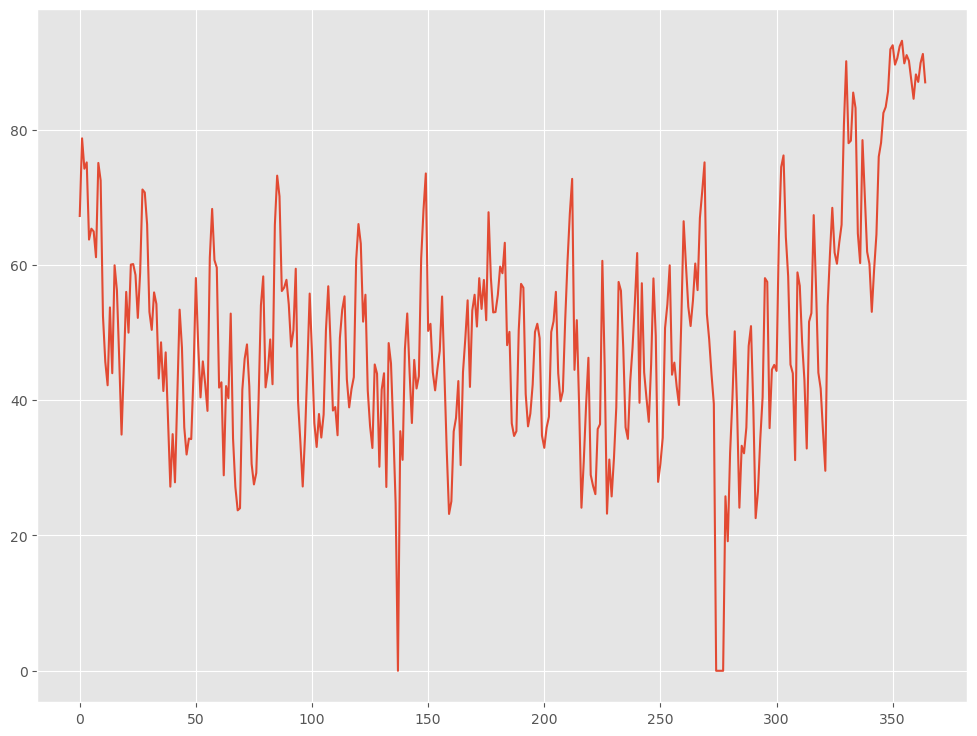

In [116]:
submit = pd.DataFrame({'datetime' : test_data.index, 'pred' : y_test_pred})

print(submit)

# 閉店時の予測値を0に置き換える
for i in test_data2[test_data2['close']==1].index:
    submit['pred'].iloc[i] = 0
    
# 予測値を描画
plt.plot(submit['pred'])

submit.columns = submit.iloc[0]
print(submit)
#submit.to_csv('signate_ligthGBM_oputuna_0902_4.csv', index=False)